## Notes

We are weighting based on time (more recent reports are weighted more heavily when fitting data).

We have scant data past early November, and data around that point in time is suffereing from delays in reporting.


In [1]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt
from copy import copy
import pandas as pd

## Analysis of total cases

In [2]:
def seir(t, y, p):
    return [
        -p[1]*y[0]*y[2]/sum(y[:4]),
        p[1]*y[0]*y[2]/sum(y[:4]) - p[2]*y[1],
        p[2]*y[1] - p[0]*y[2],
        p[0]*y[2],
        p[2]*y[1]
    ]

In [3]:
cases = pd.read_csv("data/samoa_cases.csv", header=0, parse_dates=["Date"], dayfirst=True)
raw_times = cases["Date"].to_numpy()
raw_times = [(t-raw_times[0])/np.timedelta64(1,'D') for t in raw_times] # convert to days since first timestamp
raw_data = cases['Cases'].to_numpy()
raw_cumdata = np.cumsum(raw_data)

In [4]:
start = 1
clip = 5
times = raw_times[start:(-clip if clip else None)]
data = raw_data[start:(-clip if clip else None)]
cumdata = raw_cumdata[start:(-clip if clip else None)]

In [5]:
additional_times = [33,35,56,60,68, 75,83,86,87,89,90,91,92, 93,94,95, 96,97]
additional_cumdata = [28,36,169,314,513, 716,1174,1644,1797,2194,2437,2686,2936, 3149,3357,3530, 3728,3881]

# times = times + additional_times
# cumdata = np.concatenate([cumdata,additional_cumdata])
times = np.array(additional_times)
cumdata = np.array(additional_cumdata)

Text(0.5, 0, 'Days after 28 August 2019')

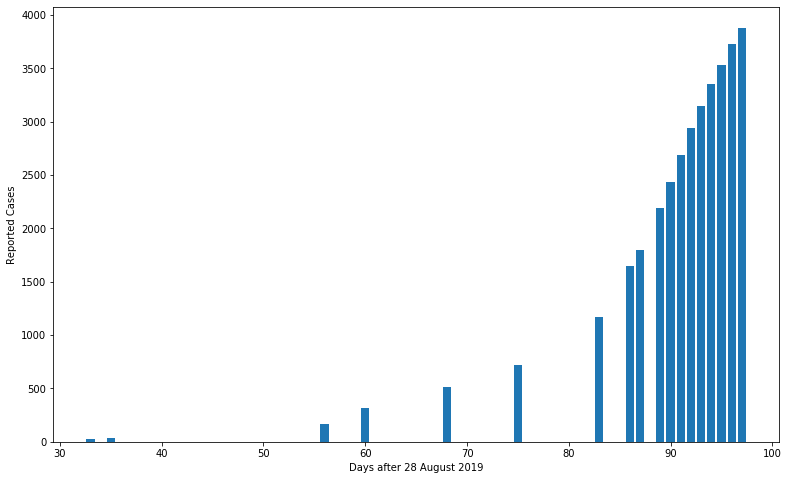

In [6]:
plt.figure(figsize=[13,8])
plt.bar(times, cumdata)
plt.ylabel("Reported Cases")
plt.xlabel("Days after 28 August 2019")

Text(0.5, 0, 'Days after 28 August 2019')

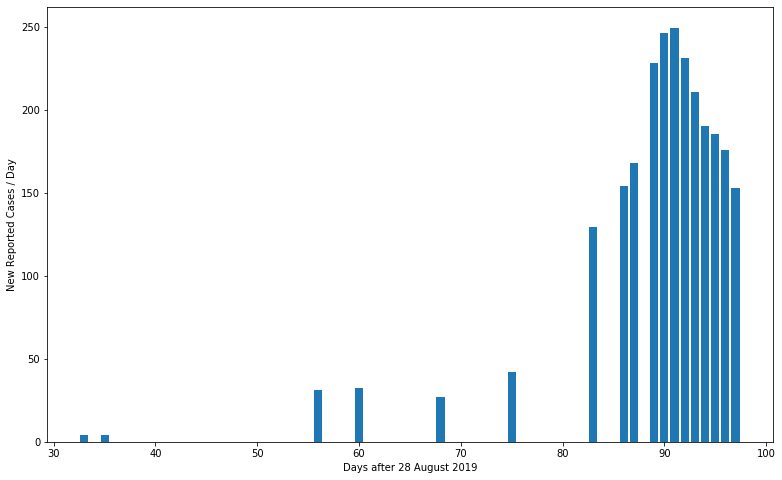

In [7]:
plt.figure(figsize=[13,8])
plt.bar(times, np.gradient(cumdata, times))
plt.ylabel("New Reported Cases / Day")
plt.xlabel("Days after 28 August 2019")

In [8]:
data_pd = np.array([[i] for i in cumdata])
p0 = [1/8, 1, 1/8]
config = {
    "grid_size": 100,
    "basis_number": 24,
    "model_form": {
        "state": 5,
        "parameters": 3
    },
    "time_span": [times[0], 130],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": data_pd, "t": np.array(times)},
    "observation_vector": [-1],
    "weightings":[
        [1]*5,
        np.sqrt(times/np.mean(times))
    ],
    "regularisation_value": copy(p0),
}

In [9]:
model = modeller.Model(config)
config['regularisation_value'][1] = model.ps[1]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 10,
        
    }
}

solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [10]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)


In [11]:
c0 = [max(cumdata)*np.ones(config['basis_number']) for _ in range(5)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*5) + [0]*len(config['regularisation_value'])
alpha = 1e3

In [12]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

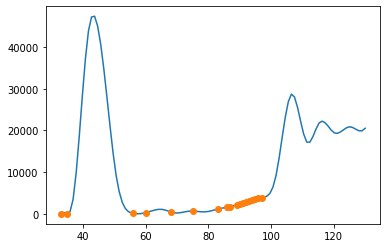

In [13]:
pure_xs = getx(pure_solve['x'])
plt.plot(model.observation_times, pure_xs[-1])
plt.plot(times, cumdata, 'o')

In [14]:
lbg = [0]*len(model.observation_times)*config['model_form']['state']
ubg = [140000]*len(model.observation_times)*config['model_form']['state']
# lbg[0] = 150000

In [15]:
prange = np.logspace(-6, 6, num=100)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': lbg,
        'ubg': ubg
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=1e-06
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du

  10  2.9651184e+01 0.00e+00 6.89e-01  -2.5 1.64e+04    -  7.03e-01 1.00e+00f  1
  20  2.9295782e+01 0.00e+00 1.18e-06  -5.7 9.60e-01  -5.9 1.00e+00 1.00e+00h  1
  30  2.9291627e+01 0.00e+00 9.24e-04  -8.6 4.89e+02 -10.2 1.00e+00 1.00e+00f  1
  40  2.9290235e+01 0.00e+00 3.38e-03  -8.6 3.80e+03 -15.0 1.00e+00 1.00e+00h  1
  50  2.9290201e+01 0.00e+00 4.18e-03  -8.6 4.24e+03 -14.3 1.00e+00 5.00e-01h  2
  60  2.9290142e+01 0.00e+00 6.72e-03  -8.6 2.15e+03 -13.7 1.00e+00 1.00e+00h  1
  70  2.9289860e+01 0.00e+00 3.85e-03  -8.6 1.02e+03 -13.0 1.00e+00 1.00e+00f  1
  80  2.9289322e+01 0.00e+00 7.57e-04  -8.6 1.00e+02    -  8.22e-01 1.00e+00f  1
  90  2.9289300e+01 0.00e+00 1.78e-04  -8.6 8.97e+04    -  7.24e-02 3.12e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.9289298e+01 0.00e+00 1.41e-05  -8.6 3.17e+04    -  1.00e+00 2.50e-01h  3

Number of Iterations....: 103

                                   (scaled)                 (unscaled)
Object

  30  2.9293927e+01 0.00e+00 3.64e-02  -8.6 1.66e+03 -11.6 8.49e-01 1.00e+00f  1
  40  2.9293303e+01 0.00e+00 1.05e-02  -8.6 7.00e+04 -14.6 9.05e-01 2.40e-01f  3
  50  2.9292575e+01 0.00e+00 1.45e-02  -8.6 3.27e+04 -14.0 1.00e+00 4.32e-01f  2
  60  2.9291478e+01 0.00e+00 5.94e-03  -8.6 2.27e+03 -14.2 1.00e+00 1.00e+00h  1
  70  2.9291466e+01 0.00e+00 2.38e-05  -8.6 1.26e+02 -15.2 1.00e+00 1.00e+00h  1

Number of Iterations....: 73

                                   (scaled)                 (unscaled)
Objective...............:   2.9291465783922654e+01    2.9291465783922654e+01
Dual infeasibility......:   3.0634923254909260e-09    3.0634923254909260e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   3.0634923254909260e-09    3.0634923254909260e-09


Number of objective function evaluations             = 121
Number of objective gradient evaluations       

  20  2.9528666e+01 0.00e+00 8.03e-05  -5.7 1.47e+01  -6.4 1.00e+00 1.00e+00f  1
  30  2.9302677e+01 0.00e+00 1.24e-01  -5.7 1.71e+03 -11.2 8.26e-01 1.00e+00f  1
  40  2.9301274e+01 0.00e+00 1.70e-02  -5.7 1.95e+03 -14.1 1.00e+00 1.00e+00h  1
  50  2.9300930e+01 0.00e+00 4.73e-02  -5.7 7.85e+03 -13.5 1.00e+00 2.50e-01f  3
  60  2.9299816e+01 0.00e+00 4.16e-02  -5.7 2.08e+03 -12.8 1.00e+00 5.00e-01f  2
  70  2.9297038e+01 0.00e+00 1.11e-02  -5.7 3.46e+02 -11.3 1.00e+00 1.00e+00f  1
  80  2.9296538e+01 0.00e+00 7.64e-03  -5.7 1.99e+04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 89

                                   (scaled)                 (unscaled)
Objective...............:   2.9296473528402487e+01    2.9296473528402487e+01
Dual infeasibility......:   1.6306534833965497e-09    1.6306534833965497e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059122447435389e-09    2.5059122447435389e-09
Overall NLP error......

  20  2.9318894e+01 0.00e+00 1.05e-06  -5.7 2.85e-01  -5.4 1.00e+00 1.00e+00h  1
  30  2.9318132e+01 0.00e+00 8.21e-05  -8.6 5.97e+01 -10.2 1.00e+00 1.00e+00h  1
  40  2.9316249e+01 0.00e+00 1.30e-01  -8.6 2.40e+03 -11.4 1.00e+00 5.00e-01f  2
  50  2.9310027e+01 0.00e+00 1.03e-01  -8.6 1.13e+03 -11.6 1.00e+00 4.03e-01f  2
  60  2.9308048e+01 0.00e+00 2.66e-03  -8.6 2.69e+04    -  8.75e-01 2.50e-01h  3
  70  2.9308041e+01 0.00e+00 1.79e-06  -8.6 5.88e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 71

                                   (scaled)                 (unscaled)
Objective...............:   2.9308040564358446e+01    2.9308040564358446e+01
Dual infeasibility......:   1.4995712628376810e-09    1.4995712628376810e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059574707599428e-09    2.5059574707599428e-09
Overall NLP error.......:   2.5059574707599428e-09    2.5059574707599428e-09


Number of objective funct

  60  2.9334776e+01 0.00e+00 1.34e-05  -8.6 2.87e+01 -11.0 1.00e+00 1.00e+00f  1
  70  2.9334754e+01 0.00e+00 2.42e-10  -8.6 1.26e+01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 70

                                   (scaled)                 (unscaled)
Objective...............:   2.9334754188597476e+01    2.9334754188597476e+01
Dual infeasibility......:   2.4232647118467662e-10    2.4232647118467662e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5060096599398485e-09    2.5060096599398485e-09
Overall NLP error.......:   2.5060096599398485e-09    2.5060096599398485e-09


Number of objective function evaluations             = 102
Number of objective gradient evaluations             = 71
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 102
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 71
N

  30  2.9448724e+01 0.00e+00 7.58e-04  -8.6 6.37e+01  -9.7 1.00e+00 1.00e+00f  1
  40  2.9434158e+01 0.00e+00 1.93e-01  -8.6 6.85e+02 -10.9 1.00e+00 1.00e+00f  1
  50  2.9399137e+01 0.00e+00 1.31e-01  -8.6 2.16e+03 -12.0 1.00e+00 1.00e+00f  1
  60  2.9396425e+01 0.00e+00 3.69e-03  -8.6 5.09e+04    -  1.00e+00 5.18e-01h  1

Number of Iterations....: 65

                                   (scaled)                 (unscaled)
Objective...............:   2.9396425155223863e+01    2.9396425155223863e+01
Dual infeasibility......:   2.5567950865250891e-12    2.5567950865250891e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5265175027474739e-09    2.5265175027474739e-09
Overall NLP error.......:   2.5265175027474739e-09    2.5265175027474739e-09


Number of objective function evaluations             = 91
Number of objective gradient evaluations             = 66
Number of equality constraint evaluations            = 0
Number of ineq

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.9538703e+01 0.00e+00 1.02e+00  -1.0 0.00e+00    -  0.00e+00 0.

  30  2.9868110e+01 0.00e+00 1.00e+00  -5.7 3.17e+02    -  9.16e-01 1.00e+00f  1
  40  2.9866130e+01 0.00e+00 2.68e-05  -8.6 2.75e+03    -  1.00e+00 3.12e-02f  6

Number of Iterations....: 42

                                   (scaled)                 (unscaled)
Objective...............:   2.9866130030036427e+01    2.9866130030036427e+01
Dual infeasibility......:   6.5455122489212195e-10    6.5455122489212195e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.1842909338546145e-09    4.1842909338546145e-09
Overall NLP error.......:   4.1842909338546145e-09    4.1842909338546145e-09


Number of objective function evaluations             = 57
Number of objective gradient evaluations             = 43
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 57
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 43
Num

Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.0617247e+01 0.00e+00 1.09e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  3.2571757e+01 0.00e+00 3.75e+01  -1.7 2.88e+03    -  6.58e-01 1.00e+00f  1
  20  3.1274283e+01 0.00e+00 4.26e+00  -2.5 1.00e+04    -  8.53e-01 1.25e-01f  4
  30  3.1242298e+01 0.00e+00 4.48e-02  -3.8 1.71e+02  -9.2 1.00e+00 1.00e+00f  1
  40  3.1038821e+01 0.00e+00 5.19e+00  -3.8 1.53e+04 -11.3 6.68e-01 6.12e-02f  3
  50  3.0639662e+01 0.00e+00 1.68e+00  -3.8 3.91e+03    -  1.00e+00 2.38e-01f  3
  60  3.0617038e+01 0.00e+00 4.70e-01  -5.7 6.20e+02    -  9.63e-01 1.00e+00f  1
  70  3.0616467e+01 0.00e+00 5.92e-04  -8.6 1.05e+02    -  1.00e+00 5.00e-01f  2

Number of Ite

  30  3.4998249e+01 0.00e+00 8.12e+01  -1.7 1.34e+04    -  1.00e+00 2.50e-01f  3
  40  3.4790689e+01 0.00e+00 4.90e+01  -1.7 3.59e+03 -10.3 1.00e+00 1.00e+00f  1
  50  3.4784549e+01 0.00e+00 8.10e+00  -1.7 9.44e+02    -  1.00e+00 1.00e+00f  1
  60  3.4099247e+01 0.00e+00 9.23e+00  -3.8 1.44e+04    -  8.71e-01 2.50e-01f  3
  70  3.4033602e+01 0.00e+00 6.82e-01  -3.8 9.23e+02 -11.1 1.00e+00 1.00e+00f  1
  80  3.3924579e+01 0.00e+00 7.90e-01  -3.8 1.35e+03 -10.5 1.00e+00 1.00e+00f  1
  90  3.3621402e+01 0.00e+00 1.33e+01  -3.8 4.43e+03 -10.7 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.2639711e+01 0.00e+00 1.44e+01  -3.8 4.31e+03 -10.1 1.00e+00 1.98e-01f  2
 110  3.2326070e+01 0.00e+00 3.58e+00  -3.8 1.94e+04    -  1.00e+00 1.00e+00f  1
 120  3.2317992e+01 0.00e+00 3.20e-02  -5.7 4.71e+03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 129

                                   (scaled)                 (unscaled)
Object

  40  3.7417900e+01 0.00e+00 2.39e+01  -2.5 3.30e+04    -  1.00e+00 5.00e-01f  2
  50  3.7293040e+01 0.00e+00 8.02e-01  -2.5 8.59e+03    -  1.00e+00 1.00e+00f  1
  60  3.6979736e+01 0.00e+00 1.10e+01  -2.5 4.64e+03 -11.6 1.00e+00 2.50e-01f  3
  70  3.6086049e+01 0.00e+00 6.76e+00  -2.5 1.15e+03 -10.5 1.00e+00 1.00e+00f  1
  80  3.4776475e+01 0.00e+00 3.80e+00  -2.5 2.34e+03 -10.7 1.00e+00 1.00e+00f  1
  90  3.4629881e+01 0.00e+00 5.89e-01  -2.5 2.16e+03    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.4497316e+01 0.00e+00 1.91e-07  -3.8 8.12e+00    -  1.00e+00 1.00e+00h  1
 110  3.4495127e+01 0.00e+00 1.67e-04  -8.6 3.36e+01    -  1.00e+00 2.50e-01f  3

Number of Iterations....: 112

                                   (scaled)                 (unscaled)
Objective...............:   3.4495126623640147e+01    3.4495126623640147e+01
Dual infeasibility......:   6.0050591099670405e-11    6.0050591099670405e-11
Constraint vio


Number of Iterations....: 43

                                   (scaled)                 (unscaled)
Objective...............:   4.0739628323550825e+01    4.0739628323550825e+01
Dual infeasibility......:   1.7411382372544445e-11    1.7411382372544445e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5105553191500069e-09    2.5105553191500069e-09
Overall NLP error.......:   2.5105553191500069e-09    2.5105553191500069e-09


Number of objective function evaluations             = 67
Number of objective gradient evaluations             = 44
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 67
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 44
Number of Lagrangian Hessian evaluations             = 43
Total CPU secs in IPOPT (w/o function evaluations)   =      0.066
Total CPU secs in NLP function evaluation


Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.9518419e+01 0.00e+00 2.99e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  6.0155492e+01 0.00e+00 5.15e-01  -1.7 1.25e+04    -  9.52e-01

                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.4713282e+01 0.00e+00 4.40e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  8.4594659e+01 0.00e+00 8.52e+00  -1.7 4.41e+03    -  7.14e-01 1.00e+00f  1
  20  8.3924706e+01 0.00e+00 4.09e-04  -2.5 5.22e+01    -  1.00e+00 1.00e+00h  1
  30  8.3883499e+01 0.00e+00 4.12e-02  -5.7 1.43e+04    -  1.00e+00 5.00e-01f  2

Number of Iterations....: 36

                                   (scaled)        

  20  1.1727627e+02 0.00e+00 9.00e-01  -8.6 4.47e+04    -  6.75e-01 9.54e-01f  1

Number of Iterations....: 23

                                   (scaled)                 (unscaled)
Objective...............:   1.1727625765590059e+02    1.1727625765590059e+02
Dual infeasibility......:   2.6487400572737103e-10    2.6487400572737103e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.6789258518484764e-09    2.6789258518484764e-09
Overall NLP error.......:   2.6789258518484764e-09    2.6789258518484764e-09


Number of objective function evaluations             = 37
Number of objective gradient evaluations             = 24
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 37
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 24
Number of Lagrangian Hessian evaluations             = 23
Total CPU secs in IPOPT (w

  10  1.7577443e+02 0.00e+00 3.85e+01  -1.7 1.22e+04    -  8.81e-01 1.00e+00f  1
  20  1.7550483e+02 0.00e+00 6.94e-01  -2.5 8.66e+02    -  1.00e+00 1.00e+00f  1
  30  1.7549307e+02 0.00e+00 7.52e-02  -5.7 3.55e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 38

                                   (scaled)                 (unscaled)
Objective...............:   1.7549293945506443e+02    1.7549293945506443e+02
Dual infeasibility......:   1.7764990510996042e-10    1.7764990510996042e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5405848585564673e-09    2.5405848585564673e-09
Overall NLP error.......:   2.5405848585564673e-09    2.5405848585564673e-09


Number of objective function evaluations             = 55
Number of objective gradient evaluations             = 39
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 55
Number of equality constraint Jacobia

  20  2.4349188e+02 0.00e+00 3.39e+01  -1.7 2.09e+04    -  1.00e+00 1.00e+00f  1
  30  2.4336023e+02 0.00e+00 1.09e-04  -5.7 1.93e-01  -6.9 1.00e+00 1.00e+00f  1

Number of Iterations....: 33

                                   (scaled)                 (unscaled)
Objective...............:   2.4336022710181024e+02    2.4336022710181024e+02
Dual infeasibility......:   2.1495259673479632e-09    2.1495259673479632e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035859150780e-09    2.5059035859150780e-09
Overall NLP error.......:   2.5059035859150780e-09    2.5059035859150780e-09


Number of objective function evaluations             = 46
Number of objective gradient evaluations             = 34
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 46
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 34
Num

  40  3.6069786e+02 0.00e+00 6.86e+01  -9.0 2.61e+02  -8.9 1.00e+00 1.00e+00f  1
  50  3.6003475e+02 0.00e+00 9.88e+00  -9.0 1.96e+03  -9.1 1.00e+00 1.00e+00f  1

Number of Iterations....: 57

                                   (scaled)                 (unscaled)
Objective...............:   3.5959532044410150e+02    3.5959532044410150e+02
Dual infeasibility......:   5.7638363185434855e-11    5.7638363185434855e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090931e-10    9.0909090909090931e-10
Overall NLP error.......:   9.0909090909090931e-10    9.0909090909090931e-10


Number of objective function evaluations             = 75
Number of objective gradient evaluations             = 58
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 75
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 58
Num

  70  5.6483980e+02 0.00e+00 1.58e+01  -5.7 5.33e+02  -8.0 1.00e+00 1.00e+00f  1

Number of Iterations....: 78

                                   (scaled)                 (unscaled)
Objective...............:   5.0570924185087387e+02    5.6381190637803627e+02
Dual infeasibility......:   3.7142479628984703e-11    4.1409906155918227e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5060105140698702e-09    2.7939346336047086e-09
Overall NLP error.......:   2.5060105140698702e-09    2.7939346336047086e-09


Number of objective function evaluations             = 106
Number of objective gradient evaluations             = 79
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 106
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 79
Number of Lagrangian Hessian evaluations             = 78
Total CPU secs in IPOPT 

  10  1.0585606e+03 0.00e+00 6.60e+01  -1.0 2.90e+03    -  4.64e-01 1.00e+00f  1
  20  1.0653167e+03 0.00e+00 2.90e+01  -1.0 3.20e+00  -5.0 1.00e+00 1.00e+00f  1
  30  1.0639443e+03 0.00e+00 1.57e-01  -3.8 2.83e+00  -7.4 1.00e+00 1.00e+00f  1
  40  1.0626581e+03 0.00e+00 4.71e+00  -5.7 1.32e+02  -8.5 1.00e+00 1.00e+00f  1
  50  1.0610162e+03 0.00e+00 4.65e-03  -5.7 8.33e+01  -7.9 1.00e+00 1.00e+00f  1
  60  1.0579944e+03 0.00e+00 4.44e+00  -5.7 4.52e+02  -8.2 1.00e+00 1.00e+00f  1
  70  1.0511698e+03 0.00e+00 8.63e-01  -5.7 1.35e+00  -4.8 1.00e+00 1.00e+00f  1
  80  1.0508198e+03 0.00e+00 3.34e-11  -9.0 2.77e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 80

                                   (scaled)                 (unscaled)
Objective...............:   5.5240589663918809e+02    1.0508198390985312e+03
Dual infeasibility......:   3.3376494103507382e-11    6.3490781646070901e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

  10  1.6419780e+03 0.00e+00 5.27e+02  -1.0 5.91e+02    -  8.05e-01 1.00e+00f  1
  20  1.6361641e+03 0.00e+00 2.27e-04  -2.5 1.42e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 28

                                   (scaled)                 (unscaled)
Objective...............:   6.2806803946719072e+02    1.6360421545026156e+03
Dual infeasibility......:   1.6083596855785948e-10    4.1895846944248324e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059055693311707e-09    6.5275844160238265e-09
Overall NLP error.......:   2.5059055693311707e-09    6.5275844160238265e-09


Number of objective function evaluations             = 34
Number of objective gradient evaluations             = 29
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 34
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 29
Num


                                   (scaled)                 (unscaled)
Objective...............:   7.3987760358225842e+02    2.4462486866479603e+03
Dual infeasibility......:   2.0575421113043782e-10    6.8028274719111922e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059050978717670e-09    8.2852447821820131e-09
Overall NLP error.......:   2.5059050978717670e-09    8.2852447821820131e-09


Number of objective function evaluations             = 32
Number of objective gradient evaluations             = 28
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 32
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 28
Number of Lagrangian Hessian evaluations             = 27
Total CPU secs in IPOPT (w/o function evaluations)   =      0.043
Total CPU secs in NLP function evaluations           =      0.015

EXIT

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.8992969e+03 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.

  30  5.3757182e+03 0.00e+00 9.03e+02  -1.7 6.99e+03    -  9.74e-01 5.00e-01f  2
  40  5.3739513e+03 0.00e+00 4.89e+00  -3.8 2.24e+01  -7.3 1.00e+00 1.00e+00f  1
  50  5.3729645e+03 0.00e+00 2.50e-01  -3.8 5.97e+00  -6.6 1.00e+00 1.00e+00f  1
  60  5.3704249e+03 0.00e+00 1.27e-01  -3.8 3.04e-01  -5.1 1.00e+00 1.00e+00f  1
  70  5.3689222e+03 0.00e+00 3.74e+00  -3.8 3.34e-01  -4.4 1.00e+00 1.00e+00f  1
  80  5.3672751e+03 0.00e+00 3.83e+02  -3.8 1.83e+00  -3.8 1.00e+00 1.00e+00f  1
  90  5.3656545e+03 0.00e+00 3.86e+02  -3.8 3.72e+03  -8.6 1.00e+00 5.79e-02f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.3651639e+03 0.00e+00 1.54e-09  -5.7 3.38e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 102

                                   (scaled)                 (unscaled)
Objective...............:   1.3047375576552110e+03    5.3651639348174849e+03
Dual infeasibility......:   2.4902908209620318e-09    1.0240234460517643e-08
Constraint vio

  20  5.9946231e+03 0.00e+00 1.09e+04  -1.0 1.38e+03    -  8.15e-01 1.00e+00f  1
  30  5.9879241e+03 0.00e+00 2.51e+02  -1.7 5.97e+00  -5.0 1.00e+00 5.00e-01f  2
  40  5.9895243e+03 0.00e+00 1.48e+03  -1.7 1.11e+04    -  8.78e-01 2.50e-01f  3
  50  5.9888728e+03 0.00e+00 1.06e+01  -2.5 3.65e+00  -6.8 1.00e+00 1.00e+00f  1
  60  5.9883197e+03 0.00e+00 3.02e-01  -2.5 6.69e-01  -6.1 1.00e+00 1.00e+00f  1
  70  5.9876990e+03 0.00e+00 2.60e-01  -3.8 1.29e-01  -4.6 1.00e+00 1.00e+00f  1
  80  5.9873451e+03 0.00e+00 7.39e+02  -3.8 2.82e+02  -8.4 1.00e+00 1.00e+00f  1
  90  5.9869628e+03 0.00e+00 2.27e+01  -3.8 4.69e+02  -8.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.9866406e+03 0.00e+00 3.32e+00  -3.8 1.17e+02  -8.0 1.00e+00 1.00e+00f  1
 110  5.9862139e+03 0.00e+00 3.51e-01  -3.8 3.01e+01  -7.4 1.00e+00 1.00e+00f  1
 120  5.9852985e+03 0.00e+00 1.13e-01  -3.8 1.13e+00  -5.8 1.00e+00 1.00e+00f  1
 130  5.9845254e+03 0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.4612987e+03 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.

 320  6.5556170e+03 0.00e+00 3.16e+00  -3.8 6.61e-01  -6.2 1.00e+00 1.00e+00f  1
 330  6.5555617e+03 0.00e+00 6.38e-06  -3.8 3.14e-04    -  1.00e+00 1.00e+00h  1
 340  6.5555498e+03 0.00e+00 7.28e-09  -9.0 2.97e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 340

                                   (scaled)                 (unscaled)
Objective...............:   2.8843748184287551e+03    6.5555498375749885e+03
Dual infeasibility......:   7.2823719862053833e-09    1.6551230508015386e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0946188601171179e-10    2.0670069233139728e-09
Overall NLP error.......:   7.2823719862053833e-09    1.6551230508015386e-08


Number of objective function evaluations             = 719
Number of objective gradient evaluations             = 341
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 719
Number of equality constraint Jac

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.8399456e+03 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.

  30  6.9717263e+03 0.00e+00 8.64e+04  -1.0 6.75e+03    -  6.86e-01 2.50e-01f  3
  40  6.9664613e+03 0.00e+00 1.01e+02  -1.0 3.80e-01  -2.9 1.00e+00 1.00e+00f  1
  50  6.9661423e+03 0.00e+00 7.24e+00  -1.0 9.71e-02  -2.7 1.00e+00 1.00e+00f  1
  60  6.9661089e+03 0.00e+00 4.20e+01  -1.0 2.50e-01  -3.3 1.00e+00 1.00e+00f  1
  70  6.9661191e+03 0.00e+00 5.94e+00  -1.0 1.03e-01  -2.9 1.00e+00 1.00e+00f  1
  80  6.9661571e+03 0.00e+00 1.40e+00  -1.0 4.46e-02  -2.6 1.00e+00 1.00e+00f  1
  90  6.9659471e+03 0.00e+00 2.28e+03  -1.7 9.12e-01  -4.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.9659251e+03 0.00e+00 4.97e+02  -1.7 6.99e-01  -5.2 1.00e+00 1.00e+00f  1
 110  6.9659470e+03 0.00e+00 3.19e+03  -1.7 1.82e+04    -  1.00e+00 1.25e-01f  4
 120  6.9658933e+03 0.00e+00 1.76e+03  -2.5 3.98e+00  -4.6 1.00e+00 5.00e-01f  2
 130  6.9658855e+03 0.00e+00 1.49e+03  -2.5 1.18e+00  -5.7 1.00e+00 1.00e+00f  1
 140  6.9658808e+03 0.00e+00

 980  6.9658086e+03 0.00e+00 8.00e-07  -9.0 6.63e-10    -  1.00e+00 2.50e-01f  3
 990  6.9658086e+03 0.00e+00 4.16e-07  -9.0 6.43e-09    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  6.9658086e+03 0.00e+00 2.13e-06  -9.0 2.20e-09    -  1.00e+00 1.53e-05f 17
1010  6.9658086e+03 0.00e+00 2.02e-06  -9.0 2.14e-09    -  1.00e+00 1.00e+00F  1
1020  6.9658086e+03 0.00e+00 2.37e-06  -9.0 3.58e-09    -  1.00e+00 1.00e+00H  1
1030  6.9658086e+03 0.00e+00 1.29e-06  -9.0 5.97e-09    -  1.00e+00 1.00e+00F  1
1040  6.9658086e+03 0.00e+00 9.55e-07  -9.0 5.00e-09    -  1.00e+00 1.00e+00H  1
1050  6.9658086e+03 0.00e+00 4.36e-06  -9.0 1.51e-09    -  1.00e+00 1.00e+00F  1
1060  6.9658086e+03 0.00e+00 1.90e-06  -9.0 3.18e-10    -  1.00e+00 1.00e+00H  1
1070  6.9658086e+03 0.00e+00 1.10e-06  -9.0 9.79e-09    -  1.00e+00 5.00e-01h  2
1080  6.9658086e+03 0.00e+00 1.70e-06  -9.0 3.84e-09    -  1.00e+00 1.56e-02f  7
1090  6.9658086e+03 0.00e+00

1980  6.9658086e+03 0.00e+00 2.52e-06  -9.0 4.66e-09    -  1.00e+00 7.63e-06f 18
1990  6.9658086e+03 0.00e+00 3.26e-07  -9.0 3.81e-09    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  6.9658086e+03 0.00e+00 1.40e-06  -9.0 5.52e-09    -  1.00e+00 5.00e-01f  2
2010  6.9658086e+03 0.00e+00 2.96e-06  -9.0 3.63e-09    -  1.00e+00 1.00e+00H  1
2020  6.9658086e+03 0.00e+00 2.90e-06  -9.0 1.90e-09    -  1.00e+00 1.00e+00H  1
2030  6.9658086e+03 0.00e+00 1.13e-06  -9.0 7.95e-09    -  1.00e+00 1.00e+00H  1
2040  6.9658086e+03 0.00e+00 1.51e-07  -9.0 1.62e-09    -  1.00e+00 1.00e+00h  1
2050  6.9658086e+03 0.00e+00 1.22e-06  -9.0 5.68e-09    -  1.00e+00 3.81e-06f 19
2060  6.9658086e+03 0.00e+00 5.26e-07  -9.0 1.80e-10    -  1.00e+00 1.00e+00F  1
2070  6.9658086e+03 0.00e+00 3.26e-07  -9.0 1.03e-08    -  1.00e+00 1.00e+00H  1
2080  6.9658086e+03 0.00e+00 1.31e-07  -9.0 1.58e-08    -  1.00e+00 1.91e-06f 20
2090  6.9658086e+03 0.00e+00

 400  7.1260337e+03 0.00e+00 1.50e-06  -8.6 4.02e-10    -  1.00e+00 1.00e+00H  1
 410  7.1260337e+03 0.00e+00 2.31e-07  -8.6 8.54e-09    -  1.00e+00 5.00e-01f  2
 420  7.1260337e+03 0.00e+00 2.97e-06  -8.6 9.09e-10    -  1.00e+00 2.50e-01f  3
 430  7.1260337e+03 0.00e+00 1.14e-06  -8.6 3.89e-09    -  1.00e+00 1.00e+00f  1
 440  7.1260337e+03 0.00e+00 4.21e-06  -8.6 1.99e-09    -  1.00e+00 1.25e-01h  4
 450  7.1260337e+03 0.00e+00 2.10e-06  -8.6 7.75e-09    -  1.00e+00 3.81e-06f 19
 460  7.1260337e+03 0.00e+00 2.92e-07  -8.6 2.34e-09    -  1.00e+00 6.25e-02f  5
 470  7.1260337e+03 0.00e+00 1.00e-06  -8.6 1.02e-08    -  1.00e+00 3.05e-05f 16
 480  7.1260337e+03 0.00e+00 2.53e-07  -8.6 4.81e-09    -  1.00e+00 2.50e-01f  3
 490  7.1260337e+03 0.00e+00 9.24e-07  -8.6 1.17e-08    -  1.00e+00 7.81e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  7.1260337e+03 0.00e+00 3.59e-06  -8.6 2.15e-09    -  1.00e+00 1.53e-05f 17
 510  7.1260337e+03 0.00e+00

1330  7.1260337e+03 0.00e+00 2.82e-06  -8.6 1.09e-08    -  1.00e+00 1.00e+00H  1
1340  7.1260337e+03 0.00e+00 2.73e-06  -8.6 5.00e-09    -  1.00e+00 1.00e+00F  1
1350  7.1260337e+03 0.00e+00 1.56e-06  -8.6 3.70e-10    -  1.00e+00 1.00e+00F  1
1360  7.1260337e+03 0.00e+00 2.47e-07  -8.6 4.61e-10    -  1.00e+00 1.00e+00H  1
1370  7.1260337e+03 0.00e+00 1.29e-06  -8.6 9.56e-10    -  1.00e+00 1.00e+00H  1
1380  7.1260337e+03 0.00e+00 2.69e-06  -8.6 5.45e-09    -  1.00e+00 1.00e+00H  1
1390  7.1260337e+03 0.00e+00 3.25e-06  -8.6 2.55e-09    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  7.1260337e+03 0.00e+00 4.49e-06  -8.6 1.07e-08    -  1.00e+00 1.00e+00F  1
1410  7.1260337e+03 0.00e+00 3.07e-06  -8.6 1.94e-10    -  1.00e+00 1.00e+00f  1
1420  7.1260337e+03 0.00e+00 2.94e-06  -8.6 4.56e-09    -  1.00e+00 6.25e-02f  5
1430  7.1260337e+03 0.00e+00 2.46e-06  -8.6 1.75e-09    -  1.00e+00 5.00e-01h  2
1440  7.1260337e+03 0.00e+00

2360  7.1260337e+03 0.00e+00 2.60e-06  -9.0 1.74e-09    -  1.00e+00 1.00e+00H  1
2370  7.1260337e+03 0.00e+00 4.54e-06  -9.0 4.71e-09    -  1.00e+00 5.00e-01h  2
2380  7.1260337e+03 0.00e+00 5.23e-07  -9.0 7.47e-09    -  1.00e+00 3.12e-02f  6
2390  7.1260337e+03 0.00e+00 5.19e-07  -9.0 1.66e-09    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400  7.1260337e+03 0.00e+00 2.87e-06  -9.0 1.36e-09    -  1.00e+00 1.00e+00H  1
2410  7.1260337e+03 0.00e+00 4.01e-07  -9.0 9.27e-10    -  1.00e+00 1.00e+00H  1
2420  7.1260337e+03 0.00e+00 5.52e-07  -9.0 1.49e-09    -  1.00e+00 1.25e-01f  4
2430  7.1260337e+03 0.00e+00 9.74e-07  -9.0 2.41e-10    -  1.00e+00 1.00e+00F  1
2440  7.1260337e+03 0.00e+00 1.33e-06  -9.0 9.05e-09    -  1.00e+00 1.00e+00H  1
2450  7.1260337e+03 0.00e+00 7.24e-07  -9.0 7.80e-09    -  1.00e+00 1.00e+00h  1
2460  7.1260337e+03 0.00e+00 2.55e-07  -9.0 5.15e-10    -  1.00e+00 1.00e+00h  1
2470  7.1260337e+03 0.00e+00

        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.3223639e+03 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  7.3621868e+03 0.00e+00 7.17e+04  -1.0 1.36e+03    -  5.06e-01 1.25e-01f  4
  20  7.3333607e+03 0.00e+00 2.26e+03  -1.0 5.80e-01  -2.2 1.00e+00 1.00e+00f  1
  30  7.3260951e+03 0.00e+00 1.80e+04  -1.0 4.34e+00  -3.4 1.00e+00 1.00e+00f  1
  40  7.3186172e+03 0.00e+00 2.16e+04  -1.0 2.56e+00  -3.2 1.00e+00 1.00e+00f  1
  50  7.3130491e+03 0.00e+00 4.47e+04  -1.0 1.88e+03    -  5.48e-01 2.50e-01f  3
  60  7.3098418e+03 0.00e+00 6.13e+03  -1.0 8.02e+03    -  5.41e-01 6.25e-02f  5
  70  7.3088245e+03 0.00e+00 3.51e+01  -1.0 1.68e-01  -2.8 1.00e+00 1.00e+00f  1
  80  7.3082517e+03 0.00e+00 1.32e+03  -1.7 6.22e-01  -3.9 1.00e+00 1.00e+00f 

 910  7.3079057e+03 0.00e+00 1.06e-05  -8.6 1.34e-08    -  1.00e+00 3.81e-06h 19
 920  7.3079057e+03 0.00e+00 1.52e-06  -8.6 4.99e-09    -  1.00e+00 1.56e-02f  7
 930  7.3079057e+03 0.00e+00 1.99e-06  -8.6 5.28e-09    -  1.00e+00 1.00e+00F  1
 940  7.3079057e+03 0.00e+00 3.29e-06  -8.6 1.33e-08    -  1.00e+00 1.00e+00F  1
 950  7.3079057e+03 0.00e+00 4.34e-06  -8.6 7.74e-09    -  1.00e+00 1.00e+00H  1
 960  7.3079057e+03 0.00e+00 7.29e-06  -8.6 4.22e-09    -  1.00e+00 1.00e+00F  1
 970  7.3079057e+03 0.00e+00 1.84e-07  -8.6 2.30e-09    -  1.00e+00 1.00e+00F  1
 980  7.3079057e+03 0.00e+00 7.70e-06  -8.6 9.46e-09    -  1.00e+00 1.00e+00F  1
 990  7.3079057e+03 0.00e+00 4.40e-06  -8.6 3.15e-09    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  7.3079057e+03 0.00e+00 7.36e-06  -8.6 3.64e-10    -  1.00e+00 1.00e+00F  1
1010  7.3079057e+03 0.00e+00 1.75e-06  -8.6 1.36e-08    -  1.00e+00 1.00e+00H  1
1020  7.3079057e+03 0.00e+00

 150  7.5162254e+03 0.00e+00 8.15e+03  -3.8 8.33e+00  -4.6 1.00e+00 2.50e-01f  3
 160  7.5162064e+03 0.00e+00 3.81e+03  -3.8 2.83e+00  -6.2 1.00e+00 1.00e+00f  1
 170  7.5161890e+03 0.00e+00 1.72e+01  -3.8 1.46e-01  -4.6 1.00e+00 1.00e+00f  1
 180  7.5161730e+03 0.00e+00 2.86e+01  -3.8 3.38e-01  -5.1 1.00e+00 1.00e+00f  1
 190  7.5161635e+03 0.00e+00 4.85e+02  -3.8 4.19e-01  -5.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  7.5161602e+03 0.00e+00 8.26e+02  -3.8 4.94e+00  -8.7 1.00e+00 1.00e+00f  1
 210  7.5161444e+03 0.00e+00 7.83e-01  -3.8 1.93e-01  -5.7 1.00e+00 1.00e+00h  1
 220  7.5161144e+03 0.00e+00 3.10e-01  -3.8 1.78e-02  -5.4 1.00e+00 1.00e+00f  1
 230  7.5160952e+03 0.00e+00 1.19e-04  -5.7 2.42e-04  -3.7 1.00e+00 1.00e+00f  1
 240  7.5160949e+03 0.00e+00 2.28e-07  -8.6 2.94e-09    -  1.00e+00 1.00e+00F  1
 250  7.5160949e+03 0.00e+00 2.03e-07  -8.6 6.35e-09    -  1.00e+00 1.25e-01f  4
 260  7.5160949e+03 0.00e+00

1080  7.5160949e+03 0.00e+00 1.48e-06  -8.6 9.35e-09    -  1.00e+00 7.63e-06f 18
1090  7.5160949e+03 0.00e+00 1.29e-06  -8.6 6.77e-09    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  7.5160949e+03 0.00e+00 1.95e-06  -8.6 1.92e-09    -  1.00e+00 1.00e+00h  1
1110  7.5160949e+03 0.00e+00 4.26e-06  -8.6 2.89e-09    -  1.00e+00 1.00e+00H  1
1120  7.5160949e+03 0.00e+00 2.05e-07  -8.6 9.49e-09    -  1.00e+00 1.00e+00H  1
1130  7.5160949e+03 0.00e+00 3.80e-06  -8.6 7.43e-09    -  1.00e+00 9.77e-04f 11
1140  7.5160949e+03 0.00e+00 1.18e-06  -8.6 9.84e-10    -  1.00e+00 1.00e+00H  1
1150  7.5160949e+03 0.00e+00 3.26e-06  -8.6 6.64e-10    -  1.00e+00 1.22e-04f 14
1160  7.5160949e+03 0.00e+00 3.12e-06  -8.6 1.50e-09    -  1.00e+00 1.00e+00H  1
1170  7.5160949e+03 0.00e+00 1.18e-06  -8.6 9.63e-09    -  1.00e+00 1.00e+00F  1
1180  7.5160949e+03 0.00e+00 1.29e-06  -8.6 1.05e-09    -  1.00e+00 1.00e+00H  1
1190  7.5160949e+03 0.00e+00

2020  7.5160949e+03 0.00e+00 1.86e-06  -9.0 1.17e-08    -  1.00e+00 1.00e+00H  1
2030  7.5160949e+03 0.00e+00 9.27e-07  -9.0 4.78e-09    -  1.00e+00 1.00e+00F  1
2040  7.5160949e+03 0.00e+00 1.16e-06  -9.0 7.74e-09    -  1.00e+00 6.10e-05f 15
2050  7.5160949e+03 0.00e+00 8.14e-07  -9.0 4.65e-09    -  1.00e+00 1.00e+00H  1
2060  7.5160949e+03 0.00e+00 6.14e-06  -9.0 2.78e-09    -  1.00e+00 1.00e+00F  1
2070  7.5160949e+03 0.00e+00 2.51e-06  -9.0 9.04e-10    -  1.00e+00 1.00e+00H  1
2080  7.5160949e+03 0.00e+00 2.66e-07  -9.0 1.39e-08    -  1.00e+00 1.00e+00F  1
2090  7.5160949e+03 0.00e+00 1.41e-06  -9.0 3.80e-09    -  1.00e+00 3.91e-03f  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  7.5160949e+03 0.00e+00 4.22e-06  -9.0 4.56e-09    -  1.00e+00 1.00e+00H  1
2110  7.5160949e+03 0.00e+00 4.11e-06  -9.0 4.09e-09    -  1.00e+00 1.53e-05f 17
2120  7.5160949e+03 0.00e+00 4.72e-06  -9.0 1.17e-08    -  1.00e+00 1.00e+00H  1
2130  7.5160949e+03 0.00e+00

2970r 7.5160949e+03 0.00e+00 9.85e+02  -9.0 0.00e+00    -  0.00e+00 4.77e-07R 22
Restoration phase converged to a feasible point that is
unacceptable to the filter for the original problem.
Restoration phase in the restoration phase failed.

Number of Iterations....: 2974

                                   (scaled)                 (unscaled)
Objective...............:   5.7723553135115344e+03    1.0059756424183259e+04
Dual infeasibility......:   4.2231451467204688e+05    7.3598746460628277e+05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.5177649717741767e-10    6.1305752767399191e-10
Overall NLP error.......:   4.2231451467204688e+05    7.3598746460628277e+05


Number of objective function evaluations             = 19151
Number of objective gradient evaluations             = 2967
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 19151
Number of equality constraint

 730  2.4854294e+05 0.00e+00 1.27e+04  -1.0 2.42e+02  -9.3 1.00e+00 2.50e-01f  3
 740  2.5163513e+05 0.00e+00 1.95e+04  -1.0 1.05e+05    -  7.16e-02 1.95e-02f  6
 750  2.5091890e+05 0.00e+00 9.18e+03  -1.0 6.23e+01  -8.4 1.00e+00 1.00e+00f  1
 760  2.5210936e+05 0.00e+00 3.96e+03  -1.0 4.56e+01  -8.7 1.00e+00 1.00e+00f  1
 770  2.5322201e+05 0.00e+00 3.61e+03  -1.0 1.29e+02  -8.9 1.00e+00 1.00e+00f  1
 780  2.5430828e+05 0.00e+00 5.16e+03  -1.0 5.40e+01  -8.3 1.00e+00 1.00e+00f  1
 790  2.5505404e+05 0.00e+00 2.12e+03  -1.0 4.06e+01  -8.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  2.5617077e+05 0.00e+00 1.68e+04  -1.0 2.02e+02  -8.8 1.00e+00 5.00e-01f  2
 810  2.5673357e+05 0.00e+00 1.39e+04  -1.0 1.08e+02  -9.0 1.00e+00 1.00e+00f  1
 820  2.5800602e+05 0.00e+00 2.76e+04  -1.0 3.19e+02  -9.3 1.00e+00 5.00e-01f  2
 830  2.5833170e+05 0.00e+00 1.29e+04  -1.0 4.33e+02  -8.6 1.00e+00 2.50e-01f  3
 840  2.5850522e+05 0.00e+00

1750  8.9844702e+04 0.00e+00 7.13e+03  -2.5 3.87e+02  -7.1 1.00e+00 1.00e+00f  1
1760  7.0487080e+04 0.00e+00 4.20e+02  -2.5 7.85e+01  -6.5 1.00e+00 1.00e+00f  1
1770  5.8111894e+04 0.00e+00 5.56e+02  -2.5 1.16e+02  -6.8 1.00e+00 1.00e+00f  1
1780  4.6033607e+04 0.00e+00 2.62e+03  -2.5 1.84e+02  -7.0 1.00e+00 1.00e+00f  1
1790  3.7402920e+04 0.00e+00 5.35e+03  -2.5 2.77e+02  -7.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800  3.0615066e+04 0.00e+00 3.99e+03  -2.5 3.62e+02  -7.5 1.00e+00 1.00e+00f  1
1810  2.6308913e+04 0.00e+00 2.86e+02  -2.5 7.47e+01  -6.9 1.00e+00 1.00e+00f  1
1820  2.2222126e+04 0.00e+00 7.70e+01  -2.5 9.35e+01  -7.1 1.00e+00 1.00e+00f  1
1830  1.9512723e+04 0.00e+00 1.41e+03  -2.5 1.54e+02  -7.4 1.00e+00 1.00e+00f  1
1840  1.7810031e+04 0.00e+00 2.36e+03  -2.5 2.09e+02  -7.6 1.00e+00 1.00e+00f  1
1850  1.6295350e+04 0.00e+00 3.27e+03  -2.5 2.47e+02  -7.9 1.00e+00 1.00e+00f  1
1860  1.5507190e+04 0.00e+00

2720  1.3644825e+04 0.00e+00 2.75e+02  -3.8 6.56e+01  -8.8 1.00e+00 1.00e+00f  1
2730  1.3616918e+04 0.00e+00 1.20e+02  -3.8 2.93e+02  -9.0 1.00e+00 1.25e-01f  4
2740  1.3585346e+04 0.00e+00 4.32e+02  -3.8 4.52e+01  -8.4 1.00e+00 1.00e+00f  1
2750  1.3559091e+04 0.00e+00 4.99e+02  -3.8 7.58e+01  -8.6 1.00e+00 1.00e+00f  1
2760  1.3529704e+04 0.00e+00 1.08e+02  -3.8 2.05e+01  -8.0 1.00e+00 1.00e+00f  1
2770  1.3502405e+04 0.00e+00 4.80e+02  -3.8 3.94e+01  -8.2 1.00e+00 1.00e+00f  1
2780  1.3479501e+04 0.00e+00 1.85e+01  -3.8 8.71e+00  -7.6 1.00e+00 1.00e+00f  1
2790  1.3444368e+04 0.00e+00 2.66e+02  -3.8 2.96e+01  -7.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2800  1.3421081e+04 0.00e+00 3.71e+02  -3.8 1.44e+02  -9.0 1.00e+00 2.50e-01f  3
2810  1.3395824e+04 0.00e+00 6.46e+02  -3.8 4.85e+01  -8.4 1.00e+00 1.00e+00f  1
2820  1.3376090e+04 0.00e+00 2.42e+02  -3.8 1.22e+02  -8.6 1.00e+00 2.50e-01f  3
2830  1.3351383e+04 0.00e+00

 350  3.1953145e+05 0.00e+00 1.49e+04  -1.0 4.36e+02  -8.9 1.00e+00 1.00e+00f  1
 360  3.2027782e+05 0.00e+00 5.27e+03  -1.0 7.48e+03    -  1.00e+00 6.25e-02f  5
 370  3.2128398e+05 0.00e+00 6.35e+03  -1.0 5.93e+03    -  1.00e+00 6.25e-02f  5
 380  3.1953273e+05 0.00e+00 5.19e+03  -1.0 4.11e+02  -9.4 1.00e+00 1.00e+00f  1
 390  3.2042774e+05 0.00e+00 8.15e+03  -1.0 7.41e+03    -  1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  3.2199131e+05 0.00e+00 8.32e+02  -1.0 1.85e+02  -8.8 1.00e+00 1.00e+00f  1
 410  3.2153236e+05 0.00e+00 4.79e+03  -1.0 1.83e+03  -9.5 1.00e+00 2.50e-01f  3
 420  3.2126046e+05 0.00e+00 4.40e+03  -1.0 1.60e+03    -  1.00e+00 2.50e-01f  3
 430  3.2128907e+05 0.00e+00 1.54e+03  -1.0 1.60e+03    -  1.00e+00 1.25e-01f  4
 440  3.2119306e+05 0.00e+00 6.16e+02  -1.0 5.39e+02    -  1.00e+00 2.50e-01f  3
 450  2.9926870e+05 0.00e+00 4.91e+04  -1.7 2.99e+03  -8.1 1.00e+00 3.62e-01f  2
 460  2.5606058e+05 0.00e+00

1370  2.1646187e+05 0.00e+00 1.77e+02  -2.5 1.38e+02  -9.5 1.00e+00 1.00e+00f  1
1380  2.1552036e+05 0.00e+00 9.40e+02  -2.5 1.16e+02  -9.3 1.00e+00 5.00e-01f  2
1390  2.1458571e+05 0.00e+00 1.27e+03  -2.5 9.90e+01  -9.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  2.1356538e+05 0.00e+00 3.25e+02  -2.5 3.75e+01  -8.9 1.00e+00 1.00e+00f  1
1410  2.1234911e+05 0.00e+00 1.39e+02  -2.5 9.94e+01  -9.2 1.00e+00 1.00e+00f  1
1420  2.1097659e+05 0.00e+00 2.29e+02  -2.5 2.73e+01  -8.5 1.00e+00 1.00e+00f  1
1430  2.0925235e+05 0.00e+00 5.90e+02  -2.5 4.38e+01  -8.8 1.00e+00 1.00e+00f  1
1440  2.0726849e+05 0.00e+00 4.74e+02  -2.5 1.69e+02  -9.0 1.00e+00 1.00e+00f  1
1450  2.0511099e+05 0.00e+00 3.25e+02  -2.5 2.89e+01  -8.4 1.00e+00 1.00e+00f  1
1460  2.0281210e+05 0.00e+00 3.41e+02  -2.5 4.24e+01  -8.6 1.00e+00 1.00e+00f  1
1470  1.9991522e+05 0.00e+00 1.79e+03  -2.5 3.18e+02  -8.0 1.00e+00 2.50e-01f  3
1480  1.9606041e+05 0.00e+00

2410  1.4532297e+04 0.00e+00 7.76e+01  -3.8 2.97e+01  -8.4 1.00e+00 1.00e+00f  1
2420  1.4473585e+04 0.00e+00 7.19e+00  -3.8 7.65e+00  -7.8 1.00e+00 1.00e+00f  1
2430  1.4422705e+04 0.00e+00 2.43e+02  -3.8 3.48e+02  -9.4 1.00e+00 1.25e-01f  4
2440  1.4373969e+04 0.00e+00 3.70e+02  -3.8 5.85e+01  -8.7 1.00e+00 1.00e+00f  1
2450  1.4330202e+04 0.00e+00 3.02e+02  -3.8 1.04e+02  -9.4 1.00e+00 5.00e-01f  2
2460  1.4290957e+04 0.00e+00 2.38e+02  -3.8 5.35e+01  -8.8 1.00e+00 1.00e+00f  1
2470  1.4245338e+04 0.00e+00 1.10e+02  -3.8 3.41e+01  -8.5 1.00e+00 1.00e+00f  1
2480  1.4205349e+04 0.00e+00 4.81e+02  -3.8 6.00e+04    -  5.11e-01 2.71e-03f  9
2490  1.4160155e+04 0.00e+00 4.75e+01  -3.8 2.06e+01  -8.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  1.4118701e+04 0.00e+00 2.44e+02  -3.8 5.18e+01  -9.2 1.00e+00 1.00e+00f  1
2510  1.4079806e+04 0.00e+00 4.80e+02  -3.8 2.43e+02  -9.4 1.00e+00 2.50e-01f  3
2520  1.4048121e+04 0.00e+00

  80  1.4996703e+05 0.00e+00 2.07e+04  -1.0 1.46e+03  -6.8 1.00e+00 1.08e-01f  3
  90  1.6150486e+05 0.00e+00 3.04e+03  -1.0 1.09e+05    -  1.74e-01 5.28e-03f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.9177713e+05 0.00e+00 9.03e+03  -1.0 1.82e+02  -6.8 1.00e+00 1.00e+00f  1
 110  2.1285691e+05 0.00e+00 4.05e+02  -1.0 2.70e+01  -6.1 1.00e+00 1.00e+00f  1
 120  2.3505683e+05 0.00e+00 4.32e+03  -1.0 2.19e+02  -7.3 1.00e+00 1.00e+00f  1
 130  2.5240664e+05 0.00e+00 1.32e+04  -1.0 3.77e+02  -7.5 1.00e+00 1.00e+00f  1
 140  2.6546199e+05 0.00e+00 1.28e+04  -1.0 1.67e+02  -7.3 1.00e+00 1.00e+00f  1
 150  2.6829417e+05 0.00e+00 1.60e+03  -1.0 1.86e+02  -7.5 1.00e+00 1.00e+00f  1
 160  2.7800509e+05 0.00e+00 4.62e+03  -1.0 8.38e+02  -8.2 1.00e+00 1.00e+00f  1
 170  2.7818830e+05 0.00e+00 7.13e+02  -1.0 1.48e+02  -7.5 1.00e+00 1.00e+00f  1
 180  2.9089529e+05 0.00e+00 1.60e+04  -1.0 4.18e+02  -8.1 1.00e+00 1.00e+00f  1
 190  2.8927753e+05 0.00e+00

1140  1.7085894e+05 0.00e+00 2.46e+03  -3.8 3.91e+02  -8.2 1.00e+00 5.00e-01f  2
1150  1.5512257e+05 0.00e+00 2.79e+03  -3.8 1.30e+04  -8.4 6.90e-02 1.98e-02f  6
1160  1.3640169e+05 0.00e+00 9.29e+02  -3.8 6.42e+02  -7.8 9.97e-01 5.00e-01f  2
1170  1.1711025e+05 0.00e+00 6.08e+02  -3.8 1.67e+02  -7.2 1.00e+00 1.00e+00f  1
1180  9.7757696e+04 0.00e+00 3.84e+03  -3.8 2.37e+03  -8.3 1.00e+00 2.57e-02f  1
1190  7.8588648e+04 0.00e+00 1.37e+02  -3.8 5.87e+01  -6.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  6.3378896e+04 0.00e+00 2.49e+02  -3.8 8.60e+01  -7.0 1.00e+00 1.00e+00f  1
1210  5.3093049e+04 0.00e+00 1.03e+03  -3.8 1.39e+02  -7.3 1.00e+00 1.00e+00f  1
1220  4.4112850e+04 0.00e+00 2.35e+03  -3.8 2.19e+02  -7.5 1.00e+00 1.00e+00f  1
1230  3.6821836e+04 0.00e+00 4.85e+03  -3.8 3.30e+02  -7.8 1.00e+00 1.00e+00f  1
1240  3.3052346e+04 0.00e+00 1.66e+02  -3.8 6.68e+01  -7.1 1.00e+00 1.00e+00f  1
1250  2.8338502e+04 0.00e+00

2070  1.4105579e+04 0.00e+00 4.35e+01  -3.8 8.55e+04    -  3.63e-01 9.61e-03f  7
2080  1.4092123e+04 0.00e+00 4.11e+01  -3.8 1.99e+01  -9.1 1.00e+00 1.00e+00f  1
2090  1.4079944e+04 0.00e+00 4.98e+01  -3.8 3.12e+01  -8.8 1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  1.4067105e+04 0.00e+00 7.10e-01  -3.8 2.22e+00  -7.7 1.00e+00 1.00e+00f  1
2110  1.4052138e+04 0.00e+00 1.73e+01  -3.8 1.23e+01  -8.3 1.00e+00 1.00e+00h  1
2120  1.4042620e+04 0.00e+00 3.23e-01  -3.8 1.94e+00  -7.7 1.00e+00 1.00e+00h  1
2130  1.4027869e+04 0.00e+00 8.54e+01  -3.8 1.88e+01  -8.4 1.00e+00 1.00e+00h  1
2140  1.4018429e+04 0.00e+00 8.75e-01  -3.8 2.81e+00  -7.7 1.00e+00 1.00e+00h  1
2150  1.4004415e+04 0.00e+00 8.38e-01  -3.8 3.26e+00  -7.9 1.00e+00 1.00e+00h  1
2160  1.3971110e+04 0.00e+00 9.63e+01  -3.8 1.34e+05    -  2.62e-01 4.08e-03f  8
2170  1.3959586e+04 0.00e+00 1.98e+01  -3.8 1.29e+01  -8.4 1.00e+00 1.00e+00h  1
2180  1.3942493e+04 0.00e+00

  20  3.0919024e+04 0.00e+00 9.38e+03  -1.0 2.25e+02  -7.1 1.00e+00 5.00e-01f  2
  30  2.9745042e+04 0.00e+00 2.04e+03  -1.0 6.08e+01  -6.4 1.00e+00 1.00e+00f  1
  40  3.1408138e+04 0.00e+00 1.89e+03  -1.0 1.17e+03  -7.6 1.00e+00 1.25e-01f  4
  50  3.2126934e+04 0.00e+00 6.52e+02  -1.0 5.60e+01  -6.0 1.00e+00 1.00e+00f  1
  60  3.3209331e+04 0.00e+00 2.68e+02  -1.0 1.73e+01  -5.4 1.00e+00 1.00e+00f  1
  70  3.5681555e+04 0.00e+00 7.10e+03  -1.0 1.29e+02  -6.5 1.00e+00 1.00e+00f  1
  80  3.7889229e+04 0.00e+00 6.26e+03  -1.0 9.88e+01  -5.9 1.00e+00 1.00e+00f  1
  90  3.9746625e+04 0.00e+00 1.12e+03  -1.0 6.29e+01  -6.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.3207509e+04 0.00e+00 5.53e+01  -1.0 1.48e+01  -5.5 1.00e+00 1.00e+00f  1
 110  4.8984812e+04 0.00e+00 5.74e+03  -1.0 1.63e+02  -7.1 1.00e+00 1.00e+00f  1
 120  5.3172312e+04 0.00e+00 4.80e+03  -1.0 1.01e+02  -6.4 1.00e+00 1.00e+00f  1
 130  5.9037520e+04 0.00e+00

 980  2.2880953e+05 0.00e+00 9.06e+01  -2.5 8.48e+01  -9.1 1.00e+00 1.00e+00f  1
 990  2.2841415e+05 0.00e+00 1.68e+01  -2.5 3.31e+01  -8.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  2.2810552e+05 0.00e+00 1.80e+03  -2.5 3.08e+02  -9.8 1.00e+00 1.00e+00f  1
1010  2.2768374e+05 0.00e+00 2.49e+02  -2.5 1.06e+02  -9.6 1.00e+00 1.00e+00f  1
1020  2.2742499e+05 0.00e+00 1.73e+01  -2.5 1.50e+01  -8.8 1.00e+00 1.00e+00f  1
1030  2.2722904e+05 0.00e+00 4.18e+02  -2.5 8.78e+01  -9.4 1.00e+00 1.00e+00f  1
1040  2.2703249e+05 0.00e+00 1.73e+02  -2.5 6.83e+01  -9.6 1.00e+00 1.00e+00f  1
1050  2.2685090e+05 0.00e+00 6.98e+02  -2.5 8.23e+01  -9.8 1.00e+00 1.00e+00f  1
1060  2.2670361e+05 0.00e+00 6.11e+02  -2.5 6.88e+01  -9.6 1.00e+00 1.00e+00f  1
1070  2.2653675e+05 0.00e+00 1.45e+03  -2.5 1.69e+02  -9.8 1.00e+00 5.00e-01f  2
1080  2.2642855e+05 0.00e+00 1.61e+03  -2.5 2.07e+02 -10.0 1.00e+00 5.00e-01f  2
1090  2.2628559e+05 0.00e+00

2050  1.6879171e+04 0.00e+00 3.32e+02  -3.8 1.88e+02  -8.2 1.00e+00 2.50e-01f  3
2060  1.6815314e+04 0.00e+00 6.01e+02  -3.8 6.34e+01  -8.4 1.00e+00 1.00e+00f  1
2070  1.6754306e+04 0.00e+00 8.93e-01  -3.8 2.61e+00  -6.9 1.00e+00 1.00e+00f  1
2080  1.6703824e+04 0.00e+00 3.54e+01  -3.8 1.34e+01  -7.6 1.00e+00 1.00e+00f  1
2090  1.6645038e+04 0.00e+00 8.16e+02  -3.8 1.84e+02  -7.8 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  1.6581563e+04 0.00e+00 9.39e+01  -3.8 2.57e+01  -8.1 1.00e+00 1.00e+00f  1
2110  1.6524548e+04 0.00e+00 7.55e+02  -3.8 8.63e+01  -8.3 1.00e+00 5.00e-01f  2
2120  1.6467829e+04 0.00e+00 1.01e+03  -3.8 1.20e+02  -9.0 1.00e+00 1.00e+00f  1
2130  1.6414116e+04 0.00e+00 4.50e+02  -3.8 5.51e+01  -8.4 1.00e+00 1.00e+00f  1
2140  1.6353502e+04 0.00e+00 3.36e+02  -3.8 5.46e+01  -8.6 1.00e+00 1.00e+00f  1
2150  1.6301665e+04 0.00e+00 4.86e+02  -3.8 1.64e+03  -8.0 5.28e-01 3.12e-02f  6
2160  1.6246441e+04 0.00e+00

  60  6.7235542e+04 0.00e+00 2.51e+03  -1.0 7.67e+01  -5.9 1.00e+00 1.00e+00f  1
  70  7.0488569e+04 0.00e+00 3.66e+03  -1.0 2.94e+02  -7.0 1.00e+00 1.00e+00f  1
  80  7.5087559e+04 0.00e+00 3.36e+03  -1.0 1.29e+02  -6.4 1.00e+00 1.00e+00f  1
  90  8.2911145e+04 0.00e+00 1.14e+04  -1.0 1.83e+02  -6.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  9.3004527e+04 0.00e+00 1.21e+04  -1.0 3.65e+02  -6.9 1.00e+00 5.00e-01f  2
 110  1.0064732e+05 0.00e+00 7.04e+03  -1.0 2.97e+02  -7.1 1.00e+00 1.00e+00f  1
 120  1.1287696e+05 0.00e+00 3.70e+03  -1.0 1.12e+02  -6.5 1.00e+00 1.00e+00f  1
 130  1.3569731e+05 0.00e+00 1.05e+04  -1.0 1.89e+02  -6.7 1.00e+00 1.00e+00f  1
 140  1.5363011e+05 0.00e+00 1.00e+04  -1.0 1.35e+03  -7.9 1.00e+00 2.50e-01f  3
 150  1.6263811e+05 0.00e+00 2.91e+02  -1.0 3.81e+01  -6.4 1.00e+00 1.00e+00f  1
 160  1.8858019e+05 0.00e+00 1.25e+03  -1.0 9.00e+01  -7.0 1.00e+00 1.00e+00f  1
 170  2.1440734e+05 0.00e+00

1090  2.2440790e+05 0.00e+00 1.80e+01  -3.8 1.37e+01  -8.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  2.2417740e+05 0.00e+00 1.32e+03  -3.8 2.34e+02  -9.8 1.00e+00 5.00e-01f  2
1110  2.2396033e+05 0.00e+00 7.90e+02  -3.8 7.91e+01  -9.1 1.00e+00 1.00e+00f  1
1120  2.2366124e+05 0.00e+00 7.16e+02  -3.8 7.74e+01  -9.4 1.00e+00 1.00e+00f  1
1130  2.2340833e+05 0.00e+00 2.90e+02  -3.8 8.82e+01  -9.6 1.00e+00 1.00e+00f  1
1140  2.2315143e+05 0.00e+00 7.05e+01  -3.8 2.31e+01  -9.0 1.00e+00 1.00e+00f  1
1150  2.2293288e+05 0.00e+00 6.17e+01  -3.8 4.80e+01  -9.2 1.00e+00 1.00e+00f  1
1160  2.2267763e+05 0.00e+00 5.57e+02  -3.8 7.34e+01  -9.5 1.00e+00 1.00e+00f  1
1170  2.2240205e+05 0.00e+00 2.10e+03  -3.8 1.47e+02  -9.7 1.00e+00 1.00e+00f  1
1180  2.2210592e+05 0.00e+00 2.66e+03  -3.8 1.23e+02  -9.1 1.00e+00 1.00e+00f  1
1190  2.2177235e+05 0.00e+00 3.10e+02  -3.8 1.00e+02  -9.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

2070  1.6607056e+04 0.00e+00 3.01e+01  -3.8 1.72e+02  -9.4 1.00e+00 5.00e-01f  2
2080  1.6575156e+04 0.00e+00 3.02e+01  -3.8 1.37e+01  -7.8 1.00e+00 1.00e+00f  1
2090  1.6542682e+04 0.00e+00 1.04e+01  -3.8 8.07e+00  -7.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  1.6514809e+04 0.00e+00 1.10e+02  -3.8 1.52e+02  -8.7 1.00e+00 1.25e-01f  4
2110  1.6481106e+04 0.00e+00 8.93e+01  -3.8 2.35e+01  -8.1 1.00e+00 1.00e+00f  1
2120  1.6443999e+04 0.00e+00 2.48e+02  -3.8 2.57e+01  -7.9 1.00e+00 1.00e+00f  1
2130  1.6407187e+04 0.00e+00 5.09e+02  -3.8 3.67e+01  -8.1 1.00e+00 1.00e+00f  1
2140  1.6375774e+04 0.00e+00 1.20e+02  -3.8 4.04e+01  -8.3 1.00e+00 5.00e-01f  2
2150  1.6346492e+04 0.00e+00 7.80e+00  -3.8 7.33e+00  -7.7 1.00e+00 1.00e+00f  1
2160  1.6316972e+04 0.00e+00 1.63e+02  -3.8 9.19e+01  -8.8 1.00e+00 2.50e-01f  3
2170  1.6280909e+04 0.00e+00 2.06e+01  -3.8 2.87e+01  -8.6 1.00e+00 1.00e+00f  1
2180  1.6255304e+04 0.00e+00

  80  1.5778670e+04 0.00e+00 1.27e+04  -1.0 3.79e+01  -5.9 1.00e+00 5.00e-01f  2
  90  1.5812054e+04 0.00e+00 6.67e+03  -1.0 7.36e+01  -6.1 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.5842358e+04 0.00e+00 2.92e+01  -1.0 1.41e+00  -4.6 1.00e+00 1.00e+00f  1
 110  1.5869088e+04 0.00e+00 9.78e+02  -1.0 6.84e+00  -5.3 1.00e+00 1.00e+00f  1
 120  1.5865802e+04 0.00e+00 2.18e+03  -1.0 9.25e+00  -5.1 1.00e+00 1.00e+00f  1
 130  1.5896137e+04 0.00e+00 1.10e+03  -1.0 8.04e+00  -5.3 1.00e+00 1.00e+00f  1
 140  1.5926971e+04 0.00e+00 3.38e+03  -1.0 9.25e+00  -5.1 1.00e+00 1.00e+00f  1
 150  1.5931528e+04 0.00e+00 1.01e+03  -1.0 7.75e+00  -5.3 1.00e+00 1.00e+00f  1
 160  1.5978205e+04 0.00e+00 1.97e+04  -1.0 9.27e+01  -6.5 1.00e+00 2.50e-01f  3
 170  1.6008614e+04 0.00e+00 5.19e+03  -1.0 1.57e+01  -5.9 1.00e+00 1.00e+00f  1
 180  1.6032837e+04 0.00e+00 1.20e+04  -1.0 2.85e+02  -6.5 1.00e+00 6.25e-02f  5
 190  1.6045514e+04 0.00e+00

1100  1.9279473e+04 0.00e+00 2.36e+03  -1.0 1.09e+01  -6.2 1.00e+00 1.00e+00f  1
1110  1.9343968e+04 0.00e+00 1.69e+04  -1.0 2.85e+01  -6.5 1.00e+00 1.00e+00f  1
1120  1.9395800e+04 0.00e+00 3.25e+03  -1.0 2.28e+01  -6.8 1.00e+00 1.00e+00f  1
1130  1.9470329e+04 0.00e+00 8.83e+03  -1.0 3.06e+01  -7.0 1.00e+00 1.00e+00f  1
1140  1.9501173e+04 0.00e+00 2.48e+04  -1.0 4.68e+01  -7.2 1.00e+00 1.00e+00f  1
1150  1.9563925e+04 0.00e+00 2.52e+04  -1.0 5.07e+01  -7.5 1.00e+00 1.00e+00f  1
1160  1.9616822e+04 0.00e+00 2.20e+04  -1.0 6.26e+01  -7.7 1.00e+00 1.00e+00f  1
1170  1.9658527e+04 0.00e+00 1.34e+04  -1.0 7.53e+03    -  1.00e+00 1.56e-02f  7
1180  1.9695676e+04 0.00e+00 1.72e+02  -1.0 4.97e+00  -6.4 1.00e+00 1.00e+00f  1
1190  1.9736456e+04 0.00e+00 3.50e+04  -1.0 1.04e+02  -8.4 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  1.9783788e+04 0.00e+00 5.07e+03  -1.0 2.73e+01  -6.8 1.00e+00 1.00e+00f  1
1210  1.9827143e+04 0.00e+00

2050  1.5485087e+04 0.00e+00 1.34e+04  -1.7 4.30e+01  -6.7 1.00e+00 5.00e-01f  2
2060  1.5460913e+04 0.00e+00 5.96e+02  -1.7 7.87e+00  -6.1 1.00e+00 1.00e+00f  1
2070  1.5432030e+04 0.00e+00 2.60e+03  -1.7 2.12e+01  -6.8 1.00e+00 1.00e+00f  1
2080  1.5403252e+04 0.00e+00 2.96e+01  -1.7 1.90e+00  -5.7 1.00e+00 1.00e+00f  1
2090  1.5372252e+04 0.00e+00 1.42e+04  -1.7 2.47e+01  -7.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  1.5350519e+04 0.00e+00 2.34e+03  -1.7 1.08e+01  -6.5 1.00e+00 1.00e+00f  1
2110  1.5328040e+04 0.00e+00 2.57e+02  -1.7 3.23e+00  -5.9 1.00e+00 1.00e+00f  1
2120  1.5305307e+04 0.00e+00 6.99e+03  -1.7 1.06e+02  -7.0 1.00e+00 2.50e-01f  3
2130  1.5279006e+04 0.00e+00 1.11e+03  -1.7 1.02e+01  -6.4 1.00e+00 1.00e+00f  1
2140  1.5254878e+04 0.00e+00 7.04e+03  -1.7 6.10e+01  -7.6 1.00e+00 5.00e-01f  2
2150  1.5231549e+04 0.00e+00 1.93e+02  -1.7 4.47e+00  -6.0 1.00e+00 1.00e+00f  1
2160  1.5209840e+04 0.00e+00

  50  2.3408225e+04 0.00e+00 9.94e+03  -1.0 5.05e+01  -6.0 1.00e+00 1.00e+00f  1
  60  2.3529240e+04 0.00e+00 5.61e+03  -1.0 7.69e+01  -6.2 1.00e+00 5.00e-01f  2
  70  2.4387644e+04 0.00e+00 6.21e+03  -1.0 2.61e+02  -6.5 1.00e+00 2.50e-01f  3
  80  2.5208118e+04 0.00e+00 2.02e+02  -1.0 9.99e+00  -5.4 1.00e+00 1.00e+00f  1
  90  2.6340152e+04 0.00e+00 2.48e+03  -1.0 3.33e+01  -6.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.7456933e+04 0.00e+00 5.86e+03  -1.0 8.57e+01  -6.3 1.00e+00 1.00e+00f  1
 110  2.8993401e+04 0.00e+00 1.90e+03  -1.0 4.46e+01  -6.1 1.00e+00 1.00e+00f  1
 120  3.0903436e+04 0.00e+00 6.94e+03  -1.0 3.33e+02  -6.3 1.00e+00 2.50e-01f  3
 130  3.1634631e+04 0.00e+00 9.42e+03  -1.0 5.91e+01  -6.1 1.00e+00 1.00e+00f  1
 140  3.2523607e+04 0.00e+00 4.52e+02  -1.0 2.57e+01  -5.9 1.00e+00 1.00e+00f  1
 150  3.4212638e+04 0.00e+00 5.85e+03  -1.0 1.81e+04    -  1.00e+00 1.56e-02f  7
 160  3.6717862e+04 0.00e+00

 990  2.9173766e+04 0.00e+00 1.57e+02  -1.7 2.44e+02    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  2.9127147e+04 0.00e+00 7.11e+02  -1.7 4.64e+03    -  1.00e+00 7.81e-03f  8
1010  2.9095477e+04 0.00e+00 4.34e+01  -1.7 8.29e+00  -9.6 1.00e+00 1.00e+00h  1
1020  2.7553203e+04 0.00e+00 1.70e+03  -2.5 4.81e+01  -6.6 1.00e+00 1.00e+00f  1
1030  2.6686992e+04 0.00e+00 2.30e+03  -2.5 4.57e+01  -7.3 1.00e+00 1.00e+00f  1
1040  2.6388764e+04 0.00e+00 1.85e+03  -2.5 2.67e+02  -8.9 1.00e+00 2.50e-01f  3
1050  2.6027483e+04 0.00e+00 7.41e+03  -2.5 2.79e+02  -8.2 1.00e+00 2.50e-01f  3
1060  2.5726798e+04 0.00e+00 1.79e+02  -2.5 1.35e+01  -7.1 1.00e+00 1.00e+00f  1
1070  2.5491175e+04 0.00e+00 3.97e+02  -2.5 2.21e+01  -7.3 1.00e+00 1.00e+00f  1
1080  2.5292831e+04 0.00e+00 2.72e+02  -2.5 1.56e+01  -7.1 1.00e+00 1.00e+00f  1
1090  2.5092095e+04 0.00e+00 3.45e+02  -2.5 2.29e+01  -7.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

1910  1.7557195e+04 0.00e+00 3.52e+01  -2.5 5.23e+00  -7.6 1.00e+00 1.00e+00f  1
1920  1.7525885e+04 0.00e+00 6.45e+02  -2.5 1.85e+01  -7.9 1.00e+00 1.00e+00f  1
1930  1.7490464e+04 0.00e+00 1.02e+02  -2.5 1.10e+01  -7.7 1.00e+00 1.00e+00f  1
1940  1.7465925e+04 0.00e+00 7.40e+02  -2.5 1.99e+01  -7.9 1.00e+00 1.00e+00f  1
1950  1.7430568e+04 0.00e+00 2.49e+02  -2.5 2.02e+01  -8.1 1.00e+00 1.00e+00f  1
1960  1.7399945e+04 0.00e+00 6.70e+02  -2.5 1.85e+01  -7.9 1.00e+00 1.00e+00f  1
1970  1.7371711e+04 0.00e+00 1.36e+03  -2.5 2.70e+01  -8.2 1.00e+00 1.00e+00f  1
1980  1.7351819e+04 0.00e+00 3.95e+01  -2.5 4.99e+00  -7.5 1.00e+00 1.00e+00f  1
1990  1.7326017e+04 0.00e+00 4.20e+01  -2.5 4.53e+00  -7.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  1.7305074e+04 0.00e+00 3.46e+01  -2.5 4.84e+00  -7.6 1.00e+00 1.00e+00f  1
2010  1.7283223e+04 0.00e+00 3.37e+02  -2.5 1.30e+01  -7.8 1.00e+00 1.00e+00f  1
2020  1.7261076e+04 0.00e+00

2940  1.5155141e+04 0.00e+00 7.18e+02  -3.8 1.48e+01  -7.4 1.00e+00 1.00e+00f  1
2950  1.5135138e+04 0.00e+00 3.46e+02  -3.8 8.19e+01  -7.6 1.00e+00 1.25e-01f  4
2960  1.5106727e+04 0.00e+00 1.12e+01  -3.8 1.87e+00  -6.5 1.00e+00 1.00e+00f  1
2970  1.5082490e+04 0.00e+00 4.51e+02  -3.8 2.37e+01  -7.6 1.00e+00 1.00e+00f  1
2980  1.5052378e+04 0.00e+00 2.27e+02  -3.8 4.34e+01  -7.0 1.00e+00 2.50e-01f  3
2990  1.5030706e+04 0.00e+00 3.60e+02  -3.8 1.98e+01  -7.2 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  1.5012527e+04 0.00e+00 7.51e+02  -3.8 2.44e+01  -7.5 1.00e+00 1.00e+00f  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   2.0561709371421202e+00    1.5012526585113943e+04
Dual infeasibility......:   7.5133445549343048e+02    5.4856472697180295e+06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity..

 570  2.5125884e+05 0.00e+00 3.33e+02  -2.5 5.63e+01  -8.8 1.00e+00 1.00e+00f  1
 580  2.5004995e+05 0.00e+00 1.17e+03  -2.5 3.40e+02  -9.9 1.00e+00 1.00e+00f  1
 590  2.4893833e+05 0.00e+00 3.64e+03  -2.5 2.59e+02  -9.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  2.4783584e+05 0.00e+00 3.12e+03  -2.5 4.86e+02 -10.4 1.00e+00 1.00e+00f  1
 610  2.4657593e+05 0.00e+00 3.38e+02  -2.5 8.82e+01  -9.3 1.00e+00 1.00e+00f  1
 620  2.4559962e+05 0.00e+00 6.30e+03  -2.5 5.99e+02 -10.4 1.00e+00 1.00e+00f  1
 630  2.4462349e+05 0.00e+00 1.25e+03  -2.5 1.95e+02  -9.7 1.00e+00 1.00e+00f  1
 640  2.4370362e+05 0.00e+00 1.38e+02  -2.5 5.38e+01  -9.1 1.00e+00 1.00e+00f  1
 650  2.4273218e+05 0.00e+00 1.12e+03  -2.5 2.99e+05    -  7.33e-02 7.39e-04f  9
 660  2.4186993e+05 0.00e+00 5.66e+02  -2.5 2.22e+02 -10.0 1.00e+00 1.00e+00f  1
 670  2.4109166e+05 0.00e+00 1.02e+03  -2.5 2.86e+03    -  1.00e+00 1.25e-01f  4
 680  2.4025732e+05 0.00e+00

1580  2.1229737e+05 0.00e+00 9.02e+02  -3.8 9.77e+01  -9.4 1.00e+00 5.00e-01f  2
1590  2.1138484e+05 0.00e+00 5.32e+02  -3.8 2.14e+02 -10.5 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  2.1043043e+05 0.00e+00 8.94e+01  -3.8 3.70e+01  -9.0 1.00e+00 1.00e+00f  1
1610  2.0949054e+05 0.00e+00 1.03e+03  -3.8 1.85e+02  -9.2 1.00e+00 2.50e-01f  3
1620  2.0837844e+05 0.00e+00 5.33e+02  -3.8 1.53e+02  -8.6 1.00e+00 2.50e-01f  3
1630  2.0717306e+05 0.00e+00 4.70e+02  -3.8 3.41e+01  -8.8 1.00e+00 1.00e+00f  1
1640  2.0590660e+05 0.00e+00 8.97e+02  -3.8 1.58e+02  -9.1 1.00e+00 2.50e-01f  3
1650  2.0443090e+05 0.00e+00 7.26e+02  -3.8 1.51e+02  -9.3 1.00e+00 2.50e-01f  3
1660  2.0259382e+05 0.00e+00 9.54e+02  -3.8 1.29e+02  -9.6 1.00e+00 1.00e+00f  1
1670  2.0093233e+05 0.00e+00 6.52e+02  -3.8 6.24e+01  -8.9 1.00e+00 1.00e+00f  1
1680  1.9898359e+05 0.00e+00 6.02e+03  -3.8 3.25e+02  -9.2 1.00e+00 1.00e+00f  1
1690  1.9635990e+05 0.00e+00

2590  1.9948051e+04 0.00e+00 7.97e+01  -3.8 1.20e+02  -8.8 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  1.9905568e+04 0.00e+00 7.63e+01  -3.8 6.07e+01  -9.1 1.00e+00 2.50e-01f  3
2610  1.9853580e+04 0.00e+00 2.21e+01  -3.8 1.70e+01  -8.4 1.00e+00 1.00e+00h  1
2620  1.9809045e+04 0.00e+00 2.39e+01  -3.8 1.27e+01  -8.7 1.00e+00 1.00e+00f  1
2630  1.9761776e+04 0.00e+00 2.37e+01  -3.8 1.26e+01  -8.0 1.00e+00 1.00e+00f  1
2640  1.9726621e+04 0.00e+00 5.74e+01  -3.8 1.39e+01  -8.3 1.00e+00 1.00e+00h  1
2650  1.9688118e+04 0.00e+00 4.65e+01  -3.8 1.90e+01  -8.5 1.00e+00 1.00e+00h  1
2660  1.9661827e+04 0.00e+00 4.65e+00  -3.8 5.00e+00  -7.9 1.00e+00 1.00e+00h  1
2670  1.9608062e+04 0.00e+00 4.69e+01  -3.8 2.32e+01  -8.6 1.00e+00 1.00e+00h  1
2680  1.9571009e+04 0.00e+00 5.51e-01  -3.8 1.66e+00  -7.4 1.00e+00 1.00e+00f  1
2690  1.9535462e+04 0.00e+00 5.65e+01  -3.8 8.89e+04    -  3.18e-01 4.03e-03f  8
iter    objective    inf_pr 

 210  2.3212866e+04 0.00e+00 1.39e+04  -1.0 7.28e+03    -  1.00e+00 3.91e-03f  9
 220  2.3334627e+04 0.00e+00 4.45e+04  -1.0 8.43e+01  -6.8 1.00e+00 5.00e-01f  2
 230  2.3411149e+04 0.00e+00 1.53e+04  -1.0 3.14e+01  -6.1 1.00e+00 1.00e+00f  1
 240  2.3446715e+04 0.00e+00 6.01e+02  -1.0 7.61e+00  -5.5 1.00e+00 1.00e+00f  1
 250  2.3582673e+04 0.00e+00 1.42e+04  -1.0 1.56e+02  -6.2 1.00e+00 2.50e-01f  3
 260  2.3734947e+04 0.00e+00 2.23e+04  -1.0 5.13e+01  -6.4 1.00e+00 1.00e+00f  1
 270  2.3793793e+04 0.00e+00 8.44e+02  -1.0 6.29e+00  -5.3 1.00e+00 1.00e+00f  1
 280  2.3842803e+04 0.00e+00 2.78e+03  -1.0 1.66e+01  -5.9 1.00e+00 1.00e+00f  1
 290  2.3945492e+04 0.00e+00 1.25e+04  -1.0 3.73e+01  -6.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  2.3995880e+04 0.00e+00 4.20e+03  -1.0 4.30e+02  -6.4 1.00e+00 6.25e-02f  5
 310  2.4088464e+04 0.00e+00 2.60e+03  -1.0 1.68e+01  -5.8 1.00e+00 1.00e+00f  1
 320  2.4258310e+04 0.00e+00

1210  3.1329756e+04 0.00e+00 7.36e+02  -1.0 8.53e+00  -6.6 1.00e+00 1.00e+00f  1
1220  3.1337799e+04 0.00e+00 6.77e+03  -1.0 1.58e+03    -  1.00e+00 6.25e-02f  5
1230  3.1400998e+04 0.00e+00 1.78e+03  -1.0 3.53e+01  -8.0 1.00e+00 1.00e+00f  1
1240  3.1434530e+04 0.00e+00 1.10e+04  -1.0 2.85e+01  -7.8 1.00e+00 1.00e+00f  1
1250  3.1437731e+04 0.00e+00 1.08e+04  -1.0 6.05e+01  -7.9 1.00e+00 5.00e-01f  2
1260  3.1450627e+04 0.00e+00 3.25e+02  -1.0 3.20e+01  -8.6 1.00e+00 1.00e+00f  1
1270  3.1458589e+04 0.00e+00 5.49e+03  -1.0 2.50e+02  -9.3 1.00e+00 1.25e-01f  4
1280  3.1391749e+04 0.00e+00 8.78e+02  -1.0 1.31e+01  -8.6 1.00e+00 1.00e+00f  1
1290  3.1378608e+04 0.00e+00 5.85e+03  -1.0 1.44e+02 -10.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  3.1364408e+04 0.00e+00 8.04e+02  -1.0 1.17e+02    -  1.00e+00 5.00e-01f  2
1310  3.1373692e+04 0.00e+00 1.14e+03  -1.0 7.01e+01    -  1.00e+00 5.00e-01f  2
1320  3.1382434e+04 0.00e+00

2140  2.0408944e+04 0.00e+00 3.35e+02  -1.7 5.18e+00  -6.5 1.00e+00 1.00e+00f  1
2150  2.0363783e+04 0.00e+00 1.97e+03  -1.7 1.07e+01  -6.7 1.00e+00 1.00e+00f  1
2160  2.0311530e+04 0.00e+00 7.71e+03  -1.7 1.97e+01  -6.9 1.00e+00 1.00e+00f  1
2170  2.0255962e+04 0.00e+00 1.48e+02  -1.7 2.96e+00  -6.2 1.00e+00 1.00e+00f  1
2180  2.0209482e+04 0.00e+00 4.31e+03  -1.7 1.58e+01  -6.9 1.00e+00 1.00e+00f  1
2190  2.0171060e+04 0.00e+00 2.72e+03  -1.7 3.94e+01  -6.7 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  2.0133772e+04 0.00e+00 1.60e+03  -1.7 7.22e+01  -8.3 1.00e+00 1.00e+00f  1
2210  2.0092110e+04 0.00e+00 2.52e+03  -1.7 1.11e+01  -6.7 1.00e+00 1.00e+00f  1
2220  2.0055166e+04 0.00e+00 6.25e+03  -1.7 1.82e+01  -7.0 1.00e+00 1.00e+00f  1
2230  2.0007321e+04 0.00e+00 2.77e+03  -1.7 1.16e+01  -6.8 1.00e+00 1.00e+00f  1
2240  1.9974511e+04 0.00e+00 6.83e+03  -1.7 1.88e+01  -7.0 1.00e+00 1.00e+00f  1
2250  1.9940113e+04 0.00e+00

  30  9.0208725e+04 0.00e+00 1.82e+02  -1.7 7.30e+01  -6.9 1.00e+00 1.00e+00f  1
  40  9.6037974e+04 0.00e+00 3.36e+03  -1.7 1.20e+02  -7.2 1.00e+00 1.00e+00f  1
  50  9.6964221e+04 0.00e+00 1.26e+03  -1.7 2.95e+02  -7.4 1.00e+00 5.00e-01f  2
  60  9.5567520e+04 0.00e+00 1.02e+02  -1.7 5.33e+01  -6.8 1.00e+00 1.00e+00f  1
  70  1.1313464e+05 0.00e+00 6.93e+03  -1.7 1.64e+02  -7.0 1.00e+00 1.00e+00f  1
  80  1.0779342e+05 0.00e+00 4.30e+03  -1.7 1.58e+02  -7.3 1.00e+00 1.00e+00f  1
  90  1.1086267e+05 0.00e+00 1.79e+01  -1.7 3.06e+01  -6.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1752502e+05 0.00e+00 1.44e+03  -1.7 1.02e+02  -6.9 1.00e+00 1.00e+00f  1
 110  1.2418533e+05 0.00e+00 3.56e+03  -1.7 6.28e+02  -8.0 1.00e+00 2.50e-01f  3
 120  1.3434053e+05 0.00e+00 2.89e+02  -1.7 8.07e+01  -7.4 1.00e+00 1.00e+00f  1
 130  1.5133444e+05 0.00e+00 1.76e+02  -1.7 3.09e+01  -6.7 1.00e+00 1.00e+00f  1
 140  1.6384051e+05 0.00e+00

 960  2.4055897e+05 0.00e+00 6.94e+02  -3.8 2.68e+02 -10.3 1.00e+00 1.00e+00f  1
 970  2.3957418e+05 0.00e+00 2.87e+02  -3.8 1.85e+02 -10.0 1.00e+00 1.00e+00f  1
 980  2.3869296e+05 0.00e+00 1.60e+02  -3.8 6.57e+01  -9.4 1.00e+00 1.00e+00f  1
 990  2.3786894e+05 0.00e+00 6.14e+01  -3.8 6.76e+01  -9.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  2.3713992e+05 0.00e+00 6.89e+02  -3.8 2.81e+02 -10.3 1.00e+00 1.00e+00f  1
1010  2.3634945e+05 0.00e+00 2.41e+03  -3.8 4.15e+02 -10.6 1.00e+00 1.00e+00f  1
1020  2.3565256e+05 0.00e+00 1.20e+03  -3.8 4.43e+03 -10.8 1.00e+00 6.25e-02f  5
1030  2.3512442e+05 0.00e+00 5.39e+02  -3.8 2.16e+02 -10.2 1.00e+00 1.00e+00f  1
1040  2.3441191e+05 0.00e+00 5.55e+02  -3.8 2.28e+02 -10.4 1.00e+00 1.00e+00f  1
1050  2.3389550e+05 0.00e+00 1.91e+01  -3.8 3.25e+01  -9.3 1.00e+00 1.00e+00f  1
1060  2.3329383e+05 0.00e+00 4.46e+02  -3.8 3.69e+02 -10.5 1.00e+00 5.00e-01f  2
1070  2.3265194e+05 0.00e+00

1980  2.1673878e+05 0.00e+00 2.95e+01  -3.8 1.45e+01  -9.4 1.00e+00 1.00e+00f  1
1990  2.1632445e+05 0.00e+00 2.85e+02  -3.8 3.91e+01  -9.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  2.1590957e+05 0.00e+00 4.03e+02  -3.8 5.36e+01  -9.9 1.00e+00 1.00e+00f  1
2010  2.1542429e+05 0.00e+00 2.44e+02  -3.8 9.52e+01 -10.1 1.00e+00 5.00e-01f  2
2020  2.1489238e+05 0.00e+00 1.18e+03  -3.8 4.21e+02 -10.4 1.00e+00 5.00e-01f  2
2030  2.1438645e+05 0.00e+00 3.72e+02  -3.8 1.47e+02  -9.8 1.00e+00 2.50e-01f  3
2040  2.1383205e+05 0.00e+00 3.41e+02  -3.8 1.48e+02 -10.0 1.00e+00 2.50e-01f  3
2050  2.1315753e+05 0.00e+00 3.22e+02  -3.8 3.52e+01  -9.4 1.00e+00 1.00e+00f  1
2060  2.1247568e+05 0.00e+00 5.05e+02  -3.8 4.59e+01  -9.6 1.00e+00 1.00e+00f  1
2070  2.1176777e+05 0.00e+00 5.96e+02  -3.8 1.66e+02  -9.9 1.00e+00 1.00e+00f  1
2080  2.1102345e+05 0.00e+00 5.07e+01  -3.8 1.59e+01  -9.2 1.00e+00 1.00e+00f  1
2090  2.1028303e+05 0.00e+00

2990  2.6273353e+04 0.00e+00 6.24e+00  -3.8 6.21e+00  -8.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  2.6208526e+04 0.00e+00 3.91e+00  -3.8 6.99e+00  -8.4 1.00e+00 1.00e+00h  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   1.4394259683518487e-01    2.6208526337715732e+04
Dual infeasibility......:   3.9134762776067475e+00    7.1255103318110458e+05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.5042412372345582e-04    2.7388658361833414e+01
Overall NLP error.......:   3.9134762776067475e+00    7.1255103318110458e+05


Number of objective function evaluations             = 5464
Number of objective gradient evaluations             = 3001
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 5464
Number of equality constraint

 660  1.9685687e+05 0.00e+00 3.18e+04  -1.0 3.77e+01  -6.5 1.00e+00 1.00e+00f  1
 670  1.9900215e+05 0.00e+00 2.15e+04  -1.0 2.05e+01  -6.8 1.00e+00 1.00e+00f  1
 680  2.0168615e+05 0.00e+00 1.28e+02  -1.0 1.24e+01  -6.6 1.00e+00 1.00e+00f  1
 690  2.0428306e+05 0.00e+00 3.84e+04  -1.0 2.74e+01  -6.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  2.0803994e+05 0.00e+00 1.26e+05  -1.0 1.21e+02  -6.1 1.00e+00 2.50e-01f  3
 710  2.0960291e+05 0.00e+00 7.44e+03  -1.0 2.59e+02  -8.2 1.00e+00 1.00e+00f  1
 720  2.1200652e+05 0.00e+00 2.40e+04  -1.0 6.11e+01  -7.5 1.00e+00 1.00e+00f  1
 730  2.1404595e+05 0.00e+00 2.96e+04  -1.0 9.74e+01  -7.8 1.00e+00 1.00e+00f  1
 740  2.1555961e+05 0.00e+00 9.04e+03  -1.0 2.62e+01  -7.1 1.00e+00 1.00e+00f  1
 750  2.1846915e+05 0.00e+00 4.22e+03  -1.0 2.92e+02  -8.3 1.00e+00 5.00e-01f  2
 760  2.2029544e+05 0.00e+00 1.36e+03  -1.0 6.27e+01  -7.6 1.00e+00 1.00e+00f  1
 770  2.2209243e+05 0.00e+00

1590  2.6161812e+05 0.00e+00 2.74e+04  -1.0 1.80e+02  -8.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  2.6163755e+05 0.00e+00 2.88e+04  -1.0 2.52e+02  -8.6 1.00e+00 5.00e-01f  2
1610  2.6144783e+05 0.00e+00 2.34e+04  -1.0 2.61e+02  -8.9 1.00e+00 5.00e-01f  2
1620  2.6146931e+05 0.00e+00 6.86e+04  -1.0 2.38e+02  -8.2 1.00e+00 1.00e+00f  1
1630  2.6131139e+05 0.00e+00 1.78e+04  -1.0 1.81e+02  -8.9 1.00e+00 5.00e-01f  2
1640  2.6125513e+05 0.00e+00 1.64e+04  -1.0 2.01e+02  -8.7 1.00e+00 5.00e-01f  2
1650  2.6108963e+05 0.00e+00 1.26e+04  -1.0 4.01e+02  -8.9 1.00e+00 2.50e-01f  3
1660  2.6110959e+05 0.00e+00 3.63e+04  -1.0 1.78e+03  -9.2 1.00e+00 1.25e-01f  4
1670  2.6108931e+05 0.00e+00 3.18e+04  -1.0 3.22e+02  -9.0 1.00e+00 5.00e-01f  2
1680  2.6098677e+05 0.00e+00 3.57e+04  -1.0 1.50e+02  -8.7 1.00e+00 1.00e+00f  1
1690  2.6076253e+05 0.00e+00 1.45e+04  -1.0 1.89e+02  -9.0 1.00e+00 5.00e-01f  2
iter    objective    inf_pr 

2610  2.2477890e+05 0.00e+00 1.53e+04  -3.8 1.16e+02  -9.5 1.00e+00 1.00e+00f  1
2620  2.2465959e+05 0.00e+00 1.12e+04  -3.8 3.15e+02  -9.7 1.00e+00 2.50e-01f  3
2630  2.2455805e+05 0.00e+00 1.52e+04  -3.8 8.89e+01  -9.1 1.00e+00 1.00e+00f  1
2640  2.2444350e+05 0.00e+00 1.35e+04  -3.8 1.66e+02  -9.3 1.00e+00 5.00e-01f  2
2650  2.2431817e+05 0.00e+00 7.35e+03  -3.8 2.53e+02  -9.6 1.00e+00 5.00e-01f  2
2660  2.2419693e+05 0.00e+00 1.38e+03  -3.8 3.63e+01  -8.9 1.00e+00 1.00e+00f  1
2670  2.2407819e+05 0.00e+00 7.47e+03  -3.8 1.18e+02  -9.2 1.00e+00 5.00e-01f  2
2680  2.2395730e+05 0.00e+00 1.05e+04  -3.8 6.80e+01  -8.5 1.00e+00 1.00e+00f  1
2690  2.2382173e+05 0.00e+00 3.03e+03  -3.8 4.09e+01  -8.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  2.2369090e+05 0.00e+00 3.69e+02  -3.8 1.35e+01  -8.1 1.00e+00 1.00e+00f  1
2710  2.2356763e+05 0.00e+00 1.49e+04  -3.8 1.03e+02  -9.3 1.00e+00 1.00e+00f  1
2720  2.2340652e+05 0.00e+00

 340  2.2994555e+05 0.00e+00 1.61e+01  -3.8 4.71e+01 -10.8 1.00e+00 1.00e+00h  1
 350  2.3024221e+05 0.00e+00 6.09e+00  -3.8 2.58e+01 -10.6 1.00e+00 1.00e+00h  1
 360  2.3056675e+05 0.00e+00 4.48e+02  -3.8 1.34e+03 -10.8 1.00e+00 2.50e-01h  3
 370  2.3079613e+05 0.00e+00 2.58e+01  -3.8 5.75e+01 -11.0 1.00e+00 1.00e+00h  1
 380  2.3103038e+05 0.00e+00 1.60e+01  -3.8 3.28e+01 -10.8 1.00e+00 1.00e+00h  1
 390  2.3126918e+05 0.00e+00 2.17e+01  -3.8 4.32e+01 -11.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  2.3151735e+05 0.00e+00 7.18e-01  -3.8 5.97e+00  -9.9 1.00e+00 1.00e+00f  1
 410  2.3163249e+05 0.00e+00 4.92e+00  -3.8 1.71e+01 -10.6 1.00e+00 1.00e+00h  1
 420  2.3176022e+05 0.00e+00 5.20e+00  -3.8 2.22e+01 -10.8 1.00e+00 1.00e+00h  1
 430  2.3194814e+05 0.00e+00 2.22e+01  -3.8 3.95e+01 -11.0 1.00e+00 1.00e+00h  1
 440  2.3205842e+05 0.00e+00 2.18e+00  -3.8 1.22e+01 -10.4 1.00e+00 1.00e+00h  1
 450  2.3220963e+05 0.00e+00

1360  2.2634524e+05 0.00e+00 2.80e+00  -5.7 1.87e+01 -10.8 1.00e+00 1.00e+00h  1
1370  2.2628449e+05 0.00e+00 8.04e+00  -5.7 3.31e+01 -11.0 1.00e+00 1.00e+00h  1
1380  2.2622554e+05 0.00e+00 1.34e+01  -5.7 4.75e+01 -11.3 1.00e+00 1.00e+00h  1
1390  2.2616513e+05 0.00e+00 1.50e+01  -5.7 2.91e+01 -10.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  2.2609873e+05 0.00e+00 1.15e+01  -5.7 2.96e+01 -10.9 1.00e+00 1.00e+00h  1
1410  2.2603568e+05 0.00e+00 3.09e+01  -5.7 4.58e+01 -11.2 1.00e+00 1.00e+00h  1
1420  2.2595381e+05 0.00e+00 2.64e+01  -5.7 5.99e+01 -11.4 1.00e+00 1.00e+00h  1
1430  2.2588661e+05 0.00e+00 1.05e+01  -5.7 2.62e+01 -10.8 1.00e+00 1.00e+00h  1
1440  2.2582562e+05 0.00e+00 1.82e+01  -5.7 3.82e+01 -11.0 1.00e+00 1.00e+00h  1
1450  2.2575423e+05 0.00e+00 1.43e+01  -5.7 5.14e+01 -11.3 1.00e+00 1.00e+00h  1
1460  2.2568226e+05 0.00e+00 2.31e+00  -5.7 1.47e+01 -10.6 1.00e+00 1.00e+00h  1
1470  2.2561617e+05 0.00e+00

2300  1.7988154e+05 0.00e+00 1.28e+02  -5.7 1.66e+02 -10.4 1.00e+00 5.00e-01f  2
2310  1.7575446e+05 0.00e+00 7.18e+02  -5.7 1.72e+02  -9.8 1.00e+00 1.00e+00f  1
2320  1.7100309e+05 0.00e+00 6.21e+01  -5.7 7.34e+01  -9.1 1.00e+00 1.00e+00f  1
2330  1.6579302e+05 0.00e+00 1.03e+02  -5.7 1.72e+02  -9.4 1.00e+00 5.00e-01f  2
2340  1.5984447e+05 0.00e+00 1.39e+02  -5.7 2.17e+02  -9.7 1.00e+00 5.00e-01f  2
2350  1.5252541e+05 0.00e+00 1.88e+02  -5.7 7.05e+02 -10.8 9.54e-01 2.50e-01f  3
2360  1.4600983e+05 0.00e+00 1.60e+01  -5.7 3.35e+01  -8.4 1.00e+00 1.00e+00f  1
2370  1.3966800e+05 0.00e+00 1.45e+02  -5.7 1.49e+02  -9.5 5.03e-01 5.00e-01f  2
2380  1.3183652e+05 0.00e+00 3.90e+01  -5.7 3.25e+02  -9.8 3.89e-01 2.50e-01f  3
2390  1.2491797e+05 0.00e+00 4.75e+00  -5.7 4.51e+01  -8.2 1.00e+00 4.80e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400  1.1599601e+05 0.00e+00 1.08e+02  -5.7 3.73e+02  -9.4 3.65e-01 5.00e-01f  2
2410  1.0640369e+05 0.00e+00

  60  3.5476913e+04 0.00e+00 2.49e+01  -3.8 2.63e+01  -8.9 1.00e+00 1.00e+00h  1
  70  3.5644708e+04 0.00e+00 2.92e+00  -3.8 1.06e+01  -8.7 1.00e+00 1.00e+00h  1
  80  3.5770014e+04 0.00e+00 1.85e+00  -3.8 6.43e+00  -8.5 1.00e+00 1.00e+00h  1
  90  3.5861288e+04 0.00e+00 1.94e+01  -3.8 2.41e+01  -9.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.5890213e+04 0.00e+00 1.98e+00  -3.8 5.96e+00  -8.5 1.00e+00 1.00e+00h  1
 110  3.5953214e+04 0.00e+00 1.03e-01  -3.8 1.26e+00  -7.8 1.00e+00 1.00e+00f  1
 120  3.5994944e+04 0.00e+00 2.17e+00  -3.8 6.10e+00  -8.5 1.00e+00 1.00e+00h  1
 130  3.6027638e+04 0.00e+00 4.08e-01  -3.8 2.74e+00  -8.3 1.00e+00 1.00e+00f  1
 140  3.6050207e+04 0.00e+00 2.07e+00  -3.8 6.26e+00  -8.6 1.00e+00 1.00e+00h  1
 150  3.6066251e+04 0.00e+00 1.29e+01  -3.8 1.54e+01  -8.8 1.00e+00 1.00e+00h  1
 160  3.6092231e+04 0.00e+00 3.66e+01  -3.8 2.61e+01  -9.1 1.00e+00 1.00e+00h  1
 170  3.6118462e+04 0.00e+00

1110  3.1347984e+04 0.00e+00 5.72e+01  -5.7 2.06e+01  -9.1 1.00e+00 1.00e+00h  1
1120  3.1279301e+04 0.00e+00 5.46e+01  -5.7 7.54e+01  -9.4 1.00e+00 2.50e-01h  3
1130  3.1209161e+04 0.00e+00 2.50e+01  -5.7 2.22e+02  -9.7 1.00e+00 1.25e-01h  4
1140  3.1149647e+04 0.00e+00 1.80e+01  -5.7 1.20e+01  -9.0 1.00e+00 1.00e+00h  1
1150  3.1080842e+04 0.00e+00 3.71e+01  -5.7 1.74e+01  -9.3 1.00e+00 1.00e+00h  1
1160  3.1019417e+04 0.00e+00 5.16e+01  -5.7 3.08e+01  -9.5 1.00e+00 1.00e+00h  1
1170  3.0960209e+04 0.00e+00 1.91e+01  -5.7 2.14e+01  -8.9 1.00e+00 5.00e-01h  2
1180  3.0904532e+04 0.00e+00 4.41e+01  -5.7 3.30e+01  -9.1 1.00e+00 5.00e-01h  2
1190  3.0847891e+04 0.00e+00 3.54e+00  -5.7 4.87e+00  -8.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  3.0792186e+04 0.00e+00 1.34e+00  -5.7 6.26e+00  -8.7 1.00e+00 1.00e+00h  1
1210  3.0734797e+04 0.00e+00 3.78e+00  -5.7 8.70e+00  -9.0 1.00e+00 1.00e+00h  1
1220  3.0684267e+04 0.00e+00

2170  2.7638797e+04 0.00e+00 2.76e+01  -8.6 1.85e+01  -9.2 1.00e+00 5.00e-01h  2
2180  2.7608237e+04 0.00e+00 4.70e+00  -8.6 4.07e+00  -8.5 1.00e+00 1.00e+00h  1
2190  2.7582088e+04 0.00e+00 3.80e+00  -8.6 3.27e+00  -7.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  2.7556672e+04 0.00e+00 8.81e+00  -8.6 1.74e+01  -9.0 1.00e+00 1.00e+00h  1
2210  2.7531947e+04 0.00e+00 5.57e+00  -8.6 4.09e+00  -8.4 1.00e+00 1.00e+00h  1
2220  2.7505777e+04 0.00e+00 3.98e+00  -8.6 6.07e+00  -8.6 1.00e+00 1.00e+00h  1
2230  2.7480621e+04 0.00e+00 2.32e+00  -8.6 2.65e+00  -8.0 1.00e+00 1.00e+00h  1
2240  2.7455763e+04 0.00e+00 2.11e+01  -8.6 2.30e+01  -9.1 1.00e+00 1.00e+00h  1
2250  2.7425292e+04 0.00e+00 3.27e+00  -8.6 4.28e+00  -8.5 1.00e+00 1.00e+00h  1
2260  2.7404138e+04 0.00e+00 1.08e+01  -8.6 1.09e+01  -8.8 1.00e+00 5.00e-01h  2
2270  2.7381339e+04 0.00e+00 1.04e+01  -8.6 1.71e+02  -9.0 1.00e+00 3.12e-02h  6
2280  2.7373094e+04 0.00e+00

In [16]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

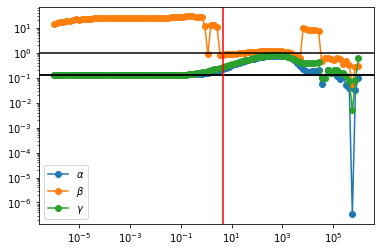

In [17]:
idx = 55
plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\alpha$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\gamma$')
for q in p0:
    plt.axhline(q, color='k')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')
plt.legend()

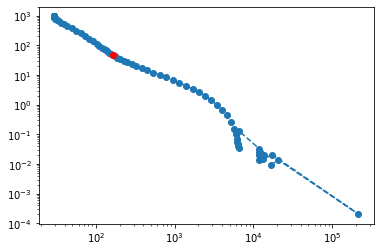

In [18]:
plt.loglog(*fsvals.T, 'o--',)
plt.loglog(*fsvals[idx], 'ro')

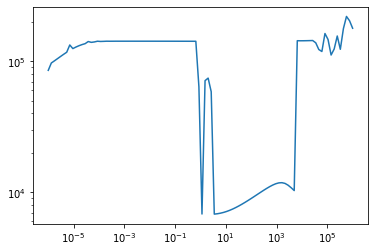

In [19]:
getN = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]).sum(axis=1))
plt.loglog(prange, [getN(i) for i,_ in enumerate(prange)])

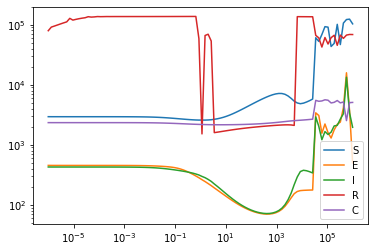

In [20]:
getM = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]), axis=0)
plt.semilogx(prange, [getM(i) for i,_ in enumerate(prange)])
plt.yscale('log')
plt.legend("SEIRC")

In [21]:
# applying the final size relation
from scipy.optimize import brentq
def rinf(sol):
    pfin = np.array([float(p) for p in getp(sol['x'])])
    r0 = pfin[1]/pfin[0]
    S0, E0, I0, R0, C0 = [float(x[0]) for x in getx(sol['x'])]
    N = sum((S0, E0, I0, R0))
    f = lambda y: y/S0 - np.exp(r0*(y-N)/N) 
    sinf = brentq(f, 0, S0) 
    return N-sinf

# def rinf(sol):
#     r0 = 8*getp(sol['x'])
#     S0, E0, I0, R0 = [float(x[0]) for x in getx(sol['x'])]
#     N = sum((S0, E0, I0, R0))
#     f = lambda y: y/S0 - np.exp(r0*(y-N)/N)
#     sinf = brentq(f, 0, S0)
#     return N-sinf

(0, 20000)

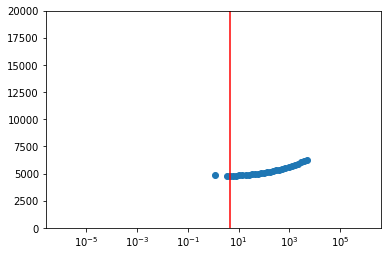

In [22]:
plt.semilogx(prange[:], [rinf(sol) for sol in sols][:], 'o')
plt.axvline(prange[idx], color='r')
plt.ylim([0,20000])

In [23]:
rinf(sols[idx])

4791.909152108969

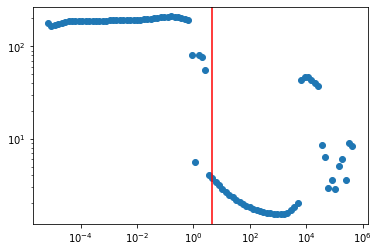

In [24]:
def r0(sol):
    pfin = np.array([float(p) for p in getp(sol['x'])])
    return pfin[1]/pfin[0]
# def r0(sol):
#     return 8*getp(sol['x'])
plt.plot(prange[7:-3], [r0(sol) for sol in sols][7:-3], 'o')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')

In [25]:
[getx(sols[idx]['x'])[i][50] for i in range(5)]

[DM(3617.41), DM(359.744), DM(243.188), DM(379.256), DM(1080.3)]

In [26]:
getx(sols[idx]['x'])[0][0]

DM(4911.81)

In [27]:
getp(sols[idx]['x'])

(DM(0.225271), DM(0.838246), DM(0.27364))

In [28]:
r0(sols[idx])

3.721062378954447

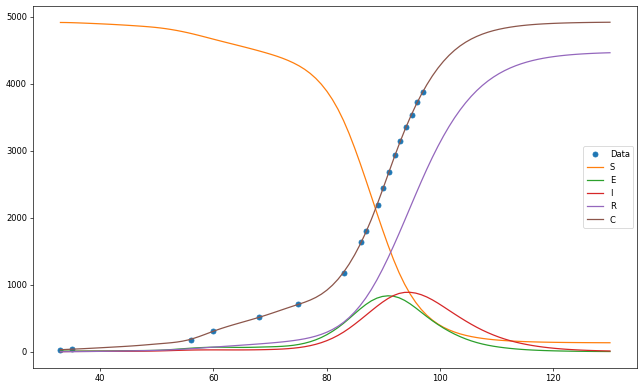

In [29]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
ax.plot(times, cumdata, 'o', label='Data')
ax.plot(model.observation_times, getx(sols[idx]['x'])[0], label='S')
ax.plot(model.observation_times, getx(sols[idx]['x'])[1], label='E')
ax.plot(model.observation_times, getx(sols[idx]['x'])[2], label='I')
ax.plot(model.observation_times, getx(sols[idx]['x'])[3], label='R')
ax.plot(model.observation_times, getx(sols[idx]['x'])[4], label='C')
plt.legend()

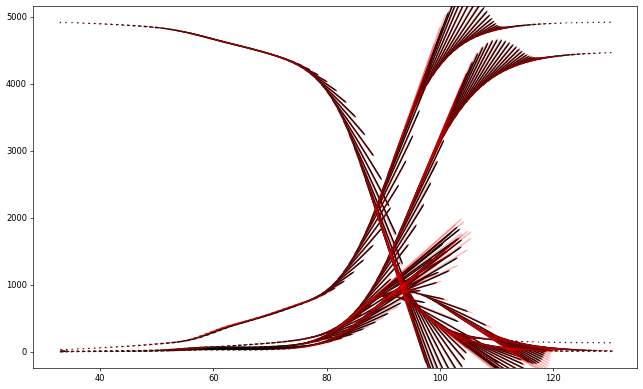

In [30]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
xx = np.vstack([xix.toarray().flatten() for xix in getx(sols[idx]['x'])])
dxxdt = np.vstack([seir(0, xxj, [float(q) for q in getp(sols[idx]['x'])]) for xxj in xx.T])
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, [1]*len(model.observation_times), dxxdt[:,i], 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025)
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, np.gradient(model.observation_times), np.gradient(xxi, model.observation_times), color='r', 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025, alpha=0.3)

Text(0.5, 1.0, 'Number of Reported Cases (Prediction)')

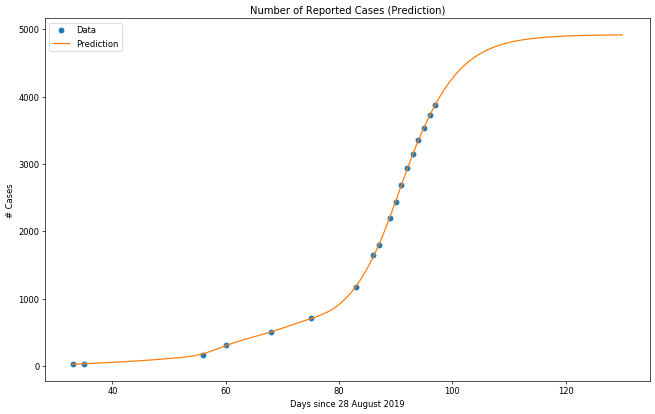

In [80]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)

ax.plot(times, cumdata, 'o', label='Data')
ax.plot(model.observation_times, getx(sols[idx]['x'])[4], label='Prediction')
plt.legend()
plt.xlabel("Days since 28 August 2019")
plt.ylabel("# Cases")
plt.title("Number of Reported Cases (Prediction)")

(0, 10000)

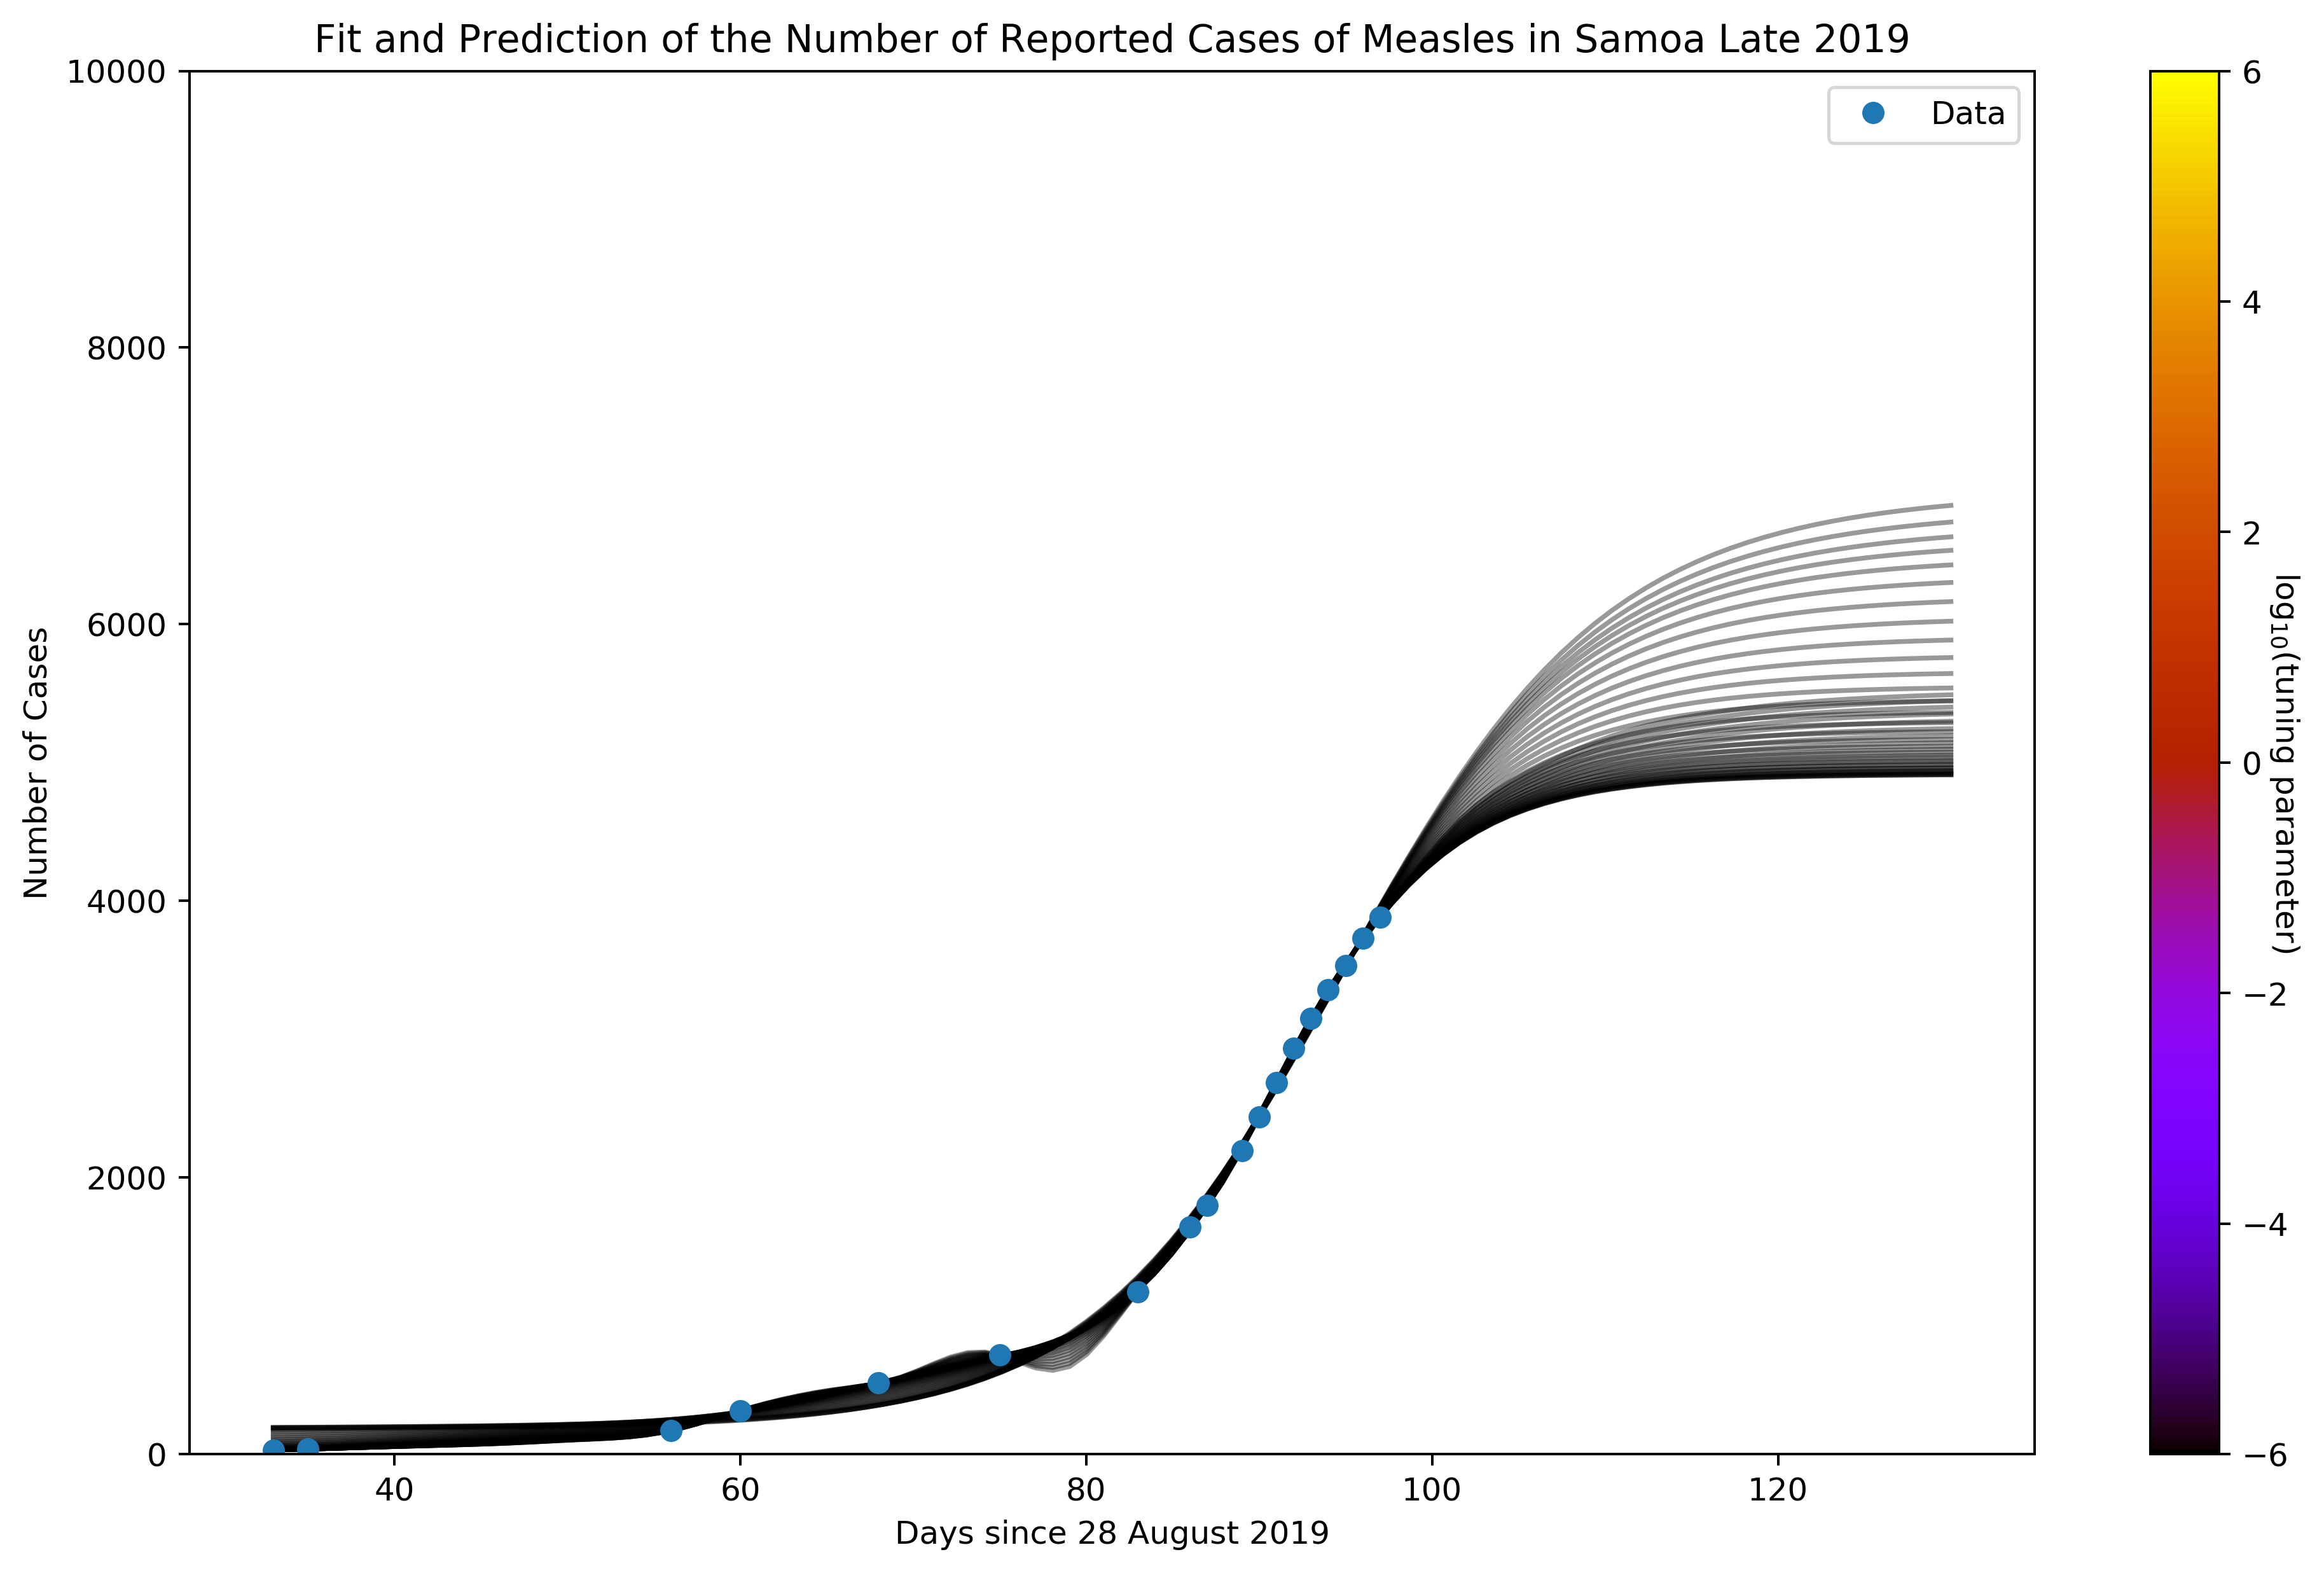

In [93]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors

plt.figure(figsize=[13,8], dpi=360)

cNorm = colors.Normalize(vmin=np.log10(prange[0]), vmax=np.log10(prange[-1]))
cm = plt.get_cmap('gnuplot')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

for i,p in enumerate(prange[40:-15:]):
    plt.plot(model.observation_times, getx(sols[i+40]['x'])[-1], color='k', alpha=0.4)
plt.plot(times, cumdata, 'o', label="Data")
plt.title("Fit and Prediction of the Number of Reported Cases of Measles in Samoa Late 2019")
plt.xlabel("Days since 28 August 2019")
plt.ylabel("Number of Cases")
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.legend()
plt.ylim(0, 10000)

In [32]:
fsvals[idx]

array([163.0319337 ,  47.52794973])

In [33]:
getc = ca.Function('getx', [solver_setup['x']], model.cs)
np.sqrt(ca.sumsqr(cumdata - objective.collocation_matrices[0]@getc(sols[idx]['x'])[-1])/(len(times)-1))

DM(12.7198)

In [34]:
getp(sols[idx]['x'])

(DM(0.225271), DM(0.838246), DM(0.27364))

In [35]:
profiler_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
}
opts = {'ipopt': {'dual_inf_tol': 1e-1, 'print_frequency_iter': 10}}
profiler = ca.nlpsol('solver', 'ipopt', profiler_setup, opts)

In [90]:
rho = prange[idx]
pref = getp(sols[idx]['x'])
lbx = [-np.inf]*(config['basis_number']*config['model_form']['state']) + [0]*config['model_form']['parameters']
ubx = [np.inf]*(config['basis_number']*config['model_form']['state'] + config['model_form']['parameters'])

profiles = []
for pdx in range(config['model_form']['parameters']):
    pdx_mod = config['basis_number']*config['model_form']['state'] + pdx
    pvals = np.logspace(-1.5, 0.5, num=50)
    profiles.append([])
    for pval in pvals:
        lbx0 = np.array(lbx)
        ubx0 = np.array(ubx)
        lbx0[pdx_mod] = pval
        ubx0[pdx_mod] = pval
        profiles[pdx].append(profiler(x0=np.array(sols[idx]['x']).flatten(), p=[rho, alpha], lbx=lbx0, ubx=ubx0))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1761

Total number of variables............................:      122
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  40  4.6251515e+02 0.00e+00 6.46e-06  -8.6 1.35e-01 -11.3 1.00e+00 1.00e+00f  1
  50  4.4628885e+02 0.00e+00 2.44e+00  -8.6 1.18e+01  -4.8 1.00e+00 1.00e+00f  1
  60  2.7390293e+02 0.00e+00 2.82e+01  -8.6 8.46e+00  -5.4 1.00e+00 1.00e+00f  1
  70  2.1616880e+02 0.00e+00 1.06e-01  -8.6 2.07e+00  -4.7 1.00e+00 1.00e+00f  1
  80  2.0465652e+02 0.00e+00 1.98e+00  -8.6 3.84e-01  -4.1 1.00e+00 1.00e+00f  1
  90  1.9752636e+02 0.00e+00 9.34e-01  -8.6 3.42e-01  -4.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.9577510e+02 0.00e+00 1.25e+00  -8.6 4.91e-02  -3.6 1.00e+00 1.00e+00f  1
 110  1.9400631e+02 0.00e+00 3.37e+03  -8.6 5.09e+00  -5.7 5.32e-01 1.00e+00f  1
 120  1.9307766e+02 0.00e+00 9.96e+01  -8.6 4.07e+01  -5.1 1.00e+00 4.83e-03f  3
 130  1.8968697e+02 0.00e+00 2.31e+04  -8.6 2.60e+02    -  1.00e+00 7.19e-02f  4
 140  1.8907875e+02 0.00e+00 1.93e+03  -8.6 5.53e-02  -3.7 1.00e+00 1.00e+00f  1
 150  1.8813990e+02 0.00e+00

 140  1.8735860e+02 0.00e+00 6.09e+03  -8.6 1.29e-01  -4.0 1.00e+00 1.00e+00f  1
 150  1.8514999e+02 0.00e+00 1.44e+02  -8.6 8.63e-03  -2.9 1.00e+00 1.00e+00f  1
 160  1.8503685e+02 0.00e+00 9.33e+02  -8.6 2.23e-02  -3.6 1.00e+00 1.00e+00f  1
 170  1.8488609e+02 0.00e+00 8.57e+01  -8.6 3.38e-01  -4.7 1.00e+00 1.00e+00f  1
 180  1.8460956e+02 0.00e+00 7.35e+02  -8.6 3.82e-03  -2.3 1.00e+00 1.00e+00f  1
 190  1.8452538e+02 0.00e+00 8.76e+00  -8.6 1.70e-02  -3.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.8442112e+02 0.00e+00 2.44e+03  -8.6 4.05e-03  -2.8 1.00e+00 1.00e+00f  1
 210  1.8438087e+02 0.00e+00 8.48e+03  -8.6 5.73e-02  -3.9 1.00e+00 1.00e+00f  1
 220  1.8434761e+02 0.00e+00 3.72e+03  -8.6 1.17e-04  -0.6 1.00e+00 1.00e+00f  1
 230  1.8433771e+02 0.00e+00 1.54e+07  -8.6 2.27e-02  -3.6 1.00e+00 1.00e+00f  1
 240  1.8433573e+02 0.00e+00 2.60e+02  -8.6 6.55e-04  -2.0 1.00e+00 1.00e+00f  1
 250  1.8432940e+02 0.00e+00

1130  1.8162188e+02 0.00e+00 1.61e+02  -9.0 1.55e-07   1.4 1.00e+00 1.19e-07f 24
1140  1.8162188e+02 0.00e+00 4.53e+02  -9.0 4.34e-09   3.0 1.00e+00 1.00e+00f  1
1150  1.8162188e+02 0.00e+00 5.81e+02  -9.0 4.51e-07   0.9 1.00e+00 5.96e-08f 25
1160  1.8162188e+02 0.00e+00 5.81e+02  -9.0 1.09e-07   1.6 1.00e+00 1.86e-09f 30
1170  1.8162188e+02 0.00e+00 1.21e+03  -9.0 6.07e-08   2.2 1.00e+00 1.19e-07f 24
1180  1.8162317e+02 0.00e+00 4.16e+04  -9.0 2.62e-05   2.9 7.64e-01 1.00e+00w  1
1190  1.8162188e+02 0.00e+00 6.10e+02  -9.0 7.87e-08   1.7 1.00e+00 2.38e-07f 23
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  1.8162645e+02 0.00e+00 1.91e+06  -9.0 4.64e-06   3.3 1.00e+00 1.00e+00w  1
1210  1.8162188e+02 0.00e+00 1.63e+03  -9.0 2.62e-10   4.8 1.00e+00 3.81e-06f 19
1220  1.8162190e+02 0.00e+00 2.28e+03  -9.0 1.36e-04   1.9 1.00e+00 1.25e-01f  4
1230  1.8162188e+02 0.00e+00 5.88e+01  -9.0 6.27e-06  -0.2 1.00e+00 9.54e-07f 21
1240  1.8162188e+02 0.00e+00

CasADi - 2019-12-04 11:57:11 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 180  1.9450795e+02 0.00e+00 2.96e+04  -8.6 5.52e-05   0.7 1.00e+00 5.00e-01f  2
 190  1.9447701e+02 0.00e+00 3.54e+05  -8.6 1.37e-01  -4.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.9446177e+02 0.00e+00 1.94e+05  -8.6 2.78e-06   1.1 1.00e+00 1.00e+00F  1
 210  1.9446168e+02 0.00e+00 3.62e+06  -8.6 3.52e-06   3.5 1.00e+00 5.96e-08f 25
 220  1.9911211e+02 0.00e+00 4.54e+11  -8.6 2.87e-08  12.3 1.00e+00 1.00e+00w  1
 230  1.9446093e+02 0.00e+00 4.13e+07  -8.6 8.01e-10   8.4 1.00e+00 2.33e-10f 33
 240  1.9446074e+02 0.00e+00 9.23e+05  -8.6 2.20e-08   7.3 1.00e+00 3.05e-05f 16
 250  1.9445433e+02 0.00e+00 6.68e+09  -8.6 1.98e-08   9.7 1.00e+00 7.63e-06f 18
 260  1.9445053e+02 0.00e+00 7.51e+09  -8.6 3.84e-09  10.4 1.00e+00 1.14e-13f 44
 270  1.9447225e+02 0.00e+00 1.55e+08  -8.6 3.78e-09  10.1 1.00e+00 1.00e+00w  1
 280  1.9444735e+02 0.00e+00 2.47e+10  -8.6 4.40e-09  10.8 1.00e+00 2.84e-14f 46
 290  1.9446039e+02 0.00e+00

CasADi - 2019-12-04 11:57:11 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:12 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:12 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [


 340  1.9442957e+02 0.00e+00 9.86e+09  -8.6 8.59e-09  11.0 1.00e+00 5.68e-14f 45
 350  1.9442957e+02 0.00e+00 9.86e+09  -8.6 8.05e-10  11.7 1.00e+00 4.55e-13f 42
 360  1.9444670e+02 0.00e+00 2.79e+09  -8.6 8.51e-09   9.6 1.00e+00 5.00e-01f  2
 370  1.9446588e+02 0.00e+00 8.54e+09  -8.6 2.20e-09  11.2 1.00e+00 1.00e+00w  1
 380  1.9443181e+02 0.00e+00 3.44e+10  -8.6 8.31e-10  11.8 1.00e+00 1.14e-13f 44
 390  1.9445778e+02 0.00e+00 9.12e+10  -8.6 5.51e-12  14.3 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.9440758e+02 0.00e+00 1.29e+11  -8.6 1.66e-08  12.2 1.00e+00 1.78e-15f 50
 410  1.9446967e+02 0.00e+00 5.62e+11  -8.6 2.09e-10  13.8 1.00e+00 2.50e-01f  3
 420  1.9441148e+02 0.00e+00 1.39e+11  -8.6 3.89e-09  10.8 1.00e+00 2.84e-14f 46
 430  1.9957819e+02 0.00e+00 2.04e+12  -8.6 2.92e-10  16.0 1.00e+00 1.00e+00S 21
 440  1.9632020e+02 0.00e+00 6.70e+12  -8.6 6.78e-12  13.0 1.00e+00 1.14e-13f 44


.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:12 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:12 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:12 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:12 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:12 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:12 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:12 WARNING("solver:nlp_f failed: Inf de

 450  1.9601190e+02 0.00e+00 6.79e+12  -8.6 3.80e-08   8.2 1.00e+00 1.14e-13f 44
 460  1.9487271e+02 0.00e+00 1.22e+11  -8.6 9.31e-10   7.1 1.00e+00 4.55e-13f 42
 470  1.9469672e+02 0.00e+00 5.24e+11  -8.6 1.08e-09   5.9 1.00e+00 1.14e-13f 44
 480  2.0378126e+02 0.00e+00 9.87e+12  -8.6 2.56e-07   6.6 1.00e+00 1.00e+00w  1
 490  1.9530481e+02 0.00e+00 6.23e+12  -8.6 3.34e-10  12.1 1.00e+00 1.14e-13f 44
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.9506745e+02 0.00e+00 6.79e+12  -8.6 2.08e-08  13.7 1.00e+00 2.78e-17f 56
 510  1.9490043e+02 0.00e+00 5.20e+12  -8.6 3.17e-10   9.8 1.00e+00 1.00e+00w  1
 520  1.9477771e+02 0.00e+00 6.15e+12  -8.6 1.39e-09   6.8 1.00e+00 2.84e-14f 46
 530  1.9448485e+02 0.00e+00 1.85e+12  -8.6 5.47e-09   5.7 1.00e+00 3.91e-03f  9
 540  1.9445390e+02 0.00e+00 3.90e+11  -8.6 1.82e-13  18.8 1.00e+00 2.50e-01f  3
 550  1.9508425e+02 0.00e+00 1.66e+12  -8.6 4.48e-11  14.1 1.00e+00 1.00e+00w  1
 560  1.9443986e+02 0.00e+00

CasADi - 2019-12-04 11:57:12 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:12 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:12 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:12 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:12 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 570  1.9459099e+02 0.00e+00 3.05e+08  -8.6 2.79e-11  14.8 1.00e+00 3.81e-06f 19
 580  1.9459099e+02 0.00e+00 3.05e+08  -8.6 7.86e-10  10.1 1.00e+00 1.16e-10f 34
 590  1.9456674e+02 0.00e+00 2.74e+10  -8.6 3.07e-10  14.5 1.00e+00 4.55e-13f 42
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.9448807e+02 0.00e+00 2.34e+11  -8.6 6.58e-11  14.3 1.00e+00 1.00e+00f  1
 610  1.9443132e+02 0.00e+00 9.09e+11  -8.6 1.67e-08  11.3 1.00e+00 8.88e-16f 51
 620  1.9447229e+02 0.00e+00 3.54e+09  -8.6 7.84e-11  11.9 1.00e+00 1.56e-02f  7
 630  1.9445952e+02 0.00e+00 4.81e+08  -8.6 2.84e-08   8.1 1.00e+00 5.00e-01f  2
 640  1.9446172e+02 0.00e+00 7.06e+05  -8.6 8.78e-09   6.9 1.00e+00 1.00e+00w  1
 650  1.9446116e+02 0.00e+00 1.08e+07  -8.6 4.42e-07   5.8 1.00e+00 1.91e-06f 20
 660  1.9445861e+02 0.00e+00 1.05e+09  -8.6 2.84e-08   8.2 1.00e+00 2.27e-13f 43
 670  1.9445861e+02 0.00e+00 1.05e+09  -8.6 8.43e-08   8.0 1.00e+00 5.68e-14f 45
 680  1.9445706e+02 0.00e+00

CasADi - 2019-12-04 11:57:12 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:12 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:12 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:12 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:12 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:12 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:12 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 870  1.9446051e+02 0.00e+00 1.18e+10  -8.6 6.59e-10  11.0 1.00e+00 1.00e+00w  1
 880  1.9442553e+02 0.00e+00 1.15e+10  -8.6 1.97e-09  11.6 1.00e+00 1.14e-13f 44
 890  1.9444231e+02 0.00e+00 3.97e+10  -8.6 1.64e-09  11.4 1.00e+00 7.81e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900  1.9443615e+02 0.00e+00 5.96e+08  -8.6 3.23e-13  17.6 1.00e+00 5.00e-01f  2
 910  1.9441126e+02 0.00e+00 3.85e+10  -8.6 1.54e-10  12.8 1.00e+00 4.55e-13f 42
 920  1.9456022e+02 0.00e+00 1.82e+11  -8.6 4.08e-13  18.2 1.00e+00 5.00e-01f  2
 930  1.9447466e+02 0.00e+00 1.65e+11  -8.6 1.81e-10  13.4 1.00e+00 1.14e-13f 44
 940  1.9473371e+02 0.00e+00 1.22e+10  -8.6 4.98e-11  15.0 1.00e+00 1.00e+00f  1
 950  1.9454855e+02 0.00e+00 2.30e+11  -8.6 2.44e-08  11.1 1.00e+00 1.25e-01f  4
 960  1.9450870e+02 0.00e+00 1.14e+10  -8.6 1.79e-09  10.9 1.00e+00 9.09e-13f 40
 970  1.9510905e+02 0.00e+00 1.86e+12  -8.6 1.04e-08  12.4 1.00e+00 1.00e+00w  1
 980  1.9458852e+02 0.00e+00

CasADi - 2019-12-04 11:57:13 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:13 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 990  1.9484281e+02 0.00e+00 8.72e+11  -8.6 1.52e-11  14.6 1.00e+00 4.55e-13f 42
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.9452459e+02 0.00e+00 4.90e+11  -8.6 2.70e-09  12.5 1.00e+00 7.11e-15f 48
1010  1.9445568e+02 0.00e+00 1.37e+12  -8.6 4.03e-10  10.5 1.00e+00 2.50e-01f  3
1020  2.3097245e+06 0.00e+00 3.59e+17  -8.6 9.16e-09  12.0 1.00e+00 1.00e+00w  1
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1020

                                   (scaled)                 (unscaled)
Objective...............:   1.5147172551323922e+03    2.3097244826954319e+06
Dual infeasibility......:   3.5942716096774035e+17    5.4807437534626952e+20
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    3.8211400731424190e-06
Overall NLP error.......:   3.5942716096774035e+17    5.4807437534626952e+20


Number of objective function

CasADi - 2019-12-04 11:57:13 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:14 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:14 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:14 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 380  1.8521852e+02 0.00e+00 9.33e+10  -8.6 1.62e-10  13.2 1.00e+00 1.00e+00f  1
 390  1.8501258e+02 0.00e+00 1.78e+12  -8.6 4.67e-09  12.0 1.00e+00 7.11e-15f 48
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.8504504e+02 0.00e+00 9.43e+11  -8.6 1.30e-09  12.6 1.00e+00 1.42e-14f 47
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 409

                                   (scaled)                 (unscaled)
Objective...............:   9.6344411631612275e+01    1.4216988216968172e+05
Dual infeasibility......:   7.0163049575035320e+16    1.0353555875030445e+20
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    3.6978171102495368e-06
Overall NLP error.......:   7.0163049575035320e+16    1.0353555875030445e+20


Number of objective function evaluations             = 6344
Number of objective gradient evaluations          

CasADi - 2019-12-04 11:57:14 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:14 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:14 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


  10  4.4889991e+02 0.00e+00 7.13e-01  -2.5 7.54e+01  -7.8 1.00e+00 5.00e-01f  2
  20  4.4766825e+02 0.00e+00 6.98e-05  -8.6 3.97e+02 -12.1 1.00e+00 1.00e+00f  1
  30  4.4660353e+02 0.00e+00 1.36e-02  -8.6 1.86e+01  -8.8 1.00e+00 1.00e+00f  1
  40  4.3492736e+02 0.00e+00 3.51e+00  -8.6 5.31e+01  -7.2 1.00e+00 1.00e+00f  1
  50  3.5377707e+02 0.00e+00 4.37e+01  -8.6 5.86e+01  -6.6 1.00e+00 1.00e+00f  1
  60  2.4942224e+02 0.00e+00 4.37e+00  -8.6 1.85e+01  -5.9 1.00e+00 1.00e+00f  1
  70  1.9747264e+02 0.00e+00 5.44e+01  -8.6 1.03e+01  -5.6 1.00e+00 5.00e-01f  2
  80  1.9087811e+02 0.00e+00 8.26e+01  -8.6 1.31e+00  -4.1 1.00e+00 5.00e-01f  2
  90  1.8778051e+02 0.00e+00 3.58e+01  -8.6 9.64e-02  -3.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.8721385e+02 0.00e+00 8.89e+00  -8.6 1.24e-01  -4.1 1.00e+00 1.00e+00f  1
 110  1.8678800e+02 0.00e+00 6.42e+02  -8.6 2.26e-01  -4.4 1.00e+00 1.00e+00f  1
 120  1.8659620e+02 0.00e+00

CasADi - 2019-12-04 11:57:15 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:15 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:15 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:15 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:15 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:15 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 


 390  1.8619259e+02 0.00e+00 7.73e+11  -8.6 2.03e-07   8.2 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.8594014e+02 0.00e+00 2.25e+11  -8.6 6.08e-09  10.7 1.00e+00 1.95e-03f 10
 410  1.8722855e+02 0.00e+00 1.03e+13  -8.6 2.56e-09   9.5 1.00e+00 1.00e+00w  1
 420  1.8583182e+02 0.00e+00 7.94e+09  -8.6 4.60e-09  12.0 1.00e+00 4.55e-13f 42
 430  1.9432633e+02 0.00e+00 3.18e+13  -8.6 2.03e-11  15.3 1.00e+00 1.00e+00f  1
 440  1.8825768e+02 0.00e+00 1.17e+12  -8.6 3.17e-08  11.5 1.00e+00 7.11e-15f 48
 450  1.8819725e+02 0.00e+00 5.80e+11  -8.6 1.82e-11  14.8 1.00e+00 4.55e-13f 42
 460  1.9170481e+02 0.00e+00 8.06e+10  -8.6 1.94e-10  15.5 1.00e+00 1.00e+00w  1
 470  1.8792251e+02 0.00e+00 7.64e+10  -8.6 3.19e-10  12.5 1.00e+00 5.00e-01f  2
 480  1.8781487e+02 0.00e+00 2.20e+11  -8.6 6.44e-07  10.5 1.00e+00 4.44e-16f 52
 490  1.8781487e+02 0.00e+00 2.20e+11  -8.6 6.83e-09  11.1 1.00e+00 2.84e-14f 46
iter    objective    inf_pr

2019-12-04 11:57:15 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:15 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:15 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:15 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:15 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:15 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:15 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

 520  1.8784996e+02 0.00e+00 1.37e+11  -8.6 1.58e-06   7.8 1.00e+00 1.78e-15f 50
 530  1.8842320e+02 0.00e+00 2.05e+09  -8.6 7.73e-10  13.0 1.00e+00 1.00e+00f  1
 540  1.8790854e+02 0.00e+00 3.70e+09  -8.6 4.62e-08   8.2 1.00e+00 1.00e+00f  1
 550  1.8787909e+02 0.00e+00 1.40e+10  -8.6 8.43e-08   9.8 1.00e+00 5.68e-14f 45
 560  1.8786896e+02 0.00e+00 3.92e+10  -8.6 6.50e-09  10.4 1.00e+00 2.27e-13f 43
 570  1.8782434e+02 0.00e+00 1.11e+11  -8.6 2.97e-10  12.0 1.00e+00 9.77e-04f 11
 580  1.8799368e+02 0.00e+00 8.56e+10  -8.6 2.88e-09   9.9 1.00e+00 1.00e+00w  1
 590  1.8788222e+02 0.00e+00 2.46e+11  -8.6 2.08e-07   9.6 1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.8784723e+02 0.00e+00 1.68e+11  -8.6 4.02e-11  13.9 1.00e+00 4.55e-13f 42
 610  1.9484039e+02 0.00e+00 3.84e+13  -8.6 1.40e-10  16.4 1.00e+00 1.00e+00w  1
 620  1.8787495e+02 0.00e+00 7.12e+11  -8.6 3.21e-10  12.5 1.00e+00 5.68e-14f 45
 630  1.8774264e+02 0.00e+00

CasADi - 2019-12-04 11:57:15 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:15 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 660  1.8768732e+02 0.00e+00 1.07e+12  -8.6 4.59e-09  12.4 1.00e+00 1.78e-15f 50
 670  1.8920106e+02 0.00e+00 4.59e+10  -8.6 1.61e-09  12.1 1.00e+00 1.00e+00f  1
 680  1.8788098e+02 0.00e+00 8.74e+09  -8.6 1.19e-08  10.0 1.00e+00 2.44e-04f 13
 690  1.8785074e+02 0.00e+00 4.32e+11  -8.6 1.62e-08  10.7 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.8821919e+02 0.00e+00 2.73e+11  -8.6 5.98e-09  11.3 1.00e+00 1.00e+00w  1
 710  1.8779993e+02 0.00e+00 2.99e+11  -8.6 1.27e-10  12.9 1.00e+00 2.27e-13f 43
 720  1.8788485e+02 0.00e+00 1.10e+12  -8.6 1.52e-12  16.4 1.00e+00 1.25e-01f  4
 730  1.8773411e+02 0.00e+00 5.98e+08  -8.6 1.80e-10  11.7 1.00e+00 1.95e-03f  9
 740  2.2931300e+02 0.00e+00 1.19e+14  -8.6 1.62e-08  11.4 1.00e+00 1.00e+00w  1
 750  1.8773383e+02 0.00e+00 4.90e+10  -8.6 2.06e-10  13.0 1.00e+00 9.09e-13f 41
 760  1.8804519e+02 0.00e+00 1.68e+12  -8.6 1.63e-09  12.7 1.00e+00 5.68e-14f 45
 770  1.9231125e+02 0.00e+00

CasADi - 2019-12-04 11:57:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 820  2.2187355e+02 0.00e+00 1.25e+14  -8.6 3.22e-09   7.8 1.00e+00 1.56e-02f  7
 830  2.0477190e+02 0.00e+00 4.21e+12  -8.6 7.62e-09   7.5 1.00e+00 4.55e-13f 42
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 837

                                   (scaled)                 (unscaled)
Objective...............:   3.7052592311700638e-01    5.0472666991400001e+02
Dual infeasibility......:   2.8878384575811270e+15    3.9337843778456131e+18
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800349e-09    3.4135165177188948e-06
Overall NLP error.......:   2.8878384575811270e+15    3.9337843778456131e+18


Number of objective function evaluations             = 15199
Number of objective gradient evaluations             = 838
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian

 530  1.7733831e+02 0.00e+00 6.00e+01  -5.7 9.96e-09   2.6 1.00e+00 1.19e-07f 24
 540  1.7733831e+02 0.00e+00 9.22e+02  -5.7 2.70e-07   2.3 1.00e+00 1.00e+00w  1
 550  1.7733831e+02 0.00e+00 6.00e+01  -5.7 2.31e-06   0.3 1.00e+00 2.33e-10f 33
 560  1.7733831e+02 0.00e+00 6.00e+01  -5.7 9.12e-10   3.6 1.00e+00 9.54e-07f 21
 570  1.7733831e+02 0.00e+00 6.00e+01  -5.7 1.05e-07   1.5 1.00e+00 7.45e-09f 28
 580  1.7733831e+02 0.00e+00 2.11e+03  -5.7 1.00e-06   1.3 1.00e+00 1.00e+00w  1
 590  1.7733831e+02 0.00e+00 6.00e+01  -5.7 3.41e-07   1.0 1.00e+00 3.73e-09f 29
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.7733831e+02 0.00e+00 6.00e+01  -5.7 6.13e-07   0.8 1.00e+00 1.86e-09f 30
 610  1.7733831e+02 0.00e+00 3.52e+02  -5.7 6.71e-11   5.0 1.00e+00 1.95e-03f 10
 620  1.7733831e+02 0.00e+00 7.45e+01  -5.7 2.10e-07   2.1 1.00e+00 1.00e+00w  1
 630  1.7733831e+02 0.00e+00 3.52e+02  -5.7 2.51e-05   0.9 1.00e+00 7.28e-12f 38
 640  1.7733831e+02 0.00e+00

CasADi - 2019-12-04 11:57:17 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:17 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:18 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:18 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1230  1.7667514e+02 0.00e+00 1.05e+11  -5.7 4.19e-09  12.3 1.00e+00 6.25e-02f  5
1240  1.7670627e+02 0.00e+00 1.17e+10  -5.7 6.88e-10  11.2 1.00e+00 1.00e+00f  1
1250  1.7655684e+02 0.00e+00 2.01e+11  -5.7 2.04e-08  12.7 1.00e+00 8.88e-16f 51
1260  1.7666375e+02 0.00e+00 6.35e+11  -5.7 1.03e-11  15.2 1.00e+00 1.00e+00f  1
1270  1.7665519e+02 0.00e+00 3.96e+11  -5.7 3.03e-10  14.0 1.00e+00 2.84e-14f 46
1280  1.7656895e+02 0.00e+00 1.89e+11  -5.7 4.50e-10  13.8 1.00e+00 4.88e-04f 12
1290  3.4467326e+03 0.00e+00 5.05e+13  -5.7 2.65e-10  18.9 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  1.7698633e+02 0.00e+00 2.84e+12  -5.7 6.00e-11  15.1 1.00e+00 2.84e-14f 46
1310  9.8483480e+02 0.00e+00 4.77e+13  -5.7 8.79e-11  18.6 1.00e+00 1.00e+00S 21
1320  2.6036530e+02 0.00e+00 9.86e+14  -5.7 1.16e-10  16.6 1.00e+00 5.55e-17f 55
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1321



CasADi - 2019-12-04 11:57:18 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:18 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:18 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:18 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:18 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:18 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:18 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

  50  3.0504785e+02 0.00e+00 4.38e+01  -8.6 2.25e+01  -5.6 1.00e+00 1.00e+00f  1
  60  2.2268481e+02 0.00e+00 2.62e+02  -8.6 4.40e+01  -5.9 1.00e+00 5.00e-01f  2
  70  1.9041005e+02 0.00e+00 2.33e+00  -8.6 4.83e-01  -4.3 1.00e+00 1.00e+00f  1
  80  1.8012661e+02 0.00e+00 1.60e+03  -8.6 4.86e+02    -  1.00e+00 1.63e-02f  3
  90  1.7799053e+02 0.00e+00 2.29e+00  -8.6 2.59e-02  -3.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.7711608e+02 0.00e+00 6.92e+01  -8.6 2.48e-01  -4.4 1.00e+00 1.00e+00f  1
 110  1.7676078e+02 0.00e+00 6.05e+02  -8.6 1.49e-02  -2.8 1.00e+00 1.00e+00f  1
 120  1.7667189e+02 0.00e+00 2.12e+02  -8.6 3.59e-03  -2.6 1.00e+00 1.00e+00f  1
 130  1.7663804e+02 0.00e+00 2.82e+01  -8.6 4.64e-02  -3.7 1.00e+00 1.00e+00f  1
 140  1.7656457e+02 0.00e+00 1.31e+04  -8.6 2.02e-02  -2.2 1.00e+00 3.15e-01f  2
 150  1.7656045e+02 0.00e+00 6.83e+02  -8.6 1.91e-03   0.3 1.00e+00 4.18e-02f  3
 160  1.7655919e+02 0.00e+00

CasADi - 2019-12-04 11:57:18 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:18 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:18 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:18 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:18 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:18 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:18 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

Complementarity.........:   2.5059035596800618e-09    3.0704246549236023e-06
Overall NLP error.......:   4.9123160401196970e+15    6.0189452319888507e+18


Number of objective function evaluations             = 5382
Number of objective gradient evaluations             = 358
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 358
Total CPU secs in IPOPT (w/o function evaluations)   =      0.278
Total CPU secs in NLP function evaluations           =      0.289

EXIT: Error in step computation (regularization becomes too large?)!
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 140.78ms ( 26.16us) 139.52ms ( 25.92us)      5382
    nlp_grad  |  59.00us ( 59.00us)  58.27us ( 58.27us)         1
  nlp_grad_f  |  18.88ms ( 52.59us)  1

CasADi - 2019-12-04 11:57:19 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:19 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:19 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:19 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:19 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:19 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:19 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 315

                                   (scaled)                 (unscaled)
Objective...............:   4.1089954758245305e+01    4.7111386099826850e+04
Dual infeasibility......:   5.9975170188309820e+15    6.8764091266790881e+18
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    2.8731253374117694e-06
Overall NLP error.......:   5.9975170188309820e+15    6.8764091266790881e+18


Number of objective function evaluations             = 3556
Number of objective gradient evaluations             = 316
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 316
Total CPU secs in IPOPT (w/o

 750  1.6970000e+02 0.00e+00 1.35e+00  -5.7 1.04e-03  -7.8 1.00e+00 1.46e-11f 37
 760  1.6970000e+02 0.00e+00 5.63e-02  -5.7 2.92e-04  -8.0 1.00e+00 2.91e-11f 36
 770  5.4989583e+07 0.00e+00 2.52e+08  -5.7 5.44e-01   5.6 1.00e+00 1.00e+00f  1
 780  9.1940869e+05 0.00e+00 2.47e+08  -5.7 1.17e-03   7.1 1.00e+00 1.00e+00f  1
 790  8.2977013e+05 0.00e+00 1.27e+08  -5.7 5.18e-06   6.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  8.2867194e+05 0.00e+00 7.50e+06  -5.7 3.87e-03   2.1 1.00e+00 1.00e+00f  1
 810  8.2412844e+05 0.00e+00 4.80e+08  -5.7 3.01e-04   7.3 1.00e+00 5.00e-01f  2
 820  7.5651507e+05 0.00e+00 4.36e+07  -5.7 1.50e-05   8.8 1.00e+00 1.00e+00f  1
 830  7.5512967e+05 0.00e+00 1.79e+04  -5.7 1.67e-04   4.1 1.00e+00 1.00e+00f  1
 840  7.5497609e+05 0.00e+00 2.37e+06  -5.7 2.62e-07  11.0 1.00e+00 1.00e+00f  1
 850  7.5456047e+05 0.00e+00 7.30e+03  -5.7 2.97e-09   9.9 1.00e+00 1.00e+00f  1
 860  7.5456046e+05 0.00e+00

1740  7.4602959e+05 0.00e+00 8.64e+03  -5.7 3.59e-04   2.0 1.00e+00 1.00e+00f  1
1750  7.4602377e+05 0.00e+00 5.32e+04  -5.7 5.18e-03   0.8 1.00e+00 1.00e+00f  1
1760  7.4601905e+05 0.00e+00 3.91e+04  -5.7 4.37e-04   1.9 1.00e+00 1.00e+00f  1
1770  7.4601313e+05 0.00e+00 1.54e+04  -5.7 7.88e-04   1.7 1.00e+00 1.00e+00f  1
1780  7.4600804e+05 0.00e+00 2.17e+04  -5.7 1.42e-03   1.4 1.00e+00 1.00e+00f  1
1790  7.4600416e+05 0.00e+00 5.82e+03  -5.7 2.56e-03   1.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800  7.4600140e+05 0.00e+00 2.25e+04  -5.7 1.73e-03   1.3 1.00e+00 1.00e+00f  1
1810  7.4599831e+05 0.00e+00 2.19e+04  -5.7 3.12e-03   1.1 1.00e+00 1.00e+00f  1
1820  7.4599079e+05 0.00e+00 3.39e+04  -5.7 2.37e-03   1.2 1.00e+00 1.00e+00f  1
1830  7.4598470e+05 0.00e+00 4.55e+04  -5.7 1.60e-03   1.3 1.00e+00 1.00e+00f  1
1840  7.4597897e+05 0.00e+00 6.54e+04  -5.7 2.88e-03   1.1 1.00e+00 1.00e+00f  1
1850  7.4597353e+05 0.00e+00

2750  7.4560384e+05 0.00e+00 2.49e+04  -5.7 1.00e-03   1.5 1.00e+00 1.00e+00f  1
2760  7.4560044e+05 0.00e+00 1.18e+05  -5.7 1.80e-03   1.3 1.00e+00 1.00e+00f  1
2770  7.4559660e+05 0.00e+00 5.32e+04  -5.7 1.37e-03   1.4 1.00e+00 1.00e+00f  1
2780  7.4559183e+05 0.00e+00 3.26e+04  -5.7 2.47e-03   1.2 1.00e+00 1.00e+00f  1
2790  7.4558844e+05 0.00e+00 1.03e+05  -5.7 1.67e-03   1.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2800  7.4558519e+05 0.00e+00 3.14e+04  -5.7 1.13e-03   1.5 1.00e+00 1.00e+00f  1
2810  7.4558261e+05 0.00e+00 3.06e+04  -5.7 2.29e-03   1.2 1.00e+00 1.00e+00f  1
2820  7.4557947e+05 0.00e+00 8.91e+03  -5.7 1.74e-03   1.3 1.00e+00 1.00e+00f  1
2830  7.4557612e+05 0.00e+00 8.00e+04  -5.7 3.52e-03   1.0 1.00e+00 1.00e+00f  1
2840  7.4557387e+05 0.00e+00 7.13e+04  -5.7 2.97e-04   2.1 1.00e+00 1.00e+00f  1
2850  7.4557091e+05 0.00e+00 3.19e+04  -5.7 6.03e-04   1.8 1.00e+00 1.00e+00f  1
2860  7.4556639e+05 0.00e+00

 160  1.7955868e+02 0.00e+00 1.74e+02  -5.7 7.96e-02  -3.8 1.00e+00 1.00e+00f  1
 170  1.7925575e+02 0.00e+00 2.43e+03  -5.7 1.12e+00  -5.0 1.00e+00 1.00e+00f  1
 180  1.7916594e+02 0.00e+00 1.18e+02  -5.7 3.09e-02  -3.4 1.00e+00 1.00e+00f  1
 190  1.7905115e+02 0.00e+00 6.01e+03  -5.7 4.51e-01  -4.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.7895713e+02 0.00e+00 8.49e+02  -5.7 9.96e-02  -3.9 1.00e+00 1.00e+00f  1
 210  1.7883450e+02 0.00e+00 1.89e+04  -5.7 2.06e-02  -3.3 1.00e+00 1.00e+00f  1
 220  1.7874723e+02 0.00e+00 8.31e+01  -5.7 3.18e-01  -4.4 1.00e+00 1.00e+00f  1
 230  1.7863330e+02 0.00e+00 1.93e+03  -5.7 6.95e-02  -3.8 1.00e+00 1.00e+00f  1
 240  1.7850795e+02 0.00e+00 9.45e+02  -5.7 1.27e-01  -4.0 1.00e+00 1.00e+00f  1
 250  1.7845265e+02 0.00e+00 3.27e+03  -5.7 2.27e-01  -4.3 1.00e+00 1.00e+00f  1
 260  1.7840860e+02 0.00e+00 2.65e+02  -5.7 5.07e-02  -3.6 1.00e+00 1.00e+00f  1
 270  1.7830293e+02 0.00e+00

 170  1.8526971e+02 0.00e+00 7.24e+04  -5.7 4.32e-02  -1.4 1.00e+00 1.03e-01f  2
 180  1.8508353e+02 0.00e+00 1.21e+04  -5.7 4.73e-03  -1.7 1.00e+00 1.00e+00f  1
 190  1.8493677e+02 0.00e+00 8.93e+02  -5.7 4.78e-03  -1.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.8474465e+02 0.00e+00 1.21e+03  -5.7 1.78e-01  -4.0 1.00e+00 1.00e+00f  1
 210  1.8455029e+02 0.00e+00 1.25e+03  -5.7 7.98e-03  -2.4 1.00e+00 1.00e+00f  1
 220  1.8436701e+02 0.00e+00 5.44e+02  -5.7 7.12e-02  -3.6 1.00e+00 1.00e+00f  1
 230  1.8400424e+02 0.00e+00 2.45e+04  -5.7 1.15e+00  -4.7 5.11e-01 1.00e+00f  1
 240  1.8391078e+02 0.00e+00 1.01e+03  -5.7 2.27e-01  -4.1 1.00e+00 1.00e+00f  1
 250  1.8379421e+02 0.00e+00 2.20e+02  -5.7 5.13e-02  -3.4 1.00e+00 1.00e+00f  1
 260  1.8363655e+02 0.00e+00 1.82e+04  -5.7 7.43e-01  -4.6 1.00e+00 1.00e+00f  1
 270  1.8357732e+02 0.00e+00 3.57e+02  -5.7 2.07e-02  -3.1 1.00e+00 1.00e+00f  1
 280  1.8350137e+02 0.00e+00

1300  1.7562189e+02 0.00e+00 1.03e-02  -5.7 5.87e-07   3.3 1.00e+00 1.00e+00f  1
1310  1.7562187e+02 0.00e+00 5.14e-03  -5.7 2.94e-04  -1.5 1.00e+00 1.00e+00f  1
1320  1.7542843e+02 0.00e+00 1.93e+02  -5.7 1.01e-02  -2.2 1.00e+00 1.00e+00f  1
1330  1.7353598e+02 0.00e+00 3.93e+01  -5.7 6.58e-04  -1.0 1.00e+00 1.00e+00f  1
1340  1.7353004e+02 0.00e+00 2.04e-01  -5.7 2.14e-05   1.4 1.00e+00 1.00e+00f  1
1350  1.7352582e+02 0.00e+00 1.71e+02  -5.7 3.81e-02  -3.4 1.00e+00 1.00e+00f  1
1360  1.7284609e+02 0.00e+00 1.11e+02  -5.7 9.45e-04  -1.3 1.00e+00 1.00e+00f  1
1370  1.7251057e+02 0.00e+00 2.37e-02  -5.7 6.91e-05   0.7 1.00e+00 1.00e+00f  1
1380  1.7251052e+02 0.00e+00 2.47e-02  -5.7 4.53e-05   0.4 1.00e+00 1.00e+00f  1
1390  1.7232302e+02 0.00e+00 4.54e+02  -5.7 1.31e-02  -1.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  1.7222221e+02 0.00e+00 5.20e+01  -5.7 5.47e-02  -3.6 1.00e+00 1.00e+00f  1
1410  1.7216994e+02 0.00e+00

2300  1.6904663e+02 0.00e+00 1.44e+02  -5.7 3.69e-01  -5.4 1.00e+00 1.00e+00f  1
2310  1.6902990e+02 0.00e+00 1.24e+04  -5.7 2.89e-02  -3.9 1.00e+00 1.00e+00f  1
2320  1.6901170e+02 0.00e+00 3.78e+03  -5.7 4.54e-02  -4.6 1.00e+00 1.00e+00f  1
2330  1.6899823e+02 0.00e+00 1.07e+04  -5.7 1.85e-02  -4.3 1.00e+00 1.00e+00f  1
2340  1.6898893e+02 0.00e+00 1.24e+04  -5.7 1.54e-01  -4.6 1.00e+00 2.50e-01f  3
2350  1.6897610e+02 0.00e+00 1.61e+03  -5.7 7.10e-02  -4.9 1.00e+00 1.00e+00f  1
2360  1.6895482e+02 0.00e+00 1.76e+04  -5.7 2.12e-02  -3.7 1.00e+00 1.00e+00f  1
2370  1.6894252e+02 0.00e+00 8.10e+03  -5.7 5.29e-01  -5.8 1.00e+00 1.00e+00f  1
2380  1.6891851e+02 0.00e+00 2.14e+02  -5.7 6.33e-03  -3.8 1.00e+00 1.00e+00f  1
2390  1.6890732e+02 0.00e+00 6.11e+02  -5.7 2.11e-02  -4.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400  1.6889168e+02 0.00e+00 5.01e+03  -5.7 4.44e-01  -4.7 1.00e+00 1.71e-01f  3
2410  1.6888363e+02 0.00e+00

 170  1.8268807e+02 0.00e+00 1.30e+04  -8.6 1.49e-03  -1.0 1.00e+00 1.00e+00f  1
 180  1.8247269e+02 0.00e+00 5.36e+04  -8.6 4.56e-03  -1.3 1.00e+00 1.00e+00f  1
 190  1.8236190e+02 0.00e+00 5.13e+02  -8.6 5.43e-03  -2.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.8223648e+02 0.00e+00 4.19e+04  -8.6 6.96e-01  -4.5 4.12e-01 1.00e+00f  1
 210  1.8209700e+02 0.00e+00 5.32e+03  -8.6 2.32e-02  -2.9 1.00e+00 5.00e-01f  2
 220  1.8202742e+02 0.00e+00 4.53e+02  -8.6 3.10e-02  -3.2 1.00e+00 1.00e+00f  1
 230  1.8197715e+02 0.00e+00 3.68e+05  -8.6 5.91e-03  -1.7 1.00e+00 1.49e-01f  2
 240  1.8197697e+02 0.00e+00 7.12e+06  -8.6 9.50e-06   2.6 1.00e+00 5.00e-01f  2
 250  1.8197413e+02 0.00e+00 4.38e+08  -8.6 2.48e-08   8.7 1.00e+00 1.53e-05f 17
 260  1.8196930e+02 0.00e+00 5.08e+09  -8.6 3.82e-09  10.2 1.00e+00 3.05e-05f 16
 270  1.8198149e+02 0.00e+00 1.33e+09  -8.6 9.74e-09   9.1 1.00e+00 1.00e+00w  1
 280  1.8196145e+02 0.00e+00

 510  1.8082382e+02 0.00e+00 8.09e+01  -5.7 1.66e-01  -3.9 1.00e+00 1.00e+00f  1
 520  1.8073235e+02 0.00e+00 3.11e+03  -5.7 2.98e-01  -4.1 1.00e+00 1.00e+00f  1
 530  1.8062741e+02 0.00e+00 5.04e+03  -5.7 5.33e-01  -4.4 1.00e+00 1.00e+00f  1
 540  1.8054279e+02 0.00e+00 8.06e+02  -5.7 1.19e-01  -3.7 1.00e+00 1.00e+00f  1
 550  1.8047961e+02 0.00e+00 4.84e+02  -5.7 3.50e-03  -2.2 1.00e+00 1.00e+00f  1
 560  1.8037329e+02 0.00e+00 5.40e+02  -5.7 3.83e-01  -4.2 1.00e+00 1.00e+00f  1
 570  1.8024510e+02 0.00e+00 3.61e+02  -5.7 8.56e-02  -3.6 1.00e+00 1.00e+00f  1
 580  1.8008595e+02 0.00e+00 5.04e+02  -5.7 2.63e-03  -2.1 1.00e+00 1.00e+00f  1
 590  1.8000618e+02 0.00e+00 2.82e+03  -5.7 2.71e-01  -4.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.7988186e+02 0.00e+00 8.03e+03  -5.7 1.13e+00  -2.6 1.00e+00 3.39e-02f  3
 610  1.7981017e+02 0.00e+00 5.99e+00  -5.7 1.32e-02  -2.8 1.00e+00 1.00e+00f  1
 620  1.7972061e+02 0.00e+00

1640  1.7460136e+02 0.00e+00 8.11e+01  -5.7 9.74e-03  -3.0 1.00e+00 1.00e+00f  1
1650  1.7457348e+02 0.00e+00 4.23e+01  -5.7 3.76e-05  -0.5 1.00e+00 1.00e+00f  1
1660  1.7455366e+02 0.00e+00 6.09e+04  -5.7 2.51e-01  -4.4 1.00e+00 1.00e+00f  1
1670  1.7452811e+02 0.00e+00 6.67e+04  -5.7 4.50e-01  -4.6 1.00e+00 1.00e+00f  1
1680  1.7450706e+02 0.00e+00 9.06e+03  -5.7 3.13e-04  -1.3 1.00e+00 1.00e+00f  1
1690  1.7449456e+02 0.00e+00 4.05e+03  -5.7 6.36e-01  -4.3 1.00e+00 4.34e-02f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  1.7448427e+02 0.00e+00 7.61e+01  -5.7 5.23e-03  -2.7 1.00e+00 1.00e+00f  1
1710  1.7446904e+02 0.00e+00 7.15e+02  -5.7 9.57e-03  -3.0 1.00e+00 1.00e+00f  1
1720  1.7445951e+02 0.00e+00 7.64e+02  -5.7 1.71e-02  -3.2 1.00e+00 1.00e+00f  1
1730  1.7444359e+02 0.00e+00 4.69e+03  -5.7 2.52e-01  -4.4 1.00e+00 5.00e-01f  2
1740  1.7440572e+02 0.00e+00 4.54e+03  -5.7 2.50e-03  -2.3 1.00e+00 1.00e+00f  1
1750  1.7408929e+02 0.00e+00

2690  1.7114306e+02 0.00e+00 1.15e-01  -5.7 5.98e-05    -  1.00e+00 9.31e-10f 31
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  1.7114306e+02 0.00e+00 7.17e-02  -5.7 3.93e-05    -  1.00e+00 9.31e-10f 31
2710  1.7114306e+02 0.00e+00 4.98e-02  -5.7 2.37e-05    -  1.00e+00 1.00e+00w  1
2720  1.7114306e+02 0.00e+00 8.67e-02  -5.7 4.98e-05    -  1.00e+00 4.66e-10f 32
2730  1.7114306e+02 0.00e+00 2.54e-01  -5.7 3.60e-05    -  1.00e+00 1.56e-02f  7
2740  1.7114306e+02 0.00e+00 2.56e-02  -5.7 3.15e-06    -  1.00e+00 1.00e+00S 21
2750  1.7114306e+02 0.00e+00 3.21e-02  -5.7 3.41e-05    -  1.00e+00 1.86e-09f 30
2760  1.7114306e+02 0.00e+00 7.12e-02  -5.7 4.10e-05    -  1.00e+00 3.73e-09f 29
2770  1.7114306e+02 0.00e+00 5.93e-02  -5.7 5.45e-05    -  1.00e+00 2.33e-10f 33
2780  1.7114306e+02 0.00e+00 2.34e-02  -5.7 6.14e-05    -  1.00e+00 1.00e+00w  1
2790  1.7114306e+02 0.00e+00 5.93e-02  -5.7 1.02e-04    -  1.00e+00 4.66e-10f 32
iter    objective    inf_pr 

 350  1.7435557e+02 0.00e+00 1.32e+05  -5.7 4.68e+02    -  6.54e-03 3.91e-03f  9
 360  1.7427962e+02 0.00e+00 4.44e+05  -5.7 6.86e-03  -0.1 1.00e+00 5.00e-01f  2
 370  1.7425023e+02 0.00e+00 2.70e+05  -5.7 9.09e-03  -0.8 1.00e+00 5.00e-01f  2
 380  1.7423956e+02 0.00e+00 7.48e+01  -5.7 4.84e-03  -2.8 1.00e+00 1.00e+00f  1
 390  1.7402198e+02 0.00e+00 2.97e+01  -5.7 3.41e-03  -2.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.7383181e+02 0.00e+00 3.58e+02  -5.7 1.43e-02  -3.3 1.00e+00 1.00e+00f  1
 410  1.7382122e+02 0.00e+00 2.98e+03  -5.7 1.76e-02  -3.5 1.00e+00 1.00e+00f  1
 420  1.7365248e+02 0.00e+00 8.45e+03  -5.7 5.52e-04  -1.5 1.00e+00 1.00e+00f  1
 430  1.7363537e+02 0.00e+00 7.31e+04  -5.7 1.76e+02    -  5.98e-02 1.56e-02f  7
 440  1.7358939e+02 0.00e+00 3.62e+02  -5.7 1.55e-03  -1.1 1.00e+00 1.00e+00f  1
 450  1.7358485e+02 0.00e+00 7.31e+01  -5.7 6.30e-03  -3.1 1.00e+00 1.00e+00f  1
 460  1.7355877e+02 0.00e+00

CasADi - 2019-12-04 11:57:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1180  1.7263811e+02 0.00e+00 8.12e+12  -8.6 9.85e-12  16.2 1.00e+00 1.14e-13f 44
1190  1.7293841e+02 0.00e+00 1.02e+13  -8.6 2.94e-12  16.8 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  1.7251633e+02 0.00e+00 9.22e+12  -8.6 6.65e-10  14.8 1.00e+00 1.78e-15f 50
1210  1.7870479e+02 0.00e+00 9.43e+12  -8.6 3.25e-10  15.4 1.00e+00 1.00e+00w  1
1220  1.7560358e+02 0.00e+00 2.71e+13  -8.6 2.47e-09  10.6 1.00e+00 7.11e-15f 48
1230  1.7484239e+02 0.00e+00 5.60e+12  -8.6 2.50e-11  14.2 1.00e+00 2.27e-13f 43
1240  1.0874375e+04 0.00e+00 1.57e+14  -8.6 5.03e-09  16.6 1.00e+00 1.00e+00w  1
1250  1.7341887e+02 0.00e+00 1.45e+13  -8.6 5.98e-11  14.6 1.00e+00 1.00e+00f  1
1260  1.7315419e+02 0.00e+00 8.96e+11  -8.6 6.07e-09   9.8 1.00e+00 9.09e-13f 41
1270  1.7376581e+02 0.00e+00 5.82e+13  -8.6 3.97e-10  15.9 1.00e+00 4.44e-16f 52
1280  1.7260632e+02 0.00e+00 4.62e+12  -8.6 2.28e-11  14.7 1.00e+00 1.25e-01f  4


CasADi - 2019-12-04 11:57:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1290  1.7215714e+02 0.00e+00 2.81e+11  -8.6 3.55e-10  15.4 1.00e+00 2.44e-04f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  1.7336366e+02 0.00e+00 8.06e+12  -8.6 9.64e-11  15.1 1.00e+00 1.00e+00w  1
1310  1.7215714e+02 0.00e+00 2.81e+11  -8.6 1.03e-10  15.8 1.00e+00 2.27e-13f 43
1320  1.7231636e+02 0.00e+00 4.24e+11  -8.6 1.41e-10  15.5 1.00e+00 2.27e-13f 43
1330  1.7417408e+02 0.00e+00 1.25e+13  -8.6 8.81e-11  13.4 1.00e+00 1.00e+00f  1
1340  1.7272109e+02 0.00e+00 1.77e+13  -8.6 1.46e-10  15.9 1.00e+00 3.55e-15f 49
1350  1.7463558e+02 0.00e+00 1.81e+13  -8.6 9.84e-12  16.5 1.00e+00 1.00e+00f  1
1360  1.7331926e+02 0.00e+00 2.62e+12  -8.6 2.08e-10  11.8 1.00e+00 1.42e-14f 47
1370  1.8273632e+02 0.00e+00 1.28e+14  -8.6 2.38e-08   7.9 1.00e+00 1.78e-15f 50
1380  1.7929254e+02 0.00e+00 5.32e+13  -8.6 3.33e-08   7.6 1.00e+00 3.55e-15f 49
1390  1.8287517e+02 0.00e+00 2.64e+14  -8.6 2.88e-08   8.3 1.00e+00 1.25e-01f  4
iter    objective    inf_pr 

solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:

1410  1.7934482e+02 0.00e+00 4.80e+13  -8.6 1.34e-08   7.8 1.00e+00 3.55e-15f 48
1420  1.7913601e+02 0.00e+00 3.63e+13  -8.6 2.24e-09   8.4 1.00e+00 7.11e-15f 47
1430  1.9550383e+02 0.00e+00 1.73e+14  -8.6 6.29e-09   8.2 1.00e+00 1.00e+00w  1
1440  1.7685221e+02 0.00e+00 1.80e+14  -8.6 1.02e-08   7.9 1.00e+00 3.55e-15f 49
1450  1.8283328e+02 0.00e+00 8.41e+13  -8.6 2.77e-09   8.6 1.00e+00 1.42e-14f 47
1460  1.7798327e+02 0.00e+00 1.83e+14  -8.6 6.04e-09   8.3 1.00e+00 3.55e-15f 49


2019-12-04 11:57:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1470  1.7798327e+02 0.00e+00 1.83e+14  -8.6 1.01e-08   8.1 1.00e+00 3.55e-15f 49
1480  1.7798327e+02 0.00e+00 1.83e+14  -8.6 1.61e-08   7.8 1.00e+00 3.55e-15f 49
1490  1.7798327e+02 0.00e+00 1.83e+14  -8.6 2.41e-08   7.5 1.00e+00 3.55e-15f 49
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  1.7798327e+02 0.00e+00 1.83e+14  -8.6 7.72e-09   8.2 1.00e+00 3.55e-15f 49
1510  1.7780160e+02 0.00e+00 1.91e+14  -8.6 1.20e-08   7.9 1.00e+00 7.11e-15f 48
1520  1.7780160e+02 0.00e+00 1.91e+14  -8.6 1.86e-08   7.7 1.00e+00 7.11e-15f 48

CasADi - 2019-12-04 11:57:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")


1530  1.7780160e+02 0.00e+00 1.91e+14  -8.6 5.54e-09   8.3 1.00e+00 7.11e-15f 48
1540  1.7780160e+02 0.00e+00 1.91e+14  -8.6 9.28e-09   8.1 1.00e+00 7.11e-15f 48
1550  1.7780160e+02 0.00e+00 1.91e+14  -8.6 2.38e-09   8.7 1.00e+00 7.11e-15f 48
1560  1.7780160e+02 0.00e+00 1.91e+14  -8.6 2.23e-08   7.6 1.00e+00 7.11e-15f 48
1570  1.7780160e+02 0.00e+00 1.91e+14  -8.6 7.08e-09   8.2 1.00e+00 7.11e-15f 48

CasADi - 2019-12-04 11:57:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")


1580  1.7780160e+02 0.00e+00 1.91e+14  -8.6 1.16e-08   8.0 1.00e+00 7.11e-15f 48
1590  1.7780160e+02 0.00e+00 1.91e+14  -8.6 1.81e-08   7.7 1.00e+00 7.11e-15f 48
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  1.7780160e+02 0.00e+00 1.91e+14  -8.6 5.36e-09   8.3 1.00e+00 7.11e-15f 48
1610  1.7780160e+02 0.00e+00 1.91e+14  -8.6 8.99e-09   8.1 1.00e+00 7.11e-15f 48
1620  1.7780160e+02 0.00e+00 1.91e+14  -8.6 1.44e-08   7.8 1.00e+00 7.11e-15f 48


2019-12-04 11:57:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1630  1.7780160e+02 0.00e+00 1.91e+14  -8.6 4.02e-09   8.5 1.00e+00 7.11e-15f 48
1640  1.7780160e+02 0.00e+00 1.91e+14  -8.6 6.86e-09   8.2 1.00e+00 7.11e-15f 48
1650  1.7780160e+02 0.00e+00 1.91e+14  -8.6 1.13e-08   8.0 1.00e+00 7.11e-15f 48
1660  1.7780160e+02 0.00e+00 1.91e+14  -8.6 1.77e-08   7.7 1.00e+00 7.11e-15f 48
1670  1.7780160e+02 0.00e+00 1.91e+14  -8.6 5.18e-09   8.4 1.00e+00 7.11e-15f 48


2019-12-04 11:57:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1680  1.7780160e+02 0.00e+00 1.91e+14  -8.6 8.72e-09   8.1 1.00e+00 7.11e-15f 48
1690  1.7780160e+02 0.00e+00 1.91e+14  -8.6 1.40e-08   7.8 1.00e+00 7.11e-15f 48
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  1.7780160e+02 0.00e+00 1.91e+14  -8.6 3.88e-09   8.5 1.00e+00 7.11e-15f 48
1710  1.7780160e+02 0.00e+00 1.91e+14  -8.6 6.64e-09   8.2 1.00e+00 7.11e-15f 48


2019-12-04 11:57:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1720  1.7780160e+02 0.00e+00 1.91e+14  -8.6 1.10e-08   8.0 1.00e+00 7.11e-15f 48
1730  1.7923571e+02 0.00e+00 1.07e+14  -8.6 3.82e-09   8.6 1.00e+00 1.00e+00w  1
1740  1.7780160e+02 0.00e+00 1.91e+14  -8.6 5.01e-09   8.4 1.00e+00 7.11e-15f 48
1750  1.7780160e+02 0.00e+00 1.91e+14  -8.6 8.45e-09   8.1 1.00e+00 7.11e-15f 48
1760  1.7780160e+02 0.00e+00 1.91e+14  -8.6 1.37e-08   7.9 1.00e+00 7.11e-15f 48
1770  1.7582684e+02 0.00e+00 9.04e+13  -8.6 4.78e-09   8.5 1.00e+00 1.42e-14f 47


CasADi - 2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1780  1.7582684e+02 0.00e+00 9.04e+13  -8.6 1.24e-08   8.3 1.00e+00 1.42e-14f 47
1790  1.7582684e+02 0.00e+00 9.04e+13  -8.6 1.65e-09   8.9 1.00e+00 7.11e-15f 48
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800  1.7582684e+02 0.00e+00 9.04e+13  -8.6 3.23e-09   8.6 1.00e+00 7.11e-15f 48
1810  1.7582684e+02 0.00e+00 9.04e+13  -8.6 7.09e-09   8.4 1.00e+00 1.42e-14f 47
1820  1.7582684e+02 0.00e+00 9.04e+13  -8.6 2.69e-08   8.1 1.00e+00 1.42e-14f 47


solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:

1830  1.7582684e+02 0.00e+00 9.04e+13  -8.6 2.24e-09   8.8 1.00e+00 7.11e-15f 48
1840  1.7582684e+02 0.00e+00 9.04e+13  -8.6 4.56e-09   8.5 1.00e+00 7.11e-15f 48
1850  1.7582684e+02 0.00e+00 9.04e+13  -8.6 1.15e-08   8.3 1.00e+00 7.11e-15f 48
1860  1.7582684e+02 0.00e+00 9.04e+13  -8.6 1.58e-09   8.9 1.00e+00 7.11e-15f 48
1870  1.7582684e+02 0.00e+00 9.04e+13  -8.6 3.09e-09   8.7 1.00e+00 7.11e-15f 48
1880  1.7582684e+02 0.00e+00 9.04e+13  -8.6 6.70e-09   8.4 1.00e+00 1.42e-14f 47


solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:

1890  1.7582684e+02 0.00e+00 9.04e+13  -8.6 2.35e-08   8.2 1.00e+00 7.11e-15f 48
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1900  1.7582684e+02 0.00e+00 9.04e+13  -8.6 2.15e-09   8.8 1.00e+00 7.11e-15f 48
1910  1.7582684e+02 0.00e+00 9.04e+13  -8.6 4.35e-09   8.5 1.00e+00 7.11e-15f 48
1920  1.7582684e+02 0.00e+00 9.04e+13  -8.6 1.07e-08   8.3 1.00e+00 1.42e-14f 47
1930  1.7582684e+02 0.00e+00 9.04e+13  -8.6 4.02e-07   8.0 1.00e+00 1.42e-14f 47


2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1940  1.7582684e+02 0.00e+00 9.04e+13  -8.6 2.96e-09   8.7 1.00e+00 1.42e-14f 47
1950  1.7582684e+02 0.00e+00 9.04e+13  -8.6 6.35e-09   8.4 1.00e+00 7.11e-15f 48
1960  1.7582684e+02 0.00e+00 9.04e+13  -8.6 2.08e-08   8.2 1.00e+00 1.42e-14f 47
1970  1.7582684e+02 0.00e+00 9.04e+13  -8.6 2.06e-09   8.8 1.00e+00 7.11e-15f 48
1980  1.7582684e+02 0.00e+00 9.04e+13  -8.6 4.15e-09   8.6 1.00e+00 7.11e-15f 48


2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1990  1.7582684e+02 0.00e+00 9.04e+13  -8.6 9.97e-09   8.3 1.00e+00 1.42e-14f 47
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  1.7582684e+02 0.00e+00 9.04e+13  -8.6 1.29e-07   8.0 1.00e+00 1.42e-14f 47
2010  1.7582684e+02 0.00e+00 9.04e+13  -8.6 2.83e-09   8.7 1.00e+00 7.11e-15f 48
2020  1.7582684e+02 0.00e+00 9.04e+13  -8.6 6.02e-09   8.4 1.00e+00 1.42e-14f 47
2030  1.7582684e+02 0.00e+00 9.04e+13  -8.6 1.86e-08   8.2 1.00e+00 1.42e-14f 47


2019-12-04 11:57:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

2040  1.7582684e+02 0.00e+00 9.04e+13  -8.6 1.98e-09   8.8 1.00e+00 1.42e-14f 47
2050  1.7582684e+02 0.00e+00 9.04e+13  -8.6 3.96e-09   8.6 1.00e+00 1.42e-14f 47
2060  1.7582684e+02 0.00e+00 9.04e+13  -8.6 9.33e-09   8.3 1.00e+00 1.42e-14f 47
2070  1.7582684e+02 0.00e+00 9.04e+13  -8.6 7.73e-08   8.1 1.00e+00 1.42e-14f 47
2080  1.7582684e+02 0.00e+00 9.04e+13  -8.6 2.71e-09   8.7 1.00e+00 1.42e-14f 47
2090  1.7582684e+02 0.00e+00 9.04e+13  -8.6 5.72e-09   8.5 1.00e+00 1.42e-14f 47

CasADi - 2019-12-04 11:57:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  1.7582684e+02 0.00e+00 9.04e+13  -8.6 1.68e-08   8.2 1.00e+00 7.11e-15f 48
2110  1.7582684e+02 0.00e+00 9.04e+13  -8.6 1.90e-09   8.8 1.00e+00 7.11e-15f 48
2120  1.7582684e+02 0.00e+00 9.04e+13  -8.6 3.78e-09   8.6 1.00e+00 1.42e-14f 47
2130  1.7582684e+02 0.00e+00 9.04e+13  -8.6 8.76e-09   8.3 1.00e+00 7.11e-15f 48
2140  1.7582684e+02 0.00e+00 9.04e+13  -8.6 5.50e-08   8.1 1.00e+00 1.42e-14f 47

2019-12-04 11:57:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas


2150  1.7582684e+02 0.00e+00 9.04e+13  -8.6 2.60e-09   8.7 1.00e+00 1.42e-14f 47
2160  1.7582684e+02 0.00e+00 9.04e+13  -8.6 5.43e-09   8.5 1.00e+00 1.42e-14f 47
2170  1.8136447e+02 0.00e+00 1.52e+14  -8.6 4.22e-09   8.2 1.00e+00 1.42e-14f 47
2180  1.7432404e+02 0.00e+00 2.88e+13  -8.6 2.84e-09   8.9 1.00e+00 1.00e+00f  1
2190  1.7287489e+02 0.00e+00 2.57e+12  -8.6 1.51e-08   7.7 1.00e+00 5.68e-14f 45
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  1.7258519e+02 0.00e+00 1.00e+12  -8.6 9.30e-09   7.4 1.00e+00 5.68e-14f 45


2019-12-04 11:57:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

2210  1.7258519e+02 0.00e+00 1.00e+12  -8.6 1.73e-08   7.2 1.00e+00 5.68e-14f 45
2220  1.7992394e+02 0.00e+00 4.87e+13  -8.6 1.40e-11  18.2 1.00e+00 1.00e+00w  1
2230  1.7522337e+02 0.00e+00 5.69e+13  -8.6 3.01e-11  13.4 1.00e+00 7.11e-15f 48
2240  1.7579466e+02 0.00e+00 3.19e+13  -8.6 2.92e-09   8.6 1.00e+00 1.00e+00f  1
2250  1.7256016e+02 0.00e+00 1.67e+13  -8.6 1.21e-07   6.6 1.00e+00 3.81e-06f 19
2260  1.7254353e+02 0.00e+00 1.05e+13  -8.6 2.57e-08   7.2 1.00e+00 3.55e-15f 49
2270  1.7254353e+02 0.00e+00 1.05e+13  -8.6 4.63e-08   6.9 1.00e+00 3.55e-15f 49
2280  1.9376488e+02 0.00e+00 1.94e+13  -8.6 7.18e-09   7.6 1.00e+00 1.00e+00w  1
2290  1.7254353e+02 0.00e+00 1.05e+13  -8.6 1.88e-08   7.3 1.00e+00 3.55e-15f 49
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  1.7254353e+02 0.00e+00 1.05e+13  -8.6 3.39e-08   7.1 1.00e+00 3.55e-15f 49
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 2305



CasADi - 2019-12-04 11:57:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

  30  3.6632781e+02 0.00e+00 4.34e+01  -5.7 1.13e+03  -6.5 1.00e+00 5.00e-02f  4
  40  2.5584466e+02 0.00e+00 1.70e+01  -5.7 1.20e+01  -5.0 1.00e+00 1.00e+00f  1
  50  2.0007670e+02 0.00e+00 2.89e+02  -5.7 1.25e+00  -3.4 1.00e+00 1.00e+00f  1
  60  1.9254178e+02 0.00e+00 2.06e+03  -5.7 3.50e+00  -4.6 1.00e+00 1.00e+00f  1
  70  1.9110799e+02 0.00e+00 1.72e+02  -5.7 7.71e-01  -3.9 1.00e+00 1.00e+00f  1
  80  1.9013099e+02 0.00e+00 3.99e+01  -5.7 1.74e-01  -3.3 1.00e+00 1.00e+00f  1
  90  1.8961082e+02 0.00e+00 2.61e+02  -5.7 3.00e-01  -3.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.8925341e+02 0.00e+00 1.86e+01  -5.7 6.61e-02  -2.9 1.00e+00 1.00e+00f  1
 110  1.8886882e+02 0.00e+00 2.21e+04  -5.7 9.35e-01  -4.1 1.00e+00 1.00e+00f  1
 120  1.8877339e+02 0.00e+00 1.91e+03  -5.7 2.08e-01  -3.4 1.00e+00 1.00e+00f  1
 130  1.8865331e+02 0.00e+00 2.22e+03  -5.7 3.74e-01  -3.7 1.00e+00 1.00e+00f  1
 140  1.8843817e+02 0.00e+00

1130  1.8173020e+02 0.00e+00 5.52e+03  -5.7 1.54e-03  -1.2 1.00e+00 5.00e-01f  2
1140  1.8171651e+02 0.00e+00 9.90e+03  -5.7 1.55e-03  -1.5 1.00e+00 1.00e+00f  1
1150  1.8170096e+02 0.00e+00 9.25e+04  -5.7 1.76e-01  -3.6 1.00e+00 5.00e-01f  2
1160  1.8168991e+02 0.00e+00 3.42e+03  -5.7 4.97e-03  -2.0 1.00e+00 1.00e+00f  1
1170  1.8168017e+02 0.00e+00 6.04e+02  -5.7 7.04e-02  -3.2 1.00e+00 1.00e+00f  1
1180  1.8165946e+02 0.00e+00 2.90e+02  -5.7 1.62e-02  -2.5 1.00e+00 1.00e+00f  1
1190  1.8164918e+02 0.00e+00 5.32e+03  -5.7 2.86e-02  -2.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  1.8162279e+02 0.00e+00 2.88e+03  -5.7 5.68e-02  -3.0 1.00e+00 1.00e+00f  1
1210  1.8158012e+02 0.00e+00 3.41e+04  -5.7 1.31e-02  -2.4 1.00e+00 5.00e-01f  2
1220  1.8153918e+02 0.00e+00 2.78e+04  -5.7 4.05e-03  -0.8 1.00e+00 5.00e-01f  2
1230  1.8150809e+02 0.00e+00 3.41e+05  -5.7 2.99e-01  -3.8 1.00e+00 1.00e+00f  1
1240  1.8149019e+02 0.00e+00

2120  1.7889488e+02 0.00e+00 1.46e+03  -5.7 4.97e-04  -1.1 1.00e+00 1.00e+00f  1
2130  1.7887793e+02 0.00e+00 7.26e+02  -5.7 8.61e-04  -1.4 1.00e+00 1.00e+00f  1
2140  1.7886940e+02 0.00e+00 2.01e+03  -5.7 1.21e-02  -2.5 1.00e+00 1.00e+00f  1
2150  1.7884652e+02 0.00e+00 1.89e+04  -5.7 1.73e-01  -3.7 1.00e+00 1.00e+00f  1
2160  1.7882796e+02 0.00e+00 7.37e+04  -5.7 3.10e-01  -4.0 1.00e+00 1.00e+00f  1
2170  1.7881448e+02 0.00e+00 1.87e+03  -5.7 6.79e-02  -3.3 1.00e+00 1.00e+00f  1
2180  1.7878007e+02 0.00e+00 1.28e+04  -5.7 2.01e-03  -1.8 1.00e+00 1.00e+00f  1
2190  1.7875824e+02 0.00e+00 4.10e+03  -5.7 2.16e-01  -3.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  1.7872292e+02 0.00e+00 3.81e+02  -5.7 4.76e-02  -3.2 1.00e+00 1.00e+00f  1
2210  1.7868656e+02 0.00e+00 5.39e+02  -5.7 1.11e-02  -2.5 1.00e+00 1.00e+00f  1
2220  1.7867104e+02 0.00e+00 1.95e+05  -5.7 1.63e-01  -3.7 1.00e+00 1.00e+00f  1
2230  1.7866013e+02 0.00e+00

CasADi - 2019-12-04 11:57:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


2640  1.8045623e+02 0.00e+00 3.40e+13  -5.7 3.03e-08  11.8 1.00e+00 1.00e+00w  1
2650  1.7833323e+02 0.00e+00 7.83e+12  -5.7 3.85e-09  13.3 1.00e+00 3.55e-15f 49
2660  1.7905411e+02 0.00e+00 1.04e+12  -5.7 1.12e-10  14.0 1.00e+00 1.00e+00w  1
2670  1.7833323e+02 0.00e+00 7.83e+12  -5.7 1.34e-09  13.7 1.00e+00 1.42e-14f 47
2680  1.7825950e+02 0.00e+00 1.40e+13  -5.7 1.61e-11  16.2 1.00e+00 5.68e-14f 45
2690  1.7862393e+02 0.00e+00 2.28e+13  -5.7 5.17e-11  15.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  1.7831322e+02 0.00e+00 1.98e+13  -5.7 3.49e-09  13.9 1.00e+00 1.78e-15f 50
2710  1.8076212e+02 0.00e+00 2.67e+13  -5.7 3.37e-11  16.3 1.00e+00 1.00e+00f  1
2720  1.8017982e+02 0.00e+00 1.17e+14  -5.7 2.11e-10  13.4 1.00e+00 2.27e-13f 43
2730  1.7885662e+02 0.00e+00 2.08e+13  -5.7 1.73e-09  13.1 1.00e+00 3.55e-15f 49
2740  1.8371292e+02 0.00e+00 1.31e+13  -5.7 6.02e-10   8.3 1.00e+00 1.00e+00w  1
2750  1.7946208e+02 0.00e+00

CasADi - 2019-12-04 11:57:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2760  1.7946208e+02 0.00e+00 7.95e+12  -5.7 6.36e-11  16.1 1.00e+00 2.84e-14f 46
2770  1.7917345e+02 0.00e+00 3.86e+11  -5.7 2.52e-10  11.4 1.00e+00 9.09e-13f 41
2780  1.8105245e+02 0.00e+00 1.71e+13  -5.7 2.37e-08   7.5 1.00e+00 1.00e+00f  1
2790  1.7847719e+02 0.00e+00 2.07e+13  -5.7 3.24e-09  14.7 1.00e+00 8.88e-16f 51
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2800  1.7980312e+02 0.00e+00 7.47e+12  -5.7 2.01e-10  15.3 1.00e+00 1.00e+00f  1
2810  1.7831638e+02 0.00e+00 2.92e+12  -5.7 1.43e-08  11.4 1.00e+00 3.12e-02f  6
2820  1.7827409e+02 0.00e+00 2.72e+12  -5.7 7.52e-10  13.0 1.00e+00 5.00e-01f  2
2830  1.8310113e+02 0.00e+00 1.49e+14  -5.7 6.00e-09   8.2 1.00e+00 1.00e+00w  1
2840  1.7981535e+02 0.00e+00 5.40e+13  -5.7 8.21e-11  11.8 1.00e+00 7.11e-15f 48
2850  1.7857113e+02 0.00e+00 2.40e+13  -5.7 3.45e-09   7.0 1.00e+00 1.95e-03f 10
2860  1.7873012e+02 0.00e+00 9.72e+11  -5.7 5.59e-09   7.6 1.00e+00 1.00e+00w  1
2870  1.7855641e+02 0.00e+00

CasADi - 2019-12-04 11:57:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:42 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2940  1.7830090e+02 0.00e+00 2.39e+12  -5.7 1.39e-07   6.7 1.00e+00 1.95e-03f 10
2950  1.8142040e+02 0.00e+00 2.72e+12  -5.7 1.04e-09  15.0 1.00e+00 1.00e+00w  1
2960  1.7831855e+02 0.00e+00 3.67e+13  -5.7 2.57e-09  14.7 1.00e+00 2.22e-16f 53
2970  1.7831855e+02 0.00e+00 3.67e+13  -5.7 4.15e-10  15.3 1.00e+00 1.78e-15f 50
2980  1.7833002e+02 0.00e+00 1.04e+12  -5.7 8.31e-09  12.4 1.00e+00 1.56e-02f  7
2990  1.7829388e+02 0.00e+00 5.95e+10  -5.7 1.46e-09  12.1 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  1.7827643e+02 0.00e+00 6.13e+10  -5.7 3.27e-09  12.8 1.00e+00 1.14e-13f 44

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   1.0960561175984107e+00    1.7827643440596648e+02
Dual infeasibility......:   6.1252702394463196e+10    9.9629144943249199e+12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity..

 560  1.9045675e+02 0.00e+00 5.75e+04  -5.7 7.42e-03  -1.1 1.00e+00 1.00e+00f  1
 570  1.9039981e+02 0.00e+00 1.29e+04  -5.7 1.33e-02  -1.4 1.00e+00 1.00e+00f  1
 580  1.9034942e+02 0.00e+00 3.87e+05  -5.7 1.91e-01  -2.5 1.00e+00 1.00e+00f  1
 590  1.9028184e+02 0.00e+00 2.06e+06  -5.7 3.47e-01  -2.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.9023019e+02 0.00e+00 3.36e+04  -5.7 2.18e-04   0.6 1.00e+00 1.00e+00f  1
 610  1.9019820e+02 0.00e+00 3.93e+03  -5.7 1.73e-02  -1.5 1.00e+00 1.00e+00f  1
 620  1.9015407e+02 0.00e+00 2.88e+03  -5.7 3.94e-03  -0.8 1.00e+00 1.00e+00f  1
 630  1.9008865e+02 0.00e+00 9.87e+05  -5.7 2.49e-03  -0.2 1.00e+00 1.00e+00f  1
 640  1.9005950e+02 0.00e+00 1.04e+05  -5.7 9.89e-02  -2.3 1.00e+00 1.00e+00f  1
 650  1.8999405e+02 0.00e+00 1.12e+06  -5.7 1.61e-03   1.1 1.00e+00 5.00e-01f  2
 660  1.8996480e+02 0.00e+00 1.20e+06  -5.7 3.93e-01  -2.8 2.04e-01 5.00e-01f  2
 670  1.8993780e+02 0.00e+00

CasADi - 2019-12-04 11:57:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 100  1.9622353e+02 0.00e+00 3.86e+03  -8.6 3.42e-02  -2.8 1.00e+00 1.00e+00f  1
 110  1.9609971e+02 0.00e+00 4.04e+02  -8.6 6.40e-02  -3.0 1.00e+00 1.00e+00f  1
 120  1.9595044e+02 0.00e+00 6.00e+03  -8.6 3.64e-02  -2.8 1.00e+00 5.00e-01f  2
 130  1.9582667e+02 0.00e+00 1.98e+03  -8.6 5.27e-01  -4.0 1.00e+00 1.00e+00f  1
 140  1.9566997e+02 0.00e+00 1.10e+01  -8.6 1.48e-02  -2.4 1.00e+00 1.00e+00f  1
 150  1.9539630e+02 0.00e+00 9.76e+02  -8.6 6.93e-02  -3.1 1.00e+00 1.00e+00f  1
 160  1.9524679e+02 0.00e+00 1.83e+03  -8.6 1.00e+00  -4.3 1.00e+00 1.00e+00f  1
 170  1.9487533e+02 0.00e+00 3.36e+04  -8.6 5.55e+02    -  1.00e+00 7.84e-03f  4
 180  1.9477455e+02 0.00e+00 1.68e+03  -8.6 4.26e-02  -2.9 1.00e+00 1.00e+00f  1
 190  1.9465191e+02 0.00e+00 2.03e+03  -8.6 2.62e-02  -2.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.9453196e+02 0.00e+00 4.36e+03  -8.6 1.12e-02  -2.1 1.00e+00 5.00e-01f  2
 210  1.9447164e+02 0.00e+00

1030  1.9316280e+02 0.00e+00 5.58e+10  -8.6 1.34e-12  15.7 1.00e+00 9.31e-10f 31
1040  1.9320643e+02 0.00e+00 1.31e+11  -8.6 2.73e-09  10.9 1.00e+00 1.00e+00w  1
1050  1.9315188e+02 0.00e+00 1.57e+11  -8.6 4.82e-09  11.6 1.00e+00 7.63e-06f 18
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1056

                                   (scaled)                 (unscaled)
Objective...............:   1.5861093494443301e+03    3.5261789413674467e+05
Dual infeasibility......:   6.9297905380394370e+15    1.5406050958518548e+18
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    5.5710310038442246e-07
Overall NLP error.......:   6.9297905380394370e+15    1.5406050958518548e+18


Number of objective function evaluations             = 6174
Number of objective gradient evaluations             = 1057
Number of equality constraint evaluations            = 0
Number of ine

CasADi - 2019-12-04 11:57:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 150  2.0022427e+02 0.00e+00 9.98e+03  -8.6 9.21e-01  -4.4 1.00e+00 1.27e-01f  2
 160  2.0012563e+02 0.00e+00 5.97e+01  -8.6 1.43e-01  -3.8 1.00e+00 1.00e+00f  1
 170  1.9991430e+02 0.00e+00 3.28e+04  -8.6 3.24e+02    -  1.00e+00 7.48e-03f  3
 180  1.9950523e+02 0.00e+00 1.67e+02  -8.6 4.70e-04  -1.1 1.00e+00 1.00e+00f  1
 190  1.9948144e+02 0.00e+00 6.50e+02  -8.6 3.00e-02  -3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.9944431e+02 0.00e+00 1.29e+02  -8.6 6.93e-03  -2.5 1.00e+00 1.00e+00f  1
 210  1.9940204e+02 0.00e+00 6.23e+03  -8.6 1.98e-03  -1.8 1.00e+00 1.00e+00f  1
 220  1.9937129e+02 0.00e+00 1.11e+03  -8.6 1.73e-01  -3.9 1.00e+00 1.00e+00f  1
 230  1.9929312e+02 0.00e+00 1.09e+03  -8.6 1.06e-02  -2.4 1.00e+00 1.00e+00f  1
 240  1.9906793e+02 0.00e+00 1.20e+02  -8.6 5.93e-02  -3.5 1.00e+00 1.00e+00f  1
 250  1.9897102e+02 0.00e+00 2.04e+02  -8.6 1.08e-01  -3.7 1.00e+00 1.00e+00f  1
 260  1.9879349e+02 0.00e+00

CasADi - 2019-12-04 11:57:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


  90  2.1119569e+02 0.00e+00 4.42e+01  -5.7 3.52e-01  -4.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.1069406e+02 0.00e+00 4.48e+01  -5.7 2.06e-01  -4.1 1.00e+00 1.00e+00f  1
 110  2.1002177e+02 0.00e+00 3.05e+02  -5.7 2.54e-02  -2.9 1.00e+00 1.00e+00f  1
 120  2.0971410e+02 0.00e+00 1.78e+03  -5.7 1.70e+00  -5.0 1.00e+00 5.00e-01f  2
 130  2.0955730e+02 0.00e+00 6.55e+02  -5.7 3.70e-01  -4.4 1.00e+00 1.00e+00f  1
 140  2.0927387e+02 0.00e+00 6.52e+02  -5.7 2.19e-01  -4.1 1.00e+00 1.00e+00f  1
 150  2.0914318e+02 0.00e+00 5.89e+02  -5.7 1.63e-02  -3.0 1.00e+00 1.00e+00f  1
 160  2.0901456e+02 0.00e+00 6.60e+02  -5.7 2.33e-01  -4.2 1.00e+00 1.00e+00f  1
 170  2.0895758e+02 0.00e+00 1.33e+03  -5.7 1.14e-01  -3.5 2.74e-01 5.00e-01f  2
 180  2.0836245e+02 0.00e+00 6.56e+03  -5.7 9.54e-03  -1.0 1.00e+00 5.00e-01f  2
 190  2.0793473e+02 0.00e+00 2.83e+03  -5.7 5.30e-04  -0.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

CasADi - 2019-12-04 11:57:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1070  1.9908078e+02 0.00e+00 9.47e+10  -8.6 6.91e-09  12.1 1.00e+00 3.55e-15f 49
1080  1.9923692e+02 0.00e+00 3.25e+10  -8.6 6.89e-08  10.0 1.00e+00 5.00e-01f  2
1090  1.9914234e+02 0.00e+00 3.50e+09  -8.6 1.58e-09  11.5 1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.9912711e+02 0.00e+00 1.61e+09  -8.6 1.17e-09  11.3 1.00e+00 1.00e+00w  1
1110  1.9908664e+02 0.00e+00 5.37e+09  -8.6 4.37e-09  11.9 1.00e+00 1.14e-13f 44
1120  1.9912232e+02 0.00e+00 2.26e+09  -8.6 3.72e-09  11.7 1.00e+00 3.05e-05f 16
1130  1.9917808e+02 0.00e+00 1.43e+10  -8.6 5.72e-09  10.5 1.00e+00 1.00e+00f  1
1140  1.9910394e+02 0.00e+00 8.71e+10  -8.6 3.27e-10  13.0 1.00e+00 1.14e-13f 44
1150  1.9926642e+02 0.00e+00 1.31e+11  -8.6 1.31e-09  15.4 1.00e+00 1.00e+00S 21
1160  1.9914475e+02 0.00e+00 2.24e+09  -8.6 8.50e-10  11.6 1.00e+00 1.56e-02f  7
1170  1.9911805e+02 0.00e+00 3.22e+10  -8.6 9.98e-12  14.9 1.00e+00 3.91e-03f  9
1180  1.9903749e+02 0.00e+00

CasADi - 2019-12-04 11:57:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1220  1.9958132e+02 0.00e+00 2.33e+12  -8.6 1.38e-10  14.5 1.00e+00 1.00e+00w  1
1230  1.9887960e+02 0.00e+00 3.45e+11  -8.6 2.02e-08   9.8 1.00e+00 2.22e-16f 53
1240  1.9915915e+02 0.00e+00 2.76e+09  -8.6 5.30e-09  10.4 1.00e+00 1.22e-04f 14
1250  1.9915057e+02 0.00e+00 1.36e+09  -8.6 1.50e-09  11.1 1.00e+00 9.09e-13f 41
1260  1.9909707e+02 0.00e+00 4.47e+10  -8.6 1.53e-09  12.6 1.00e+00 2.84e-14f 46
1270  1.9888680e+02 0.00e+00 7.60e+11  -8.6 6.65e-09  13.3 1.00e+00 1.25e-01f  4
1280  1.9958853e+02 0.00e+00 1.57e+11  -8.6 1.84e-10  15.7 1.00e+00 5.68e-14f 45
1290  1.9872744e+02 0.00e+00 3.30e+11  -8.6 1.41e-10  10.9 1.00e+00 3.91e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  2.0122779e+02 0.00e+00 5.27e+12  -8.6 3.86e-09   7.1 1.00e+00 1.00e+00w  1
1310  1.9872742e+02 0.00e+00 3.98e+11  -8.6 6.95e-09   6.8 1.00e+00 4.55e-13f 42
1320  1.9872742e+02 0.00e+00 3.98e+11  -8.6 4.70e-09   7.0 1.00e+00 4.55e-13f 42
1330  1.9872742e+02 0.00e+00

CasADi - 2019-12-04 11:57:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:57:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")


Number of Iterations....: 1359

                                   (scaled)                 (unscaled)
Objective...............:   9.4031094349780320e-01    6.4589385488766447e+02
Dual infeasibility......:   2.4811463323610180e+15    1.7042842904580024e+18
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059043709020636e-09    1.7212904362051200e-06
Overall NLP error.......:   2.4811463323610180e+15    1.7042842904580024e+18


Number of objective function evaluations             = 14133
Number of objective gradient evaluations             = 1360
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 1360
Total CPU secs in IPOPT (w/o function evaluations)   =      1.004
Total CPU secs in NLP function eva

 780  2.1035436e+02 0.00e+00 2.84e-02  -8.6 3.13e-04    -  1.00e+00 1.00e+00w  1
 790  2.1035436e+02 0.00e+00 2.77e-02  -8.6 1.30e-04    -  1.00e+00 5.82e-11f 35
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  2.1035436e+02 0.00e+00 1.11e-03  -8.6 3.18e-05    -  1.00e+00 4.66e-10f 32
 810  2.1035436e+02 0.00e+00 5.06e-02  -8.6 2.15e-04    -  1.00e+00 1.00e+00w  1
 820  2.1035436e+02 0.00e+00 2.36e-02  -8.6 4.34e-05    -  1.00e+00 4.66e-10f 32
 830  2.1035436e+02 0.00e+00 4.80e-03  -8.6 3.27e-05    -  1.00e+00 4.66e-10f 32
 840  2.1035436e+02 0.00e+00 5.84e-03  -8.6 2.29e-04    -  1.00e+00 7.81e-03f  8
 850  2.1035436e+02 0.00e+00 1.43e-02  -8.6 1.08e-04    -  1.00e+00 7.45e-09f 28
 860  2.1035436e+02 0.00e+00 2.04e-02  -8.6 2.00e-04    -  1.00e+00 5.82e-11f 35
 870  2.1035436e+02 0.00e+00 4.41e-02  -8.6 4.43e-05    -  1.00e+00 1.00e+00S 21
 880  2.1035436e+02 0.00e+00 1.65e-02  -8.6 6.52e-05    -  1.00e+00 9.31e-10f 31
 890  2.1035436e+02 0.00e+00

1750  2.1035436e+02 0.00e+00 1.83e-02  -8.6 3.63e-05    -  1.00e+00 4.66e-10f 32
1760  2.1035436e+02 0.00e+00 1.97e-02  -8.6 3.68e-05    -  1.00e+00 2.33e-10f 33
1770  2.1035436e+02 0.00e+00 1.88e-03  -8.6 1.48e-04    -  1.00e+00 1.00e+00S 21
1780  2.1035436e+02 0.00e+00 3.12e-02  -8.6 1.00e-04    -  1.00e+00 4.66e-10f 32
1790  2.1035436e+02 0.00e+00 2.16e-02  -8.6 6.43e-05    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800  2.1035436e+02 0.00e+00 1.99e-02  -8.6 1.30e-04    -  1.00e+00 1.00e+00w  1
1810  2.1035436e+02 0.00e+00 3.33e-02  -8.6 2.66e-05    -  1.00e+00 1.86e-09f 30
1820  2.1035436e+02 0.00e+00 3.81e-02  -8.6 7.87e-05    -  1.00e+00 4.66e-10f 32
1830  2.1035436e+02 0.00e+00 7.57e-02  -8.6 3.24e-04    -  1.00e+00 1.00e+00f  1
1840  2.1035436e+02 0.00e+00 6.87e-02  -8.6 2.99e-04    -  1.00e+00 5.82e-11f 35
1850  2.1035436e+02 0.00e+00 4.99e-03  -8.6 1.70e-04    -  1.00e+00 1.86e-09f 30
1860  2.1035436e+02 0.00e+00

2700  2.1035436e+02 0.00e+00 4.89e-02  -8.6 3.06e-04    -  1.00e+00 5.82e-11f 35
2710  2.1035436e+02 0.00e+00 2.05e-02  -8.6 1.55e-04    -  1.00e+00 6.10e-05f 15
2720  2.1035436e+02 0.00e+00 4.62e-02  -8.6 7.62e-05    -  1.00e+00 9.31e-10f 30
2730  2.1035436e+02 0.00e+00 4.85e-03  -8.6 2.15e-04    -  1.00e+00 1.00e+00w  1
2740  2.1035436e+02 0.00e+00 2.77e-02  -8.6 2.13e-04    -  1.00e+00 5.82e-11f 35
2750  2.1035436e+02 0.00e+00 8.78e-02  -8.6 1.78e-04    -  1.00e+00 2.33e-10f 33
2760  2.1035436e+02 0.00e+00 5.92e-03  -8.6 1.19e-04    -  1.00e+00 1.00e+00w  1
2770  2.1035436e+02 0.00e+00 2.84e-02  -8.6 2.04e-04    -  1.00e+00 9.54e-07f 21
2780  2.1035436e+02 0.00e+00 1.02e-02  -8.6 5.35e-05    -  1.00e+00 9.31e-10f 31
2790  2.1035436e+02 0.00e+00 2.59e-02  -8.6 8.80e-05    -  1.00e+00 1.00e+00S 21
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2800  2.1035436e+02 0.00e+00 7.34e-03  -8.6 1.75e-04    -  1.00e+00 1.16e-10f 34
2810  2.1035436e+02 0.00e+00

 380  2.3215650e+02 0.00e+00 2.62e+02  -5.7 7.68e-01  -5.1 1.00e+00 1.00e+00f  1
 390  2.3191663e+02 0.00e+00 6.09e+00  -5.7 1.67e-01  -4.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  2.3169092e+02 0.00e+00 5.83e+01  -5.7 2.94e-01  -4.7 1.00e+00 1.00e+00f  1
 410  2.3134850e+02 0.00e+00 1.56e+02  -5.7 7.99e-02  -4.0 1.00e+00 1.00e+00f  1
 420  2.3114152e+02 0.00e+00 1.11e+02  -5.7 8.57e-01  -5.2 1.00e+00 1.00e+00f  1
 430  2.3092222e+02 0.00e+00 2.76e+02  -5.7 3.88e-02  -3.6 1.00e+00 1.00e+00f  1
 440  2.3067521e+02 0.00e+00 7.01e+02  -5.7 2.71e+00  -5.7 1.00e+00 1.00e+00f  1
 450  2.3044259e+02 0.00e+00 1.51e+01  -5.7 6.93e-02  -4.1 1.00e+00 1.00e+00f  1
 460  2.3029705e+02 0.00e+00 5.91e+00  -5.7 1.66e-02  -3.5 1.00e+00 1.00e+00f  1
 470  2.3016788e+02 0.00e+00 6.76e+01  -5.7 2.26e-01  -4.7 1.00e+00 1.00e+00f  1
 480  2.3004692e+02 0.00e+00 1.47e+02  -5.7 4.03e-01  -4.9 1.00e+00 1.00e+00f  1
 490  2.2995759e+02 0.00e+00

1500  2.2568991e+02 0.00e+00 3.39e+02  -5.7 8.10e-01  -6.6 1.00e+00 1.00e+00f  1
1510  2.2568306e+02 0.00e+00 1.89e+03  -5.7 1.99e-01  -6.0 1.00e+00 1.00e+00f  1
1520  2.2567969e+02 0.00e+00 6.42e+02  -5.7 1.01e+00  -6.2 1.00e+00 2.50e-01f  3
1530  2.2567552e+02 0.00e+00 7.69e+01  -5.7 8.63e-03  -4.7 1.00e+00 1.00e+00f  1
1540  2.2567215e+02 0.00e+00 3.53e+00  -5.7 1.56e-02  -4.9 1.00e+00 1.00e+00f  1
1550  2.2566921e+02 0.00e+00 3.74e-03  -5.7 3.68e-03  -4.3 1.00e+00 1.00e+00f  1
1560  2.2566430e+02 0.00e+00 2.56e+01  -5.7 1.41e-03  -3.6 1.00e+00 1.00e+00f  1
1570  2.2566016e+02 0.00e+00 6.16e+02  -5.7 5.11e-02  -4.8 1.00e+00 5.00e-01f  2
1580  2.2565582e+02 0.00e+00 6.31e+00  -5.7 3.36e-03  -4.1 1.00e+00 1.00e+00f  1
1590  2.2565245e+02 0.00e+00 2.48e+01  -5.7 3.53e-02  -5.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  2.2564712e+02 0.00e+00 2.00e+02  -5.7 4.55e-01  -6.5 1.00e+00 1.00e+00f  1
1610  2.2564328e+02 0.00e+00

2570  2.2509208e+02 0.00e+00 2.84e+01  -5.7 1.29e-01  -6.0 1.00e+00 1.00e+00f  1
2580  2.2508619e+02 0.00e+00 7.45e+00  -5.7 2.41e-01  -6.2 1.00e+00 1.00e+00f  1
2590  2.2507963e+02 0.00e+00 3.60e+00  -5.7 8.78e-03  -4.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  2.2507217e+02 0.00e+00 5.24e+02  -5.7 8.73e-01  -6.8 1.00e+00 1.00e+00f  1
2610  2.2506703e+02 0.00e+00 4.59e-02  -5.7 6.07e-03  -4.3 1.00e+00 1.00e+00f  1
2620  2.2506095e+02 0.00e+00 1.26e+01  -5.7 3.35e-01  -6.4 1.00e+00 1.00e+00f  1
2630  2.2505520e+02 0.00e+00 8.47e-02  -5.7 1.17e-02  -4.8 1.00e+00 1.00e+00f  1
2640  2.2504631e+02 0.00e+00 1.76e+02  -5.7 3.44e-01  -6.0 1.00e+00 5.00e-01f  2
2650  2.2504082e+02 0.00e+00 6.80e+00  -5.7 2.44e-01  -6.2 1.00e+00 1.00e+00f  1
2660  2.2503602e+02 0.00e+00 6.10e+00  -5.7 5.67e-02  -5.6 1.00e+00 1.00e+00f  1
2670  2.2502383e+02 0.00e+00 2.30e+02  -5.7 9.97e-01  -6.7 1.00e+00 5.00e-01f  2
2680  2.2501985e+02 0.00e+00

 350  2.4297177e+02 0.00e+00 1.40e-05  -8.6 6.71e-07    -  1.00e+00 2.98e-08f 26
 360  2.4297177e+02 0.00e+00 1.21e-05  -8.6 8.57e-07    -  1.00e+00 4.77e-07f 22
 370  2.4297177e+02 0.00e+00 6.50e-07  -8.6 1.67e-07    -  1.00e+00 1.00e+00S 21
 380  2.4297177e+02 0.00e+00 1.75e-05  -8.6 4.49e-08    -  1.00e+00 9.54e-07f 21
 390  2.4297177e+02 0.00e+00 2.10e-05  -8.6 4.93e-08    -  1.00e+00 9.54e-07f 21
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  2.4297177e+02 0.00e+00 3.23e-05  -8.6 2.01e-08    -  1.00e+00 2.38e-07f 23
 410  2.4297177e+02 0.00e+00 3.21e-05  -8.6 2.59e-08    -  1.00e+00 4.77e-07f 22
 420  2.4297177e+02 0.00e+00 1.20e-05  -8.6 2.96e-07    -  1.00e+00 1.00e+00S 21
 430  2.4297177e+02 0.00e+00 3.62e-05  -8.6 4.46e-07    -  1.00e+00 2.38e-07f 23
 440  2.4297177e+02 0.00e+00 5.11e-05  -8.6 6.70e-07    -  1.00e+00 2.98e-08f 26
 450  2.4297177e+02 0.00e+00 1.47e-06  -8.6 2.11e-07    -  1.00e+00 1.00e+00F  1
 460  2.4297177e+02 0.00e+00

 710  2.6929695e+02 0.00e+00 1.42e+00  -8.6 5.19e-08   1.6 1.00e+00 5.96e-08f 25
 720  2.6929695e+02 0.00e+00 4.27e+00  -8.6 4.02e-08   4.1 1.00e+00 1.00e+00w  1
 730  2.6929695e+02 0.00e+00 9.86e-01  -8.6 5.67e-07   1.1 1.00e+00 2.50e-01f  3
 740  2.6929695e+02 0.00e+00 2.55e+00  -8.6 3.04e-07   0.9 1.00e+00 1.25e-01f  4
 750  2.6929695e+02 0.00e+00 6.01e+00  -8.6 4.44e-09   3.3 1.00e+00 1.19e-07f 24
 760  2.6929696e+02 0.00e+00 5.16e+03  -8.6 1.45e-08   5.8 1.00e+00 1.00e+00w  1
 770  2.6929695e+02 0.00e+00 6.03e+00  -8.6 2.47e-11   5.5 1.00e+00 1.53e-05f 17
 780  2.6929695e+02 0.00e+00 6.05e+00  -8.6 5.59e-12   6.1 1.00e+00 6.10e-05f 15
 790  2.6929695e+02 0.00e+00 6.07e+00  -8.6 1.12e-10   5.9 1.00e+00 1.49e-08f 26
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  2.6929695e+02 0.00e+00 5.63e+02  -8.6 1.39e-08   2.9 1.00e+00 1.00e+00w  1
 810  2.6929695e+02 0.00e+00 5.64e+00  -8.6 4.12e-14   8.1 1.00e+00 7.81e-03f  8
 820  2.6929695e+02 0.00e+00

CasADi - 2019-12-04 11:57:59 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]



 880  2.6929694e+02 0.00e+00 1.10e+00  -8.6 2.26e-06  -0.0 1.00e+00 1.00e+00f  1
 890  2.6929694e+02 0.00e+00 1.43e+00  -8.6 9.28e-08   1.5 1.00e+00 9.54e-07f 21
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900  2.6929694e+02 0.00e+00 3.53e+00  -8.6 1.15e-07   1.3 1.00e+00 1.00e+00F  1
 910  2.6929694e+02 0.00e+00 3.31e+02  -8.6 4.32e-10   6.4 1.00e+00 1.49e-08f 27
 920  2.6929694e+02 0.00e+00 1.56e+00  -8.6 5.83e-09   2.6 1.00e+00 7.63e-06f 18
 930  2.6929695e+02 0.00e+00 2.54e+02  -8.6 8.11e-13  11.3 1.00e+00 1.00e+00f  1
 940  2.6929694e+02 0.00e+00 1.28e+01  -8.6 8.03e-12   6.6 1.00e+00 3.05e-05f 16
 950  2.6930578e+02 0.00e+00 4.66e+05  -8.6 8.54e-09   9.0 1.00e+00 1.00e+00w  1
 960  2.6929695e+02 0.00e+00 1.15e+02  -8.6 2.72e-12   8.8 1.00e+00 1.91e-06f 20
 970  2.6929694e+02 0.00e+00 1.18e+00  -8.6 2.15e-10   4.0 1.00e+00 2.44e-04f 13
 980  2.6929694e+02 0.00e+00 6.62e-01  -8.6 4.72e-08   1.9 1.00e+00 5.00e-01f  2
 990  2.6929694e+02 0.00e+0

 420  2.9497772e+02 0.00e+00 5.78e-02  -8.6 1.84e-05  -0.5 1.00e+00 2.50e-01f  3
 430  2.9497771e+02 0.00e+00 1.23e-02  -8.6 1.60e-04  -1.6 1.00e+00 1.00e+00f  1
 440  2.9497765e+02 0.00e+00 4.06e-02  -8.6 2.94e-02  -3.7 1.00e+00 6.25e-02f  5
 450  2.9497750e+02 0.00e+00 1.70e-03  -8.6 2.00e-04  -2.6 1.00e+00 1.00e+00f  1
 460  2.9497746e+02 0.00e+00 2.14e-05  -8.6 3.27e-04  -2.8 1.00e+00 1.00e+00f  1
 470  2.9497736e+02 0.00e+00 4.27e-02  -8.6 1.70e-03  -3.5 1.00e+00 1.00e+00f  1
 480  2.9497733e+02 0.00e+00 9.23e-04  -8.6 3.12e-04  -2.9 1.00e+00 1.00e+00f  1
 490  2.9497731e+02 0.00e+00 1.33e-02  -8.6 5.64e-04  -3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.9497728e+02 0.00e+00 7.19e-03  -8.6 8.99e-04  -3.4 1.00e+00 1.00e+00f  1
 510  2.9497724e+02 0.00e+00 2.18e-02  -8.6 2.36e-03  -3.6 1.00e+00 5.00e-01f  2
 520  2.9497719e+02 0.00e+00 7.08e-03  -8.6 4.26e-04  -2.5 1.00e+00 1.00e+00f  1
 530  2.9497706e+02 0.00e+00

 160  3.4118828e+02 0.00e+00 1.64e-04  -8.6 3.47e-03  -2.6 1.00e+00 1.00e+00f  1
 170  3.4095676e+02 0.00e+00 4.13e+00  -8.6 1.29e+00  -5.6 1.00e+00 5.00e-01f  2
 180  3.4094079e+02 0.00e+00 3.26e-02  -8.6 3.69e-02  -4.0 1.00e+00 1.00e+00f  1
 190  3.4093999e+02 0.00e+00 1.37e-04  -8.6 1.30e-04  -1.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  3.4091320e+02 0.00e+00 1.70e-01  -8.6 1.19e-01  -4.5 1.00e+00 1.00e+00f  1
 210  3.4085076e+02 0.00e+00 3.54e-04  -8.6 4.13e-04  -1.2 1.00e+00 1.00e+00f  1
 220  3.4084121e+02 0.00e+00 2.85e-02  -8.6 4.84e-02  -4.2 1.00e+00 1.00e+00f  1
 230  3.4080611e+02 0.00e+00 2.98e-01  -8.6 1.88e-03  -2.6 1.00e+00 5.00e-01f  2
 240  3.4077341e+02 0.00e+00 1.31e-05  -8.6 1.49e-06   0.9 1.00e+00 1.00e+00f  1
 250  3.4077115e+02 0.00e+00 4.37e-03  -8.6 2.28e-02  -3.8 1.00e+00 1.00e+00f  1
 260  3.4067924e+02 0.00e+00 7.21e-03  -8.6 3.73e-03  -1.4 1.00e+00 2.50e-01f  3
 270  3.4050575e+02 0.00e+00

1310  3.3179452e+02 0.00e+00 2.19e+00  -8.6 1.16e+00  -7.6 1.00e+00 1.00e+00f  1
1320  3.3178298e+02 0.00e+00 1.42e+00  -8.6 2.61e-01  -7.0 1.00e+00 1.00e+00f  1
1330  3.3177325e+02 0.00e+00 3.55e-01  -8.6 6.39e-02  -6.3 1.00e+00 1.00e+00f  1
1340  3.3175848e+02 0.00e+00 2.74e-02  -8.6 1.42e-02  -5.7 1.00e+00 1.00e+00f  1
1350  3.3174353e+02 0.00e+00 1.36e-01  -8.6 1.28e-02  -5.0 1.00e+00 1.00e+00f  1
1360  3.3173170e+02 0.00e+00 1.07e+00  -8.6 3.61e-01  -7.1 1.00e+00 1.00e+00f  1
1370  3.3171536e+02 0.00e+00 8.33e-01  -8.6 6.33e-01  -7.4 1.00e+00 1.00e+00f  1
1380  3.3170798e+02 0.00e+00 1.26e-02  -8.6 1.85e-03  -4.0 1.00e+00 1.00e+00f  1
1390  3.3169803e+02 0.00e+00 4.84e+00  -8.6 2.73e-01  -7.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  3.3169457e+02 0.00e+00 4.66e-03  -8.6 7.36e-04  -3.6 1.00e+00 1.00e+00f  1
1410  3.3168365e+02 0.00e+00 1.83e+01  -8.6 6.54e-02  -5.7 1.00e+00 1.00e+00f  1
1420  3.3167591e+02 0.00e+00

  90  3.8967483e+02 0.00e+00 1.81e+00  -5.7 8.93e-03  -2.6 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.8960356e+02 0.00e+00 6.97e-05  -5.7 6.99e-04  -1.9 1.00e+00 1.00e+00f  1
 110  3.8931917e+02 0.00e+00 1.46e+01  -5.7 2.35e+00  -5.8 1.00e+00 1.00e+00f  1
 120  3.8927117e+02 0.00e+00 9.51e-03  -5.7 1.94e-03  -2.5 1.00e+00 1.00e+00f  1
 130  3.8914823e+02 0.00e+00 2.48e+00  -5.7 8.94e-01  -5.4 1.00e+00 1.00e+00f  1
 140  3.8872308e+02 0.00e+00 1.54e-03  -5.7 2.44e-02  -3.9 1.00e+00 1.00e+00f  1
 150  3.8862115e+02 0.00e+00 3.86e-02  -5.7 4.44e-02  -4.1 1.00e+00 1.00e+00f  1
 160  3.8861892e+02 0.00e+00 1.75e-03  -5.7 9.87e-03  -3.5 1.00e+00 1.00e+00f  1
 170  3.8843919e+02 0.00e+00 4.25e-01  -5.7 1.11e+00  -5.5 1.00e+00 1.00e+00f  1
 180  3.8807395e+02 0.00e+00 2.39e-02  -5.7 3.02e-02  -4.0 1.00e+00 1.00e+00f  1
 190  3.8796931e+02 0.00e+00 1.05e-03  -5.7 6.71e-03  -3.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

1130  3.7720762e+02 0.00e+00 2.48e+03  -8.6 2.96e-04  -1.0 1.00e+00 7.28e-12f 38
1140  3.7720755e+02 0.00e+00 5.72e+05  -8.6 2.87e-06   2.4 1.00e+00 1.25e-01f  4
1150  3.7720556e+02 0.00e+00 1.27e+06  -8.6 2.11e-07   5.7 1.00e+00 1.46e-11f 37
1160  3.7720816e+02 0.00e+00 8.76e+06  -8.6 4.75e-07   5.5 1.00e+00 1.00e+00w  1
1170  3.7720528e+02 0.00e+00 5.44e+06  -8.6 1.09e-07   6.1 1.00e+00 1.22e-04f 14
1180  3.7720559e+02 0.00e+00 2.69e+06  -8.6 1.30e-07   5.9 1.00e+00 2.50e-01f  3
1190  3.7720002e+02 0.00e+00 6.80e+07  -8.6 5.80e-08   7.4 1.00e+00 3.81e-06f 19
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1194

                                   (scaled)                 (unscaled)
Objective...............:   1.9783934829394575e+01    6.3509766999902909e+04
Dual infeasibility......:   4.0052588705958056e+14    1.2857556388019005e+18
Constraint violati

  50  5.6480968e+02 0.00e+00 2.25e+00  -5.7 3.67e+01  -7.0 1.00e+00 1.00e+00f  1
  60  5.2317038e+02 0.00e+00 3.31e-01  -5.7 3.41e+02  -6.3 1.00e+00 2.30e-02f  3
  70  5.1595039e+02 0.00e+00 4.21e-03  -5.7 1.49e-02  -3.0 1.00e+00 1.00e+00f  1
  80  5.1552901e+02 0.00e+00 1.05e-03  -5.7 1.86e-03  -1.4 1.00e+00 1.00e+00f  1
  90  5.1549572e+02 0.00e+00 6.10e-05  -8.6 9.47e-03  -3.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.1541110e+02 0.00e+00 5.69e-04  -8.6 1.95e-03  -1.9 1.00e+00 1.00e+00f  1
 110  5.1531328e+02 0.00e+00 9.92e-05  -8.6 9.98e-04  -2.2 1.00e+00 1.00e+00f  1
 120  5.1525349e+02 0.00e+00 2.50e-05  -8.6 8.83e-04  -1.5 1.00e+00 1.00e+00f  1
 130  5.1514917e+02 0.00e+00 5.48e-03  -8.6 9.73e-02  -4.5 1.00e+00 1.00e+00f  1
 140  5.1512754e+02 0.00e+00 2.49e-03  -8.6 7.50e-04  -1.2 1.00e+00 2.50e-01f  3
 150  5.1512679e+02 0.00e+00 2.47e-02  -8.6 9.66e-06  -0.5 1.00e+00 1.00e+00f  1
 160  5.1512676e+02 0.00e+00

1140  5.0059863e+02 0.00e+00 1.42e+00  -8.6 1.34e+00  -7.8 1.00e+00 1.00e+00f  1
1150  5.0058349e+02 0.00e+00 1.95e-01  -8.6 4.64e-02  -6.2 1.00e+00 1.00e+00f  1
1160  5.0056466e+02 0.00e+00 1.94e+00  -8.6 1.11e-01  -6.5 1.00e+00 1.00e+00f  1
1170  5.0054250e+02 0.00e+00 3.72e+01  -8.6 1.37e+01  -8.5 1.00e+00 1.25e-01f  4
1180  5.0051602e+02 0.00e+00 3.85e-01  -8.6 2.38e-01  -7.0 1.00e+00 1.00e+00f  1
1190  5.0048710e+02 0.00e+00 4.81e-01  -8.6 1.85e-02  -5.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  5.0046832e+02 0.00e+00 9.29e-01  -8.6 7.86e-01  -7.5 1.00e+00 1.00e+00f  1
1210  5.0044905e+02 0.00e+00 1.09e-01  -8.6 3.99e-02  -5.9 1.00e+00 1.00e+00f  1
1220  5.0043486e+02 0.00e+00 3.36e-01  -8.6 3.16e-01  -7.1 1.00e+00 1.00e+00f  1
1230  5.0040729e+02 0.00e+00 1.59e+01  -8.6 1.57e+01  -7.4 3.25e-01 6.25e-02f  5
1240  5.0038994e+02 0.00e+00 5.46e-01  -8.6 2.49e-02  -5.8 1.00e+00 1.00e+00f  1
1250  5.0037130e+02 0.00e+00

 480  5.8668311e+02 0.00e+00 5.13e+00  -8.6 1.56e-01  -5.8 1.00e+00 1.00e+00f  1
 490  5.8665314e+02 0.00e+00 2.99e+00  -8.6 2.73e-01  -6.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  5.8660931e+02 0.00e+00 4.88e+00  -8.6 7.44e-02  -5.4 1.00e+00 1.00e+00f  1
 510  5.8657428e+02 0.00e+00 7.75e-01  -8.6 6.85e-01  -6.6 1.00e+00 1.00e+00f  1
 520  5.8653376e+02 0.00e+00 3.76e+01  -8.6 8.92e-02  -5.0 1.00e+00 1.00e+00f  1
 530  5.8649834e+02 0.00e+00 3.03e+01  -8.6 1.83e+00  -7.1 1.00e+00 1.00e+00f  1
 540  5.8647003e+02 0.00e+00 1.25e+01  -8.6 8.82e-02  -5.5 1.00e+00 1.00e+00f  1
 550  5.8643560e+02 0.00e+00 1.06e+02  -8.6 5.87e+00  -7.6 1.00e+00 2.50e-01f  3
 560  5.8640893e+02 0.00e+00 7.50e+00  -8.6 9.70e-01  -7.0 1.00e+00 1.00e+00f  1
 570  5.8636686e+02 0.00e+00 1.97e+01  -8.6 1.54e+00  -7.2 1.00e+00 1.00e+00f  1
 580  5.8634523e+02 0.00e+00 3.59e+00  -8.6 3.04e-01  -6.6 1.00e+00 1.00e+00f  1
 590  5.8631741e+02 0.00e+00

 170  7.0403758e+02 0.00e+00 8.96e-05  -8.6 1.19e-02  -3.7 1.00e+00 1.00e+00f  1
 180  7.0403297e+02 0.00e+00 1.64e-04  -8.6 2.68e-03  -3.1 1.00e+00 1.00e+00f  1
 190  7.0298786e+02 0.00e+00 9.64e-03  -8.6 5.73e-03  -3.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  7.0284470e+02 0.00e+00 2.36e-03  -8.6 3.50e-03  -2.7 1.00e+00 5.00e-01f  2
 210  7.0283851e+02 0.00e+00 1.35e-04  -8.6 1.42e-02  -3.9 1.00e+00 1.00e+00f  1
 220  7.0280571e+02 0.00e+00 5.12e-04  -8.6 2.53e-02  -4.1 1.00e+00 1.00e+00f  1
 230  7.0278096e+02 0.00e+00 1.28e-05  -8.6 7.10e-04  -2.6 1.00e+00 1.00e+00f  1
 240  7.0278078e+02 0.00e+00 1.91e-05  -8.6 2.00e-07   1.0 1.00e+00 1.00e+00f  1
 250  7.0278076e+02 0.00e+00 3.98e-04  -8.6 1.84e-04  -2.0 1.00e+00 1.00e+00f  1
 260  7.0273063e+02 0.00e+00 3.74e-03  -8.6 2.83e-03  -2.2 1.00e+00 2.50e-01f  3
 270  7.0269459e+02 0.00e+00 6.93e-02  -8.6 3.04e-01  -5.2 1.00e+00 1.00e+00f  1
 280  7.0192974e+02 0.00e+00

1270  6.8991729e+02 0.00e+00 3.21e-01  -8.6 3.03e-01  -7.3 1.00e+00 1.00e+00f  1
1280  6.8989993e+02 0.00e+00 3.36e-01  -8.6 4.85e-01  -7.5 1.00e+00 1.00e+00f  1
1290  6.8986943e+02 0.00e+00 1.80e+01  -8.6 4.75e+00  -7.8 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  6.8985599e+02 0.00e+00 5.09e-01  -8.6 2.41e-01  -7.2 1.00e+00 1.00e+00f  1
1310  6.8982877e+02 0.00e+00 5.49e+00  -8.6 5.04e-01  -7.4 1.00e+00 1.00e+00f  1
1320  6.8980437e+02 0.00e+00 5.49e+01  -8.6 5.80e+00  -8.6 1.00e+00 1.00e+00f  1
1330  6.8978980e+02 0.00e+00 9.27e-01  -8.6 1.28e+00  -7.9 1.00e+00 1.00e+00f  1
1340  6.8977061e+02 0.00e+00 5.27e-01  -8.6 3.13e-01  -7.3 1.00e+00 1.00e+00f  1
1350  6.8974887e+02 0.00e+00 5.91e-01  -8.6 1.16e-01  -6.6 1.00e+00 1.00e+00f  1
1360  6.8972518e+02 0.00e+00 3.61e+00  -8.6 2.12e-01  -6.9 1.00e+00 1.00e+00f  1
1370  6.8969909e+02 0.00e+00 1.15e-01  -8.6 2.44e-01  -7.1 1.00e+00 1.00e+00f  1
1380  6.8967876e+02 0.00e+00

 330  8.2845587e+02 0.00e+00 4.21e+00  -8.6 2.87e+00  -6.3 1.00e+00 1.00e+00f  1
 340  8.2673742e+02 0.00e+00 3.61e+00  -8.6 5.04e+01  -6.6 1.00e+00 2.19e-02f  3
 350  8.2619118e+02 0.00e+00 2.13e+01  -8.6 7.88e+00  -6.8 1.00e+00 1.00e+00f  1
 360  8.2547384e+02 0.00e+00 6.73e-01  -8.6 1.61e+00  -6.2 1.00e+00 1.00e+00f  1
 370  8.2511980e+02 0.00e+00 9.19e-02  -8.6 3.52e-01  -5.5 1.00e+00 1.00e+00f  1
 380  8.2437508e+02 0.00e+00 9.78e-01  -8.6 6.19e-01  -5.8 1.00e+00 1.00e+00f  1
 390  8.2396117e+02 0.00e+00 9.88e-01  -8.6 1.42e-01  -5.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  8.2366097e+02 0.00e+00 4.70e+00  -8.6 1.87e+00  -6.3 1.00e+00 1.00e+00f  1
 410  8.2340104e+02 0.00e+00 2.24e+01  -8.6 4.56e+00  -6.5 1.00e+00 2.43e-01f  3
 420  8.2312942e+02 0.00e+00 4.39e+00  -8.6 7.82e-01  -5.9 1.00e+00 1.00e+00f  1
 430  8.2250804e+02 0.00e+00 1.39e-01  -8.6 1.58e-01  -5.2 1.00e+00 1.00e+00f  1
 440  8.2213874e+02 0.00e+00

1400  8.1742417e+02 0.00e+00 5.52e-02  -8.6 4.67e-01  -7.5 1.00e+00 1.00e+00f  1
1410  8.1739684e+02 0.00e+00 1.25e-01  -8.6 1.53e-01  -6.8 1.00e+00 1.00e+00f  1
1420  8.1737768e+02 0.00e+00 9.20e-02  -8.6 2.09e-01  -7.1 1.00e+00 1.00e+00f  1
1430  8.1735222e+02 0.00e+00 1.13e+00  -8.6 1.06e+00  -6.4 6.99e-01 2.50e-01f  3
1440  8.1732029e+02 0.00e+00 8.68e-02  -8.6 2.24e-02  -5.8 1.00e+00 1.00e+00f  1
1450  8.1729633e+02 0.00e+00 2.27e-01  -8.6 1.99e-01  -6.9 1.00e+00 1.00e+00f  1
1460  8.1728062e+02 0.00e+00 6.50e-02  -8.6 9.63e-02  -6.3 1.00e+00 1.00e+00f  1
1470  8.1725981e+02 0.00e+00 4.11e-01  -8.6 3.03e-01  -6.6 1.00e+00 1.00e+00f  1
1480  8.1723247e+02 0.00e+00 8.75e+00  -8.6 2.38e-01  -5.9 1.00e+00 1.00e+00f  1
1490  8.1720421e+02 0.00e+00 3.87e+00  -8.6 2.32e+00  -8.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  8.1717783e+02 0.00e+00 9.20e-01  -8.6 2.07e-01  -6.4 1.00e+00 1.00e+00f  1
1510  8.1715387e+02 0.00e+00

 160  1.1809722e+03 0.00e+00 1.57e-06  -8.6 2.20e-04  -2.1 1.00e+00 1.00e+00f  1
 170  1.1809713e+03 0.00e+00 1.57e-06  -8.6 6.20e-06  -0.6 1.00e+00 1.00e+00f  1
 180  1.1809711e+03 0.00e+00 9.44e-05  -8.6 7.14e-04  -2.7 1.00e+00 1.00e+00f  1
 190  1.1801665e+03 0.00e+00 2.41e-03  -8.6 1.88e-03  -1.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.1800051e+03 0.00e+00 3.33e-01  -8.6 1.11e+00  -5.9 1.00e+00 1.00e+00f  1
 210  1.1790567e+03 0.00e+00 5.33e-05  -8.6 1.21e-02  -3.4 1.00e+00 1.00e+00f  1
 220  1.1782197e+03 0.00e+00 1.80e-03  -8.6 4.93e-02  -4.6 1.00e+00 1.00e+00f  1
 230  1.1767528e+03 0.00e+00 3.05e+00  -8.6 9.24e-02  -3.9 1.00e+00 5.00e-01f  2
 240  1.1766797e+03 0.00e+00 2.51e-03  -8.6 1.49e-01  -5.1 1.00e+00 1.00e+00f  1
 250  1.1762018e+03 0.00e+00 1.36e-03  -8.6 3.48e-02  -4.4 1.00e+00 1.00e+00f  1
 260  1.1748524e+03 0.00e+00 2.90e-04  -8.6 6.47e-03  -3.8 1.00e+00 1.00e+00f  1
 270  1.1742311e+03 0.00e+00

1100  1.1671598e+03 0.00e+00 3.33e+02  -8.6 1.02e-04  -2.5 1.00e+00 1.00e+00f  1
1110  1.1671581e+03 0.00e+00 1.45e+01  -8.6 1.18e-02  -4.6 1.00e+00 1.00e+00f  1
1120  1.1671565e+03 0.00e+00 4.06e+01  -8.6 2.13e-02  -4.8 1.00e+00 1.00e+00f  1
1130  1.1671517e+03 0.00e+00 9.88e+00  -8.6 7.43e-05  -2.4 1.00e+00 1.00e+00f  1
1140  1.1671502e+03 0.00e+00 1.45e+00  -8.6 1.06e-03  -3.5 1.00e+00 1.00e+00f  1
1150  1.1671474e+03 0.00e+00 1.15e+02  -8.6 1.60e-02  -4.7 1.00e+00 1.00e+00f  1
1160  1.1671464e+03 0.00e+00 1.50e+03  -8.6 1.10e-04  -1.3 1.00e+00 1.00e+00f  1
1170  1.1671456e+03 0.00e+00 2.68e+01  -8.6 7.82e-04  -2.5 1.00e+00 1.00e+00f  1
1180  1.1671452e+03 0.00e+00 1.04e+01  -8.6 1.11e-02  -4.6 1.00e+00 1.00e+00f  1
1190  1.1671422e+03 0.00e+00 3.94e+03  -8.6 2.12e-04  -0.3 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  1.1671415e+03 0.00e+00 3.52e+02  -8.6 3.56e-02  -5.1 1.00e+00 1.00e+00f  1
1210  1.1671408e+03 0.00e+00

CasADi - 2019-12-04 11:58:15 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


  20  1.5706530e+03 0.00e+00 1.28e-03  -3.8 1.70e+02 -11.2 1.00e+00 1.00e+00f  1
  30  1.5678193e+03 0.00e+00 1.22e-03  -5.7 4.74e+01  -9.7 1.00e+00 1.00e+00f  1
  40  1.5579021e+03 0.00e+00 6.41e-02  -5.7 6.38e+02  -9.9 1.00e+00 5.00e-01f  2
  50  1.5034733e+03 0.00e+00 3.33e-01  -5.7 1.25e+02  -8.4 1.00e+00 1.00e+00f  1
  60  1.4355290e+03 0.00e+00 2.33e+00  -5.7 4.52e+01  -6.8 1.00e+00 5.00e-01f  2
  70  1.4157822e+03 0.00e+00 2.68e+00  -5.7 1.50e+01  -7.1 1.00e+00 5.00e-01f  2
  80  1.4136035e+03 0.00e+00 5.02e-04  -5.7 6.16e-02  -4.6 1.00e+00 1.00e+00f  1
  90  1.4130340e+03 0.00e+00 5.05e-03  -5.7 2.93e-02  -3.1 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.4129970e+03 0.00e+00 8.10e-06  -8.6 2.24e-02  -4.2 1.00e+00 1.00e+00f  1
 110  1.4129157e+03 0.00e+00 5.24e-05  -8.6 6.10e-03  -3.6 1.00e+00 1.00e+00f  1
 120  1.4127122e+03 0.00e+00 9.30e-04  -8.6 6.80e-02  -4.7 1.00e+00 1.00e+00f  1
 130  1.4126890e+03 0.00e+00

 980  1.4008664e+03 0.00e+00 4.75e+08  -8.6 5.15e-09   9.6 1.00e+00 1.00e+00w  1
 990  1.4008087e+03 0.00e+00 2.93e+08  -8.6 3.42e-09  10.2 1.00e+00 1.91e-06f 20
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.4008087e+03 0.00e+00 2.76e+08  -8.6 7.10e-09  10.0 1.00e+00 9.54e-07f 21
1010  1.4008078e+03 0.00e+00 6.16e+07  -8.6 2.79e-08   9.7 1.00e+00 1.82e-12f 40
1020  1.4008965e+03 0.00e+00 4.31e+06  -8.6 2.35e-09   8.6 1.00e+00 1.00e+00w  1
1030  1.4008245e+03 0.00e+00 5.02e+08  -8.6 4.08e-09  10.1 1.00e+00 1.82e-12f 40
1040  1.4008245e+03 0.00e+00 5.02e+08  -8.6 8.78e-09   9.9 1.00e+00 9.09e-13f 41
1050  1.4008574e+03 0.00e+00 1.58e+09  -8.6 5.19e-09   9.6 1.00e+00 1.25e-01f  4
1060  1.4014286e+03 0.00e+00 5.28e+10  -8.6 3.43e-08   9.3 1.00e+00 1.00e+00w  1
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1062

                                   (scaled)                 (unscaled)
Objective.

CasADi - 2019-12-04 11:58:16 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 120  1.6980501e+03 0.00e+00 1.37e-06  -8.6 2.27e-06  -0.2 1.00e+00 1.00e+00f  1
 130  1.6980319e+03 0.00e+00 1.07e-03  -8.6 1.17e-01  -5.0 1.00e+00 1.00e+00f  1
 140  1.6979917e+03 0.00e+00 6.57e-05  -8.6 2.75e-02  -4.3 1.00e+00 1.00e+00f  1
 150  1.6978918e+03 0.00e+00 2.89e-03  -8.6 4.31e-02  -4.6 1.00e+00 1.00e+00f  1
 160  1.6978002e+03 0.00e+00 4.92e-02  -8.6 6.15e-01  -5.8 1.00e+00 1.00e+00f  1
 170  1.6972607e+03 0.00e+00 6.92e-01  -8.6 2.04e-02  -2.4 1.00e+00 2.50e-01f  3
 180  1.6965739e+03 0.00e+00 2.58e-01  -8.6 1.80e+00  -6.3 1.00e+00 1.00e+00f  1
 190  1.6963102e+03 0.00e+00 2.35e-02  -8.6 3.96e-01  -5.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.6958456e+03 0.00e+00 6.75e-01  -8.6 5.49e+00  -6.8 1.00e+00 1.00e+00f  1
 210  1.6950815e+03 0.00e+00 6.11e-05  -8.6 9.12e-04  -2.5 1.00e+00 1.00e+00f  1
 220  1.6943801e+03 0.00e+00 1.37e+01  -8.6 1.41e+01  -7.3 1.00e+00 1.00e+00f  1
 230  1.6941531e+03 0.00e+00

1150  1.6865808e+03 0.00e+00 9.51e-02  -8.6 3.71e-02  -5.5 1.00e+00 1.00e+00f  1
1160  1.6865808e+03 0.00e+00 5.12e-03  -8.6 1.05e-05  -2.0 1.00e+00 1.00e+00f  1
1170  1.6865808e+03 0.00e+00 8.21e-02  -8.6 4.62e-09   1.4 1.00e+00 1.95e-03f 10
1180  1.6865808e+03 0.00e+00 4.35e-02  -8.6 2.56e-13   5.6 1.00e+00 1.25e-01f  4
1190  1.6865808e+03 0.00e+00 5.33e+00  -8.6 5.85e-09   1.8 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  1.6865808e+03 0.00e+00 1.04e-01  -8.6 1.48e-09   2.4 1.00e+00 1.91e-06f 20
1210  1.6865808e+03 0.00e+00 3.77e-02  -8.6 1.50e-14   6.9 1.00e+00 1.00e+00f  1
1220  1.6865808e+03 0.00e+00 7.71e-02  -8.6 1.55e-09   2.1 1.00e+00 3.81e-06f 19
1230  1.6865808e+03 0.00e+00 2.23e-02  -8.6 8.14e-15   8.2 1.00e+00 1.00e+00f  1
1240  1.6865808e+03 0.00e+00 7.96e-03  -8.6 4.48e-11   3.4 1.00e+00 9.77e-04f 11
1250  1.6865808e+03 0.00e+00 3.23e-03  -8.6 1.01e-11   4.0 1.00e+00 3.91e-03f  9
1260  1.6865808e+03 0.00e+00

2170  1.6864334e+03 0.00e+00 9.67e-02  -9.0 1.78e-08   4.4 1.00e+00 1.19e-07f 23
2180  1.6864334e+03 0.00e+00 3.44e+00  -9.0 1.73e-09   2.4 1.00e+00 1.00e+00w  1
2190  1.6864334e+03 0.00e+00 1.41e-01  -9.0 4.55e-10   3.0 1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  1.6864334e+03 0.00e+00 1.53e-02  -9.0 1.03e-10   2.8 1.00e+00 4.88e-04f 12
2210  1.6864334e+03 0.00e+00 2.02e-02  -9.0 2.33e-11   3.4 1.00e+00 3.91e-03f  9
2220  1.6864334e+03 0.00e+00 4.74e+00  -9.0 3.75e-09   5.0 1.00e+00 1.00e+00w  1
2230  1.6864334e+03 0.00e+00 2.06e-02  -9.0 6.00e-10   2.0 1.00e+00 1.22e-04f 14
2240  1.6864334e+03 0.00e+00 2.00e-02  -9.0 8.64e-09   0.8 1.00e+00 7.63e-06f 18
2250  1.6864334e+03 0.00e+00 2.00e-02  -9.0 2.44e-10   2.4 1.00e+00 1.22e-04f 14
2260  1.6864334e+03 0.00e+00 8.00e-01  -9.0 3.22e-12   4.8 1.00e+00 1.00e+00w  1
2270  1.6864334e+03 0.00e+00 1.84e-02  -9.0 5.09e-08   0.1 1.00e+00 9.54e-07f 21
2280  1.6864334e+03 0.00e+00

 590  2.0337347e+03 0.00e+00 4.05e-02  -8.6 1.22e-02  -5.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  2.0337289e+03 0.00e+00 4.65e+00  -8.6 2.85e-01  -7.6 1.00e+00 1.00e+00f  1
 610  2.0337199e+03 0.00e+00 6.37e-02  -8.6 5.75e-03  -5.1 1.00e+00 1.00e+00f  1
 620  2.0337021e+03 0.00e+00 1.17e+01  -8.6 6.76e-02  -5.4 1.00e+00 1.00e+00f  1
 630  2.0336937e+03 0.00e+00 1.44e-01  -8.6 1.68e-02  -6.5 1.00e+00 1.00e+00f  1
 640  2.0336864e+03 0.00e+00 1.73e-02  -8.6 8.19e-02  -6.8 1.00e+00 5.00e-01f  2
 650  2.0336775e+03 0.00e+00 1.54e+00  -8.6 2.15e+00  -8.8 1.00e+00 1.00e+00f  1
 660  2.0336729e+03 0.00e+00 3.10e+01  -8.6 5.12e+00  -9.1 1.00e+00 5.00e-01f  2
 670  2.0336674e+03 0.00e+00 3.91e-01  -8.6 8.90e-01  -8.4 1.00e+00 1.00e+00f  1
 680  2.0336589e+03 0.00e+00 2.95e+00  -8.6 1.62e+00  -8.7 1.00e+00 1.00e+00f  1
 690  2.0336555e+03 0.00e+00 4.10e-04  -8.6 1.50e-02  -6.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

CasADi - 2019-12-04 11:58:21 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:21 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:21 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:21 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:21 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.1779822e+06 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  2.6727066e+03 0.00e+00 1.13e-01  -3.8 5.34e+01  -7.8 1.00e+00 1.00e+00f  1
  20  2.6191573e+03 0.00e+00 6.87e-03  -3.8 2.93e+02 -10.8 1.00e+00 1.00e+00f  1
  30  2.5884975e+03 0.00e+00 1.09e-02  -3.8 3.87e+01  -8.3 1.00e+00 1.00e+00f  1
  40  2.5117824e+03 0.00e+00 1.09e+00  -3.8 4.94e+02  -8.6 1.00e+00 1.13e-01f  3
  50  2.4747982e+03 0.00e+00 2.60e-02  -3.8 4.20e+00  -6.1 1.00e+00 1.00e+00f  1
  60  2.4685213e+03 0.00e+00 2.66e-01  -5.7 2.18e+00  -6.4 1.00e+00 1.00e+00f  1
  70  2.4678699e+03 0.00e+00 4.

1040  2.4566186e+03 0.00e+00 4.31e+00  -8.6 9.75e-02  -6.2 1.00e+00 1.00e+00f  1
1050  2.4566167e+03 0.00e+00 9.20e-01  -8.6 2.45e-02  -5.5 1.00e+00 1.00e+00f  1
1060  2.4566149e+03 0.00e+00 4.19e+01  -8.6 5.77e-02  -5.8 1.00e+00 5.00e-01f  2
1070  2.4566141e+03 0.00e+00 8.63e-02  -8.6 1.45e-03  -4.2 1.00e+00 1.00e+00f  1
1080  2.4566128e+03 0.00e+00 5.08e+00  -8.6 2.24e-02  -5.4 1.00e+00 1.00e+00f  1
1090  2.4566116e+03 0.00e+00 1.04e-01  -8.6 8.37e-05  -2.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  2.4566105e+03 0.00e+00 1.20e-01  -8.6 1.24e-03  -4.1 1.00e+00 1.00e+00f  1
1110  2.4566097e+03 0.00e+00 5.93e+00  -8.6 1.87e-02  -5.2 1.00e+00 1.00e+00f  1
1120  2.4566089e+03 0.00e+00 2.22e-02  -8.6 4.35e-03  -4.6 1.00e+00 1.00e+00f  1
1130  2.4566075e+03 0.00e+00 2.53e+00  -8.6 8.23e-03  -4.9 1.00e+00 1.00e+00f  1
1140  2.4566055e+03 0.00e+00 1.54e+01  -8.6 1.89e-04  -2.4 1.00e+00 1.00e+00f  1
1150  2.4566047e+03 0.00e+00

CasADi - 2019-12-04 11:58:23 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:23 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:23 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:23 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]



1910  2.4563973e+03 0.00e+00 3.49e+09  -8.6 8.10e-10  10.2 1.00e+00 2.50e-01f  3
1920  2.6978389e+03 0.00e+00 1.14e+12  -8.6 2.25e-10  16.3 1.00e+00 1.00e+00w  1
1930  2.4561307e+03 0.00e+00 5.88e+09  -8.6 4.98e-11  13.3 1.00e+00 3.91e-03f  9
1940  2.4573496e+03 0.00e+00 3.04e+10  -8.6 2.33e-09  11.3 1.00e+00 1.00e+00w  1
1950  2.4561291e+03 0.00e+00 4.48e+09  -8.6 5.03e-09  11.0 1.00e+00 1.91e-06f 20
1960  2.4561289e+03 0.00e+00 4.33e+09  -8.6 4.31e-11  13.5 1.00e+00 6.10e-05f 15
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1968

                                   (scaled)                 (unscaled)
Objective...............:   8.2866616970674336e+00    1.0518891087005356e+05
Dual infeasibility......:   1.5649944612110453e+14    1.9865667129950958e+18
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800614e-09    3.1809343234250639e-05
Overall NLP error.......:

 580  2.9718320e+03 0.00e+00 1.89e-05  -8.6 1.18e-03  -3.9 1.00e+00 1.00e+00f  1
 590  2.9717301e+03 0.00e+00 8.82e-02  -8.6 7.31e-03  -2.4 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  2.9717295e+03 0.00e+00 7.96e-05  -8.6 5.23e-03  -4.4 1.00e+00 1.00e+00f  1
 610  2.9716654e+03 0.00e+00 3.77e-03  -8.6 4.41e-04  -0.2 1.00e+00 5.00e-01f  2
 620  2.9716641e+03 0.00e+00 4.05e-04  -8.6 1.08e-02  -5.0 1.00e+00 1.00e+00f  1
 630  2.9716017e+03 0.00e+00 1.99e+00  -8.6 9.19e+00  -7.9 1.00e+00 2.50e-01f  3
 640  2.9715953e+03 0.00e+00 8.89e-06  -8.6 2.47e-04  -2.6 1.00e+00 1.00e+00f  1
 650  2.9715673e+03 0.00e+00 3.60e-01  -8.6 2.39e+00  -7.3 1.00e+00 1.00e+00f  1
 660  2.9715139e+03 0.00e+00 1.15e-04  -8.6 4.82e-04  -2.2 1.00e+00 1.00e+00f  1
 670  2.9715010e+03 0.00e+00 4.15e-01  -8.6 8.61e-01  -6.9 1.00e+00 1.00e+00f  1
 680  2.9714899e+03 0.00e+00 7.10e-05  -8.6 2.45e-02  -5.4 1.00e+00 1.00e+00f  1
 690  2.9714288e+03 0.00e+00

 370  3.6001266e+03 0.00e+00 1.71e-05  -8.6 2.02e-03  -3.7 1.00e+00 1.00e+00f  1
 380  3.5997273e+03 0.00e+00 6.18e-01  -8.6 2.58e-01  -5.8 1.00e+00 1.00e+00f  1
 390  3.5994734e+03 0.00e+00 3.50e-06  -8.6 5.44e-03  -4.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  3.5994231e+03 0.00e+00 3.37e-07  -8.6 1.23e-03  -3.6 1.00e+00 1.00e+00f  1
 410  3.5992190e+03 0.00e+00 8.03e-01  -8.6 8.70e+00  -7.4 1.00e+00 2.50e-01f  3
 420  3.5991328e+03 0.00e+00 2.30e-03  -8.6 2.42e-01  -5.9 1.00e+00 1.00e+00f  1
 430  3.5991144e+03 0.00e+00 1.71e-06  -8.6 6.80e-03  -4.3 1.00e+00 1.00e+00f  1
 440  3.5991078e+03 0.00e+00 1.25e-05  -8.6 1.91e-04  -2.8 1.00e+00 1.00e+00f  1
 450  3.5988121e+03 0.00e+00 5.87e+00  -8.6 1.05e+01  -7.6 1.00e+00 1.00e+00f  1
 460  3.5984827e+03 0.00e+00 9.47e-02  -8.6 2.15e+00  -6.9 1.00e+00 1.00e+00f  1
 470  3.5980177e+03 0.00e+00 1.87e+00  -8.6 3.62e+00  -7.2 1.00e+00 1.00e+00f  1
 480  3.5978953e+03 0.00e+00

1500  3.5947859e+03 0.00e+00 2.21e+00  -8.6 5.93e+00  -9.1 1.00e+00 5.00e-01f  2
1510  3.5947658e+03 0.00e+00 4.19e-02  -8.6 2.11e-01  -7.6 1.00e+00 1.00e+00f  1
1520  3.5947457e+03 0.00e+00 2.99e-02  -8.6 3.17e-01  -7.8 1.00e+00 1.00e+00f  1
1530  3.5947090e+03 0.00e+00 4.71e-02  -8.6 5.59e-01  -8.1 1.00e+00 1.00e+00f  1
1540  3.5946761e+03 0.00e+00 1.15e+00  -8.6 2.42e+00  -8.3 1.00e+00 5.00e-01f  2
1550  3.5946657e+03 0.00e+00 1.08e-01  -8.6 4.19e-01  -7.7 1.00e+00 1.00e+00f  1
1560  3.5946410e+03 0.00e+00 3.82e-03  -8.6 5.71e-02  -7.0 1.00e+00 1.00e+00f  1
1570  3.5946108e+03 0.00e+00 2.14e+00  -8.6 1.53e+01  -9.1 1.00e+00 1.25e-01f  4
1580  3.5945940e+03 0.00e+00 3.53e-05  -8.6 3.10e-02  -6.7 1.00e+00 1.00e+00f  1
1590  3.5945569e+03 0.00e+00 5.54e-02  -8.6 2.71e+00  -8.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  3.5945231e+03 0.00e+00 1.78e-02  -8.6 6.01e-01  -8.1 1.00e+00 1.00e+00f  1
1610  3.5944959e+03 0.00e+00

 370  4.3622777e+03 0.00e+00 3.73e-01  -8.6 4.33e-08   4.3 1.00e+00 1.00e+00w  1
 380  4.3622777e+03 0.00e+00 1.17e+00  -8.6 1.80e-08   1.3 1.00e+00 1.00e+00f  1
 390  4.3622777e+03 0.00e+00 4.56e-01  -8.6 4.69e-09   2.8 1.00e+00 4.77e-07f 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  4.3622777e+03 0.00e+00 6.35e-01  -8.6 7.01e-11   4.4 1.00e+00 1.53e-05f 17
 410  4.3622777e+03 0.00e+00 1.88e+00  -8.6 4.37e-10   4.1 1.00e+00 9.54e-07f 21
 420  4.3622777e+03 0.00e+00 1.24e+01  -8.6 1.56e-09   5.7 1.00e+00 1.00e+00S 21
 430  4.3622777e+03 0.00e+00 4.24e-01  -8.6 6.66e-10   2.7 1.00e+00 3.12e-02f  6

Number of Iterations....: 438

                                   (scaled)                 (unscaled)
Objective...............:   2.4944987325174187e-01    4.3622777195006511e+03
Dual infeasibility......:   1.3539199982449419e-03    2.3676801135793038e+01
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity...

 590  5.2769380e+03 0.00e+00 5.27e-01  -8.6 6.18e-01  -7.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  5.2769200e+03 0.00e+00 4.16e-01  -8.6 1.55e+00  -8.5 1.00e+00 1.00e+00f  1
 610  5.2769138e+03 0.00e+00 3.88e-03  -8.6 3.20e-01  -7.8 1.00e+00 1.00e+00f  1
 620  5.2769028e+03 0.00e+00 2.96e-01  -8.6 1.04e+00  -8.1 1.00e+00 2.50e-01f  3
 630  5.2768973e+03 0.00e+00 6.59e-03  -8.6 4.88e-02  -7.4 1.00e+00 1.00e+00f  1
 640  5.2768807e+03 0.00e+00 3.89e-01  -8.6 4.70e+00  -9.5 1.00e+00 1.00e+00f  1
 650  5.2768647e+03 0.00e+00 1.45e+00  -8.6 1.65e-01  -7.0 1.00e+00 1.00e+00f  1
 660  5.2768558e+03 0.00e+00 1.48e-02  -8.6 5.39e-02  -7.3 1.00e+00 1.00e+00f  1
 670  5.2768442e+03 0.00e+00 1.44e-02  -8.6 4.89e-01  -8.4 1.00e+00 1.00e+00f  1
 680  5.2768307e+03 0.00e+00 3.76e-01  -8.6 1.12e+00  -8.7 1.00e+00 2.50e-01f  3
 690  5.2768152e+03 0.00e+00 3.42e+00  -8.6 1.08e-01  -6.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

  50  6.4595660e+03 0.00e+00 1.04e-01  -5.7 1.92e+02  -8.4 1.00e+00 2.50e-01f  3
  60  6.4156664e+03 0.00e+00 1.80e-01  -5.7 1.93e+00  -6.0 1.00e+00 1.00e+00f  1
  70  6.4077479e+03 0.00e+00 4.03e-01  -5.7 2.27e+00  -6.2 1.00e+00 5.00e-01f  2
  80  6.4054113e+03 0.00e+00 4.06e-02  -5.7 1.12e+01  -7.4 1.00e+00 1.00e+00f  1
  90  6.4031189e+03 0.00e+00 3.86e-02  -5.7 1.64e+00  -6.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.4011435e+03 0.00e+00 2.20e-01  -5.7 2.54e+00  -7.0 1.00e+00 1.00e+00f  1
 110  6.4006181e+03 0.00e+00 7.78e-02  -8.6 1.33e-01  -5.4 1.00e+00 5.00e-01f  2
 120  6.4006122e+03 0.00e+00 2.37e-04  -8.6 5.71e-03  -3.9 1.00e+00 5.00e-01f  2
 130  6.4005857e+03 0.00e+00 3.94e-04  -8.6 1.98e-03  -3.2 1.00e+00 5.00e-01f  2
 140  6.4005829e+03 0.00e+00 1.00e-05  -8.6 1.80e-02  -4.4 1.00e+00 1.00e+00f  1
 150  6.4005493e+03 0.00e+00 7.46e-06  -8.6 2.24e-02  -4.7 1.00e+00 1.00e+00f  1
 160  6.4004932e+03 0.00e+00

1170  6.3935506e+03 0.00e+00 3.26e-02  -8.6 9.28e-02  -7.3 1.00e+00 1.00e+00f  1
1180  6.3935148e+03 0.00e+00 1.56e+00  -8.6 5.98e+00  -9.3 1.00e+00 1.00e+00f  1
1190  6.3934979e+03 0.00e+00 1.70e-02  -8.6 2.08e-01  -7.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  6.3934707e+03 0.00e+00 1.56e-01  -8.6 1.21e+01  -8.9 1.00e+00 6.25e-02f  5
1210  6.3934526e+03 0.00e+00 6.05e-02  -8.6 1.46e-01  -7.4 1.00e+00 1.00e+00f  1
1220  6.3934232e+03 0.00e+00 2.52e-01  -8.6 9.99e-02  -6.7 1.00e+00 1.00e+00f  1
1230  6.3934069e+03 0.00e+00 2.56e-02  -8.6 2.63e-01  -7.9 1.00e+00 1.00e+00f  1
1240  6.3933696e+03 0.00e+00 4.43e-01  -8.6 6.79e-01  -8.1 1.00e+00 1.00e+00f  1
1250  6.3933358e+03 0.00e+00 4.95e-01  -8.6 6.21e+00  -9.3 1.00e+00 1.00e+00f  1
1260  6.3933169e+03 0.00e+00 7.04e-02  -8.6 1.43e+00  -8.7 1.00e+00 1.00e+00f  1
1270  6.3932979e+03 0.00e+00 6.00e-03  -8.6 3.72e-01  -8.0 1.00e+00 1.00e+00f  1
1280  6.3932745e+03 0.00e+00

 460  7.7513036e+03 0.00e+00 1.20e+00  -8.6 3.10e-01  -6.1 1.00e+00 5.00e-01f  2
 470  7.7513011e+03 0.00e+00 2.51e-03  -8.6 2.59e-02  -5.4 1.00e+00 1.00e+00f  1
 480  7.7512091e+03 0.00e+00 1.53e-05  -8.6 2.69e-04  -2.1 1.00e+00 1.00e+00f  1
 490  7.7511995e+03 0.00e+00 1.00e-01  -8.6 5.69e-01  -6.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  7.7511164e+03 0.00e+00 3.81e-04  -8.6 3.72e-03  -4.4 1.00e+00 1.00e+00f  1
 510  7.7510523e+03 0.00e+00 5.02e-05  -8.6 2.06e-05   0.1 1.00e+00 1.00e+00f  1
 520  7.7510515e+03 0.00e+00 1.72e-04  -8.6 4.06e-03  -4.7 1.00e+00 1.00e+00f  1
 530  7.7509821e+03 0.00e+00 4.42e-02  -8.6 4.91e-02  -5.9 1.00e+00 1.00e+00f  1
 540  7.7509046e+03 0.00e+00 2.34e-01  -8.6 6.56e-01  -7.0 1.00e+00 1.00e+00f  1
 550  7.7508554e+03 0.00e+00 5.20e-04  -8.6 5.04e-04  -2.8 1.00e+00 1.00e+00f  1
 560  7.7508366e+03 0.00e+00 2.94e-01  -8.6 1.88e+00  -7.5 1.00e+00 1.00e+00f  1
 570  7.7507249e+03 0.00e+00

1500  7.7490194e+03 0.00e+00 1.39e-02  -8.6 3.33e-01  -8.1 1.00e+00 1.00e+00f  1
1510  7.7490029e+03 0.00e+00 2.35e-02  -8.6 5.68e-01  -8.3 1.00e+00 1.00e+00f  1
1520  7.7489771e+03 0.00e+00 1.81e-03  -8.6 1.36e-01  -7.7 1.00e+00 1.00e+00f  1
1530  7.7489564e+03 0.00e+00 1.23e-02  -8.6 6.45e-02  -7.0 1.00e+00 1.00e+00f  1
1540  7.7489308e+03 0.00e+00 5.65e-03  -8.6 3.84e-01  -8.2 1.00e+00 1.00e+00f  1
1550  7.7489060e+03 0.00e+00 4.29e+00  -8.6 5.94e+00  -9.4 1.00e+00 1.00e+00f  1
1560  7.7488756e+03 0.00e+00 3.09e-02  -8.6 7.99e-02  -6.9 1.00e+00 1.00e+00f  1
1570  7.7488563e+03 0.00e+00 1.02e-02  -8.6 9.37e-02  -7.2 1.00e+00 1.00e+00f  1
1580  7.7488250e+03 0.00e+00 4.54e-01  -8.6 4.28e+00  -9.2 1.00e+00 1.00e+00f  1
1590  7.7488090e+03 0.00e+00 1.56e-01  -8.6 4.76e-01  -7.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  7.7487933e+03 0.00e+00 8.52e-03  -8.6 6.49e-02  -7.0 1.00e+00 1.00e+00f  1
1610  7.7487533e+03 0.00e+00

 440  9.3944561e+03 0.00e+00 5.19e-06  -8.6 1.46e-03  -3.9 1.00e+00 1.00e+00f  1
 450  9.3943315e+03 0.00e+00 7.98e-03  -8.6 6.83e-01  -6.8 1.00e+00 1.00e+00f  1
 460  9.3942172e+03 0.00e+00 1.32e-03  -8.6 2.18e-04  -0.8 1.00e+00 2.50e-01f  3
 470  9.3942170e+03 0.00e+00 3.13e-07  -8.6 1.95e-08   0.8 1.00e+00 1.00e+00f  1
 480  9.3942169e+03 0.00e+00 4.88e-05  -8.6 8.89e-04  -4.0 1.00e+00 1.00e+00f  1
 490  9.3941842e+03 0.00e+00 7.88e-02  -8.6 8.70e-01  -7.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  9.3940568e+03 0.00e+00 1.01e-06  -8.6 5.05e-06  -0.7 1.00e+00 1.00e+00f  1
 510  9.3940568e+03 0.00e+00 6.45e-05  -8.6 9.56e-05  -2.8 1.00e+00 1.00e+00f  1
 520  9.3940030e+03 0.00e+00 1.06e-01  -8.6 3.07e+00  -7.5 1.00e+00 1.00e+00f  1
 530  9.3939031e+03 0.00e+00 8.54e-05  -8.6 1.46e-03  -4.2 1.00e+00 1.00e+00f  1
 540  9.3938830e+03 0.00e+00 2.11e-04  -8.6 1.28e-04  -1.7 1.00e+00 2.50e-01f  3
 550  9.3938788e+03 0.00e+00

1560  9.3923714e+03 0.00e+00 1.69e-02  -8.6 4.30e-01  -8.5 1.00e+00 1.00e+00f  1
1570  9.3923547e+03 0.00e+00 1.66e-03  -8.6 1.36e-03  -3.3 1.00e+00 1.00e+00f  1
1580  9.3923526e+03 0.00e+00 8.88e-02  -8.6 2.43e-01  -8.1 1.00e+00 1.00e+00f  1
1590  9.3923464e+03 0.00e+00 7.89e-04  -8.6 5.65e-02  -7.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  9.3923333e+03 0.00e+00 1.28e-03  -8.6 2.01e-02  -6.8 1.00e+00 1.00e+00f  1
1610  9.3923138e+03 0.00e+00 2.39e-01  -8.6 1.26e+00  -8.9 1.00e+00 2.50e-01f  3
1620  9.3922972e+03 0.00e+00 6.67e-01  -8.6 7.26e-01  -8.2 1.00e+00 1.00e+00f  1
1630  9.3922695e+03 0.00e+00 4.58e+00  -8.6 6.13e-01  -6.7 1.00e+00 5.00e-01f  2
1640  9.3922652e+03 0.00e+00 9.33e-07  -8.6 1.44e-03  -4.2 1.00e+00 1.00e+00f  1
1650  9.3922614e+03 0.00e+00 2.82e-02  -8.6 1.40e+00  -9.0 1.00e+00 1.00e+00f  1
1660  9.3922507e+03 0.00e+00 4.52e-04  -8.6 1.33e-02  -5.6 1.00e+00 1.00e+00f  1
1670  9.3922380e+03 0.00e+00

  60  2.8325751e+02 0.00e+00 3.08e-01  -2.5 5.38e+01    -  1.00e+00 1.00e+00f  1
  70  2.8162081e+02 0.00e+00 5.39e-14  -8.6 9.33e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 70

                                   (scaled)                 (unscaled)
Objective...............:   1.2741124748542704e-01    2.8162080843831052e+02
Dual infeasibility......:   5.3946340172293901e-14    1.1923917418159791e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596876222e-09    5.5388719620564583e-06
Overall NLP error.......:   2.5059035596876222e-09    5.5388719620564583e-06


Number of objective function evaluations             = 214
Number of objective gradient evaluations             = 71
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Numb

  40  4.5489946e+02 0.00e+00 4.06e+00  -2.5 2.03e+02    -  1.00e+00 1.00e+00f  1
  50  3.8282949e+02 0.00e+00 2.37e-01  -2.5 3.32e+01  -7.1 1.00e+00 1.00e+00f  1
  60  3.2313817e+02 0.00e+00 5.05e-01  -2.5 4.07e+01  -7.3 1.00e+00 1.00e+00f  1
  70  3.0245328e+02 0.00e+00 3.79e-04  -2.5 1.13e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 76

                                   (scaled)                 (unscaled)
Objective...............:   1.3872007638343148e-01    3.0229931043647184e+02
Dual infeasibility......:   1.1045318292115345e-13    2.4069999024716670e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596819424e-09    5.4608744304485551e-06
Overall NLP error.......:   2.5059035596819424e-09    5.4608744304485551e-06


Number of objective function evaluations             = 235
Number of objective gradient evaluations             = 77
Number of equality constraint evaluations            = 0
Number of ine

  40  4.2274040e+02 0.00e+00 5.00e+00  -2.5 4.46e+04    -  3.01e-02 3.91e-03f  9
  50  3.7008662e+02 0.00e+00 4.13e-01  -2.5 4.24e+01  -6.7 1.00e+00 1.00e+00f  1
  60  3.2774828e+02 0.00e+00 3.14e-01  -2.5 3.05e+01  -7.7 1.00e+00 1.00e+00f  1
  70  3.2560873e+02 0.00e+00 1.04e-13  -8.6 5.44e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 70

                                   (scaled)                 (unscaled)
Objective...............:   1.5230019883675591e-01    3.2560873328748488e+02
Dual infeasibility......:   1.0433682061005891e-13    2.2306589389616632e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596817749e-09    5.3574722163242721e-06
Overall NLP error.......:   2.5059035596817749e-09    5.3574722163242721e-06


Number of objective function evaluations             = 180
Number of objective gradient evaluations             = 71
Number of equality constraint evaluations            = 0
Number of ine

  30  4.4137275e+02 0.00e+00 2.92e+00  -2.5 2.30e+02    -  1.00e+00 5.00e-01f  2
  40  3.8406687e+02 0.00e+00 1.14e+00  -2.5 6.44e+01  -7.6 1.00e+00 1.00e+00f  1
  50  3.5239350e+02 0.00e+00 9.37e-01  -2.5 5.45e+01    -  1.00e+00 1.00e+00f  1
  60  3.5003735e+02 0.00e+00 8.88e-08  -8.6 1.72e-02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 61

                                   (scaled)                 (unscaled)
Objective...............:   1.6802570798340735e-01    3.5003735250270159e+02
Dual infeasibility......:   4.3330257744596949e-14    9.0267191170985395e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596829962e-09    5.2203907258355473e-06
Overall NLP error.......:   2.5059035596829962e-09    5.2203907258355473e-06


Number of objective function evaluations             = 189
Number of objective gradient evaluations             = 62
Number of equality constraint evaluations            = 0
Number of ine

  50  3.7835299e+02 0.00e+00 1.02e+00  -3.8 2.26e+02    -  1.00e+00 2.50e-01f  3
  60  3.7217569e+02 0.00e+00 5.51e-08  -8.6 1.56e-02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 61

                                   (scaled)                 (unscaled)
Objective...............:   1.8509610462709150e-01    3.7217568832482749e+02
Dual infeasibility......:   8.4558431790782955e-14    1.7002298680896413e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596867053e-09    5.0386602358866178e-06
Overall NLP error.......:   2.5059035596867053e-09    5.0386602358866178e-06


Number of objective function evaluations             = 178
Number of objective gradient evaluations             = 62
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Numb

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1737

Total number of variables............................:      122
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.7067653e+04 0.00e+00 9.90e+01  -1.0 0.00e+00    -  0.00e+00 0.

  40  4.0564248e+02 0.00e+00 4.51e-01  -2.5 5.52e+01    -  1.00e+00 1.00e+00f  1
  50  4.0180274e+02 0.00e+00 5.75e-04  -5.7 1.43e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 53

                                   (scaled)                 (unscaled)
Objective...............:   2.3145355293237863e-01    4.0180273795965877e+02
Dual infeasibility......:   8.3214639162945907e-14    1.4446038710740951e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596972059e-09    4.3502417594918575e-06
Overall NLP error.......:   2.5059035596972059e-09    4.3502417594918575e-06


Number of objective function evaluations             = 141
Number of objective gradient evaluations             = 54
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Numb

  40  4.0874339e+02 0.00e+00 1.11e-01  -3.8 2.18e+01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 47

                                   (scaled)                 (unscaled)
Objective...............:   2.7692875984826720e-01    4.0872668684311071e+02
Dual infeasibility......:   8.1524620175265253e-09    1.2032440371536833e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909094450753097e-10    1.3417520447902382e-06
Overall NLP error.......:   8.1524620175265253e-09    1.2032440371536833e-05


Number of objective function evaluations             = 142
Number of objective gradient evaluations             = 48
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 47
Total CPU secs in IPOPT (w/

  20  4.1371067e+02 0.00e+00 8.96e-02  -2.5 2.23e+01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 27

                                   (scaled)                 (unscaled)
Objective...............:   4.8825150265098555e-01    4.1365686016387076e+02
Dual infeasibility......:   5.6445964492472026e-14    4.7822198834210147e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596834834e-09    2.1230537801603307e-06
Overall NLP error.......:   2.5059035596834834e-09    2.1230537801603307e-06


Number of objective function evaluations             = 73
Number of objective gradient evaluations             = 28
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 27
Total CPU secs in IPOPT (w/o

  20  4.1700624e+02 0.00e+00 4.98e-01  -5.7 2.29e+02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 27

                                   (scaled)                 (unscaled)
Objective...............:   2.9178111173915072e-01    4.1655983342409189e+02
Dual infeasibility......:   1.0839116444859354e-14    1.5474409956911250e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596990617e-09    3.5775405857603249e-06
Overall NLP error.......:   2.5059035596990617e-09    3.5775405857603249e-06


Number of objective function evaluations             = 83
Number of objective gradient evaluations             = 28
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 27
Total CPU secs in IPOPT (w/o

  20  4.2383955e+02 0.00e+00 5.91e-02  -3.8 1.67e+01  -7.9 1.00e+00 1.00e+00f  1
  30  4.1720489e+02 0.00e+00 2.07e-03  -5.7 1.14e+01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 33

                                   (scaled)                 (unscaled)
Objective...............:   9.8031186256859734e-02    4.1720485169923109e+02
Dual infeasibility......:   3.2190265614812652e-14    1.3699655696094375e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035605385789e-09    1.0664719700603600e-05
Overall NLP error.......:   2.5059035605385789e-09    1.0664719700603600e-05


Number of objective function evaluations             = 82
Number of objective gradient evaluations             = 34
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Numbe

  80  6.5994548e+02 0.00e+00 4.75e-06  -8.6 1.05e+01 -15.0 1.00e+00 1.00e+00f  1

Number of Iterations....: 84

                                   (scaled)                 (unscaled)
Objective...............:   3.0345727961654095e-01    6.5994446408075112e+02
Dual infeasibility......:   2.2154738335109420e-10    4.8181071602198919e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909703211451508e-10    1.9770610031643894e-06
Overall NLP error.......:   9.0909703211451508e-10    1.9770610031643894e-06


Number of objective function evaluations             = 182
Number of objective gradient evaluations             = 85
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 84
Total CPU secs in IPOPT (w/

 120  5.0143193e+02 0.00e+00 6.76e+00  -5.7 7.37e+01  -6.6 1.00e+00 2.50e-01f  3
 130  4.2327323e+02 0.00e+00 1.08e+00  -5.7 5.14e+00  -5.5 1.00e+00 1.00e+00f  1
 140  3.6984446e+02 0.00e+00 1.88e+01  -5.7 3.23e+00  -4.8 1.00e+00 1.00e+00f  1
 150  3.3667486e+02 0.00e+00 5.72e+01  -5.7 1.29e+02  -5.0 1.00e+00 2.14e-02f  4
 160  3.1544551e+02 0.00e+00 4.40e+00  -5.7 5.83e-01  -4.4 1.00e+00 1.00e+00f  1
 170  2.9487270e+02 0.00e+00 5.36e+00  -5.7 2.58e-01  -4.2 1.00e+00 1.00e+00f  1
 180  2.8770786e+02 0.00e+00 3.15e+02  -5.7 2.42e+01  -6.2 1.00e+00 5.00e-01f  2
 190  2.8516729e+02 0.00e+00 9.65e+01  -5.7 5.39e+00  -5.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.8277169e+02 0.00e+00 2.28e+02  -5.7 1.44e+01  -5.8 3.50e-01 1.25e-01f  4
 210  2.8107026e+02 0.00e+00 1.66e+02  -5.7 2.47e+00  -5.2 1.00e+00 1.00e+00f  1
 220  2.8019589e+02 0.00e+00 4.00e+02  -5.7 3.14e+00  -5.4 1.00e+00 1.00e+00f  1
 230  2.7955976e+02 0.00e+00

 180  2.8261423e+02 0.00e+00 5.05e+02  -8.6 4.17e+02    -  1.00e+00 5.96e-02f  4
 190  2.7646738e+02 0.00e+00 7.45e-01  -8.6 1.02e+00  -4.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.6994171e+02 0.00e+00 8.47e+01  -8.6 1.66e+01  -5.9 4.36e-01 1.25e-01f  4
 210  2.6683436e+02 0.00e+00 4.71e+00  -8.6 2.10e+00  -5.2 1.00e+00 1.00e+00f  1
 220  2.6514093e+02 0.00e+00 3.82e-01  -8.6 6.34e-02  -3.7 1.00e+00 1.00e+00f  1
 230  2.6492955e+02 0.00e+00 1.00e+03  -8.6 1.29e-01  -4.0 1.00e+00 1.00e+00f  1
 240  2.6479124e+02 0.00e+00 3.41e+02  -8.6 4.92e-03  -1.5 1.00e+00 5.00e-01f  2
 250  2.6467653e+02 0.00e+00 8.14e+03  -8.6 1.07e-02  -0.9 1.00e+00 2.20e-01f  2
 260  2.6461506e+02 0.00e+00 1.07e+00  -8.6 8.49e-02  -3.8 1.00e+00 1.00e+00f  1
 270  2.6455101e+02 0.00e+00 4.86e+02  -8.6 1.50e-01  -4.1 1.00e+00 1.00e+00f  1
 280  2.6452563e+02 0.00e+00 1.82e+01  -8.6 3.44e-02  -3.4 1.00e+00 1.00e+00f  1
 290  2.6450124e+02 0.00e+00

 670  2.4667846e+02 0.00e+00 8.14e+02  -5.7 8.22e-03  -1.6 1.00e+00 5.00e-01f  2
 680  2.4659025e+02 0.00e+00 2.89e+01  -5.7 1.89e-02  -3.7 1.00e+00 1.00e+00f  1
 690  2.4645127e+02 0.00e+00 5.16e+01  -5.7 2.58e-01  -4.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  2.4637749e+02 0.00e+00 2.84e+01  -5.7 5.46e-02  -4.2 1.00e+00 1.00e+00f  1
 710  2.4625370e+02 0.00e+00 2.78e+01  -5.7 9.55e-02  -4.5 1.00e+00 1.00e+00f  1
 720  2.4610067e+02 0.00e+00 1.90e+02  -5.7 7.34e-03  -3.4 1.00e+00 1.00e+00f  1
 730  2.4603833e+02 0.00e+00 1.58e+02  -5.7 1.04e-01  -4.6 1.00e+00 1.00e+00f  1
 740  2.4589079e+02 0.00e+00 3.71e+04  -5.7 1.43e+00  -5.7 1.00e+00 5.00e-01f  2
 750  2.4585665e+02 0.00e+00 1.44e+02  -5.7 3.15e-01  -5.1 1.00e+00 1.00e+00f  1
 760  2.4568773e+02 0.00e+00 9.35e+01  -5.7 8.47e-03  -3.5 1.00e+00 1.00e+00f  1
 770  2.4561545e+02 0.00e+00 1.03e+02  -5.7 1.23e-01  -4.7 1.00e+00 1.00e+00f  1
 780  2.4552781e+02 0.00e+00

1680  2.4359525e+02 0.00e+00 1.24e+02  -5.7 2.33e-07   4.0 1.00e+00 2.44e-04f 13
1690  2.4359525e+02 0.00e+00 5.55e+03  -5.7 2.48e-09   8.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  2.4359525e+02 0.00e+00 5.12e+01  -5.7 3.26e-10   4.3 1.00e+00 2.44e-04f 13
1710  2.4359525e+02 0.00e+00 5.22e+01  -5.7 4.01e-12   6.8 1.00e+00 9.77e-04f 11
1720  2.4359525e+02 0.00e+00 3.79e+02  -5.7 5.09e-13   8.3 1.00e+00 1.22e-04f 14
1730  2.4359525e+02 0.00e+00 4.23e+02  -5.7 3.90e-10   7.2 1.00e+00 1.19e-07f 23
1740  2.4359568e+02 0.00e+00 1.89e+05  -5.7 3.42e-09   5.1 1.00e+00 1.00e+00w  1
1750  2.4359525e+02 0.00e+00 6.41e+03  -5.7 3.45e-10   9.4 1.00e+00 1.00e+00f  1
1760  2.4359525e+02 0.00e+00 5.13e+02  -5.7 4.90e-09   5.5 1.00e+00 9.77e-04f 11
1770  2.4359656e+02 0.00e+00 4.90e+05  -5.7 4.89e-10  10.9 1.00e+00 1.00e+00S 21
1780  2.4359525e+02 0.00e+00 1.01e+03  -5.7 3.89e-11   7.0 1.00e+00 3.91e-03f  9
1790  2.4359525e+02 0.00e+00

CasADi - 2019-12-04 11:58:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


  20  5.6590295e+02 0.00e+00 1.62e-01  -2.5 5.76e+01  -9.5 1.00e+00 1.00e+00f  1
  30  5.6634214e+02 0.00e+00 7.08e-04  -3.8 1.34e+00 -10.1 1.00e+00 1.00e+00f  1
  40  5.6611280e+02 0.00e+00 1.24e-01  -8.6 1.27e+04 -11.2 1.00e+00 1.90e-02f  6
  50  5.6587388e+02 0.00e+00 2.37e-02  -8.6 7.99e+02 -11.5 1.00e+00 1.00e+00f  1
  60  5.6561060e+02 0.00e+00 2.01e-02  -8.6 6.11e+01  -9.9 1.00e+00 1.00e+00f  1
  70  5.6526332e+02 0.00e+00 2.61e-02  -8.6 2.76e+01  -9.3 1.00e+00 1.00e+00f  1
  80  5.6476139e+02 0.00e+00 5.48e-02  -8.6 2.16e+01  -8.7 1.00e+00 1.00e+00f  1
  90  5.6396632e+02 0.00e+00 8.96e-02  -8.6 6.46e+01  -8.9 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.6276755e+02 0.00e+00 2.26e-02  -8.6 1.91e+01  -8.3 1.00e+00 1.00e+00f  1
 110  5.6000184e+02 0.00e+00 1.05e-01  -8.6 6.11e+01  -8.5 1.00e+00 1.00e+00f  1
 120  5.5470837e+02 0.00e+00 5.82e-01  -8.6 4.47e+01  -7.9 1.00e+00 1.00e+00f  1
 130  5.4263685e+02 0.00e+00

CasADi - 2019-12-04 11:58:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 830  2.4964644e+02 0.00e+00 1.11e+11  -8.6 4.82e-09  13.4 1.00e+00 1.25e-01f  4
 840  2.5119486e+02 0.00e+00 4.44e+08  -8.6 1.58e-09  13.2 1.00e+00 1.00e+00f  1
 850  2.5091866e+02 0.00e+00 5.33e+07  -8.6 7.02e-09   8.4 1.00e+00 2.50e-01f  3
 860  2.5090457e+02 0.00e+00 1.42e+07  -8.6 2.60e-08   8.2 1.00e+00 6.10e-05f 15
 870  2.5092223e+02 0.00e+00 1.32e+08  -8.6 5.65e-08   7.9 1.00e+00 1.00e+00w  1
 880  2.5079936e+02 0.00e+00 6.67e+08  -8.6 2.80e-07   9.4 1.00e+00 1.42e-14f 47
 890  2.5087581e+02 0.00e+00 2.68e+09  -8.6 8.35e-08   9.2 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900  2.5338383e+02 0.00e+00 6.64e+11  -8.6 6.65e-09  12.5 1.00e+00 1.00e+00w  1
 910  2.5060435e+02 0.00e+00 9.13e+09  -8.6 1.55e-07  10.5 1.00e+00 1.53e-05f 17
 920  2.5060435e+02 0.00e+00 9.13e+09  -8.6 5.64e-09  11.1 1.00e+00 5.68e-14f 45
 930  2.5060435e+02 0.00e+00 9.13e+09  -8.6 1.27e-08  10.9 1.00e+00 1.42e-14f 47
 940  2.5096452e+02 0.00e+00

CasADi - 2019-12-04 11:58:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


  90  5.5207430e+02 0.00e+00 3.38e-01  -8.6 2.54e+02  -9.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.4979861e+02 0.00e+00 6.56e-01  -8.6 9.23e+02  -8.3 1.00e+00 6.25e-02f  5
 110  5.4315232e+02 0.00e+00 3.22e-01  -8.6 3.05e+01  -7.6 1.00e+00 1.00e+00f  1
 120  5.2895637e+02 0.00e+00 2.17e+00  -8.6 3.24e+02  -7.0 1.00e+00 1.25e-01f  4
 130  4.6952569e+02 0.00e+00 6.82e+00  -8.6 2.99e+01  -6.3 1.00e+00 1.00e+00f  1
 140  3.6488598e+02 0.00e+00 2.84e+01  -8.6 6.57e+01  -6.6 1.00e+00 1.00e+00f  1
 150  3.0990470e+02 0.00e+00 8.36e-01  -8.6 5.21e+00  -5.5 1.00e+00 1.00e+00f  1
 160  2.7015886e+02 0.00e+00 3.22e+01  -8.6 4.33e+00  -5.2 1.00e+00 1.00e+00f  1
 170  2.5381005e+02 0.00e+00 2.52e+00  -8.6 2.47e+00  -5.0 1.00e+00 1.00e+00f  1
 180  2.4456825e+02 0.00e+00 1.42e+02  -8.6 2.46e+01  -4.7 1.00e+00 4.46e-02f  3
 190  2.4124180e+02 0.00e+00 2.37e+00  -8.6 1.38e+00  -4.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

CasADi - 2019-12-04 11:58:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 120  2.4325920e+02 0.00e+00 7.76e+01  -5.7 6.50e-01  -4.3 1.00e+00 1.00e+00f  1
 130  2.3271411e+02 0.00e+00 4.62e+01  -5.7 2.67e-01  -4.0 1.00e+00 1.00e+00f  1
 140  2.2845977e+02 0.00e+00 2.03e+02  -5.7 2.77e+02    -  1.00e+00 6.25e-02f  5
 150  2.2588382e+02 0.00e+00 5.36e-01  -5.7 9.45e-01  -4.9 1.00e+00 1.00e+00f  1
 160  2.2423113e+02 0.00e+00 1.50e-01  -5.7 1.79e-01  -4.2 1.00e+00 1.00e+00f  1
 170  2.2340716e+02 0.00e+00 4.02e+00  -5.7 3.21e-01  -4.5 1.00e+00 1.00e+00f  1
 180  2.2301117e+02 0.00e+00 6.29e+01  -5.7 6.32e-01  -4.7 1.00e+00 5.00e-01f  2
 190  2.2295000e+02 0.00e+00 6.55e+01  -5.7 1.72e-01  -4.1 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.2288732e+02 0.00e+00 1.10e+00  -5.7 2.22e-01  -4.3 1.00e+00 1.00e+00f  1
 210  2.2275023e+02 0.00e+00 4.79e+00  -5.7 4.05e-01  -4.6 1.00e+00 1.00e+00f  1
 220  2.2251605e+02 0.00e+00 4.74e+00  -5.7 7.12e-01  -4.9 1.00e+00 1.00e+00f  1
 230  2.2212769e+02 0.00e+00

CasADi - 2019-12-04 11:58:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]



 670  2.2008408e+02 0.00e+00 5.11e+02  -5.7 1.23e-11   8.5 1.00e+00 1.25e-01f  4
 680  2.2008408e+02 0.00e+00 2.05e+03  -5.7 1.03e-07   4.6 1.00e+00 2.33e-10f 33
 690  2.2008408e+02 0.00e+00 2.06e+03  -8.6 6.98e-16  11.8 1.00e+00 1.00e+00   0
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  2.2008408e+02 0.00e+00 9.75e+03  -9.0 6.13e-10   7.0 1.00e+00 2.98e-08f 26
 710  2.2008408e+02 0.00e+00 3.78e+02  -9.0 3.08e-08   4.0 1.00e+00 1.53e-05f 17
 720  2.2008408e+02 0.00e+00 3.79e+02  -9.0 3.62e-11  12.3 1.00e+00 9.31e-10f 30
 730  2.2008408e+02 0.00e+00 4.12e+02  -9.0 2.25e-11   7.5 1.00e+00 1.00e+00w  1
 740  2.2008408e+02 0.00e+00 3.79e+02  -9.0 9.28e-08   3.7 1.00e+00 1.86e-09f 30
 750  2.2008408e+02 0.00e+00 1.08e+02  -9.0 7.00e-08   2.5 1.00e+00 5.96e-08f 25
 760  2.2008408e+02 0.00e+00 9.97e+01  -9.0 8.40e-07   2.2 1.00e+00 7.63e-06f 18
 770  2.2008408e+02 0.00e+00 1.02e+01  -9.0 1.90e-06   1.1 1.00e+00 1.00e+00f  1
 780  2.2008408e+02 0.00e+0

 480  2.1549258e+02 0.00e+00 2.17e+01  -5.7 2.09e-03  -1.6 1.00e+00 1.00e+00f  1
 490  2.1539299e+02 0.00e+00 4.54e+01  -5.7 2.04e-03  -2.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.1509738e+02 0.00e+00 3.75e+01  -5.7 8.00e-03  -2.5 1.00e+00 5.00e-01f  2
 510  2.1499864e+02 0.00e+00 9.86e+01  -5.7 1.90e-03  -2.8 1.00e+00 1.00e+00f  1
 520  2.1492190e+02 0.00e+00 2.68e+02  -5.7 1.28e-03  -2.1 1.00e+00 1.00e+00f  1
 530  2.1457748e+02 0.00e+00 1.13e+02  -5.7 1.79e-03  -2.8 1.00e+00 1.00e+00f  1
 540  2.1457090e+02 0.00e+00 1.75e-01  -5.7 2.75e-02  -4.0 1.00e+00 1.00e+00f  1
 550  2.1444990e+02 0.00e+00 2.31e+02  -5.7 3.92e-01  -5.1 1.00e+00 1.00e+00f  1
 560  2.1429513e+02 0.00e+00 2.25e+03  -5.7 6.55e-01  -5.4 1.00e+00 1.00e+00f  1
 570  2.1367605e+02 0.00e+00 8.64e+01  -5.7 1.28e-04   2.3 1.00e+00 1.00e+00f  1
 580  2.1365215e+02 0.00e+00 1.81e+00  -5.7 7.72e-04  -2.5 1.00e+00 1.00e+00f  1
 590  2.1364762e+02 0.00e+00

1480  2.0890353e+02 0.00e+00 2.06e+03  -5.7 4.46e-09   5.0 1.00e+00 7.45e-09f 28
1490  2.0890353e+02 0.00e+00 6.88e+03  -5.7 5.74e-11   8.4 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  2.0890353e+02 0.00e+00 1.99e+02  -5.7 8.40e-09   3.6 1.00e+00 6.10e-05f 15
1510  2.0890372e+02 0.00e+00 8.97e+04  -5.7 4.65e-08   7.0 1.00e+00 1.00e+00w  1
1520  2.0890353e+02 0.00e+00 3.88e+01  -5.7 5.47e-11   4.9 1.00e+00 1.95e-03f 10
1530  2.0903009e+02 0.00e+00 7.52e+07  -5.7 1.19e-08   9.2 1.00e+00 1.00e+00w  1
1540  2.0890355e+02 0.00e+00 4.93e+04  -5.7 5.02e-10   8.9 1.00e+00 5.96e-08f 25
1550  2.0890353e+02 0.00e+00 7.35e+03  -5.7 1.44e-08   5.9 1.00e+00 3.73e-09f 29
1560  2.0890354e+02 0.00e+00 1.22e+05  -5.7 3.34e-10   9.3 1.00e+00 7.81e-03f  8
1570  2.0890353e+02 0.00e+00 2.09e+04  -5.7 9.45e-10   7.2 1.00e+00 2.98e-08f 26
1580  2.0890401e+02 0.00e+00 1.54e+06  -5.7 7.38e-14  17.1 1.00e+00 4.88e-04f 12
1590  2.0890401e+02 0.00e+00

CasADi - 2019-12-04 11:58:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1600  2.0890356e+02 0.00e+00 4.56e+05  -5.7 4.31e-09   9.4 1.00e+00 7.45e-09f 27
1610  2.0890354e+02 0.00e+00 5.02e+05  -5.7 7.70e-10  10.0 1.00e+00 3.12e-02f  6
1620  2.0892338e+02 0.00e+00 6.69e+07  -5.7 6.35e-10   9.8 1.00e+00 1.00e+00w  1
1630  2.0890354e+02 0.00e+00 5.02e+05  -5.7 1.60e-09   9.5 1.00e+00 2.98e-08f 26
1640  2.0890354e+02 0.00e+00 5.02e+05  -5.7 2.41e-11  11.1 1.00e+00 1.91e-06f 20
1650  2.0890354e+02 0.00e+00 5.02e+05  -5.7 3.09e-15  18.9 1.00e+00 1.00e+00   0

Number of Iterations....: 1653

                                   (scaled)                 (unscaled)
Objective...............:   1.1626211932754385e-01    2.0890354168165766e+02
Dual infeasibility......:   5.0275188711306668e+05    9.0336087465571022e+08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090910610069e-10    1.6334839904975817e-06
Overall NLP error.......:   5.0275188711306668e+05    9.0336087465571022e+08


Number of objective fun

 610  2.0502237e+02 0.00e+00 3.85e+01  -9.0 4.33e-10   4.8 1.00e+00 2.38e-07f 23
 620  2.0502237e+02 0.00e+00 3.85e+01  -9.0 9.75e-11   5.5 1.00e+00 9.54e-07f 21
 630  2.0502237e+02 0.00e+00 7.70e+01  -9.0 1.08e-10   6.1 1.00e+00 1.00e+00f  1
 640  2.0502237e+02 0.00e+00 3.51e+01  -9.0 1.29e-06   1.4 1.00e+00 2.98e-08f 26
 650  2.0502237e+02 0.00e+00 1.96e+01  -9.0 2.95e-07   2.0 1.00e+00 1.91e-06f 20
 660  2.0502235e+02 0.00e+00 2.63e+00  -9.0 2.96e-06   1.7 1.00e+00 2.50e-01f  3
 670  2.0502235e+02 0.00e+00 8.62e+01  -9.0 9.60e-07   1.5 1.00e+00 1.00e+00f  1
 680  2.0502235e+02 0.00e+00 7.52e+01  -9.0 1.24e-06   2.1 1.00e+00 1.91e-06f 20
 690  2.0502235e+02 0.00e+00 8.13e+01  -9.0 1.15e-07   2.8 1.00e+00 3.73e-09f 29
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  2.0502235e+02 0.00e+00 3.51e+01  -9.0 6.51e-08   3.4 1.00e+00 5.00e-01f  2
 710  2.0502234e+02 0.00e+00 3.36e+02  -9.0 1.02e-05   0.5 1.00e+00 1.00e+00f  1
 720  2.0502234e+02 0.00e+00

CasADi - 2019-12-04 11:58:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1390  2.0501911e+02 0.00e+00 2.85e+02  -9.0 3.81e-06   1.1 1.00e+00 1.46e-11f 37
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  2.0501911e+02 0.00e+00 2.85e+02  -9.0 7.35e-06   0.9 1.00e+00 7.28e-12f 38
1410  2.0501911e+02 0.00e+00 2.85e+02  -9.0 2.73e-06   1.5 1.00e+00 1.46e-11f 36
1420  2.0567456e+02 0.00e+00 6.88e+04  -9.0 1.25e-04   0.4 1.00e+00 1.00e+00w  1
1430  2.0540157e+02 0.00e+00 4.50e+05  -9.0 8.57e-06   3.7 1.00e+00 1.00e+00f  1
1440  2.0538905e+02 0.00e+00 1.31e+08  -9.0 6.00e-08   8.0 1.00e+00 6.10e-05f 15
1450  2.0538413e+02 0.00e+00 2.42e+08  -9.0 8.27e-07   7.7 1.00e+00 1.91e-06f 20
1460  2.0549835e+02 0.00e+00 5.05e+10  -9.0 3.98e-08   7.5 1.00e+00 1.00e+00w  1
1470  2.0535883e+02 0.00e+00 1.74e+08  -9.0 6.56e-09   9.9 1.00e+00 2.44e-04f 13
1480  2.0528940e+02 0.00e+00 1.88e+11  -9.0 2.98e-08  11.5 1.00e+00 1.25e-01f  4
1490  2.0504521e+02 0.00e+00 2.36e+11  -9.0 3.33e-09  13.0 1.00e+00 1.22e-04f 13
iter    objective    inf_pr 

CasADi - 2019-12-04 11:58:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:51 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1550  2.0372738e+02 0.00e+00 8.08e+11  -9.0 9.23e-10  14.2 1.00e+00 3.55e-15f 49
1560  2.0483458e+02 0.00e+00 6.36e+11  -9.0 2.17e-12  16.7 1.00e+00 1.82e-12f 40
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1569

                                   (scaled)                 (unscaled)
Objective...............:   1.4171096933566096e+00    2.4538532468270450e+03
Dual infeasibility......:   1.8988678988118780e+15    3.2880610305885624e+18
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090900e-10    1.5741729023458961e-06
Overall NLP error.......:   1.8988678988118780e+15    3.2880610305885624e+18


Number of objective function evaluations             = 16949
Number of objective gradient evaluations             = 1570
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobi

 640  1.9668279e+02 0.00e+00 9.61e-01  -5.7 2.83e-02  -4.2 1.00e+00 1.00e+00f  1
 650  1.9666884e+02 0.00e+00 3.20e-01  -5.7 2.39e-03  -3.1 1.00e+00 1.00e+00f  1
 660  1.9666310e+02 0.00e+00 4.04e-01  -5.7 7.57e-05  -1.6 1.00e+00 1.00e+00f  1
 670  1.9665985e+02 0.00e+00 9.65e+00  -5.7 6.37e-10   3.5 1.00e+00 6.10e-05f 15
 680  1.9665985e+02 0.00e+00 7.56e-01  -5.7 8.61e-07   0.5 1.00e+00 1.00e+00w  1
 690  1.9665985e+02 0.00e+00 3.87e+00  -5.7 1.59e-05  -0.7 1.00e+00 9.31e-10f 31
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.9665985e+02 0.00e+00 3.40e+00  -5.7 7.02e-12   5.4 1.00e+00 1.56e-02f  7
 710  1.9665985e+02 0.00e+00 2.81e+01  -5.7 5.97e-07   1.5 1.00e+00 1.00e+00w  1
 720  1.9665985e+02 0.00e+00 1.83e+01  -5.7 7.75e-07   0.4 1.00e+00 7.81e-03f  8
 730  1.9665985e+02 0.00e+00 2.04e+01  -5.7 1.40e-06   0.1 1.00e+00 1.25e-01f  4
 740  1.9665986e+02 0.00e+00 1.79e+03  -5.7 1.65e-06   1.7 1.00e+00 1.00e+00w  1
 750  1.9665985e+02 0.00e+00

CasADi - 2019-12-04 11:58:52 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


  10  5.0416875e+02 0.00e+00 2.52e+00  -1.7 9.59e+01  -8.3 1.00e+00 1.00e+00f  1
  20  4.9709320e+02 0.00e+00 6.60e-02  -3.8 3.27e+02 -10.8 1.00e+00 1.00e+00f  1
  30  4.9649676e+02 0.00e+00 1.55e-01  -5.7 2.90e+02 -10.1 1.00e+00 1.00e+00f  1
  40  4.9350131e+02 0.00e+00 2.43e-02  -5.7 1.61e+01  -7.7 1.00e+00 1.00e+00f  1
  50  4.8387226e+02 0.00e+00 3.29e+00  -5.7 2.50e+03  -8.8 1.00e+00 9.32e-02f  3
  60  4.5230017e+02 0.00e+00 7.78e-01  -5.7 1.71e+01  -6.4 1.00e+00 1.00e+00f  1
  70  3.4748651e+02 0.00e+00 3.57e-01  -5.7 1.41e+01  -5.7 1.00e+00 1.00e+00f  1
  80  2.5547660e+02 0.00e+00 7.67e+01  -5.7 5.79e+01  -6.0 1.00e+00 2.50e-01f  3
  90  2.1191802e+02 0.00e+00 3.80e+01  -5.7 6.16e+00  -5.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.0100229e+02 0.00e+00 1.00e+02  -5.7 2.09e+00  -3.7 1.00e+00 5.00e-01f  2
 110  1.9723542e+02 0.00e+00 8.13e-01  -5.7 1.37e-01  -4.0 1.00e+00 1.00e+00f  1
 120  1.9602716e+02 0.00e+00

 100  1.9606912e+02 0.00e+00 1.36e+01  -5.7 5.03e-01  -4.1 1.00e+00 1.00e+00f  1
 110  1.8932641e+02 0.00e+00 1.51e+01  -5.7 1.63e-01  -3.8 1.00e+00 1.00e+00f  1
 120  1.8691011e+02 0.00e+00 3.20e+01  -5.7 7.39e+00  -5.9 1.00e+00 2.50e-01f  3
 130  1.8621820e+02 0.00e+00 5.87e+00  -5.7 3.34e+00  -5.3 6.59e-01 6.25e-02f  5
 140  1.8575489e+02 0.00e+00 1.09e+01  -5.7 3.64e-01  -4.6 1.00e+00 1.00e+00f  1
 150  1.8559276e+02 0.00e+00 1.21e+01  -5.7 2.14e+00  -4.9 1.00e+00 4.78e-02f  4
 160  1.8533049e+02 0.00e+00 1.35e+00  -5.7 1.55e-02  -3.3 1.00e+00 1.00e+00f  1
 170  1.8519506e+02 0.00e+00 4.85e+01  -5.7 1.94e-01  -4.5 1.00e+00 1.00e+00f  1
 180  1.8507663e+02 0.00e+00 3.01e+00  -5.7 3.98e-02  -3.8 1.00e+00 1.00e+00f  1
 190  1.8484786e+02 0.00e+00 2.64e+02  -5.7 4.88e-01  -5.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.8474502e+02 0.00e+00 4.07e+00  -5.7 1.43e-02  -3.4 1.00e+00 1.00e+00f  1
 210  1.8462745e+02 0.00e+00

CasADi - 2019-12-04 11:58:55 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:55 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:55 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:55 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:55 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:55 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:58:55 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1060  1.8396545e+02 0.00e+00 1.86e+04  -5.7 5.76e-13  11.2 1.00e+00 3.05e-05f 16
1070  1.8423537e+02 0.00e+00 1.21e+08  -5.7 6.53e-10  12.7 1.00e+00 1.00e+00w  1
1080  1.8396546e+02 0.00e+00 3.38e+05  -5.7 1.45e-09  11.6 1.00e+00 1.25e-01f  4
1090  1.8396709e+02 0.00e+00 4.64e+06  -5.7 6.68e-14  17.1 1.00e+00 7.81e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.8396551e+02 0.00e+00 8.52e+05  -5.7 4.70e-11  12.4 1.00e+00 2.50e-01f  3
1110  1.8396545e+02 0.00e+00 4.35e+03  -5.7 2.88e-10   9.4 1.00e+00 1.00e+00f  1
1120  1.8396545e+02 0.00e+00 2.92e+01  -5.7 1.13e-10   4.6 1.00e+00 1.95e-03f 10
1130  1.8396545e+02 0.00e+00 2.71e+01  -5.7 4.13e-11   5.3 1.00e+00 7.63e-06f 18
1140  1.8396545e+02 0.00e+00 2.71e+01  -5.7 2.82e-13   7.7 1.00e+00 2.44e-04f 13
1150  1.8396545e+02 0.00e+00 2.58e+00  -5.7 5.76e-09   3.0 1.00e+00 5.96e-08f 25
1160  1.8396545e+02 0.00e+00 3.00e+03  -5.7 4.86e-09   6.3 1.00e+00 9.31e-10f 31
1170  1.8396545e+02 0.00e+00

 660  1.7909513e+02 0.00e+00 7.28e+01  -8.6 1.20e-02  -3.7 1.00e+00 1.00e+00f  1
 670  1.7906131e+02 0.00e+00 3.41e+02  -8.6 2.14e-02  -3.9 1.00e+00 1.00e+00f  1
 680  1.7901959e+02 0.00e+00 1.48e+05  -8.6 3.10e-01  -5.1 1.00e+00 1.00e+00f  1
 690  1.7901075e+02 0.00e+00 4.85e+03  -8.6 1.99e-03  -2.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.7899366e+02 0.00e+00 6.14e+04  -8.6 3.59e-03  -2.0 1.00e+00 1.00e+00f  1
 710  1.7898727e+02 0.00e+00 5.58e+00  -8.6 4.52e-03  -3.1 1.00e+00 1.00e+00f  1
 720  1.7895669e+02 0.00e+00 3.30e+03  -8.6 5.06e-02  -4.3 1.00e+00 1.00e+00f  1
 730  1.7892175e+02 0.00e+00 4.66e+03  -8.6 9.05e-02  -4.6 1.00e+00 1.00e+00f  1
 740  1.7890492e+02 0.00e+00 2.10e+02  -8.6 5.88e-04  -2.1 1.00e+00 1.00e+00f  1
 750  1.7889191e+02 0.00e+00 9.50e+02  -8.6 3.66e-02  -4.2 1.00e+00 1.00e+00f  1
 760  1.7887646e+02 0.00e+00 8.06e+00  -8.6 3.01e-04  -1.7 1.00e+00 1.00e+00f  1
 770  1.7886883e+02 0.00e+00

1630  1.7797830e+02 0.00e+00 5.25e+04  -8.6 1.14e-02  -3.7 1.00e+00 1.00e+00f  1
1640  1.7797300e+02 0.00e+00 7.42e+04  -8.6 2.01e-02  -4.0 1.00e+00 1.00e+00f  1
1650  1.7796962e+02 0.00e+00 4.46e+03  -8.6 1.68e-03  -2.9 1.00e+00 1.00e+00f  1
1660  1.7796773e+02 0.00e+00 6.64e+03  -8.6 3.09e-03  -3.2 1.00e+00 1.00e+00f  1
1670  1.7796491e+02 0.00e+00 6.32e+04  -8.6 4.52e-02  -4.3 1.00e+00 1.00e+00f  1
1680  1.7796184e+02 0.00e+00 3.65e+03  -8.6 3.74e-03  -3.2 1.00e+00 1.00e+00f  1
1690  1.7795720e+02 0.00e+00 4.16e+05  -8.6 5.18e-02  -4.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  1.7795652e+02 0.00e+00 1.36e+04  -8.6 1.24e-02  -3.8 1.00e+00 1.00e+00f  1
1710  1.7795419e+02 0.00e+00 2.54e+04  -8.6 2.14e-02  -4.0 1.00e+00 1.00e+00f  1
1720  1.7795085e+02 0.00e+00 3.06e+04  -8.6 3.92e-02  -4.3 1.00e+00 1.00e+00f  1
1730  1.7794948e+02 0.00e+00 3.11e+04  -8.6 9.84e-04  -1.8 1.00e+00 5.00e-01f  2
1740  1.7794793e+02 0.00e+00

2690  1.7789663e+02 0.00e+00 1.09e+03  -8.6 1.14e-03  -2.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  1.7789621e+02 0.00e+00 8.22e+03  -8.6 7.90e-04  -2.5 1.00e+00 1.00e+00f  1
2710  1.7789601e+02 0.00e+00 2.21e+03  -8.6 5.40e-04  -2.4 1.00e+00 3.91e-03f  9
2720  1.7789575e+02 0.00e+00 3.42e+03  -8.6 1.23e-03  -2.7 1.00e+00 1.00e+00f  1
2730  1.7789533e+02 0.00e+00 3.24e+03  -8.6 2.50e-03  -3.0 1.00e+00 1.00e+00f  1
2740  1.7789520e+02 0.00e+00 1.72e+03  -8.6 7.05e-04  -2.5 1.00e+00 1.49e-08f 27
2750  1.7789498e+02 0.00e+00 8.47e+03  -8.6 1.21e-03  -2.8 1.00e+00 5.82e-11f 35
2760  1.7789470e+02 0.00e+00 2.62e+03  -8.6 2.46e-03  -3.0 1.00e+00 1.00e+00f  1
2770  1.7789443e+02 0.00e+00 2.59e+03  -8.6 1.85e-03  -2.9 1.00e+00 1.00e+00F  1
2780  1.7789415e+02 0.00e+00 1.61e+03  -8.6 1.21e-03  -2.7 1.00e+00 1.00e+00F  1
2790  1.7789378e+02 0.00e+00 3.96e+03  -8.6 2.34e-03  -3.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 420  1.7110757e+02 0.00e+00 6.84e-04  -5.7 1.44e-06    -  1.00e+00 1.25e-01f  4
 430  1.7110757e+02 0.00e+00 2.48e-03  -5.7 1.83e-06    -  1.00e+00 1.00e+00w  1
 440  1.7110757e+02 0.00e+00 1.09e-03  -5.7 1.82e-06    -  1.00e+00 1.16e-10f 34
 450  1.7110757e+02 0.00e+00 1.09e-03  -5.7 1.79e-06    -  1.00e+00 1.16e-10f 34
 460  1.7110757e+02 0.00e+00 1.09e-03  -5.7 1.79e-06    -  1.00e+00 1.16e-10f 34
 470  1.7110757e+02 0.00e+00 2.48e-03  -5.7 1.60e-07    -  1.00e+00 2.98e-08f 26
 480  1.7110757e+02 0.00e+00 2.48e-03  -5.7 1.61e-07    -  1.00e+00 9.31e-10f 31
 490  1.7110757e+02 0.00e+00 2.48e-03  -5.7 1.91e-07    -  1.00e+00 9.31e-10f 31
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.7110757e+02 0.00e+00 2.18e-03  -5.7 2.45e-07    -  1.00e+00 1.00e+00w  1
 510  1.7110757e+02 0.00e+00 2.56e-03  -5.7 1.22e-06    -  1.00e+00 7.45e-09f 28
 520  1.7110757e+02 0.00e+00 2.57e-03  -5.7 1.26e-06    -  1.00e+00 2.33e-10f 33
 530  1.7110757e+02 0.00e+00

CasADi - 2019-12-04 11:59:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 950  1.7115586e+02 0.00e+00 1.06e+11  -8.6 6.58e-10  12.5 1.00e+00 1.00e+00w  1
 960  1.7093413e+02 0.00e+00 3.68e+10  -8.6 6.66e-08  12.2 1.00e+00 1.78e-15f 50
 970  1.7102973e+02 0.00e+00 3.03e+11  -8.6 4.07e-09  12.0 1.00e+00 3.12e-02f  6
 980  1.7145904e+02 0.00e+00 3.11e+10  -8.6 3.09e-09  10.8 1.00e+00 1.00e+00S 21
 990  1.7117854e+02 0.00e+00 4.15e+08  -8.6 1.40e-08   8.8 1.00e+00 1.22e-04f 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.7117540e+02 0.00e+00 5.19e+08  -8.6 2.37e-08   7.6 1.00e+00 7.63e-06f 17
1010  1.7108079e+02 0.00e+00 7.48e+09  -8.6 1.35e-08  11.0 1.00e+00 7.81e-03f  7
1020  1.7126975e+02 0.00e+00 1.23e+11  -8.6 6.86e-09  11.6 1.00e+00 1.00e+00w  1
1030  1.7063715e+02 0.00e+00 5.59e+11  -8.6 3.76e-09  13.2 1.00e+00 4.88e-04f 12
1040  1.9454782e+02 0.00e+00 7.62e+13  -8.6 4.97e-12  16.5 1.00e+00 1.00e+00f  1
1050  1.8243264e+02 0.00e+00 1.94e+13  -8.6 4.38e-10  11.8 1.00e+00 1.42e-14f 47
1060  1.7610295e+02 0.00e+00

CasADi - 2019-12-04 11:59:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1080  1.7299677e+02 0.00e+00 8.95e+12  -8.6 4.01e-10   7.4 1.00e+00 1.78e-15f 50
1090  1.7299677e+02 0.00e+00 8.95e+12  -8.6 6.86e-10   7.1 1.00e+00 1.78e-15f 50
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.7299677e+02 0.00e+00 8.95e+12  -8.6 1.13e-09   6.9 1.00e+00 1.78e-15f 50
1110  1.7259079e+02 0.00e+00 2.63e+12  -8.6 1.80e-09   7.5 1.00e+00 2.84e-14f 46
1120  1.8235863e+02 0.00e+00 3.81e+13  -8.6 3.88e-11  13.8 1.00e+00 1.78e-15f 50
1130  1.9550257e+02 0.00e+00 4.70e+13  -8.6 4.74e-09   9.0 1.00e+00 3.55e-15f 49
1140  1.7411215e+02 0.00e+00 3.74e+11  -8.6 1.27e-08   7.8 1.00e+00 4.88e-04f 12
1150  1.7411215e+02 0.00e+00 3.74e+11  -8.6 3.09e-11  16.1 1.00e+00 2.27e-13f 43


CasADi - 2019-12-04 11:59:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1160  1.7840617e+02 0.00e+00 2.23e+13  -8.6 1.03e-10  11.3 1.00e+00 1.00e+00w  1
1170  1.7141968e+02 0.00e+00 8.67e+12  -8.6 1.41e-08   6.6 1.00e+00 4.44e-16f 52
1180  1.7141968e+02 0.00e+00 8.67e+12  -8.6 3.72e-10  14.8 1.00e+00 1.78e-15f 50
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1187

                                   (scaled)                 (unscaled)
Objective...............:   3.7687899829619568e+02    4.8817104919885338e+05
Dual infeasibility......:   2.6001644171751747e+17    3.3679907804900970e+20
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    3.2458947711348382e-06
Overall NLP error.......:   2.6001644171751747e+17    3.3679907804900970e+20


Number of objective function evaluations             = 23668
Number of objective gradient evaluations             = 1188
Number of equality constraint evaluations            = 0
Number of in

CasADi - 2019-12-04 11:59:02 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:02 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:02 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:02 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:02 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:02 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:02 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 600  1.6940755e+02 0.00e+00 2.11e+12  -8.6 9.22e-10  14.4 1.00e+00 7.81e-03f  8
 610  1.6939195e+02 0.00e+00 2.85e+12  -8.6 1.17e-09  14.2 1.00e+00 8.88e-16f 51
 620  1.6939195e+02 0.00e+00 2.85e+12  -8.6 4.77e-09  13.9 1.00e+00 4.44e-16f 51
 630  1.7092794e+02 0.00e+00 1.46e+11  -8.6 3.16e-10  14.6 1.00e+00 1.00e+00w  1
 640  1.6939195e+02 0.00e+00 2.85e+12  -8.6 6.98e-10  14.3 1.00e+00 1.78e-15f 50
 650  1.6939195e+02 0.00e+00 2.85e+12  -8.6 2.11e-09  14.1 1.00e+00 4.44e-16f 52
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 657

                                   (scaled)                 (unscaled)
Objective...............:   2.9341050498694385e+00    3.4641080069197569e+03
Dual infeasibility......:   4.0620609061806495e+15    4.7958125120033649e+18
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    2.9585582104644470e-06
Overall NLP error.......:  

2019-12-04 11:59:02 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:03 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:03 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:03 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 120  1.7117608e+02 0.00e+00 3.61e+02  -3.8 5.90e-01  -3.6 1.00e+00 5.00e-01f  2
 130  1.7053241e+02 0.00e+00 1.84e+00  -3.8 3.02e-02  -3.8 1.00e+00 1.00e+00f  1
 140  1.6986684e+02 0.00e+00 1.65e+03  -3.8 2.50e+02    -  1.00e+00 3.62e-02f  4
 150  1.6961456e+02 0.00e+00 1.78e+00  -3.8 7.90e-02  -5.0 1.00e+00 1.00e+00f  1
 160  1.6950556e+02 0.00e+00 1.41e+02  -3.8 7.51e+01    -  1.00e+00 5.00e-01f  2
 170  1.6939199e+02 0.00e+00 8.53e+00  -3.8 1.07e-01  -5.9 1.00e+00 1.00e+00f  1
 180  1.6936595e+02 0.00e+00 1.73e-02  -3.8 3.52e-02    -  1.00e+00 1.00e+00f  1
 190  1.6924757e+02 0.00e+00 8.59e+02  -5.7 5.30e-01  -5.3 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.6922396e+02 0.00e+00 1.85e+02  -5.7 2.41e-02  -4.1 1.00e+00 1.00e+00f  1
 210  1.6921695e+02 0.00e+00 7.76e+03  -5.7 4.75e+00    -  1.00e+00 2.50e-01f  3
 220  1.6921068e+02 0.00e+00 1.91e+02  -5.7 1.00e-01  -4.9 1.00e+00 1.00e+00f  1
 230  1.6920475e+02 0.00e+00

CasADi - 2019-12-04 11:59:04 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 100  1.7479051e+02 0.00e+00 7.50e+00  -3.8 1.72e+03    -  3.76e-02 9.77e-04f 11
 110  1.7282965e+02 0.00e+00 1.32e+01  -3.8 9.31e-02  -4.2 1.00e+00 1.00e+00f  1
 120  1.7129790e+02 0.00e+00 2.38e+03  -3.8 1.47e+02    -  1.00e+00 8.93e-02f  4
 130  1.7083850e+02 0.00e+00 1.44e+03  -3.8 3.16e+02    -  1.00e+00 2.58e-02f  4
 140  1.7035199e+02 0.00e+00 4.45e+02  -3.8 1.31e+00  -4.3 1.00e+00 2.45e-01f  3
 150  1.6988661e+02 0.00e+00 1.16e+02  -3.8 6.94e-02  -4.5 1.00e+00 1.00e+00f  1
 160  1.6972212e+02 0.00e+00 1.51e+02  -3.8 4.37e-01  -5.6 1.00e+00 1.00e+00f  1
 170  1.6955458e+02 0.00e+00 1.65e+01  -3.8 1.22e-01  -5.3 1.00e+00 1.00e+00f  1
 180  1.6943721e+02 0.00e+00 5.53e+01  -3.8 2.96e-01  -6.4 1.00e+00 1.00e+00f  1
 190  1.6942608e+02 0.00e+00 3.11e+00  -3.8 1.17e-01  -7.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.6934577e+02 0.00e+00 3.36e+02  -5.7 3.72e-01  -5.3 1.00e+00 5.00e-01f  2
 210  1.6933057e+02 0.00e+00

1060  1.6930161e+02 0.00e+00 6.52e-03  -5.7 6.34e-06    -  1.00e+00 1.86e-09f 30
1070  1.6930161e+02 0.00e+00 4.21e-03  -5.7 8.62e-06    -  1.00e+00 1.19e-07f 24
1080  1.6930161e+02 0.00e+00 2.41e-03  -5.7 3.26e-06    -  1.00e+00 5.00e-01f  2
1090  1.6930028e+02 0.00e+00 3.03e+02  -8.6 2.25e-02  -3.5 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.6930010e+02 0.00e+00 7.14e+03  -8.6 2.82e-03  -3.7 1.00e+00 1.00e+00f  1
1110  1.6930005e+02 0.00e+00 2.28e+04  -8.6 4.87e-05  -0.4 1.00e+00 7.45e-09f 28
1120  1.6930006e+02 0.00e+00 1.72e+04  -8.6 8.73e-05  -1.5 1.00e+00 1.00e+00f  1
1130  1.6930004e+02 0.00e+00 4.44e+03  -8.6 2.30e-05   0.0 1.00e+00 1.19e-07f 24
1140  1.6930006e+02 0.00e+00 2.66e+03  -8.6 2.53e-03  -3.9 1.00e+00 1.00e+00F  1
1150  1.6929988e+02 0.00e+00 2.28e+06  -8.6 7.08e-06   2.2 1.00e+00 1.00e+00f  1
1160  1.6929980e+02 0.00e+00 1.72e+06  -8.6 6.40e-06   2.9 1.00e+00 1.19e-07f 24
1170  1.6929980e+02 0.00e+00

 460  1.6991983e+02 0.00e+00 2.50e-02  -5.7 3.67e-06    -  1.00e+00 1.00e+00w  1
 470  1.6991983e+02 0.00e+00 1.19e-02  -5.7 1.16e-06    -  1.00e+00 2.50e-01f  3
 480  1.6991983e+02 0.00e+00 5.64e-03  -5.7 1.51e-06    -  1.00e+00 1.00e+00w  1
 490  1.6991983e+02 0.00e+00 2.37e-02  -5.7 3.72e-06    -  1.00e+00 2.98e-08f 26
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.6991983e+02 0.00e+00 2.40e-02  -5.7 3.71e-06    -  1.00e+00 1.19e-07f 24
 510  1.6991983e+02 0.00e+00 2.06e-02  -5.7 4.01e-06    -  1.00e+00 9.77e-04f 11
 520  1.6991983e+02 0.00e+00 5.70e-03  -5.7 1.46e-06    -  1.00e+00 1.00e+00w  1
 530  1.6991983e+02 0.00e+00 1.69e-02  -5.7 1.43e-06    -  1.00e+00 4.77e-07f 22
 540  1.6991983e+02 0.00e+00 1.28e-02  -5.7 6.96e-06    -  1.00e+00 1.00e+00w  1
 550  1.6991983e+02 0.00e+00 1.67e-02  -5.7 5.11e-06    -  1.00e+00 1.49e-08f 27
 560  1.6991983e+02 0.00e+00 1.67e-02  -5.7 5.12e-06    -  1.00e+00 9.31e-10f 31
 570  1.6991983e+02 0.00e+00

1510  1.6991983e+02 0.00e+00 1.91e-02  -5.7 1.23e-06    -  1.00e+00 5.96e-08f 25
1520  1.6991983e+02 0.00e+00 1.90e-02  -5.7 1.24e-06    -  1.00e+00 7.45e-09f 28
1530  1.6991983e+02 0.00e+00 3.57e-03  -5.7 7.32e-07    -  1.00e+00 1.00e+00w  1
1540  1.6991983e+02 0.00e+00 1.57e-02  -5.7 3.44e-06    -  1.00e+00 2.98e-08f 26
1550  1.6991983e+02 0.00e+00 1.51e-02  -5.7 3.42e-06    -  1.00e+00 2.98e-08f 26
1560  1.6991983e+02 0.00e+00 5.88e-03  -5.7 3.79e-06    -  1.00e+00 1.00e+00f  1
1570  1.6991983e+02 0.00e+00 5.23e-04  -5.7 3.72e-06    -  1.00e+00 1.86e-09f 30
1580  1.6991983e+02 0.00e+00 4.87e-04  -5.7 3.73e-06    -  1.00e+00 1.86e-09f 30
1590  1.6991983e+02 0.00e+00 2.30e-03  -5.7 9.80e-07    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  1.6991983e+02 0.00e+00 1.66e-02  -5.7 1.10e-06    -  1.00e+00 1.00e+00w  1
1610  1.6991983e+02 0.00e+00 3.35e-02  -5.7 2.27e-06    -  1.00e+00 9.54e-07f 21
1620  1.6991983e+02 0.00e+00

2570  1.6991983e+02 0.00e+00 3.48e-02  -5.7 1.36e-06    -  1.00e+00 5.96e-08f 25
2580  1.6991983e+02 0.00e+00 1.79e-02  -5.7 2.66e-06    -  1.00e+00 1.00e+00S 21
2590  1.6991983e+02 0.00e+00 2.97e-03  -5.7 3.24e-06    -  1.00e+00 1.49e-08f 27
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  1.6991983e+02 0.00e+00 2.54e-02  -5.7 6.02e-06    -  1.00e+00 2.98e-08f 26
2610  1.6991983e+02 0.00e+00 2.52e-02  -5.7 9.30e-07    -  1.00e+00 1.16e-10f 33
2620  1.6991983e+02 0.00e+00 2.24e-03  -5.7 6.02e-06    -  1.00e+00 1.00e+00w  1
2630  1.6991983e+02 0.00e+00 3.95e-04  -5.7 5.52e-06    -  1.00e+00 1.49e-08f 27
2640  1.6991983e+02 0.00e+00 3.69e-03  -5.7 1.19e-06    -  1.00e+00 1.00e+00F  1
2650  1.6991983e+02 0.00e+00 9.90e-03  -5.7 1.91e-06    -  1.00e+00 5.96e-08f 25
2660  1.6991983e+02 0.00e+00 9.35e-03  -5.7 1.93e-06    -  1.00e+00 2.98e-08f 26
2670  1.6991983e+02 0.00e+00 1.76e-02  -5.7 9.04e-06    -  1.00e+00 1.00e+00w  1
2680  1.6991983e+02 0.00e+00

 260  1.7223897e+02 0.00e+00 2.21e-03  -5.7 2.72e-06    -  1.00e+00 1.86e-09f 30
 270  1.7223897e+02 0.00e+00 2.22e-03  -5.7 2.70e-06    -  1.00e+00 7.28e-12f 38
 280  1.7223897e+02 0.00e+00 2.22e-03  -5.7 2.69e-06    -  1.00e+00 7.28e-12f 38
 290  1.7223897e+02 0.00e+00 6.36e-04  -5.7 4.90e-06    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.7223897e+02 0.00e+00 1.59e-03  -5.7 7.56e-07    -  1.00e+00 1.19e-07f 24
 310  1.7223897e+02 0.00e+00 4.45e-03  -5.7 1.76e-06    -  1.00e+00 1.19e-07f 24
 320  1.7223897e+02 0.00e+00 4.25e-03  -5.7 3.57e-06    -  1.00e+00 1.00e+00S 21
 330  1.7223897e+02 0.00e+00 3.54e-03  -5.7 3.44e-06    -  1.00e+00 9.31e-10f 31
 340  1.7223897e+02 0.00e+00 3.54e-03  -5.7 3.44e-06    -  1.00e+00 3.64e-12f 39
 350  1.7223897e+02 0.00e+00 1.36e-03  -5.7 5.51e-06    -  1.00e+00 1.00e+00f  1
 360  1.7223897e+02 0.00e+00 2.29e-03  -5.7 2.69e-06    -  1.00e+00 9.31e-10f 31
 370  1.7223897e+02 0.00e+00

1270  1.7223790e+02 0.00e+00 1.66e+04  -8.6 2.95e-03  -3.3 1.00e+00 1.00e+00w  1
1280  1.7223787e+02 0.00e+00 3.42e+03  -8.6 5.19e-04  -2.7 1.00e+00 5.68e-14f 45
1290  1.7223788e+02 0.00e+00 7.82e+03  -8.6 4.68e-04  -3.0 1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  1.7223790e+02 0.00e+00 5.49e+03  -8.6 1.31e-02  -3.2 1.00e+00 1.00e+00w  1
1310  1.7223787e+02 0.00e+00 3.33e+03  -8.6 1.91e-04  -2.1 1.00e+00 9.31e-10f 31
1320  1.7223789e+02 0.00e+00 5.46e+03  -8.6 1.59e-04  -2.4 1.00e+00 1.00e+00F  1
1330  1.7223786e+02 0.00e+00 1.72e+04  -8.6 1.32e-03  -2.8 1.00e+00 1.16e-10f 34
1340  1.7223788e+02 0.00e+00 1.13e+02  -8.6 2.14e-04  -2.6 1.00e+00 9.77e-04f 11
1350  1.7223785e+02 0.00e+00 8.86e+03  -8.6 2.29e-03  -2.8 1.00e+00 2.91e-11f 36
1360  1.7223788e+02 0.00e+00 2.47e+03  -8.6 4.58e-04  -2.7 1.00e+00 6.25e-02f  5
1370  1.7223817e+02 0.00e+00 5.02e+05  -8.6 7.69e-03  -2.9 1.00e+00 1.00e+00w  1
1380  1.7223793e+02 0.00e+00

CasADi - 2019-12-04 11:59:15 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:15 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:15 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:15 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:15 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:15 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:15 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 470  1.7806508e+02 0.00e+00 3.95e+12  -8.6 2.88e-10   6.2 1.00e+00 7.11e-15f 48
 480  1.7880022e+02 0.00e+00 2.26e+12  -8.6 2.38e-10  17.0 1.00e+00 1.00e+00S 21
 490  1.7827955e+02 0.00e+00 5.50e+11  -8.6 4.11e-09  13.1 1.00e+00 1.78e-15f 50
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.7830220e+02 0.00e+00 8.92e+10  -8.6 4.70e-10  12.8 1.00e+00 9.77e-04f 11
 510  1.7874079e+02 0.00e+00 3.38e+12  -8.6 1.45e-09  12.6 1.00e+00 1.00e+00w  1
 520  1.7824284e+02 0.00e+00 9.78e+09  -8.6 1.52e-10  14.1 1.00e+00 1.22e-04f 14
 530  1.7824232e+02 0.00e+00 7.78e+10  -8.6 3.14e-10  13.9 1.00e+00 2.27e-13f 43
 540  1.7833834e+02 0.00e+00 4.51e+10  -8.6 1.02e-10  13.6 1.00e+00 1.00e+00w  1
 550  1.7821473e+02 0.00e+00 3.76e+11  -8.6 3.72e-09  13.4 1.00e+00 1.25e-01f  4


CasADi - 2019-12-04 11:59:15 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 560  1.7816002e+02 0.00e+00 1.18e+12  -8.6 1.02e-09  14.0 1.00e+00 3.55e-15f 49
 570  1.7822205e+02 0.00e+00 2.99e+12  -8.6 5.55e-13  18.3 1.00e+00 5.00e-01f  2
 580  1.8888682e+02 0.00e+00 4.60e+13  -8.6 5.01e-10  14.4 1.00e+00 1.00e+00w  1
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 582

                                   (scaled)                 (unscaled)
Objective...............:   6.1397983350395023e+01    2.5409504766534814e+04
Dual infeasibility......:   7.4095806605188520e+15    3.0664488446959171e+18
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    1.0370661212239543e-06
Overall NLP error.......:   7.4095806605188520e+15    3.0664488446959171e+18


Number of objective function evaluations             = 7230
Number of objective gradient evaluations             = 583
Number of equality constraint evaluations            = 0
Number of inequ

 780  1.8008517e+02 0.00e+00 7.92e+02  -5.7 1.61e-03  -2.0 1.00e+00 1.00e+00f  1
 790  1.8007625e+02 0.00e+00 1.28e+04  -5.7 1.70e-02  -3.6 9.33e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  1.8004205e+02 0.00e+00 2.92e+05  -5.7 7.47e-03  -1.1 1.00e+00 3.77e-01f  2
 810  1.8003765e+02 0.00e+00 2.29e+03  -5.7 1.29e-02  -3.6 1.00e+00 1.00e+00f  1
 820  1.8003069e+02 0.00e+00 2.18e+01  -5.7 5.94e-02  -4.3 1.00e+00 1.00e+00f  1
 830  1.8002279e+02 0.00e+00 9.21e+01  -5.7 1.03e-01  -4.5 1.00e+00 1.00e+00f  1
 840  1.8000772e+02 0.00e+00 7.67e+03  -5.7 5.89e-02  -3.8 1.00e+00 2.50e-01f  3
 850  1.7999485e+02 0.00e+00 1.99e+04  -5.7 3.04e-02  -4.0 1.00e+00 1.00e+00f  1
 860  1.7998917e+02 0.00e+00 5.64e+03  -5.7 2.47e-03  -2.9 1.00e+00 1.00e+00f  1
 870  1.7995902e+02 0.00e+00 2.86e+02  -5.7 1.05e-03  -1.8 1.00e+00 1.00e+00f  1
 880  1.7992408e+02 0.00e+00 3.62e+05  -5.7 2.08e-03  -0.2 1.00e+00 5.00e-01f  2
 890  1.7991223e+02 0.00e+00

1730  1.7970084e+02 0.00e+00 3.19e-02  -5.7 1.51e-06    -  1.00e+00 3.73e-09f 29
1740  1.7970084e+02 0.00e+00 6.44e-02  -5.7 8.37e-07    -  1.00e+00 1.00e+00S 21
1750  1.7970084e+02 0.00e+00 5.68e-02  -5.7 1.57e-06    -  1.00e+00 1.49e-08f 27
1760  1.7970084e+02 0.00e+00 6.33e-02  -5.7 1.64e-06    -  1.00e+00 1.49e-08f 27
1770  1.7970084e+02 0.00e+00 2.25e-02  -5.7 1.04e-06    -  1.00e+00 5.00e-01f  2
1780  1.7970084e+02 0.00e+00 1.14e-02  -5.7 1.75e-06    -  1.00e+00 1.00e+00w  1
1790  1.7970084e+02 0.00e+00 1.41e-02  -5.7 1.08e-06    -  1.00e+00 1.49e-08f 27
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800  1.7970084e+02 0.00e+00 1.67e-02  -5.7 1.18e-06    -  1.00e+00 1.00e+00w  1
1810  1.7970084e+02 0.00e+00 9.83e-02  -5.7 1.15e-06    -  1.00e+00 5.96e-08f 25
1820  1.7970084e+02 0.00e+00 1.05e-01  -5.7 1.13e-06    -  1.00e+00 3.73e-09f 29
1830  1.7970084e+02 0.00e+00 2.49e-02  -5.7 8.07e-07    -  1.00e+00 1.00e+00f  1
1840  1.7970084e+02 0.00e+00

2700  1.7970084e+02 0.00e+00 1.59e-02  -5.7 2.71e-07    -  1.00e+00 5.96e-08f 24
2710  1.7970084e+02 0.00e+00 9.61e-03  -5.7 7.71e-07    -  1.00e+00 1.00e+00w  1
2720  1.7970084e+02 0.00e+00 2.60e-02  -5.7 1.04e-06    -  1.00e+00 2.98e-08f 26
2730  1.7970084e+02 0.00e+00 6.90e-02  -5.7 6.58e-07    -  1.00e+00 6.25e-02f  5
2740  1.7970084e+02 0.00e+00 5.13e-03  -5.7 2.48e-06    -  1.00e+00 1.00e+00w  1
2750  1.7970084e+02 0.00e+00 5.88e-03  -5.7 6.17e-07    -  1.00e+00 5.96e-08f 25
2760  1.7970084e+02 0.00e+00 8.65e-03  -5.7 5.90e-07    -  1.00e+00 1.49e-08f 27
2770  1.7970084e+02 0.00e+00 3.75e-02  -5.7 1.33e-06    -  1.00e+00 1.00e+00F  1
2780  1.7970084e+02 0.00e+00 6.25e-02  -5.7 1.84e-06    -  1.00e+00 1.49e-08f 27
2790  1.7970084e+02 0.00e+00 5.90e-02  -5.7 1.87e-06    -  1.00e+00 7.45e-09f 28
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2800  1.7970084e+02 0.00e+00 5.55e-02  -5.7 1.87e-06    -  1.00e+00 7.45e-09f 28
2810  1.7970084e+02 0.00e+00

 590  1.8878381e+02 0.00e+00 1.47e+05  -3.8 1.18e-01  -2.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.8872242e+02 0.00e+00 1.44e+04  -3.8 9.08e-03  -1.4 1.00e+00 1.00e+00f  1
 610  1.8868899e+02 0.00e+00 6.07e+04  -3.8 3.32e-01  -3.0 1.00e+00 1.00e+00f  1
 620  1.8865462e+02 0.00e+00 7.66e+02  -3.8 9.44e-03  -1.4 1.00e+00 1.00e+00f  1
 630  1.8861347e+02 0.00e+00 6.47e+03  -3.8 3.45e-01  -3.0 1.00e+00 1.00e+00f  1
 640  1.8855446e+02 0.00e+00 5.96e+04  -3.8 2.04e-01  -2.8 1.00e+00 1.00e+00f  1
 650  1.8848824e+02 0.00e+00 3.37e+05  -3.8 4.19e-03  -0.7 1.00e+00 1.00e+00f  1
 660  1.8843116e+02 0.00e+00 2.47e+05  -3.8 1.89e-01  -2.7 1.00e+00 1.00e+00f  1
 670  1.8840227e+02 0.00e+00 7.78e+04  -3.8 3.35e-01  -3.0 1.00e+00 1.00e+00f  1
 680  1.8833136e+02 0.00e+00 2.79e+04  -3.8 1.52e-04   0.8 1.00e+00 1.00e+00f  1
 690  1.8803914e+02 0.00e+00 1.60e+03  -3.8 1.03e-03   0.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

1550  1.8598639e+02 0.00e+00 1.04e+06  -5.7 8.76e-03  -4.1 1.00e+00 3.91e-03f  9
1560  1.8598639e+02 0.00e+00 1.51e+04  -5.7 2.27e-03  -4.4 1.00e+00 1.46e-11f 37
1570  1.8598639e+02 0.00e+00 1.40e+04  -5.7 9.69e-03  -5.0 1.00e+00 1.82e-12f 40
1580  1.8598639e+02 0.00e+00 2.12e+04  -5.7 1.10e-03  -2.6 1.00e+00 6.25e-02f  5
1590  1.8598639e+02 0.00e+00 1.22e+04  -5.7 2.89e-03  -4.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  1.8598639e+02 0.00e+00 1.08e+04  -5.7 1.07e-02  -4.9 1.00e+00 5.00e-01f  2
1610  1.8598640e+02 0.00e+00 7.25e+04  -5.7 6.22e-02  -4.2 6.66e-01 1.25e-01f  4
1620  1.8598639e+02 0.00e+00 4.80e+04  -5.7 9.56e-03  -4.9 1.00e+00 1.00e+00w  1
1630  1.8598639e+02 0.00e+00 1.58e+03  -5.7 6.56e-08   3.2 1.00e+00 5.96e-08f 25
1640  1.8598639e+02 0.00e+00 2.78e+03  -5.7 1.15e-04  -1.6 1.00e+00 4.66e-10f 32
1650  1.8616233e+02 0.00e+00 1.07e+11  -5.7 1.34e-07  11.4 1.00e+00 1.00e+00w  1
1660  1.8598640e+02 0.00e+00

CasADi - 2019-12-04 11:59:22 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:23 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


  30  3.9501687e+02 0.00e+00 5.34e+00  -3.8 6.18e+03  -7.0 1.00e+00 8.95e-03f  5
  40  3.3993474e+02 0.00e+00 3.42e+00  -3.8 1.32e+02  -6.4 1.00e+00 1.00e+00f  1
  50  2.2690957e+02 0.00e+00 1.53e+02  -3.8 5.02e+01  -5.7 1.00e+00 5.00e-01f  2
  60  2.0621677e+02 0.00e+00 9.56e+00  -3.8 2.44e-01  -3.3 1.00e+00 1.00e+00f  1
  70  2.0344509e+02 0.00e+00 5.65e+01  -3.8 1.04e+00  -4.4 1.00e+00 1.00e+00f  1
  80  2.0249889e+02 0.00e+00 8.71e+01  -3.8 3.84e-01  -3.8 1.00e+00 1.00e+00f  1
  90  2.0183661e+02 0.00e+00 2.74e+02  -3.8 2.80e+00  -4.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.0072645e+02 0.00e+00 1.49e+03  -3.8 2.03e-01  -2.9 1.00e+00 5.00e-01f  2
 110  2.0008859e+02 0.00e+00 3.17e+01  -3.8 1.18e-01  -2.7 1.00e+00 1.00e+00f  1
 120  1.9931103e+02 0.00e+00 7.54e+03  -3.8 9.49e+00  -5.6 1.00e+00 5.00e-01f  2
 130  1.9894926e+02 0.00e+00 5.31e+01  -3.8 1.96e+00  -5.0 1.00e+00 1.00e+00f  1
 140  1.9844749e+02 0.00e+00

1060  1.9447880e+02 0.00e+00 3.47e+02  -5.7 1.21e-01  -6.8 1.00e+00 1.00e+00f  1
1070  1.9447853e+02 0.00e+00 3.22e-01  -5.7 7.34e-02  -6.6 1.00e+00 1.00e+00f  1
1080  1.9447805e+02 0.00e+00 1.72e+03  -5.7 5.36e-02  -6.4 1.00e+00 1.00e+00f  1
1090  1.9447629e+02 0.00e+00 2.70e+03  -5.7 4.29e-03  -3.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.9447606e+02 0.00e+00 1.17e+04  -5.7 1.21e-01  -6.5 1.00e+00 1.00e+00f  1
1110  1.9447575e+02 0.00e+00 1.38e+02  -5.7 3.59e-02  -6.3 1.00e+00 1.00e+00f  1
1120  1.9447533e+02 0.00e+00 1.42e+01  -5.7 6.42e-02  -6.5 1.00e+00 1.00e+00f  1
1130  1.9447477e+02 0.00e+00 2.00e+01  -5.7 1.15e-01  -6.8 1.00e+00 1.00e+00f  1
1140  1.9447413e+02 0.00e+00 7.20e+02  -5.7 6.25e-01  -7.5 1.00e+00 1.00e+00f  1
1150  1.9447341e+02 0.00e+00 1.65e+04  -5.7 1.13e+00  -7.8 1.00e+00 1.00e+00f  1
1160  1.9447319e+02 0.00e+00 6.64e+02  -5.7 7.59e-01  -7.6 1.00e+00 1.00e+00f  1
1170  1.9447257e+02 0.00e+00

2020  1.9444499e+02 0.00e+00 4.13e+03  -5.7 1.56e-02  -5.4 1.00e+00 1.00e+00f  1
2030  1.9444467e+02 0.00e+00 1.21e+05  -5.7 3.81e+01    -  1.00e+00 6.25e-02f  5
2040  1.9444356e+02 0.00e+00 9.33e+03  -5.7 5.25e-01  -6.9 1.00e+00 2.50e-01f  3
2050  1.9444337e+02 0.00e+00 8.32e+03  -5.7 7.04e-01  -7.1 1.00e+00 2.50e-01f  3
2060  1.9444322e+02 0.00e+00 4.41e+01  -5.7 1.63e-01  -6.9 1.00e+00 1.00e+00f  1
2070  1.9444273e+02 0.00e+00 1.02e+02  -5.7 3.76e-02  -6.3 1.00e+00 1.00e+00f  1
2080  1.9444220e+02 0.00e+00 2.10e+04  -5.7 1.59e+00  -7.9 1.00e+00 2.50e-01f  3
2090  1.9444199e+02 0.00e+00 4.04e+01  -5.7 4.29e-02  -6.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  1.9444144e+02 0.00e+00 1.55e+04  -5.7 6.07e-01  -7.5 1.00e+00 1.00e+00f  1
2110  1.9444124e+02 0.00e+00 3.23e+03  -5.7 8.95e-01  -6.9 1.00e+00 1.25e-01f  4
2120  1.9444093e+02 0.00e+00 2.44e+02  -5.7 9.40e-02  -6.7 1.00e+00 1.00e+00f  1
2130  1.9444066e+02 0.00e+00

 120  2.0899484e+02 0.00e+00 1.12e+03  -3.8 1.07e-01  -3.4 1.00e+00 1.00e+00f  1
 130  2.0856959e+02 0.00e+00 1.23e+03  -3.8 2.98e+02    -  1.00e+00 3.97e-02f  5
 140  2.0829877e+02 0.00e+00 4.88e+01  -3.8 3.22e-01  -4.7 1.00e+00 1.00e+00f  1
 150  2.0774916e+02 0.00e+00 3.11e+01  -3.8 4.02e-01  -4.9 1.00e+00 1.00e+00f  1
 160  2.0751632e+02 0.00e+00 5.06e+00  -3.8 9.68e-02  -4.3 1.00e+00 1.00e+00f  1
 170  2.0669781e+02 0.00e+00 2.52e+03  -3.8 1.33e-01  -3.1 1.00e+00 1.00e+00f  1
 180  2.0649969e+02 0.00e+00 1.26e+02  -3.8 1.79e-02  -3.3 1.00e+00 1.00e+00f  1
 190  2.0632670e+02 0.00e+00 4.36e+01  -3.8 1.34e+00  -5.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.0604961e+02 0.00e+00 1.72e+02  -3.8 2.50e-01  -5.1 1.00e+00 1.00e+00f  1
 210  2.0589880e+02 0.00e+00 1.84e+03  -3.8 2.26e+02    -  1.00e+00 1.25e-01f  4
 220  2.0578321e+02 0.00e+00 1.96e+02  -3.8 1.02e+00  -5.1 1.00e+00 2.50e-01f  3
 230  2.0565958e+02 0.00e+00

1230  2.1053301e+02 0.00e+00 7.06e+02  -5.7 4.83e-01  -2.7 1.00e+00 9.30e-02f  2
1240  2.1015464e+02 0.00e+00 6.12e+02  -5.7 2.12e-02  -2.1 1.00e+00 5.00e-01f  2
1250  2.1003806e+02 0.00e+00 1.09e+02  -5.7 3.76e-02  -2.3 1.00e+00 1.00e+00f  1
1260  2.0989745e+02 0.00e+00 2.37e+00  -5.7 6.87e-02  -2.6 1.00e+00 1.00e+00f  1
1270  2.0973915e+02 0.00e+00 1.31e+02  -5.7 1.94e-03  -1.0 1.00e+00 1.00e+00f  1
1280  2.0968827e+02 0.00e+00 5.43e+01  -5.7 2.65e-02  -2.2 1.00e+00 1.00e+00f  1
1290  2.0964870e+02 0.00e+00 3.12e+01  -5.7 6.31e-03  -1.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  2.0954844e+02 0.00e+00 2.51e+02  -5.7 6.08e-03  -0.9 1.00e+00 5.00e-01f  2
1310  2.0950611e+02 0.00e+00 4.45e+01  -5.7 1.97e-02  -2.1 1.00e+00 1.00e+00f  1
1320  2.0947958e+02 0.00e+00 1.35e+01  -5.7 6.87e-04  -0.5 1.00e+00 1.00e+00f  1
1330  2.0946074e+02 0.00e+00 7.79e+01  -5.7 8.27e-03  -1.7 1.00e+00 1.00e+00f  1
1340  2.0945366e+02 0.00e+00

2230  2.0538586e+02 0.00e+00 2.54e+03  -5.7 3.61e+01    -  1.00e+00 3.12e-02f  6
2240  2.0538483e+02 0.00e+00 3.94e-02  -5.7 6.34e-06  -0.7 1.00e+00 1.00e+00f  1
2250  2.0538348e+02 0.00e+00 2.16e+03  -5.7 4.93e+01    -  1.00e+00 3.12e-02f  6
2260  2.0538219e+02 0.00e+00 2.93e+02  -5.7 6.84e-01  -6.5 1.00e+00 1.00e+00f  1
2270  2.0538067e+02 0.00e+00 1.35e+03  -5.7 9.20e+01    -  1.00e+00 9.86e-03f  7
2280  2.0537924e+02 0.00e+00 7.22e+03  -5.7 6.23e-05   1.2 1.00e+00 2.50e-01f  3
2290  2.0537756e+02 0.00e+00 2.20e+04  -5.7 2.92e+01    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  2.0537283e+02 0.00e+00 2.06e+01  -5.7 1.32e-04  -0.5 1.00e+00 1.00e+00f  1
2310  2.0537130e+02 0.00e+00 4.71e+03  -5.7 1.89e+01    -  2.49e-01 3.12e-02f  6
2320  2.0537032e+02 0.00e+00 2.19e-01  -5.7 1.67e-06   1.8 1.00e+00 1.00e+00f  1
2330  2.0537033e+02 0.00e+00 2.88e-01  -5.7 1.04e-03  -2.9 1.00e+00 1.00e+00f  1
2340  2.0536861e+02 0.00e+00

 180  2.2253996e+02 0.00e+00 8.20e+01  -3.8 2.60e-01  -3.1 1.00e+00 6.25e-02f  5
 190  2.2219108e+02 0.00e+00 5.41e+00  -3.8 6.29e-02  -3.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.2217144e+02 0.00e+00 1.31e+00  -5.7 3.94e-02  -3.6 1.00e+00 1.00e+00f  1
 210  2.2212128e+02 0.00e+00 1.79e-01  -5.7 1.77e-03  -1.1 1.00e+00 5.00e-01f  2
 220  2.2211750e+02 0.00e+00 3.19e-03  -5.7 1.09e-03  -2.3 1.00e+00 1.00e+00f  1
 230  2.2211193e+02 0.00e+00 7.75e-01  -5.7 4.27e-03  -2.6 1.00e+00 5.00e-01f  2
 240  2.2210114e+02 0.00e+00 6.79e-01  -5.7 7.06e-03  -2.8 1.00e+00 1.00e+00f  1
 250  2.2209463e+02 0.00e+00 1.05e+01  -5.7 2.79e-02  -4.0 1.00e+00 1.00e+00f  1
 260  2.2208612e+02 0.00e+00 3.47e+01  -5.7 4.90e-02  -4.2 1.00e+00 1.00e+00f  1
 270  2.2206457e+02 0.00e+00 5.53e-02  -5.7 2.32e-05   0.0 1.00e+00 1.00e+00f  1
 280  2.2206278e+02 0.00e+00 2.22e-01  -5.7 2.59e-03  -2.9 1.00e+00 1.00e+00f  1
 290  2.2203222e+02 0.00e+00

1290  2.1991556e+02 0.00e+00 2.74e+03  -5.7 5.08e-03  -3.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  2.1991076e+02 0.00e+00 9.73e+00  -5.7 1.78e-02  -4.6 1.00e+00 1.00e+00f  1
1310  2.1990408e+02 0.00e+00 3.80e+01  -5.7 2.89e-02  -4.8 1.00e+00 1.00e+00f  1
1320  2.1989804e+02 0.00e+00 1.05e-02  -5.7 6.26e-03  -4.2 1.00e+00 1.00e+00f  1
1330  2.1989097e+02 0.00e+00 1.57e+01  -5.7 8.46e-02  -5.4 1.00e+00 1.00e+00f  1
1340  2.1987955e+02 0.00e+00 1.68e+01  -5.7 1.40e-01  -5.6 1.00e+00 1.00e+00f  1
1350  2.1986829e+02 0.00e+00 5.38e+03  -5.7 1.85e+00  -6.8 1.00e+00 1.00e+00f  1
1360  2.1986654e+02 0.00e+00 4.22e+01  -5.7 4.12e-01  -6.1 1.00e+00 1.00e+00f  1
1370  2.1986125e+02 0.00e+00 2.83e+01  -5.7 7.17e-01  -6.4 1.00e+00 1.00e+00f  1
1380  2.1985467e+02 0.00e+00 8.98e+00  -5.7 1.51e-01  -5.7 1.00e+00 1.00e+00f  1
1390  2.1984591e+02 0.00e+00 5.51e+02  -5.7 6.73e-03  -4.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

2290  2.1957955e+02 0.00e+00 1.93e+03  -5.7 5.26e+02    -  2.17e-01 1.56e-02f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  2.1957422e+02 0.00e+00 2.69e+03  -5.7 5.45e-02  -3.6 1.00e+00 5.00e-01f  2
2310  6.8626550e+04 0.00e+00 1.15e-01  -5.7 2.50e-04   2.7 1.00e+00 1.00e+00f  1
In iteration 2318, 1 Slack too small, adjusting variable bound
2320  6.7881085e+04 0.00e+00 2.90e+07  -8.6 2.09e-02   3.3 1.00e+00 1.72e-01f  3
2330  6.2725997e+04 0.00e+00 6.98e+06  -8.6 6.88e-06   8.5 1.00e+00 2.50e-01f  3
2340  5.9998626e+04 0.00e+00 8.22e+06  -8.6 1.79e-02   3.7 1.00e+00 5.00e-01f  2
2350  5.4740570e+04 0.00e+00 8.50e+06  -8.6 2.33e-03   4.4 1.00e+00 1.00e+00f  1
2360  5.1023759e+04 0.00e+00 3.71e+06  -8.6 5.60e-03   4.1 1.00e+00 1.00e+00f  1
In iteration 2363, 1 Slack too small, adjusting variable bound
2370  4.7971714e+04 0.00e+00 5.12e+05  -8.6 6.55e-03   2.0 1.00e+00 1.00e+00f  1
2380  4.6693522e+04 0.00e+00 2.99e+01  -8.6 2.68e-05   4.5 1.00e

  40  3.9060200e+02 0.00e+00 1.04e+01  -3.8 5.22e+02  -7.7 1.00e+00 2.30e-01f  3
  50  2.9787564e+02 0.00e+00 1.00e+01  -3.8 2.20e+01  -6.1 1.00e+00 1.00e+00f  1
  60  2.5323868e+02 0.00e+00 1.55e+01  -3.8 1.92e+00  -4.6 1.00e+00 1.00e+00f  1
  70  2.4804596e+02 0.00e+00 8.01e+00  -3.8 1.42e+00  -4.8 1.00e+00 1.00e+00f  1
  80  2.4669385e+02 0.00e+00 2.37e+00  -3.8 1.04e+00  -5.1 1.00e+00 1.00e+00f  1
  90  2.4612014e+02 0.00e+00 1.78e-02  -3.8 2.43e-04   0.1 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.4603716e+02 0.00e+00 3.73e+00  -5.7 4.11e-01  -4.7 1.00e+00 1.00e+00f  1
 110  2.4574158e+02 0.00e+00 9.70e+00  -5.7 7.68e-02  -4.1 1.00e+00 1.00e+00f  1
 120  2.4543087e+02 0.00e+00 7.10e+03  -5.7 9.90e-03  -1.6 1.00e+00 1.00e+00f  1
 130  2.4528279e+02 0.00e+00 1.12e+00  -5.7 5.74e-04  -0.0 1.00e+00 1.00e+00f  1
 140  2.4524421e+02 0.00e+00 4.70e+02  -5.7 4.63e-01  -4.8 1.00e+00 1.00e+00f  1
 150  2.4510413e+02 0.00e+00

 110  2.6737939e+02 0.00e+00 2.48e-04  -5.7 2.73e-03  -2.2 1.00e+00 1.00e+00f  1
 120  2.6724661e+02 0.00e+00 1.58e+00  -5.7 1.09e-01  -4.3 1.00e+00 1.00e+00f  1
 130  2.6719213e+02 0.00e+00 1.55e+01  -5.7 1.64e-01  -4.6 1.00e+00 1.00e+00f  1
 140  2.6715567e+02 0.00e+00 2.41e-03  -5.7 7.97e-04  -2.1 1.00e+00 1.00e+00f  1
 150  2.6714030e+02 0.00e+00 5.44e-04  -5.7 1.73e-03  -2.4 1.00e+00 5.00e-01f  2
 160  2.6713770e+02 0.00e+00 4.06e-03  -5.7 1.60e-03  -2.6 1.00e+00 1.00e+00f  1
 170  2.6713639e+02 0.00e+00 1.98e-02  -5.7 2.90e-03  -2.9 1.00e+00 1.00e+00f  1
 180  2.6713081e+02 0.00e+00 6.66e-04  -5.7 6.59e-04  -2.2 1.00e+00 1.00e+00f  1
 190  2.6713009e+02 0.00e+00 5.81e-05  -5.7 1.87e-05  -0.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.6712692e+02 0.00e+00 7.30e-01  -5.7 1.74e-02  -3.6 1.00e+00 1.00e+00f  1
 210  2.6711904e+02 0.00e+00 1.52e-04  -5.7 2.11e-04  -1.2 1.00e+00 1.00e+00f  1
 220  2.6708639e+02 0.00e+00

CasADi - 2019-12-04 11:59:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 610  2.6673885e+02 0.00e+00 3.49e+11  -8.6 4.11e-10  13.2 1.00e+00 1.42e-14f 47
 620  2.6671256e+02 0.00e+00 8.19e+11  -8.6 2.25e-10  14.7 1.00e+00 2.50e-01f  3
 630  2.6692845e+02 0.00e+00 4.34e+11  -8.6 3.20e-09   9.9 1.00e+00 1.00e+00w  1
 640  2.6653322e+02 0.00e+00 2.71e+11  -8.6 7.20e-10   7.9 1.00e+00 1.14e-13f 44
 650  2.6700295e+02 0.00e+00 4.11e+12  -8.6 1.78e-11  14.3 1.00e+00 2.84e-14f 46
 660  2.6699540e+02 0.00e+00 3.62e+12  -8.6 7.60e-10  11.4 1.00e+00 1.00e+00f  1
 670  2.6699540e+02 0.00e+00 3.62e+12  -8.6 3.15e-09   8.4 1.00e+00 1.14e-13f 44
 680  2.6671442e+02 0.00e+00 8.26e+11  -8.6 4.28e-08  10.8 1.00e+00 1.53e-05f 17
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 686

                                   (scaled)                 (unscaled)
Objective...............:   1.5329451233182849e+02    2.2833022118902751e+05
Dual infeasibility......:   3.3993505626204240e+15    5.0632893118967163e+18
Constraint violatio

CasADi - 2019-12-04 11:59:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 110  2.9796877e+02 0.00e+00 5.21e+00  -5.7 4.20e-01  -5.0 1.00e+00 1.00e+00f  1
 120  2.9781237e+02 0.00e+00 2.26e+02  -5.7 9.39e-02  -4.3 1.00e+00 1.00e+00f  1
 130  2.9760750e+02 0.00e+00 1.58e+03  -5.7 1.32e+00  -5.5 1.00e+00 1.00e+00f  1
 140  2.9755190e+02 0.00e+00 1.10e+00  -5.7 1.55e-03  -2.1 1.00e+00 1.00e+00f  1
 150  2.9753236e+02 0.00e+00 1.80e-01  -5.7 5.42e-04  -0.6 1.00e+00 5.00e-01f  2
 160  2.9752399e+02 0.00e+00 2.23e+00  -5.7 1.19e-01  -4.4 1.00e+00 1.00e+00f  1
 170  2.9752375e+02 0.00e+00 6.54e-03  -5.7 3.34e-03  -2.9 1.00e+00 1.00e+00f  1
 180  2.9752301e+02 0.00e+00 1.46e-03  -5.7 7.54e-04  -2.2 1.00e+00 1.00e+00f  1
 190  2.9750205e+02 0.00e+00 5.87e-01  -5.7 1.08e-02  -3.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.9748024e+02 0.00e+00 3.74e+00  -5.7 1.96e-02  -3.6 1.00e+00 1.00e+00f  1
 210  2.9741910e+02 0.00e+00 3.20e+01  -5.7 5.13e-03  -2.1 1.00e+00 5.00e-01f  2
 220  2.9740612e+02 0.00e+00

 290  3.3162829e+02 0.00e+00 4.52e-03  -8.6 1.01e-06   1.9 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  3.3162829e+02 0.00e+00 1.89e-03  -8.6 7.01e-07   0.7 1.00e+00 1.00e+00f  1
 310  3.3162651e+02 0.00e+00 1.79e+02  -8.6 3.21e-02  -4.1 1.00e+00 1.00e+00f  1
 320  3.3160922e+02 0.00e+00 1.26e-02  -8.6 1.46e-06   2.9 1.00e+00 5.00e-01f  2
 330  3.3160920e+02 0.00e+00 5.21e-03  -8.6 2.03e-04  -1.9 1.00e+00 1.00e+00f  1
 340  3.3158545e+02 0.00e+00 1.54e+00  -8.6 2.91e-03  -3.0 1.00e+00 1.00e+00f  1
 350  3.3155388e+02 0.00e+00 2.00e+04  -8.6 3.34e-01  -5.1 1.00e+00 1.00e+00f  1
 360  3.3155370e+02 0.00e+00 4.93e-01  -8.6 5.70e-07   1.0 1.00e+00 1.00e+00f  1
 370  3.3155278e+02 0.00e+00 1.25e+03  -8.6 1.70e-02  -3.8 1.00e+00 1.00e+00f  1
 380  3.3154198e+02 0.00e+00 3.08e-01  -8.6 5.95e-05  -1.3 1.00e+00 1.00e+00f  1
 390  3.3153241e+02 0.00e+00 2.43e+03  -8.6 5.47e-02  -4.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

CasADi - 2019-12-04 11:59:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 610  3.3162956e+02 0.00e+00 1.56e+10  -8.6 2.24e-11  14.2 1.00e+00 1.22e-04f 14
 620  3.3162951e+02 0.00e+00 3.80e+10  -8.6 4.82e-12  15.7 1.00e+00 1.95e-03f 10
 630  3.3306412e+02 0.00e+00 6.37e+12  -8.6 7.25e-11  10.9 1.00e+00 1.00e+00w  1
 640  3.3162901e+02 0.00e+00 1.26e+10  -8.6 5.98e-09  11.6 1.00e+00 4.88e-04f 12
 650  3.3162674e+02 0.00e+00 1.42e+12  -8.6 1.56e-08  11.3 1.00e+00 1.42e-14f 47
 660  3.3162674e+02 0.00e+00 1.42e+12  -8.6 4.44e-08  11.1 1.00e+00 7.11e-15f 48
 670  3.3241824e+02 0.00e+00 5.53e+10  -8.6 3.85e-12  17.1 1.00e+00 1.00e+00f  1
 680  3.3173811e+02 0.00e+00 2.02e+10  -8.6 7.33e-10  12.4 1.00e+00 1.00e+00f  1
 690  3.3159807e+02 0.00e+00 9.32e+09  -8.6 9.02e-09   9.4 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  3.3155110e+02 0.00e+00 5.30e+10  -8.6 3.68e-09  11.0 1.00e+00 5.68e-14f 45
 710  1.8264200e+03 0.00e+00 9.21e+12  -8.6 8.32e-09  13.4 1.00e+00 1.00e+00w  1
 720  3.3383162e+02 0.00e+00

CasADi - 2019-12-04 11:59:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 730  3.3381360e+02 0.00e+00 7.17e+12  -8.6 7.41e-10   9.3 1.00e+00 7.11e-15f 48
 740  3.3339105e+02 0.00e+00 3.89e+12  -8.6 6.67e-10   6.3 1.00e+00 1.14e-13f 44
 750  3.3363169e+02 0.00e+00 6.91e+11  -8.6 3.97e-09   6.1 1.00e+00 1.00e+00F  1
 760  3.3310010e+02 0.00e+00 7.77e+11  -8.6 3.10e-08   5.8 1.00e+00 7.11e-15f 48
 770  3.3309250e+02 0.00e+00 1.47e+12  -8.6 1.27e-08  11.0 1.00e+00 7.11e-15f 48
 780  3.3309250e+02 0.00e+00 1.47e+12  -8.6 1.03e-08  17.0 1.00e+00 4.44e-16f 51
 790  3.3343295e+02 0.00e+00 1.57e+11  -8.6 5.24e-10  12.3 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  3.3309250e+02 0.00e+00 1.47e+12  -8.6 8.75e-09  11.1 1.00e+00 1.42e-14f 47
 810  3.3511888e+02 0.00e+00 2.34e+12  -8.6 7.27e-12  17.2 1.00e+00 1.00e+00f  1
 820  3.3327632e+02 0.00e+00 2.27e+11  -8.6 3.27e-10  12.4 1.00e+00 7.81e-03f  8
 830  3.3384535e+02 0.00e+00 3.14e+12  -8.6 8.00e-11  16.7 1.00e+00 1.00e+00S 21


CasADi - 2019-12-04 11:59:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 840  3.3320203e+02 0.00e+00 5.90e+11  -8.6 4.05e-09  11.9 1.00e+00 2.27e-13f 43
 850  3.3318224e+02 0.00e+00 6.10e+11  -8.6 8.64e-11   8.9 1.00e+00 4.55e-13f 42
 860  3.3317762e+02 0.00e+00 7.71e+11  -8.6 1.95e-09   5.1 1.00e+00 1.00e+00f  1
 870  3.3311754e+02 0.00e+00 4.01e+11  -8.6 1.98e-09   7.5 1.00e+00 1.14e-13f 44
 880  3.3306104e+02 0.00e+00 5.95e+11  -8.6 7.55e-09   5.5 1.00e+00 2.84e-14f 46
 890  3.3327574e+02 0.00e+00 1.31e+12  -8.6 1.09e-11  14.4 1.00e+00 3.12e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900  3.5957553e+02 0.00e+00 6.12e+11  -8.6 7.69e-08  10.6 1.00e+00 1.00e+00w  1
 910  3.3314246e+02 0.00e+00 2.83e+12  -8.6 7.09e-09  12.1 1.00e+00 1.78e-15f 50
 920  3.3609748e+02 0.00e+00 8.27e+11  -8.6 8.11e-11  14.6 1.00e+00 1.95e-03f 10
 930  4.6250126e+02 0.00e+00 9.43e+13  -8.6 1.62e-10  17.0 1.00e+00 1.00e+00w  1
 940  3.3504566e+02 0.00e+00 2.08e+12  -8.6 9.94e-11  14.0 1.00e+00 1.95e-03f 10


CasADi - 2019-12-04 11:59:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 950  3.3502921e+02 0.00e+00 3.71e+12  -8.6 9.27e-11  14.7 1.00e+00 5.68e-14f 45
 960  3.3502921e+02 0.00e+00 3.71e+12  -8.6 2.01e-11  16.2 1.00e+00 1.14e-13f 44
 970  3.3408660e+02 0.00e+00 2.68e+11  -8.6 8.93e-10  11.5 1.00e+00 4.55e-13f 42
 980  3.3689848e+02 0.00e+00 2.14e+13  -8.6 1.58e-08   6.7 1.00e+00 1.00e+00w  1
 990  3.3407913e+02 0.00e+00 1.26e+12  -8.6 7.82e-09   6.4 1.00e+00 1.14e-13f 44
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  3.3407913e+02 0.00e+00 1.26e+12  -8.6 7.82e-09   7.1 1.00e+00 1.14e-13f 44
1010  3.3407913e+02 0.00e+00 1.26e+12  -8.6 7.82e-09   6.8 1.00e+00 1.14e-13f 44
1020  3.3658482e+02 0.00e+00 7.38e+12  -8.6 1.79e-08   6.6 1.00e+00 1.25e-01f  4
1030  3.3318606e+02 0.00e+00 4.10e+12  -8.6 5.71e-08   6.3 1.00e+00 3.55e-15f 49
1040  3.3908798e+02 0.00e+00 2.51e+13  -8.6 5.01e-12  16.6 1.00e+00 1.25e-01f  4


CasADi - 2019-12-04 11:59:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1050  3.3695640e+02 0.00e+00 6.88e+12  -8.6 2.78e-11  11.8 1.00e+00 5.68e-14f 45
1060  3.3981992e+02 0.00e+00 2.45e+13  -8.6 8.23e-07   8.8 1.00e+00 1.56e-02f  7
1070  3.3373048e+02 0.00e+00 4.81e+12  -8.6 1.07e-07   6.8 1.00e+00 2.84e-14f 46
1080  3.3365951e+02 0.00e+00 6.36e+12  -8.6 4.80e-07   5.6 1.00e+00 5.68e-14f 44
1090  3.3794287e+02 0.00e+00 2.04e+13  -8.6 1.69e-07   6.3 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  3.3335678e+02 0.00e+00 6.42e+12  -8.6 2.19e-07   6.0 1.00e+00 1.95e-03f 10
1110  3.3319459e+02 0.00e+00 9.58e+11  -8.6 6.98e-08   6.7 1.00e+00 2.27e-13f 43
1120  3.3381186e+02 0.00e+00 5.28e+12  -8.6 1.10e-07   6.4 1.00e+00 1.00e+00w  1
1130  3.3319294e+02 0.00e+00 1.30e+12  -8.6 1.86e-07   6.2 1.00e+00 1.14e-13f 44
1140  3.3319294e+02 0.00e+00 1.30e+12  -8.6 5.24e-08   6.8 1.00e+00 2.27e-13f 43
1150  3.3372498e+02 0.00e+00 5.91e+12  -8.6 8.23e-08   6.5 1.00e+00 1.00e+00F  1
1160  3.3300775e+02 0.00e+00

CasADi - 2019-12-04 11:59:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:39 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]



Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1712

Total number of variables............................:      122
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.2094408e+05 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  5.6133664e+02 0.00e+00 4.82e-01  -2.5 6.02e+01  -7.8 1.00e+00

 990  3.8187888e+02 0.00e+00 7.44e+02  -5.7 1.09e-01  -1.8 1.00e+00 2.10e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  3.7878902e+02 0.00e+00 1.37e-01  -5.7 4.99e-06   2.5 1.00e+00 1.00e+00f  1
1010  3.7837829e+02 0.00e+00 6.69e-01  -5.7 4.70e-04   0.4 1.00e+00 1.00e+00f  1
1020  3.7823209e+02 0.00e+00 1.16e-03  -5.7 1.32e-07   3.9 1.00e+00 1.00e+00f  1
1030  3.7813888e+02 0.00e+00 5.21e-01  -5.7 7.81e-03  -0.8 1.00e+00 1.00e+00f  1
1040  3.7241201e+02 0.00e+00 5.28e+00  -5.7 1.33e-02  -1.1 1.00e+00 1.00e+00f  1
1050  3.7220035e+02 0.00e+00 1.06e-01  -5.7 2.78e-06   3.2 1.00e+00 1.00e+00f  1
1060  3.7179232e+02 0.00e+00 2.84e+01  -5.7 4.17e-02  -1.6 1.00e+00 1.00e+00f  1
1070  3.7028849e+02 0.00e+00 4.71e+01  -5.7 1.50e-01  -4.6 1.00e+00 1.00e+00f  1
1080  3.7028065e+02 0.00e+00 1.48e+01  -5.7 1.83e-01  -7.4 1.00e+00 1.00e+00f  1
1090  3.7028002e+02 0.00e+00 1.50e+01  -5.7 6.61e-02  -6.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1712

Total number of variables............................:      122
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.6990506e+05 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.

 930  4.3802039e+02 0.00e+00 2.33e+04  -5.7 5.89e-07   2.6 1.00e+00 1.00e+00F  1
 940  4.3802040e+02 0.00e+00 1.59e+04  -5.7 8.11e-07   2.4 1.00e+00 4.88e-04f 12
 950  4.3802040e+02 0.00e+00 1.64e+04  -5.7 6.28e-05   2.1 1.00e+00 2.98e-08f 26
 960  4.3802040e+02 0.00e+00 1.19e+04  -5.7 3.59e-07   2.8 1.00e+00 1.00e+00f  1
 970  4.3802040e+02 0.00e+00 1.22e+04  -5.7 6.27e-07   2.5 1.00e+00 7.45e-09f 28
 980  4.3802039e+02 0.00e+00 3.03e+03  -5.7 1.17e-06   2.3 1.00e+00 1.00e+00f  1
 990  4.3802039e+02 0.00e+00 2.50e+03  -5.7 1.65e-06   2.0 1.00e+00 1.91e-06f 20
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  4.3802045e+02 0.00e+00 1.19e+05  -5.7 5.41e-11   7.2 1.00e+00 3.05e-05f 16
1010  4.3802045e+02 0.00e+00 1.19e+05  -5.7 1.88e-05   4.2 1.00e+00 1.49e-08f 26
1020  4.3802041e+02 0.00e+00 2.16e+04  -5.7 1.86e-07   3.0 1.00e+00 1.00e+00f  1
1030  4.3802041e+02 0.00e+00 4.32e+03  -5.7 3.00e-07   2.8 1.00e+00 9.77e-04f 11
1040  4.3802040e+02 0.00e+00

CasADi - 2019-12-04 11:59:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


  10  6.8389302e+02 0.00e+00 1.51e-01  -3.8 5.97e+01  -7.8 1.00e+00 1.00e+00f  1
  20  6.6121170e+02 0.00e+00 6.54e-01  -3.8 5.04e+03 -10.8 1.00e+00 3.31e-01f  2
  30  6.4249390e+02 0.00e+00 3.40e+00  -5.7 2.79e+02  -8.3 1.00e+00 5.00e-01f  2
  40  5.7825654e+02 0.00e+00 1.32e+01  -5.7 1.38e+02  -7.7 1.00e+00 5.00e-01f  2
  50  5.1635636e+02 0.00e+00 2.55e+00  -5.7 6.45e+00  -5.2 1.00e+00 1.00e+00f  1
  60  5.0102723e+02 0.00e+00 2.08e+00  -5.7 1.14e+00  -5.5 1.00e+00 1.00e+00f  1
  70  4.9993718e+02 0.00e+00 1.48e+02  -5.7 7.17e-01  -5.7 1.00e+00 1.00e+00f  1
  80  4.9978856e+02 0.00e+00 4.17e+00  -5.7 2.32e-02  -4.2 1.00e+00 1.00e+00f  1
  90  4.9966225e+02 0.00e+00 6.71e+01  -5.7 3.22e-01  -5.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.9949262e+02 0.00e+00 8.07e+03  -5.7 6.55e-01  -5.6 1.00e+00 4.03e-01f  2
 110  4.9937421e+02 0.00e+00 8.64e+01  -5.7 1.78e-02  -4.1 1.00e+00 1.00e+00f  1
 120  4.9926412e+02 0.00e+00

 950  5.3241211e+02 0.00e+00 7.89e+01  -5.7 2.42e-02  -1.6 1.00e+00 1.00e+00f  1
 960  5.2745713e+02 0.00e+00 1.68e+01  -5.7 4.10e-02  -1.9 1.00e+00 1.00e+00f  1
 970  5.2411185e+02 0.00e+00 3.47e+01  -5.7 6.58e-02  -2.1 1.00e+00 1.00e+00f  1
 980  5.2161434e+02 0.00e+00 5.14e+02  -5.7 1.09e-01  -2.4 1.00e+00 1.00e+00f  1
 990  5.2102385e+02 0.00e+00 1.09e+01  -5.7 2.37e-02  -1.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  5.2057388e+02 0.00e+00 5.68e+02  -5.7 7.18e-02  -2.0 1.00e+00 1.25e-01f  4
1010  5.2038399e+02 0.00e+00 2.64e+00  -5.7 1.17e-03  -0.4 1.00e+00 1.00e+00f  1
1020  5.2032274e+02 0.00e+00 7.08e+03  -5.7 2.26e-03  -0.7 1.00e+00 5.00e-01f  2
1030  5.2031249e+02 0.00e+00 1.92e+02  -5.7 1.57e-03  -0.5 1.00e+00 1.00e+00f  1
1040  5.2023931e+02 0.00e+00 8.80e+02  -5.7 3.69e-02  -1.7 1.00e+00 1.25e-01f  4
1050  5.1989710e+02 0.00e+00 2.81e+02  -5.7 4.90e-02  -1.9 1.00e+00 2.50e-01f  3
1060  5.1937132e+02 0.00e+00

1960  4.9491033e+02 0.00e+00 4.49e-01  -5.7 2.08e-02  -6.2 1.00e+00 1.00e+00f  1
1970  4.9490950e+02 0.00e+00 2.22e+00  -5.7 2.74e-01  -7.4 1.00e+00 1.00e+00f  1
1980  4.9490886e+02 0.00e+00 5.13e+00  -5.7 2.86e-03  -4.9 1.00e+00 1.00e+00f  1
1990  4.9490827e+02 0.00e+00 2.41e-01  -5.7 9.50e-02  -7.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  4.9490732e+02 0.00e+00 2.18e-01  -5.7 3.61e-03  -5.4 1.00e+00 1.00e+00f  1
2010  4.9490631e+02 0.00e+00 7.64e+00  -5.7 1.24e-02  -6.1 1.00e+00 1.00e+00f  1
2020  4.9490597e+02 0.00e+00 8.37e+00  -5.7 1.43e-01  -7.3 1.00e+00 1.00e+00f  1
2030  4.9490551e+02 0.00e+00 5.65e-01  -5.7 5.27e-03  -5.7 1.00e+00 1.00e+00f  1
2040  4.9490528e+02 0.00e+00 1.83e+00  -5.7 5.33e-02  -6.9 1.00e+00 1.00e+00f  1
2050  2.6674800e+04 0.00e+00 1.76e+07  -5.7 3.93e-04   6.8 1.00e+00 2.50e-01f  3
2060  2.2357759e+03 0.00e+00 6.60e+06  -5.7 1.12e-03   4.7 1.00e+00 1.25e-01f  4
2070  1.5346299e+03 0.00e+00

 430  5.7946354e+02 0.00e+00 1.88e-01  -5.7 1.82e-01  -7.9 1.00e+00 1.00e+00f  1
 440  5.7946301e+02 0.00e+00 2.27e+01  -5.7 1.33e+00  -7.3 1.00e+00 2.50e-01f  3
 450  5.7946189e+02 0.00e+00 2.94e-01  -5.7 6.14e-01  -8.4 1.00e+00 1.00e+00f  1
 460  5.7946104e+02 0.00e+00 6.49e-01  -5.7 1.10e-02  -6.0 1.00e+00 1.00e+00f  1
 470  5.7946075e+02 0.00e+00 1.45e+01  -5.7 2.39e+00  -8.9 1.00e+00 1.00e+00f  1
 480  5.7946023e+02 0.00e+00 7.05e-01  -5.7 1.80e-01  -7.4 1.00e+00 1.00e+00f  1
 490  5.7945970e+02 0.00e+00 2.50e-01  -5.7 7.99e-01  -8.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  5.7945911e+02 0.00e+00 8.59e-03  -5.7 2.09e-01  -7.9 1.00e+00 1.00e+00f  1
 510  5.7945871e+02 0.00e+00 4.93e-02  -5.7 3.62e-01  -8.2 1.00e+00 1.00e+00f  1
 520  5.7945810e+02 0.00e+00 6.05e-01  -5.7 8.28e-01  -8.4 1.00e+00 1.00e+00f  1
 530  5.7945784e+02 0.00e+00 5.08e-02  -5.7 4.45e-02  -6.9 1.00e+00 1.00e+00f  1
 540  5.7945635e+02 0.00e+00

CasADi - 2019-12-04 11:59:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:48 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1420  5.8484202e+02 0.00e+00 5.66e+00  -8.6 1.35e-07   2.2 1.00e+00 1.00e+00F  1
1430  5.8484202e+02 0.00e+00 2.74e+01  -8.6 5.76e-07   2.8 1.00e+00 3.73e-09f 29
1440  5.8484202e+02 0.00e+00 2.80e+01  -8.6 1.74e-11  12.0 1.00e+00 5.96e-08f 24

Number of Iterations....: 1443

                                   (scaled)                 (unscaled)
Objective...............:   1.3053219920052608e-01    5.8484201554759557e+02
Dual infeasibility......:   2.8033361149373647e+01    1.2560186327656131e+05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090912025768e-10    4.0731295639102714e-06
Overall NLP error.......:   2.8033361149373647e+01    1.2560186327656131e+05


Number of objective function evaluations             = 6332
Number of objective gradient evaluations             = 1444
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Ja

 780  6.8385906e+02 0.00e+00 5.14e+01  -5.7 9.73e-01  -7.2 1.00e+00 1.00e+00f  1
 790  6.8384502e+02 0.00e+00 3.02e+00  -5.7 7.21e-02  -6.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  6.8383444e+02 0.00e+00 5.60e+01  -5.7 3.85e-02  -5.8 1.00e+00 1.00e+00f  1
 810  6.8382114e+02 0.00e+00 4.54e+02  -5.7 9.24e-01  -7.0 1.00e+00 5.00e-01f  2
 820  6.8380256e+02 0.00e+00 2.14e+02  -5.7 2.86e-01  -6.7 1.00e+00 1.00e+00f  1
 830  6.8379152e+02 0.00e+00 3.38e+02  -5.7 4.17e-02  -4.7 1.00e+00 5.00e-01f  2
 840  6.8377536e+02 0.00e+00 1.24e+03  -5.7 5.62e-01  -5.8 1.00e+00 1.15e-01f  3
 850  6.8376905e+02 0.00e+00 5.23e+01  -5.7 4.55e-02  -6.1 1.00e+00 1.00e+00f  1
 860  6.8376263e+02 0.00e+00 1.24e+01  -5.7 7.53e-02  -6.3 1.00e+00 1.00e+00f  1
 870  6.8375418e+02 0.00e+00 2.30e+00  -5.7 2.37e+00  -7.5 1.00e+00 7.63e-02f  4
 880  6.8374980e+02 0.00e+00 1.05e+03  -5.7 1.68e+00  -7.8 1.00e+00 5.00e-01f  2
 890  6.8374033e+02 0.00e+00

1750  1.5032986e+04 0.00e+00 6.99e+03  -8.6 2.28e-02  -4.7 1.00e+00 1.00e+00f  1
1760  1.5032974e+04 0.00e+00 1.64e+04  -8.6 1.69e-02  -4.6 1.00e+00 1.00e+00f  1
1770  1.5032966e+04 0.00e+00 8.14e+03  -8.6 1.42e-02  -4.5 1.00e+00 1.00e+00f  1
1780  1.5032959e+04 0.00e+00 3.58e+03  -8.6 1.06e-02  -4.4 1.00e+00 1.00e+00f  1
1790  1.5032950e+04 0.00e+00 7.31e+02  -8.6 2.10e-02  -4.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800  1.5032943e+04 0.00e+00 1.71e+04  -8.6 1.77e-02  -4.6 1.00e+00 1.00e+00f  1
1810  1.5032933e+04 0.00e+00 3.30e+03  -8.6 3.51e-02  -5.0 1.00e+00 1.00e+00f  1
1820  1.5032927e+04 0.00e+00 5.88e+03  -8.6 2.34e-02  -4.8 1.00e+00 1.00e+00f  1
1830  1.5032922e+04 0.00e+00 8.81e+03  -8.6 1.76e-02  -4.7 1.00e+00 1.00e+00f  1
1840  1.5032914e+04 0.00e+00 8.99e+03  -8.6 1.16e-02  -4.5 1.00e+00 1.00e+00f  1
1850  1.5032909e+04 0.00e+00 1.89e+04  -8.6 7.78e-03  -4.3 1.00e+00 1.00e+00f  1
1860  1.5032904e+04 0.00e+00

2810  1.5032732e+04 0.00e+00 9.45e+02  -8.6 3.57e-03  -4.3 1.00e+00 1.00e+00f  1
2820  1.5032732e+04 0.00e+00 2.20e+03  -8.6 6.47e-03  -4.5 1.00e+00 1.00e+00f  1
2830  1.5032731e+04 0.00e+00 1.32e+04  -8.6 1.30e-02  -4.8 1.00e+00 1.00e+00f  1
2840  1.5032731e+04 0.00e+00 5.20e+02  -8.6 2.94e-03  -4.2 1.00e+00 9.31e-10f 31
2850  1.5032731e+04 0.00e+00 4.16e+03  -8.6 1.99e-03  -4.0 1.00e+00 1.00e+00f  1
2860  1.5032730e+04 0.00e+00 2.46e+04  -8.6 1.32e-03  -3.8 1.00e+00 1.00e+00f  1
2870  1.5032730e+04 0.00e+00 1.20e+04  -8.6 2.40e-03  -4.1 1.00e+00 1.00e+00f  1
2880  1.5032729e+04 0.00e+00 2.25e+03  -8.6 1.62e-03  -3.9 1.00e+00 1.00e+00F  1
2890  1.5032729e+04 0.00e+00 9.84e+02  -8.6 2.92e-03  -4.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2900  1.5032728e+04 0.00e+00 2.57e+03  -8.6 5.29e-03  -4.4 1.00e+00 1.22e-04f 14
2910  1.5032728e+04 0.00e+00 7.51e+03  -8.6 1.07e-02  -4.8 1.00e+00 1.00e+00f  1
2920  1.5032728e+04 0.00e+00

 580  2.7347719e+04 0.00e+00 3.25e+06  -5.7 7.22e-05   5.5 1.00e+00 1.00e+00f  1
 590  2.7270643e+04 0.00e+00 8.09e+04  -5.7 2.74e-06   4.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  2.7266372e+04 0.00e+00 2.84e+03  -5.7 1.65e-02  -0.4 1.00e+00 1.00e+00f  1
 610  2.7230013e+04 0.00e+00 2.84e+02  -5.7 1.61e-05   4.8 1.00e+00 1.00e+00f  1
 620  2.7224372e+04 0.00e+00 1.31e+02  -5.7 6.67e-03   0.0 1.00e+00 1.00e+00f  1
 630  2.7177655e+04 0.00e+00 5.59e+03  -5.7 1.29e-03   1.6 1.00e+00 1.00e+00f  1
 640  2.7157517e+04 0.00e+00 3.58e+03  -5.7 6.48e-02  -1.0 1.00e+00 1.00e+00f  1
 650  2.2005036e+04 0.00e+00 3.06e+02  -5.7 7.41e+00  -4.0 1.00e+00 1.00e+00f  1
 660  2.1915999e+04 0.00e+00 4.42e+00  -5.7 3.82e-04   1.2 1.00e+00 1.00e+00f  1
 670  2.1812555e+04 0.00e+00 7.57e+01  -5.7 2.91e+00  -3.6 1.00e+00 1.00e+00f  1
 680  1.9247925e+04 0.00e+00 1.80e+02  -5.7 5.32e-01  -2.9 1.00e+00 1.00e+00f  1
 690  1.8785003e+04 0.00e+00

1550  2.0616289e+03 0.00e+00 9.39e+02  -5.7 6.62e-02  -2.2 1.00e+00 1.00e+00f  1
1560  2.0572138e+03 0.00e+00 4.84e+02  -5.7 8.54e-02  -2.2 1.00e+00 1.00e+00f  1
1570  2.0542269e+03 0.00e+00 6.17e+02  -5.7 8.35e-02  -2.2 1.00e+00 1.00e+00f  1
1580  2.0512655e+03 0.00e+00 5.21e+03  -5.7 3.21e-01  -2.7 1.00e+00 1.00e+00f  1
1590  2.0480427e+03 0.00e+00 3.41e+01  -5.7 1.65e-02  -1.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  2.0434596e+03 0.00e+00 1.02e+04  -5.7 2.69e+01  -2.6 1.00e+00 1.00e+00F  1
1610  2.0418238e+03 0.00e+00 4.47e+02  -5.7 2.25e-02  -2.1 1.00e+00 1.00e+00f  1
1620  2.0436890e+03 0.00e+00 2.91e+02  -5.7 2.83e-02  -2.1 1.00e+00 1.00e+00f  1
1630  2.0423142e+03 0.00e+00 1.64e+02  -5.7 2.69e-02  -2.1 1.00e+00 1.00e+00f  1
1640  2.0412226e+03 0.00e+00 1.03e+02  -5.7 3.51e-02  -2.2 1.00e+00 1.00e+00f  1
1650  2.0422413e+03 0.00e+00 1.89e+02  -5.7 1.23e-02  -1.7 1.00e+00 1.00e+00f  1
1660  2.0367242e+03 0.00e+00

2540  8.5610582e+06 0.00e+00 2.98e+07  -5.7 6.38e-06   8.4 1.00e+00 1.00e+00f  1
2550  8.5413420e+06 0.00e+00 3.04e+07  -5.7 7.30e-04   6.3 1.00e+00 1.00e+00f  1
2560  8.5177546e+06 0.00e+00 4.01e+06  -5.7 2.03e-05   7.9 1.00e+00 1.00e+00f  1
2570  8.1597423e+06 0.00e+00 1.05e+08  -5.7 2.46e-04   6.7 1.00e+00 1.00e+00f  1
2580  8.1127443e+06 0.00e+00 5.22e+07  -5.7 3.45e-03   5.6 1.00e+00 1.00e+00f  1
2590  7.5497166e+06 0.00e+00 1.19e+10  -5.7 2.76e-02   4.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  7.4945120e+06 0.00e+00 4.03e+12  -5.7 1.28e-07  10.5 1.00e+00 2.50e-01f  3
2610  7.4942752e+06 0.00e+00 5.25e+12  -5.7 7.42e-07  11.1 1.00e+00 3.64e-12f 39
2620  7.4948149e+06 0.00e+00 3.01e+13  -5.7 1.91e-09  12.7 1.00e+00 6.25e-02f  5
2630  7.4945331e+06 0.00e+00 1.28e+14  -5.7 1.17e-07  11.5 1.00e+00 1.00e+00f  1
2640  7.4939764e+06 0.00e+00 1.01e+13  -5.7 2.19e-07  12.2 1.00e+00 7.28e-12f 38
2650  7.4944147e+06 0.00e+00

CasADi - 2019-12-04 11:59:55 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:55 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:55 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:55 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:55 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:55 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 2678

                                   (scaled)                 (unscaled)
Objective...............:   1.6631359994787135e+03    9.8381981960655693e+06
Dual infeasibility......:   8.8799082279643712e+17    5.2528654984901632e+21
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.8449144625279508e-06    1.0913499643340548e-02
Overall NLP error.......:   8.8799082279643712e+17    5.2528654984901632e+21


Number of objective function evaluations             = 5684
Number of objective gradient evaluations             = 2679
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 2679
Total CPU secs in IPOPT (

 700  1.0914726e+03 0.00e+00 5.47e+09  -5.7 1.20e-06   5.6 1.00e+00 1.82e-12f 40
 710  1.0915174e+03 0.00e+00 8.05e+09  -5.7 6.52e-10   8.0 1.00e+00 1.25e-01f  4
 720  1.0914972e+03 0.00e+00 1.91e+10  -5.7 1.39e-05   5.1 1.00e+00 2.84e-14f 46
 730  1.0915300e+03 0.00e+00 4.65e+08  -5.7 4.67e-05   2.1 1.00e+00 3.12e-02f  6
 740  1.0915028e+03 0.00e+00 7.49e+09  -5.7 6.69e-06   4.5 1.00e+00 2.27e-13f 43
 750  1.0915094e+03 0.00e+00 2.94e+09  -5.7 9.08e-05   3.4 1.00e+00 1.25e-01f  4
 760  1.0914577e+03 0.00e+00 6.11e+10  -5.7 6.39e-07   4.9 1.00e+00 1.53e-05f 17
 770  1.0915952e+03 0.00e+00 7.62e+08  -5.7 1.61e-06   3.8 1.00e+00 1.00e+00S 21
 780  1.0915052e+03 0.00e+00 3.20e+10  -5.7 1.24e-06   5.3 1.00e+00 2.27e-13f 43
 790  1.0914908e+03 0.00e+00 2.10e+10  -5.7 2.15e-12  14.1 1.00e+00 1.56e-02f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  1.0915190e+03 0.00e+00 6.52e+09  -5.7 6.47e-12   9.3 1.00e+00 1.00e+00f  1
 810  1.0914855e+03 0.00e+00

CasADi - 2019-12-04 11:59:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 970  1.0915055e+03 0.00e+00 1.78e+11  -5.7 2.05e-06   4.5 1.00e+00 1.91e-06f 20
 980  1.0918280e+03 0.00e+00 1.61e+10  -5.7 1.32e-09  15.3 1.00e+00 1.00e+00S 21
 990  1.0915299e+03 0.00e+00 4.48e+09  -5.7 4.30e-10  10.5 1.00e+00 3.64e-12f 39
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.0915246e+03 0.00e+00 6.64e+08  -5.7 1.68e-08   5.7 1.00e+00 2.50e-01f  3
1010  1.0915176e+03 0.00e+00 9.56e+08  -5.7 7.00e-06   3.7 1.00e+00 2.38e-07f 23
1020  1.0914671e+03 0.00e+00 1.38e+11  -5.7 2.23e-06   6.1 1.00e+00 2.44e-04f 13
1030  1.1039613e+03 0.00e+00 1.33e+13  -5.7 9.51e-07   7.7 1.00e+00 1.00e+00w  1
1040  1.0915078e+03 0.00e+00 1.04e+11  -5.7 2.64e-11  13.2 1.00e+00 3.64e-12f 39
1050  1.0915323e+03 0.00e+00 1.19e+11  -5.7 8.58e-10   8.4 1.00e+00 7.28e-12f 38
1060  1.0914836e+03 0.00e+00 7.31e+10  -5.7 4.25e-06   4.6 1.00e+00 4.88e-04f 11
1070  1.0920845e+03 0.00e+00 8.15e+11  -5.7 1.48e-06   6.1 1.00e+00 1.00e+00w  1
1080  1.0916912e+03 0.00e+00

CasADi - 2019-12-04 11:59:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 11:59:57 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1120  1.1061032e+03 0.00e+00 8.57e+12  -5.7 2.77e-11  14.1 1.00e+00 2.27e-13f 43
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1127

                                   (scaled)                 (unscaled)
Objective...............:   3.7877172973096990e-01    2.5531750614982175e+03
Dual infeasibility......:   2.9544801475795960e+15    1.9915174339567473e+19
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.8449144625279508e-06    1.2435958722868254e-02
Overall NLP error.......:   2.9544801475795960e+15    1.9915174339567473e+19


Number of objective function evaluations             = 13781
Number of objective gradient evaluations             = 1128
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Num

 780  1.1593666e+03 0.00e+00 3.20e+01  -5.7 1.96e+00  -7.9 1.00e+00 1.00e+00f  1
 790  1.1593525e+03 0.00e+00 1.15e+02  -5.7 4.48e-02  -5.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  1.1593476e+03 0.00e+00 2.58e+02  -5.7 8.80e-01  -7.4 1.00e+00 1.00e+00f  1
 810  1.1593378e+03 0.00e+00 3.90e+02  -5.7 1.42e-01  -5.9 1.00e+00 1.00e+00f  1
 820  1.1593312e+03 0.00e+00 1.40e+02  -5.7 1.35e+00  -7.9 1.00e+00 1.00e+00f  1
 830  1.1593238e+03 0.00e+00 1.24e+01  -5.7 1.61e+00  -8.2 1.00e+00 1.00e+00f  1
 840  1.1593189e+03 0.00e+00 2.83e+00  -5.7 2.57e-01  -7.5 1.00e+00 1.00e+00f  1
 850  1.1593142e+03 0.00e+00 1.01e+01  -5.7 2.14e+00  -8.7 1.00e+00 1.00e+00f  1
 860  1.1593094e+03 0.00e+00 7.98e+01  -5.7 3.60e+03    -  1.00e+00 2.17e-03f  8
 870  1.1593058e+03 0.00e+00 1.09e+02  -5.7 1.67e+03    -  1.00e+00 6.63e-03f  8
 880  1.1593021e+03 0.00e+00 2.18e-01  -5.7 9.74e-03  -6.2 1.00e+00 1.00e+00f  1
 890  1.1592989e+03 0.00e+00

1800  1.3236982e+04 0.00e+00 1.86e+02  -8.6 1.78e-04  -3.1 1.00e+00 1.16e-10f 34
1810  1.3236981e+04 0.00e+00 4.87e+01  -8.6 3.50e-01  -5.2 1.00e+00 2.38e-07f 23
1820  1.3236981e+04 0.00e+00 5.88e+01  -8.6 3.74e-05  -1.9 1.00e+00 1.00e+00F  1
1830  1.3236976e+04 0.00e+00 7.06e+03  -8.6 9.12e-01  -6.7 1.00e+00 1.00e+00f  1
1840  1.3236974e+04 0.00e+00 1.96e+02  -8.6 4.27e-01  -6.0 1.00e+00 9.09e-13f 41
1850  1.3236974e+04 0.00e+00 9.25e+01  -8.6 7.46e-02  -5.9 1.00e+00 1.00e+00f  1
1860  4.3896257e+04 0.00e+00 8.25e+09  -8.6 2.81e-09  14.1 1.00e+00 5.00e-01f  2
1870  4.2721242e+04 0.00e+00 3.51e+10  -8.6 7.86e-08  12.1 1.00e+00 2.50e-01f  3
1880  4.1459756e+04 0.00e+00 6.24e+08  -8.6 1.03e-04   8.2 7.60e-01 6.25e-02f  5
1890  3.6156120e+04 0.00e+00 6.25e+07  -8.6 2.95e-06   8.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1900  3.3235741e+04 0.00e+00 1.58e+08  -8.6 2.00e-03   4.1 3.80e-01 1.00e+00f  1
1910  2.9458367e+04 0.00e+00

2800  2.8595913e+05 0.00e+00 1.74e+05  -8.6 1.65e-01  -0.9 1.00e+00 1.00e+00f  1
2810  2.3001134e+05 0.00e+00 2.09e+06  -8.6 1.47e-09  11.6 1.00e+00 1.00e+00f  1
2820  2.3000693e+05 0.00e+00 1.27e+05  -8.6 1.05e-06   6.8 1.00e+00 1.00e+00f  1
2830  2.3000631e+05 0.00e+00 8.41e+05  -8.6 1.07e-04   2.1 1.00e+00 1.00e+00f  1
2840  2.2947054e+05 0.00e+00 5.67e+06  -8.6 1.11e-01  -1.0 1.00e+00 1.00e+00f  1
2850  2.2922665e+05 0.00e+00 1.04e+07  -8.6 1.06e-02   0.1 1.00e+00 1.00e+00f  1
2860  2.2919283e+05 0.00e+00 1.32e+07  -8.6 7.82e-03   0.2 1.00e+00 1.00e+00f  1
2870  2.2916286e+05 0.00e+00 2.92e+07  -8.6 6.75e-04   1.3 1.00e+00 1.00e+00f  1
2880  2.2914783e+05 0.00e+00 1.08e+07  -8.6 5.71e-05   2.3 1.00e+00 6.25e-02f  5
2890  2.2914776e+05 0.00e+00 1.90e+07  -8.6 2.97e-03   1.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2900  2.2914775e+05 0.00e+00 1.95e+07  -8.6 2.07e-04   1.8 1.00e+00 9.31e-10f 31
2910  2.2914750e+05 0.00e+00

 530  1.3950655e+03 0.00e+00 6.45e+02  -5.7 4.39e-02  -5.2 1.00e+00 1.00e+00f  1
 540  1.3949617e+03 0.00e+00 1.52e+02  -5.7 1.21e-02  -4.6 1.00e+00 1.00e+00f  1
 550  1.3948644e+03 0.00e+00 3.26e+03  -5.7 1.79e-02  -3.0 1.00e+00 2.50e-01f  3
 560  1.3947868e+03 0.00e+00 1.50e+03  -5.7 1.90e+00  -6.9 1.00e+00 1.00e+00f  1
 570  1.3947501e+03 0.00e+00 1.18e+01  -5.7 6.45e-02  -5.4 1.00e+00 1.00e+00f  1
 580  1.3946161e+03 0.00e+00 7.44e+01  -5.7 3.88e-03  -3.8 1.00e+00 1.00e+00f  1
 590  1.3945509e+03 0.00e+00 9.78e+02  -5.7 1.02e-02  -4.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.3944913e+03 0.00e+00 1.10e+02  -5.7 1.37e-03  -3.4 1.00e+00 1.00e+00f  1
 610  1.3944438e+03 0.00e+00 8.49e+02  -5.7 4.58e-01  -6.4 1.00e+00 1.00e+00f  1
 620  1.3943653e+03 0.00e+00 4.84e+03  -5.7 5.09e-02  -3.0 1.00e+00 8.77e-02f  3
 630  1.3943147e+03 0.00e+00 2.80e+02  -5.7 1.42e+00  -6.9 1.00e+00 1.00e+00f  1
 640  1.3942462e+03 0.00e+00

 180  1.6864958e+03 0.00e+00 7.96e-02  -5.7 2.50e-02  -4.5 1.00e+00 1.00e+00f  1
 190  1.6864701e+03 0.00e+00 3.24e-01  -5.7 4.48e-02  -4.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.6862735e+03 0.00e+00 5.73e-01  -5.7 7.87e-02  -5.0 1.00e+00 1.00e+00f  1
 210  1.6860658e+03 0.00e+00 3.98e+01  -5.7 1.10e+00  -6.1 1.00e+00 1.00e+00f  1
 220  1.6859093e+03 0.00e+00 4.17e+01  -5.7 9.85e-03  -3.7 1.00e+00 1.00e+00f  1
 230  1.6857223e+03 0.00e+00 1.31e+00  -5.7 5.40e-02  -4.8 1.00e+00 1.00e+00f  1
 240  1.6855001e+03 0.00e+00 4.73e+02  -5.7 1.15e-02  -4.2 1.00e+00 1.00e+00f  1
 250  1.6853405e+03 0.00e+00 2.34e+01  -5.7 2.18e-02  -4.4 1.00e+00 1.00e+00f  1
 260  1.6851352e+03 0.00e+00 3.78e+01  -5.7 3.02e-01  -5.6 1.00e+00 1.00e+00f  1
 270  1.6849776e+03 0.00e+00 1.49e+03  -5.7 4.90e+00  -6.8 4.59e-01 5.00e-01f  2
 280  1.6848335e+03 0.00e+00 9.51e+00  -5.7 8.81e-01  -6.1 1.00e+00 1.00e+00f  1
 290  1.6846124e+03 0.00e+00

1210  1.7007485e+03 0.00e+00 1.04e-02  -5.7 1.35e-05   0.7 1.00e+00 1.00e+00f  1
1220  1.7007172e+03 0.00e+00 6.23e-02  -5.7 7.26e-02  -4.1 1.00e+00 1.00e+00f  1
1230  1.6944905e+03 0.00e+00 4.02e+02  -5.7 2.34e-03  -0.7 1.00e+00 5.00e-01f  2
1240  1.6944368e+03 0.00e+00 2.21e-03  -5.7 3.23e-06   1.7 1.00e+00 1.00e+00f  1
1250  1.6944271e+03 0.00e+00 6.27e-02  -5.7 1.00e-02  -3.0 1.00e+00 1.00e+00f  1
1260  1.6922754e+03 0.00e+00 1.22e+00  -5.7 6.85e-02  -4.2 1.00e+00 1.00e+00f  1
1270  1.6904975e+03 0.00e+00 2.24e+03  -5.7 7.08e+00  -6.3 1.00e+00 1.00e+00f  1
1280  1.6879837e+03 0.00e+00 2.53e+02  -5.7 1.18e-02  -2.0 1.00e+00 1.00e+00f  1
1290  1.6879146e+03 0.00e+00 7.69e-01  -5.7 4.32e-02  -4.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  1.6868924e+03 0.00e+00 1.00e-01  -5.7 3.55e-03  -2.5 1.00e+00 5.00e-01f  2
1310  1.6868872e+03 0.00e+00 4.23e-03  -5.7 1.52e-02  -3.7 1.00e+00 1.00e+00f  1
1320  1.6847732e+03 0.00e+00

CasADi - 2019-12-04 12:00:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 12:00:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 12:00:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 12:00:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1560  1.6824353e+03 0.00e+00 3.94e+03  -5.7 4.58e-14  10.8 1.00e+00 1.00e+00f  1
1570  1.6824353e+03 0.00e+00 1.66e+02  -5.7 5.19e-12   6.0 1.00e+00 7.63e-06f 18
1580  1.6824353e+03 0.00e+00 1.66e+02  -5.7 4.34e-08  10.3 1.00e+00 4.55e-13f 41
1590  1.6824353e+03 0.00e+00 6.00e+04  -5.7 1.62e-09   8.2 1.00e+00 1.86e-09f 30
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  1.6824353e+03 0.00e+00 1.27e+03  -5.7 1.18e-08   5.3 1.00e+00 4.88e-04f 12
1610  1.6824353e+03 0.00e+00 1.97e+02  -5.7 2.55e-13   7.7 1.00e+00 3.91e-03f  9
1620  1.6824353e+03 0.00e+00 2.52e+04  -5.7 4.70e-08   3.0 1.00e+00 1.00e+00w  1
1630  1.6824353e+03 0.00e+00 1.99e+02  -5.7 4.41e-10   4.5 1.00e+00 1.91e-06f 20
1640  1.6824353e+03 0.00e+00 2.01e+02  -8.6 1.66e-14   9.7 1.00e+00 1.00e+00f  1
1650  1.6824353e+03 0.00e+00 2.02e+02  -8.6 6.96e-10   4.9 1.00e+00 2.98e-08f 26
1660  1.6824353e+03 0.00e+00 7.12e+02  -8.6 7.73e-12   7.4 1.00e+00 3.91e-03f  9
1670  1.6824401e+03 0.00e+00

CasADi - 2019-12-04 12:00:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 12:00:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-04 12:00:05 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1860  1.6824375e+03 0.00e+00 1.89e+05  -8.6 3.10e-08   8.8 1.00e+00 1.00e+00w  1

Number of Iterations....: 1865

                                   (scaled)                 (unscaled)
Objective...............:   1.7278645849116692e-01    1.6824352566374605e+03
Dual infeasibility......:   2.7381986717963736e+02    2.6662054569187164e+06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909246772e-10    8.8518892643659207e-06
Overall NLP error.......:   2.7381986717963736e+02    2.6662054569187164e+06


Number of objective function evaluations             = 9519
Number of objective gradient evaluations             = 1866
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 1866
Total CPU secs in IP

 800  2.0257323e+03 0.00e+00 1.62e+00  -5.7 2.24e-01  -8.8 1.00e+00 1.00e+00f  1
 810  2.0257328e+03 0.00e+00 2.01e-02  -5.7 3.68e-01  -9.5 1.00e+00 1.00e+00f  1
 820  2.0257319e+03 0.00e+00 5.88e+00  -5.7 1.54e-01  -8.4 1.00e+00 1.00e+00f  1
 830  2.0257313e+03 0.00e+00 5.97e-01  -5.7 8.40e-03  -7.6 1.00e+00 1.00e+00f  1
 840  2.0257312e+03 0.00e+00 7.25e+00  -5.7 2.46e+03    -  1.00e+00 7.81e-03f  8
 850  2.0257310e+03 0.00e+00 1.11e+00  -5.7 5.86e+03    -  1.00e+00 4.88e-04f 12
 860  2.0257309e+03 0.00e+00 7.44e-03  -5.7 6.15e-02  -8.6 1.00e+00 1.00e+00f  1
 870  2.4178723e+03 0.00e+00 6.33e+03  -5.7 1.80e-03   2.6 1.00e+00 1.00e+00f  1
 880  2.0257124e+03 0.00e+00 1.98e-02  -5.7 1.47e-03  -2.2 1.00e+00 1.00e+00f  1
 890  2.0257173e+03 0.00e+00 1.76e+00  -5.7 1.14e-01  -6.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900  2.0257118e+03 0.00e+00 2.79e-03  -5.7 6.52e-03  -3.6 1.00e+00 1.00e+00f  1
 910  2.0257015e+03 0.00e+00

CasADi - 2019-12-04 12:00:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1712

Total number of variables............................:      122
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.3517639e+06 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.

 810  2.4483467e+03 0.00e+00 6.98e-03  -5.7 2.00e-02  -8.3 1.00e+00 1.00e+00f  1
 820  2.4483465e+03 0.00e+00 1.29e-01  -5.7 3.63e-01  -9.4 1.00e+00 1.00e+00f  1
 830  2.4483460e+03 0.00e+00 1.57e-02  -5.7 1.53e-01  -9.2 1.00e+00 1.00e+00f  1
 840  2.4483452e+03 0.00e+00 9.15e+00  -5.7 3.85e-01  -7.1 1.00e+00 5.00e-01f  2
 850  2.4483446e+03 0.00e+00 7.95e+00  -5.7 2.18e+03    -  1.00e+00 7.81e-03f  8
 860  2.4483441e+03 0.00e+00 1.53e-03  -5.7 8.24e-02  -8.8 1.00e+00 1.00e+00f  1
 870  2.4483435e+03 0.00e+00 6.59e-02  -5.7 1.17e-01  -9.0 1.00e+00 1.00e+00f  1
 880  7.5159715e+04 0.00e+00 6.06e+01  -5.7 1.43e-04   3.3 1.00e+00 1.00e+00f  1
 890  7.5122114e+04 0.00e+00 8.54e+02  -5.7 8.52e-03   0.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900  7.4559117e+04 0.00e+00 1.40e+06  -5.7 3.21e-03   1.9 1.00e+00 5.00e-01f  2
 910  7.2583935e+04 0.00e+00 1.05e+07  -5.7 4.14e-02   1.6 1.00e+00 1.25e-01f  4
 920  6.7885058e+04 0.00e+00

1890  9.1808776e+05 0.00e+00 9.32e+06  -5.7 4.50e-02   0.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1900  9.0024675e+05 0.00e+00 4.85e+06  -5.7 5.79e-02   0.2 1.00e+00 1.00e+00f  1
1910  9.0630778e+05 0.00e+00 1.92e+07  -5.7 1.94e-02   0.7 1.00e+00 1.00e+00f  1
1920  9.0107650e+05 0.00e+00 1.04e+07  -5.7 3.27e-01  -0.3 1.00e+00 1.00e+00f  1
1930  6.4950355e+05 0.00e+00 9.88e+08  -5.7 4.52e-02   0.2 1.00e+00 1.00e+00f  1
1940  6.4530375e+05 0.00e+00 2.53e+07  -5.7 3.77e-02   0.2 1.00e+00 1.00e+00f  1
1950  6.4327721e+05 0.00e+00 1.35e+07  -5.7 5.35e-02   0.2 1.00e+00 1.00e+00f  1
1960  6.4233274e+05 0.00e+00 2.55e+07  -5.7 3.77e-02   0.2 1.00e+00 1.00e+00f  1
1970  6.4064038e+05 0.00e+00 7.82e+06  -5.7 3.71e-02   0.3 1.00e+00 1.00e+00f  1
1980  4.7687058e+05 0.00e+00 9.13e+06  -5.7 1.19e-01  -0.2 1.00e+00 1.00e+00f  1
1990  4.7154631e+05 0.00e+00 8.03e+06  -5.7 5.75e-01  -0.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

2810  1.4804354e+05 0.00e+00 9.71e+07  -5.7 6.07e-03   0.6 1.00e+00 1.00e+00f  1
2820  1.4794671e+05 0.00e+00 1.04e+08  -5.7 1.49e-02   0.3 1.00e+00 1.00e+00f  1
2830  1.4781465e+05 0.00e+00 1.37e+08  -5.7 9.42e-03   0.4 1.00e+00 1.00e+00f  1
2840  1.4772847e+05 0.00e+00 3.72e+07  -5.7 7.69e-03   0.6 1.00e+00 1.00e+00f  1
2850  1.4762209e+05 0.00e+00 8.80e+07  -5.7 1.32e-02   0.3 1.00e+00 1.00e+00f  1
2860  1.4753694e+05 0.00e+00 7.52e+07  -5.7 3.28e-03   0.9 1.00e+00 1.00e+00f  1
2870  1.4742760e+05 0.00e+00 5.62e+07  -5.7 3.90e-02   0.0 1.00e+00 1.00e+00f  1
2880  1.4733943e+05 0.00e+00 6.43e+07  -5.7 2.10e-02   0.1 1.00e+00 1.00e+00f  1
2890  1.4728064e+05 0.00e+00 4.63e+07  -5.7 7.31e-03   0.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2900  1.4720982e+05 0.00e+00 4.34e+07  -5.7 6.31e-03   0.6 1.00e+00 1.00e+00f  1
2910  1.4641341e+05 0.00e+00 1.00e+08  -5.7 1.26e-02   0.2 1.00e+00 1.00e+00f  1
2920  1.4614062e+05 0.00e+00

 590  2.9689188e+03 0.00e+00 6.98e-01  -8.6 6.24e-12   4.9 1.00e+00 1.95e-03f 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  2.9689188e+03 0.00e+00 2.92e-01  -8.6 4.60e-08   1.1 1.00e+00 3.81e-06f 19
 610  2.9689188e+03 0.00e+00 6.69e-01  -8.6 3.69e-08   1.7 1.00e+00 7.81e-03f  8
 620  2.9689188e+03 0.00e+00 7.13e-03  -8.6 9.56e-06  -1.3 1.00e+00 1.00e+00f  1
 630  2.9689186e+03 0.00e+00 5.86e-02  -8.6 2.77e-02  -0.6 1.00e+00 4.88e-04f 12
 640  2.9689186e+03 0.00e+00 1.02e-01  -8.6 4.14e-03  -2.7 1.00e+00 5.00e-01f  2
 650  2.9689182e+03 0.00e+00 1.94e-02  -8.6 4.06e-04  -2.9 1.00e+00 1.00e+00f  1
 660  2.9689182e+03 0.00e+00 1.33e-03  -8.6 1.78e-07   0.4 1.00e+00 1.00e+00f  1
 670  2.9689182e+03 0.00e+00 1.97e-01  -8.6 2.07e-05  -1.6 1.00e+00 1.00e+00f  1
 680  2.9689182e+03 0.00e+00 9.79e-03  -8.6 4.60e-06  -1.0 1.00e+00 1.00e+00f  1
 690  2.9689181e+03 0.00e+00 7.25e-01  -8.6 1.30e-07   0.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

CasADi - 2019-12-04 12:00:14 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


  80  3.5970763e+03 0.00e+00 1.14e+00  -5.7 1.63e-01  -5.5 1.00e+00 1.00e+00f  1
  90  3.5960106e+03 0.00e+00 1.19e+00  -5.7 2.82e-01  -5.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.5958518e+03 0.00e+00 1.04e+01  -5.7 5.50e-01  -6.0 1.00e+00 1.00e+00f  1
 110  3.5955281e+03 0.00e+00 3.11e-01  -5.7 1.58e-02  -4.5 1.00e+00 1.00e+00f  1
 120  3.5953629e+03 0.00e+00 1.04e+00  -5.7 2.11e-01  -5.6 1.00e+00 1.00e+00f  1
 130  3.5952367e+03 0.00e+00 5.10e-02  -5.7 4.67e-02  -5.0 1.00e+00 1.00e+00f  1
 140  3.5952087e+03 0.00e+00 2.07e-03  -5.7 1.05e-02  -4.3 1.00e+00 1.00e+00f  1
 150  3.5952050e+03 0.00e+00 4.80e-04  -5.7 2.37e-03  -3.7 1.00e+00 1.00e+00f  1
 160  3.5952046e+03 0.00e+00 1.01e-01  -5.7 6.66e-05  -2.1 1.00e+00 1.00e+00f  1
 170  3.5952041e+03 0.00e+00 3.49e-04  -5.7 7.68e-03  -4.2 1.00e+00 1.00e+00f  1
 180  3.5951787e+03 0.00e+00 2.87e-02  -5.7 1.36e-02  -4.5 1.00e+00 1.00e+00f  1
 190  3.5950646e+03 0.00e+00

CasADi - 2019-12-04 12:00:15 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]



ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 959

                                   (scaled)                 (unscaled)
Objective...............:   2.3612499233962514e+00    3.6133499871759188e+04
Dual infeasibility......:   1.1494442078488726e+16    1.7589600205116313e+20
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    3.8347091112703581e-05
Overall NLP error.......:   1.1494442078488726e+16    1.7589600205116313e+20


Number of objective function evaluations             = 4617
Number of objective gradient evaluations             = 960
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 960
Total CPU secs in IPOPT (w/

 790  4.3486165e+03 0.00e+00 3.03e+03  -8.6 7.96e-03  -3.3 1.00e+00 1.34e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  4.3486125e+03 0.00e+00 4.08e+02  -8.6 3.23e-03  -4.4 1.00e+00 5.00e-01f  2
 810  4.3486099e+03 0.00e+00 1.74e+01  -8.6 5.89e-03  -4.7 1.00e+00 1.00e+00f  1
 820  4.3486037e+03 0.00e+00 2.10e+03  -8.6 8.63e-02  -5.9 1.00e+00 3.00e-01f  2
 830  4.3485989e+03 0.00e+00 3.21e+03  -8.6 5.97e-04  -3.4 1.00e+00 1.00e+00f  1
 840  4.3485967e+03 0.00e+00 4.35e+01  -8.6 4.08e-03  -4.6 1.00e+00 1.00e+00f  1
 850  4.3485940e+03 0.00e+00 2.98e+01  -8.6 7.62e-03  -4.8 1.00e+00 1.00e+00f  1
 860  4.3485876e+03 0.00e+00 3.96e+00  -8.6 1.08e-01  -6.0 1.00e+00 1.00e+00f  1
 870  4.3485791e+03 0.00e+00 1.87e+03  -8.6 1.93e-01  -6.2 1.00e+00 1.00e+00f  1
 880  4.3485725e+03 0.00e+00 4.18e+03  -8.6 7.25e-04  -2.9 1.00e+00 1.00e+00f  1
 890  4.3485630e+03 0.00e+00 2.79e+03  -8.6 8.42e-03  -3.1 1.00e+00 1.27e-01f  3
iter    objective    inf_pr 

1760  4.3481962e+03 0.00e+00 2.07e+02  -8.6 3.30e-02  -5.5 6.47e-01 1.00e+00f  1
1770  4.3481928e+03 0.00e+00 1.72e+03  -8.6 2.31e-03  -4.0 1.00e+00 1.00e+00f  1
1780  4.3481897e+03 0.00e+00 1.47e+03  -8.6 9.85e-02  -6.0 1.00e+00 1.00e+00f  1
1790  4.3481865e+03 0.00e+00 5.87e+01  -8.6 2.22e-02  -5.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800  4.3481804e+03 0.00e+00 2.80e+03  -8.6 3.32e-01  -6.5 4.37e-01 1.00e+00f  1
1810  4.3481758e+03 0.00e+00 7.59e+02  -8.6 1.70e-02  -5.0 1.00e+00 5.00e-01f  2
1820  4.3481727e+03 0.00e+00 1.27e+03  -8.6 1.45e-01  -6.1 1.00e+00 9.86e-02f  2
1830  4.3481692e+03 0.00e+00 8.53e+02  -8.6 3.56e-03  -4.6 1.00e+00 1.00e+00f  1
1840  4.3481634e+03 0.00e+00 4.55e+01  -8.6 5.20e-02  -5.8 1.00e+00 1.00e+00f  1
1850  4.3481591e+03 0.00e+00 1.60e+01  -8.6 1.27e-02  -5.1 1.00e+00 1.00e+00f  1
1860  4.3481510e+03 0.00e+00 1.05e+03  -8.6 1.70e-01  -6.3 1.00e+00 1.00e+00f  1
1870  4.3481485e+03 0.00e+00

2790  4.3478112e+03 0.00e+00 2.58e+03  -8.6 2.77e-01  -6.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2800  4.3478095e+03 0.00e+00 4.65e+02  -8.6 6.20e-02  -5.9 1.00e+00 1.00e+00f  1
2810  4.3478073e+03 0.00e+00 5.42e+01  -8.6 1.44e-02  -5.3 1.00e+00 1.00e+00f  1
2820  4.3478025e+03 0.00e+00 7.68e+02  -8.6 1.16e-02  -4.6 1.00e+00 2.23e-01f  3
2830  4.3477989e+03 0.00e+00 8.29e+03  -8.6 3.81e-01  -6.7 1.00e+00 1.80e-01f  2
2840  4.3477983e+03 0.00e+00 1.62e+03  -8.6 1.77e-04  -3.3 1.00e+00 1.00e+00f  1
2850  4.3477961e+03 0.00e+00 1.12e+02  -8.6 1.88e-02  -5.4 1.00e+00 1.00e+00f  1
2860  4.3477932e+03 0.00e+00 1.32e+02  -8.6 3.28e-02  -5.7 1.00e+00 1.00e+00f  1
2870  4.3477884e+03 0.00e+00 2.34e+00  -8.6 7.65e-03  -5.0 1.00e+00 1.00e+00f  1
2880  4.3477845e+03 0.00e+00 4.07e+02  -8.6 1.68e-03  -4.4 1.00e+00 1.00e+00f  1
2890  4.3477825e+03 0.00e+00 3.42e+02  -8.6 2.38e-02  -5.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 460  5.2744934e+03 0.00e+00 2.95e+02  -8.6 4.81e-03  -4.2 1.00e+00 1.00e+00f  1
 470  5.2744862e+03 0.00e+00 6.33e+02  -8.6 7.21e-02  -5.4 1.00e+00 1.00e+00f  1
 480  5.2744707e+03 0.00e+00 1.08e+03  -8.6 3.18e-02  -4.7 1.00e+00 3.60e-01f  2
 490  5.2744648e+03 0.00e+00 3.17e+01  -8.6 3.73e-03  -4.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  5.2744492e+03 0.00e+00 2.90e+02  -8.6 6.57e-03  -4.3 1.00e+00 1.00e+00f  1
 510  5.2744343e+03 0.00e+00 6.86e+02  -8.6 2.90e-01  -3.7 1.00e+00 2.96e-02f  2
 520  5.2744249e+03 0.00e+00 1.09e+04  -8.6 2.40e-02  -4.8 1.00e+00 1.57e-01f  2
 530  5.2744108e+03 0.00e+00 5.92e-01  -8.6 5.55e-04  -3.3 1.00e+00 1.00e+00f  1
 540  5.2744058e+03 0.00e+00 4.92e+01  -8.6 1.09e-03  -3.5 1.00e+00 1.00e+00f  1
 550  5.2743920e+03 0.00e+00 5.47e+01  -8.6 1.88e-03  -3.8 1.00e+00 1.00e+00f  1
 560  5.2743827e+03 0.00e+00 6.97e+01  -8.6 2.76e-02  -5.0 1.00e+00 1.00e+00f  1
 570  5.2743681e+03 0.00e+00

1450  5.2738127e+03 0.00e+00 8.43e-03  -8.6 7.39e-05  -2.4 1.00e+00 1.00e+00f  1
1460  5.2738126e+03 0.00e+00 2.28e-03  -8.6 1.33e-04  -2.7 1.00e+00 1.00e+00f  1
1470  5.2738126e+03 0.00e+00 2.51e-01  -8.6 3.02e-05  -2.0 1.00e+00 1.00e+00f  1
1480  5.2738126e+03 0.00e+00 8.77e-02  -8.6 2.05e-04  -2.3 1.00e+00 3.12e-02f  6
1490  5.2738126e+03 0.00e+00 5.26e-01  -8.6 1.52e-06  -0.7 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  5.2738126e+03 0.00e+00 4.52e+00  -8.6 2.77e-06  -1.0 1.00e+00 1.00e+00f  1
1510  5.2738126e+03 0.00e+00 1.95e+00  -8.6 6.10e-07  -0.4 1.00e+00 1.91e-06f 20
1520  5.2738126e+03 0.00e+00 5.48e+00  -8.6 8.51e-06  -1.5 1.00e+00 1.00e+00F  1
1530  5.2738126e+03 0.00e+00 2.66e+00  -8.6 2.54e-07   0.0 1.00e+00 4.77e-07f 22
1540  5.2738126e+03 0.00e+00 1.78e+00  -8.6 4.52e-07  -0.2 1.00e+00 4.77e-07f 22
1550  5.2738126e+03 0.00e+00 3.93e+00  -8.6 1.47e-06  -0.5 1.00e+00 2.98e-08f 26
1560  5.2738126e+03 0.00e+00

 290  6.3930079e+03 0.00e+00 1.18e-02  -5.7 1.17e-02  -4.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  6.3923126e+03 0.00e+00 1.20e+01  -5.7 5.93e-02  -5.2 1.00e+00 1.00e+00f  1
 310  6.3920202e+03 0.00e+00 2.24e-03  -5.7 4.47e-03  -1.9 1.00e+00 1.00e+00f  1
 320  6.3916165e+03 0.00e+00 1.10e+02  -5.7 1.02e+03    -  1.00e+00 6.25e-02f  5
 330  6.3913155e+03 0.00e+00 7.84e+00  -5.7 2.36e-01  -6.0 1.00e+00 1.00e+00f  1
 340  6.3910237e+03 0.00e+00 2.13e+00  -5.7 3.99e-01  -6.2 1.00e+00 1.00e+00f  1
 350  6.3906127e+03 0.00e+00 4.20e+01  -5.7 5.81e+00  -7.4 1.00e+00 5.00e-01f  2
 360  6.3900887e+03 0.00e+00 1.59e+01  -5.7 7.83e+00  -7.6 1.00e+00 1.00e+00f  1
 370  6.3898640e+03 0.00e+00 2.12e-01  -5.7 2.24e-01  -6.1 1.00e+00 1.00e+00f  1
 380  6.3894698e+03 0.00e+00 1.16e+01  -5.7 3.99e-01  -6.3 1.00e+00 1.00e+00f  1
 390  6.3892129e+03 0.00e+00 3.38e+01  -5.7 6.50e+00  -7.5 1.00e+00 2.39e-01f  3
iter    objective    inf_pr 

CasADi - 2019-12-04 12:00:23 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 100  7.7496252e+03 0.00e+00 2.25e+00  -5.7 3.97e-01  -6.1 1.00e+00 1.00e+00f  1
 110  7.7495094e+03 0.00e+00 2.31e-03  -5.7 1.13e-02  -4.5 1.00e+00 1.00e+00f  1
 120  7.7494801e+03 0.00e+00 1.07e-04  -5.7 2.04e-02  -4.8 1.00e+00 1.00e+00f  1
 130  7.7494583e+03 0.00e+00 1.25e-02  -5.7 3.65e-02  -5.0 1.00e+00 1.00e+00f  1
 140  7.7493071e+03 0.00e+00 8.16e-01  -5.7 5.16e-01  -6.2 1.00e+00 1.00e+00f  1
 150  7.7489698e+03 0.00e+00 2.41e+00  -5.7 1.16e-01  -5.6 1.00e+00 1.00e+00f  1
 160  7.7483845e+03 0.00e+00 1.96e-01  -5.7 1.30e-02  -4.0 1.00e+00 1.00e+00f  1
 170  7.7483114e+03 0.00e+00 3.87e-03  -5.7 5.30e-03  -4.3 1.00e+00 1.00e+00f  1
 180  7.7483080e+03 0.00e+00 4.19e-03  -5.7 9.23e-03  -4.5 1.00e+00 1.00e+00f  1
 190  7.7482560e+03 0.00e+00 4.38e-02  -5.7 1.28e-01  -5.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  7.7477826e+03 0.00e+00 9.48e-01  -5.7 2.51e-02  -5.0 1.00e+00 1.00e+00f  1
 210  7.7477289e+03 0.00e+00

1130  7.7415787e+03 0.00e+00 7.04e+00  -8.6 3.48e-04  -3.5 1.00e+00 1.00e+00f  1
1140  7.7415754e+03 0.00e+00 3.65e-01  -8.6 4.75e-03  -4.6 1.00e+00 1.00e+00f  1
1150  7.7415703e+03 0.00e+00 8.03e+00  -8.6 6.68e-04  -3.5 1.00e+00 1.00e+00f  1
1160  7.7415653e+03 0.00e+00 5.38e+00  -8.6 4.48e-03  -4.7 1.00e+00 1.00e+00f  1
1170  7.7415635e+03 0.00e+00 1.60e+02  -8.6 8.13e-02  -5.8 1.00e+00 2.54e-01f  2
1180  7.7415617e+03 0.00e+00 5.47e+00  -8.6 1.83e-03  -4.3 1.00e+00 1.00e+00f  1
1190  7.7415575e+03 0.00e+00 3.31e+00  -8.6 2.48e-02  -5.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  7.7415534e+03 0.00e+00 5.73e+01  -8.6 3.87e-04  -3.4 1.00e+00 1.00e+00f  1
1210  7.7415508e+03 0.00e+00 5.82e+02  -8.6 7.24e-05  -1.4 1.00e+00 5.00e-01f  2
1220  7.7415499e+03 0.00e+00 3.52e+00  -8.6 1.58e-02  -5.3 1.00e+00 1.00e+00f  1
1230  7.7415484e+03 0.00e+00 1.06e+00  -8.6 2.95e-03  -4.6 1.00e+00 1.00e+00f  1
1240  7.7415467e+03 0.00e+00

2070  8.8615632e+04 0.00e+00 1.03e+06  -8.6 1.30e+01  -2.2 1.00e+00 1.00e+00f  1
2080  8.8529997e+04 0.00e+00 1.47e+04  -8.6 2.54e-02  -1.2 1.00e+00 1.00e+00f  1
2090  8.8455995e+04 0.00e+00 5.39e+04  -8.6 6.19e-02  -1.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  8.8396972e+04 0.00e+00 2.28e+04  -8.6 4.53e-02  -1.5 1.00e+00 1.00e+00f  1
2110  8.8327352e+04 0.00e+00 2.32e+04  -8.6 1.03e-01  -1.9 1.00e+00 1.00e+00f  1
2120  8.8279565e+04 0.00e+00 5.94e+03  -8.6 2.79e-02  -1.3 1.00e+00 1.00e+00f  1
2130  8.8212048e+04 0.00e+00 1.43e+04  -8.6 5.52e-02  -1.6 1.00e+00 1.00e+00f  1
2140  8.8149489e+04 0.00e+00 2.29e+04  -8.6 4.03e-02  -1.5 1.00e+00 1.00e+00f  1
2150  8.8094302e+04 0.00e+00 9.63e+03  -8.6 3.02e-02  -1.4 1.00e+00 1.00e+00f  1
2160  8.8016570e+04 0.00e+00 3.14e+04  -8.6 2.50e-02  -1.3 1.00e+00 1.00e+00f  1
2170  8.7959080e+04 0.00e+00 1.44e+04  -8.6 1.81e-02  -1.2 1.00e+00 1.00e+00f  1
2180  8.7911985e+04 0.00e+00

  40  9.5200275e+03 0.00e+00 5.37e-03  -5.7 2.31e+02 -11.3 1.00e+00 1.00e+00f  1
  50  9.5159525e+03 0.00e+00 5.06e-03  -5.7 2.22e+02 -10.6 1.00e+00 1.00e+00f  1
  60  9.4947854e+03 0.00e+00 3.37e-01  -5.7 1.98e+02  -9.1 1.00e+00 5.00e-01f  2
  70  9.4482991e+03 0.00e+00 6.24e-05  -5.7 1.03e+01  -7.5 1.00e+00 1.00e+00f  1
  80  9.4080435e+03 0.00e+00 7.79e-01  -5.7 7.29e+00  -6.9 1.00e+00 1.00e+00f  1
  90  9.3952484e+03 0.00e+00 6.05e+00  -5.7 4.24e+00  -7.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  9.3933553e+03 0.00e+00 2.47e-01  -5.7 9.63e-01  -6.5 1.00e+00 1.00e+00f  1
 110  9.3927784e+03 0.00e+00 5.05e-01  -5.7 2.11e-01  -5.9 1.00e+00 1.00e+00f  1
 120  9.3924900e+03 0.00e+00 1.48e+00  -5.7 1.88e+00  -6.1 8.05e-01 2.50e-01f  3
 130  9.3918757e+03 0.00e+00 2.03e+00  -5.7 5.20e+00  -7.3 1.00e+00 1.00e+00f  1
 140  9.3917328e+03 0.00e+00 1.55e-01  -5.7 2.65e-02  -3.9 1.00e+00 1.00e+00f  1
 150  9.3917122e+03 0.00e+00

In [37]:
def linterp(x1, x2, y1, y2, t):
    return (x2-x1)/(y2-y1)*(t-y1)+x1

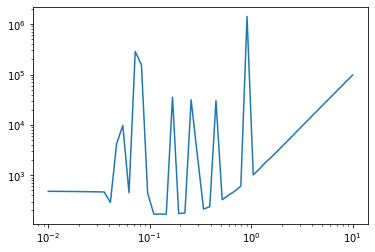

In [38]:
f0 = [(x['f']) for x in profiles[0]]
f0r = [np.exp(-(f0i-min(f0))) for f0i in f0]
plt.loglog(np.logspace(-2, 1, num=50).flatten(), f0)

In [39]:
list(zip(range(50), np.logspace(-2, 1, num=50),f0r))

[(0, 0.01, DM(7.36742e-136)),
 (1, 0.011513953993264475, DM(1.84949e-135)),
 (2, 0.013257113655901088, DM(5.29193e-135)),
 (3, 0.015264179671752334, DM(1.75634e-134)),
 (4, 0.017575106248547922, DM(6.88195e-134)),
 (5, 0.020235896477251575, DM(3.25323e-133)),
 (6, 0.023299518105153717, DM(1.89358e-132)),
 (7, 0.02682695795279726, DM(1.38918e-131)),
 (8, 0.030888435964774818, DM(1.31539e-130)),
 (9, 0.03556480306223128, DM(1.6441e-129)),
 (10, 0.040949150623804255, DM(9.3578e-53)),
 (11, 0.04714866363457394, DM(0)),
 (12, 0.054286754393238594, DM(0)),
 (13, 0.06250551925273973, DM(9.41405e-124)),
 (14, 0.07196856730011521, DM(0)),
 (15, 0.08286427728546843, DM(0)),
 (16, 0.09540954763499938, DM(4.97507e-118)),
 (17, 0.10985411419875583, DM(0.741776)),
 (18, 0.12648552168552957, DM(1)),
 (19, 0.14563484775012436, DM(0.743104)),
 (20, 0.16768329368110083, DM(0)),
 (21, 0.19306977288832497, DM(0.0159692)),
 (22, 0.22229964825261944, DM(0.00016361)),
 (23, 0.2559547922699536, DM(0)),
 (24, 

In [40]:
a0 = linterp(0.011513953993264475, 0.013257113655901088, 0.145754, 0.152931, 0.15)
a1 = linterp( 0.2559547922699536, 0.29470517025518095, 0.314558, 0.115928,  0.15)
a0idx = [1, 2]
a1idx = [23, 24]

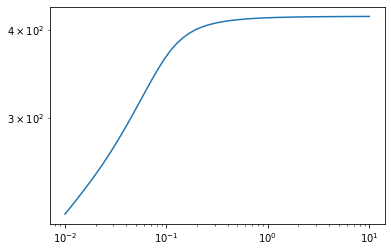

In [41]:
f1 = [(x['f']) for x in profiles[1]]
f1r = [np.exp(-(f1i-min(f1))) for f1i in f1]
plt.loglog(np.logspace(-2, 1, num=50).flatten(), f1)

In [42]:
list(zip(range(50), np.logspace(-2, 1, num=50),f1r))

[(0, 0.01, DM(1)),
 (1, 0.011513953993264475, DM(0.00385454)),
 (2, 0.013257113655901088, DM(1.14627e-05)),
 (3, 0.015264179671752334, DM(2.53333e-08)),
 (4, 0.017575106248547922, DM(3.92449e-11)),
 (5, 0.020235896477251575, DM(3.9583e-14)),
 (6, 0.023299518105153717, DM(2.39725e-17)),
 (7, 0.02682695795279726, DM(8.05408e-21)),
 (8, 0.030888435964774818, DM(1.40157e-24)),
 (9, 0.03556480306223128, DM(1.20134e-28)),
 (10, 0.040949150623804255, DM(4.94611e-33)),
 (11, 0.04714866363457394, DM(9.87642e-38)),
 (12, 0.054286754393238594, DM(1.01788e-42)),
 (13, 0.06250551925273973, DM(6.24309e-48)),
 (14, 0.07196856730011521, DM(2.94562e-53)),
 (15, 0.08286427728546843, DM(1.59196e-58)),
 (16, 0.09540954763499938, DM(1.65866e-63)),
 (17, 0.10985411419875583, DM(5.63056e-68)),
 (18, 0.12648552168552957, DM(8.79635e-72)),
 (19, 0.14563484775012436, DM(6.7874e-75)),
 (20, 0.16768329368110083, DM(2.24112e-77)),
 (21, 0.19306977288832497, DM(2.49659e-79)),
 (22, 0.22229964825261944, DM(7.34368e-

In [43]:
b0 = linterp(0.6866488450043002, 0.7906043210907697,0.105638 , 0.158776, 0.15)
b1 = linterp(2.8117686979742306,2.8117686979742308, 0.149, 0.151, 0.15)
b0idx = [30, 31]
b1idx = [40, 40]

In [44]:
r0int = [b0/a0, b0/a1, b1/a0, b1/a1]
r0int

[61.651772808241006, 2.6849982819238467, 224.13053183340259, 9.761115787718639]

In [45]:
def gets0(pdx, idx):
    return float(getx(profiles[pdx][idx]['x'])[0][0])
def means0(pdx, idxs):
    return np.mean([gets0(pdx, idx) for idx in idxs])
s0 = [means0(0, a0idx), means0(0, a1idx), means0(1,b0idx), means0(1,b1idx)]
def crossmean(axs, bxs):
    s = []
    for a in axs:
        for b in bxs:
            s.append(np.mean([a, b]))
    return s
s0mean = crossmean(s0[2:], s0[:2])

In [46]:
def rinft(r0,s0):
    f = lambda y: y/s0 - np.exp(r0*(y-s0)/s0) 
    sinf = brentq(f, 0, s0-1) 
    return s0-sinf
[rinft(r0x, s0x) for r0x, s0x in zip(r0int, s0mean)]

[4683.018038191165, 4363.460398567875, 4673.773592583283, 4764.110263409956]

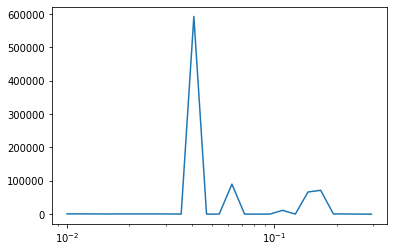

In [47]:
f2 = [(x['f']) for x in profiles[2]]
plt.semilogx(np.logspace(-2, 1, num=50).flatten()[:25], f2[:25])

In [48]:
def mod_seir(t, y, p):
    for i, yi in enumerate(y):
        if yi < 0:
            y[i] = 0 
    return seir(t, y, p)

In [64]:
from scipy.integrate import solve_ivp
tidx = 45
print(model.observation_times[tidx])
sol = solve_ivp(lambda t,y: mod_seir(t, y, getp(sols[idx]['x'])), [0, 150], [getx(sols[idx]['x'])[i][tidx] for i in range(5)], dense_output=True)
# solb = solve_ivp(lambda t,y: np.array(mod_seir(t, y, getp(sols[idx]['x']))), [0, -20], [getx(sols[idx]['x'])[i][tidx] for i in range(5)], method='BDF', dense_output=True)

77.0909090909091


In [65]:
[getx(sols[idx]['x'])[i][tidx] for i in range(5)]

[DM(4151.47), DM(148.882), DM(90.1865), DM(210.59), DM(770.262)]

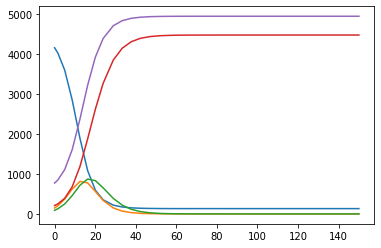

In [66]:
plt.plot(sol.t, sol.y[:,:].T)

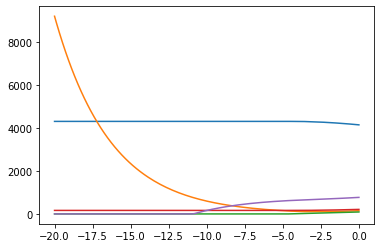

In [67]:
plt.plot(solb.t, solb.y.T)

In [68]:
model.observation_times[-1]

130.0

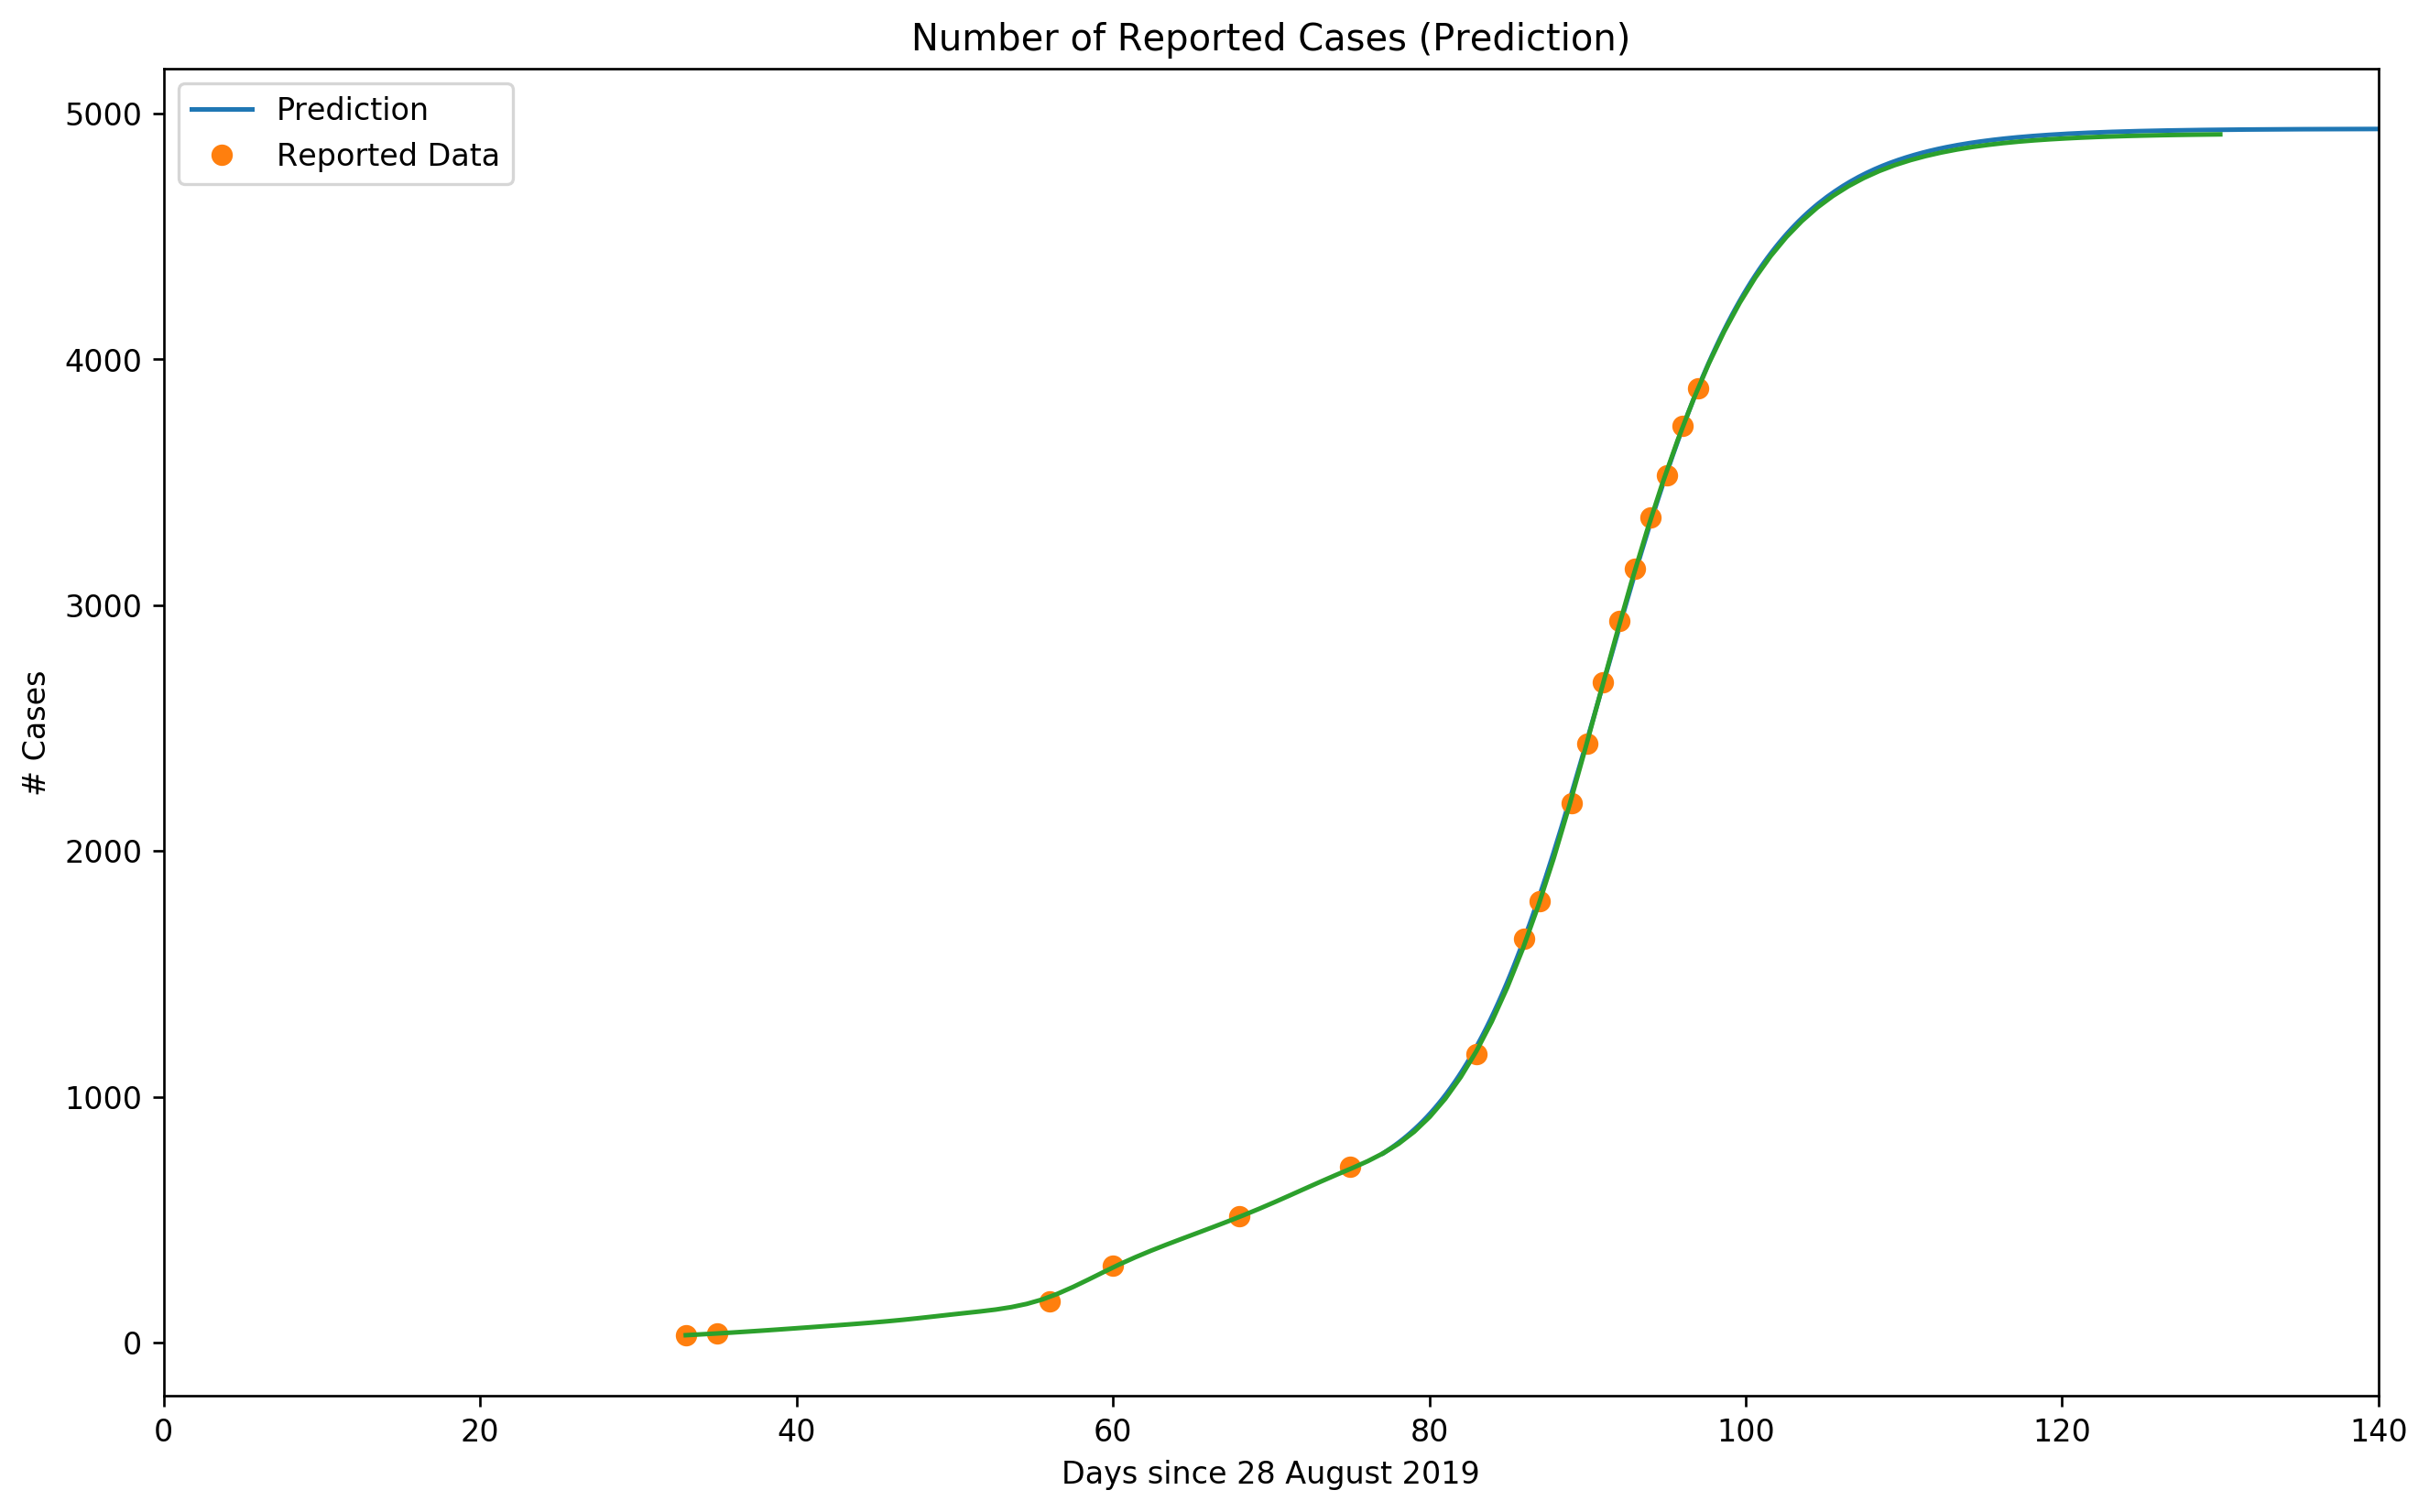

In [79]:
tfine = np.linspace(0, 150, 600)
# tbfine = np.linspace(0, -20, 20)
plt.figure(figsize=[13, 8], dpi=240)
# plt.plot(tbfine+model.observation_times[tidx], solb.sol(tbfine)[-1,:].T)
plt.plot(tfine+model.observation_times[tidx], sol.sol(tfine)[-1,:].T)
plt.plot(additional_times, additional_cumdata, 'o')
plt.xlim(0, 140)
plt.legend(["Prediction", "Reported Data"])
plt.xlabel("Days since 28 August 2019")
plt.ylabel("# Cases")
plt.title("Number of Reported Cases (Prediction)")

plt.plot(model.observation_times, getx(sols[idx]['x'])[4], label='Prediction')


In [70]:
rfin = sol.sol(tfine)[-1,-1]
rfin

4938.134790498894

In [71]:
ridx = np.argmin(np.abs(((1-(sol.sol(tfine)[-1,:])/rfin)*100) - 5))

In [72]:
tfine[ridx]

28.797996661101838

In [73]:
tfine[ridx]-(model.observation_times[-1]-model.observation_times[tidx])

-24.11109424798907

In [74]:
model.observation_times[-1]-model.observation_times[tidx]

52.90909090909091

In [75]:
historical_mortality = 0.02
current_mortality = 55/3881
print(historical_mortality, current_mortality)

0.02 0.014171605256377222


In [76]:
rfin*historical_mortality

98.76269580997788

In [77]:
rfin*current_mortality

69.98129695373336